## Read this

- https://s.id/PanduanPenggunaanDGXA100
-

## Import Libraries

In [ ]:
!nvidia-smi

Sun Jun 30 07:44:21 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 551.86                 Driver Version: 551.86         CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                     TCC/WDDM  | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce MX350         WDDM  |   00000000:30:00.0 Off |                  N/A |
| N/A   52C    P0             N/A / ERR!  |       0MiB /   2048MiB |      1%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [ ]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '1'
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

In [ ]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com


In [ ]:
!pip install jupyter

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com


In [ ]:
!pip install ipywidgets

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com


In [ ]:
!pip uninstall traitlets --y
!pip install traitlets==5.9.0

Found existing installation: traitlets 5.9.0
Uninstalling traitlets-5.9.0:
  Successfully uninstalled traitlets-5.9.0
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.4/117.4 kB 2.7 MB/s eta 0:00:00


In [ ]:
import os
import pandas as pd
import numpy as np
import math
from sklearn import metrics
from sklearn.model_selection import train_test_split, StratifiedKFold

from transformers import AutoTokenizer, AutoModel
from transformers import DataCollatorWithPadding

import torch
import torch.nn.functional as F
import torch.nn as nn

from torch.utils.data import Dataset, DataLoader, Subset
from torch.nn.utils.rnn import pad_sequence

import matplotlib.pyplot as plt
from tqdm import tqdm

# from torchsummary import summary

C:\Users\Rofif\anaconda3\envs\lexidvenv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Download Model

In [ ]:
tokenizer = AutoTokenizer.from_pretrained("indolem/indobert-base-uncased")
model_class = AutoModel.from_pretrained("indolem/indobert-base-uncased")

# Data collator is used for padding in batch
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

Some weights of the model checkpoint at indolem/indobert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


## Save Model to local - Example

In [ ]:
save_path = 'model/'
!mkdir -p model

model_class_path = os.path.join(save_path, "indobert_huggingface"+".pt")

torch.save(model_class, model_class_path)

A subdirectory or file -p already exists.
Error occurred while processing: -p.
A subdirectory or file model already exists.
Error occurred while processing: model.


## Load Model - Example

In [ ]:
# save_path = 'model/'
# model_class_path = os.path.join(save_path, "indobert_class"+".pth")

# bert_class = torch.load(model_class_path)

bert_class = model_class

In [ ]:
print(bert_class)

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(31923, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0): BertLayer(
        (attention): BertAttention(
          (self): BertSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False)
          

## Bert Test Simple Input

In [ ]:
input = tokenizer("apa bedanya biru sama merah?")
print(input)
output = bert_class(torch.tensor(input['input_ids']).view(1, -1), return_dict=False)
output[0]

{'input_ids': [3, 2064, 15118, 6646, 1959, 3544, 35, 4], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1]}


tensor([[[-0.6440, -0.0310, -0.2656,  ..., -1.5620, -0.0250,  0.6238],
         [ 1.2366, -0.7621, -0.7362,  ..., -1.3577, -0.3997,  1.1043],
         [ 0.3624, -0.0728, -0.6131,  ..., -1.5214, -0.0254,  1.2058],
         ...,
         [ 0.2125,  0.1820, -1.0552,  ..., -2.2355, -1.1234,  1.2763],
         [-0.9484, -0.2584, -0.8549,  ..., -0.8135, -0.3181,  0.9097],
         [-0.3185, -0.3560, -0.3028,  ..., -1.4869, -1.0726,  0.3153]]],
       grad_fn=<NativeLayerNormBackward0>)

# Variables

In [ ]:
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
print(DEVICE)

cpu


# LexID QA 2 Using BERT

## Dataset Class

In [ ]:
class Lexidqa2Dataset(Dataset):
  """LexID QA2 Dataset"""

  def __init__(self, dataframe, tokenizer):
    """
      dataframe (Pandas DataFrame): Dataset in DataFrame format
      tokenizer (Tokenizer) : Sentence to Vector
    """
    self.qa_frame = dataframe
    self.tokenizer = tokenizer

    self.label2id = {"T1": 0, "T2": 1, "T3": 2, "T4": 3,
                "T5": 4, "T6": 5, "T7": 6, "T8": 7, "T9": 8,
                "T10": 9, "T11": 10, "T12": 11, "T13": 12,
                "T14": 13, "T15": 14, "T16": 15, "T17": 16, "T18": 17}
    self.id2label = {0: "T1", 1: "T2", 2: "T3", 3: "T4",
                4: "T5", 5: "T6", 6: "T7", 7: "T8", 8: "T9",
                9: "T10", 10: "T11", 11: "T12", 12: "T13",
                13: "T14", 14: "T15", 15: "T16", 16: "T17", 17: "T18"}

  def __len__(self):
    return len(self.qa_frame)

  def __getitem__(self, idx):
    if torch.is_tensor(idx):
      idx = idx.tolist()

    question = self.qa_frame.loc[idx, "question"]
    question_tokenized = tokenizer(question, truncation=True)
    question_input_ids = torch.tensor(question_tokenized['input_ids'])
    question_token_type_ids = torch.tensor(question_tokenized['token_type_ids'])
    question_attention_masks = torch.tensor(question_tokenized['attention_mask'])

    answer = self.qa_frame.loc[idx, "answer"]
    template_label = self.qa_frame.loc[idx, "template_index"]

    template_id = self.one_hot(template_label, self.label2id)

    sample = (question,
              question_input_ids,
              question_token_type_ids,
              question_attention_masks,
              answer,
              template_label,
              template_id)

    return sample

  def one_hot(self, label, label2id):
    one_hot_label = torch.zeros(len(label2id))
    one_hot_label[label2id[label]] = 1

    return one_hot_label

## Merging Dataset from Different csv

In [ ]:
t1 = pd.read_csv("tesaurus/t1_dataset_tesaurus.csv")
num, _ = t1.shape
num

12155

In [ ]:
t = pd.DataFrame()
for i in range(1, 19):
  read_path = "tesaurus/t" + str(i) + "_dataset_tesaurus.csv"
  t_index = pd.read_csv(read_path)

  num_row, _ = t_index.shape
  two_thousands = np.min([2000, num_row])
  print("t" + str(i) + ": " + str(two_thousands))
  t = pd.concat([t, t_index[:two_thousands]], ignore_index=True)

t.head()

t1: 2000
t2: 2000
t3: 2000
t4: 2000
t5: 2000
t6: 2000
t7: 2000
t8: 2000
t9: 2000
t10: 2000
t11: 2000
t12: 2000
t13: 2000
t14: 314
t15: 955
t16: 2000
t17: 2000
t18: 2000


question             answer  \
0  Peraturan Daerah Kota Semarang Nomor 6 Tahun 2...   H Sukawi Sutarip   
1  Pelegal dari Peraturan Presiden Republik Indon...        Joko Widodo   
2  Peraturan Menteri Pertahanan Republik Indonesi...  Ryamizard Ryacudu   
3  Keabsahan Peraturan Daerah Kabupaten Wakatobi ...          H U G U A   
4  Status Peraturan Pemerintah Republik Indonesia...  Dr Hamid Awaludin   

                                                 ner  \
0                     [1, 1, 1, 1, 1, 1, 1, 1, 0, 0]   
1                  [0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0]   
2         [1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0]   
3   [0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0]   
4  [0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, ...   

                                      legal_document  \
0  https://w3id.org/lex-id/data/Perkot_Semarang_2...   
1       https://w3id.org/lex-id/data/Perpres_2019_89   
2    https://w3id.org/lex-id/data/Permen_Han_2016_37   
3  https://w3id.org/lex-id/data/Perkab_Wakatobi_2...   
4             https://w3id.org/lex-id/data/PP_2005_6   

                                               query template_index pasal_num  \
0  \n  SELECT DISTINCT ?answer\n  WHERE {\n      ...             T1       NaN   
1  \n  SELECT DISTINCT ?answer\n  WHERE {\n      ...             T1       NaN   
2  \n  SELECT DISTINCT ?answer\n  WHERE {\n      ...             T1       NaN   
3  \n  SELECT DISTINCT ?answer\n  WHERE {\n      ...             T1       NaN   
4  \n  SELECT DISTINCT ?answer\n  WHERE {\n      ...             T1       NaN   

  ayat_num  
0      NaN  
1      NaN  
2      NaN  
3      NaN  
4      NaN

## Dataset

In [ ]:
qa_dataset = Lexidqa2Dataset(t, tokenizer)

## Sample from dataset

In [ ]:
np.random.seed(12345)
random_indices = np.random.choice(range(len(qa_dataset)), size=5, replace=False)

for i in random_indices:
  sample = qa_dataset[i]

  print(i, sample[0])

  if i == 5:
    break

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


5710 Kapan terjadinya pengukugannya Peraturan Menteri Keuangan Republik Indonesia Nomor 204 Tahun 2015 ini keluar
21038 Apakah isi Pasal 2 dalam Peraturan Menteri Kelautan Dan Perikanan Republik Indonesia Nomor 25 Tahun 2012 itu
19978 Berapa jumlah pasal yang tersusun di Peraturan Pemerintah Republik Indonesia Nomor 26 Tahun 2016 tersebut
29131 Sudahkah Peraturan Daerah Provinsi Jawa Tengah Nomor 16 Tahun 2002 tersebut dilakukan penyempurnaan
26026 Peraturan Komisi Pemilihan Umum Republik Indonesia Nomor 10 Tahun 2015 tersebut terjadi penganuliran pasal-pasal mana saja


In [ ]:
BATCH_SIZE = 64
torch.manual_seed(12345)

data_all_label = [qa_dataset[i][5] for i in range(len(qa_dataset))]
train_idx, test_idx = train_test_split(np.arange(len(qa_dataset)), test_size=0.25, random_state=12345, shuffle=True, stratify=data_all_label)

train_size = len(train_idx)
test_size = len(test_idx)

### Save train test data to CSV

In [ ]:
# train_df = t.iloc[train_idx]
# !mkdir -p dataset
# train_df.to_csv('dataset/train_tesaurus.csv', index=False)

In [ ]:
# test_df = t.iloc[test_idx]
# !mkdir -p dataset
# test_df.to_csv('dataset/test_tesaurus.csv', index=False)

## Split, DataLoader

In [ ]:
def collate_fn_class(data):
    """
       data: is a list of tuples with (example, label, length)
             where 'example' is a tensor of arbitrary shape
             and label/length are scalars
    """
    _, input_ids, _, _, _, _, label_ids = zip(*data)
    features = pad_sequence(input_ids, batch_first=True)
    targets = torch.stack(label_ids)
    return features, targets

### Prepare for KFold

### Load train test data

In [ ]:
train_df = pd.read_csv('dataset/train_tesaurus.csv')
train_df['template_index'].value_counts()

T4     1500
T7     1500
T10    1500
T3     1500
T9     1500
T18    1500
T5     1500
T16    1500
T11    1500
T12    1500
T1     1500
T6     1500
T13    1500
T8     1500
T17    1500
T2     1500
T15     716
T14     235
Name: template_index, dtype: int64

In [ ]:
test_df = pd.read_csv('dataset/test_tesaurus.csv')
test_df['template_index'].value_counts()

T17    500
T10    500
T13    500
T3     500
T2     500
T8     500
T11    500
T12    500
T4     500
T5     500
T9     500
T7     500
T18    500
T6     500
T1     500
T16    500
T15    239
T14     79
Name: template_index, dtype: int64

In [ ]:
BATCH_SIZE = 64
torch.manual_seed(12345)

train_df = pd.read_csv('dataset/train_tesaurus.csv')
test_df = pd.read_csv('dataset/test_tesaurus.csv')

qa_dataset_train = Lexidqa2Dataset(train_df, tokenizer)
qa_dataset_test = Lexidqa2Dataset(test_df, tokenizer)

# data_all_label = [qa_dataset[i][5] for i in range(len(qa_dataset))]
# train_idx, test_idx = train_test_split(np.arange(len(qa_dataset)), test_size=0.25, random_state=12345, shuffle=True, stratify=data_all_label)

train_size = len(qa_dataset_train)
test_size = len(qa_dataset_test)

data_train_label = [qa_dataset_train[i][5] for i in range(train_size)]

# test_dataset = Subset(qa_dataset, test_idx)
test_instances = DataLoader(qa_dataset_test, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn_class)

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


# Classification

## Model

### Loss Function

> Loss Function Multi-Class Classification: CrossEntropyLoss

In [ ]:
loss_func = torch.nn.CrossEntropyLoss(reduction='mean')

### Evaluation Function

In [ ]:
def confusion_matrix(gold, pred, conf_matrix):
  _, gold = torch.max(gold, 1)
  _, pred = torch.max(pred, 1)
  for g, p in zip(gold.view(-1), pred.view(-1)):
    conf_matrix[g.long(), p.long()] += 1

  return conf_matrix

In [ ]:
def evaluation_metric(conf_matrix):
  nb_classes = 18
  display_labels = ['T1', 'T2', 'T3', 'T4', 'T5', 'T6', 'T7', 'T8', 'T9', 'T10', 'T11', 'T12', 'T13', 'T14', 'T15', 'T16', 'T17', 'T18']

  amt = amount(conf_matrix)
  # print(f"Debug Amount: {amt}")
  acc = accuracy(conf_matrix)
  prec = precision(conf_matrix)
  rec = recall(conf_matrix)
  f1 = fone(prec, rec)

  return amt, acc, prec, rec, f1

def amount(conf_matrix):
  return conf_matrix.sum(1)

def accuracy(conf_matrix):
  return conf_matrix.diag()/conf_matrix.sum(1)

def precision(conf_matrix):
  nb_classes = 18

  prec = torch.zeros(nb_classes)
  for index in range(nb_classes):
    true_positive = 0
    false_positive = 0
    for col in range(nb_classes):
      if index == col:
        true_positive = conf_matrix[col, index]
      else:
        false_positive += conf_matrix[col, index]
    prec[index] = true_positive / (true_positive + false_positive)

  return prec

def recall(conf_matrix):
  nb_classes = 18

  rec = torch.zeros(nb_classes)
  for index in range(nb_classes):
    true_positive = 0
    false_negative = 0
    for col in range(nb_classes):
      if index == col:
        true_positive = conf_matrix[index, col]
      else:
        false_negative += conf_matrix[index, col]
    rec[index] = true_positive / (true_positive + false_negative)

  return rec

def fone(prec, rec):
  nb_classes = 18

  f1 = torch.zeros(nb_classes)
  for index in range(nb_classes):
    f1[index] = 2 * (prec[index] * rec[index]) / (prec[index] + rec[index])

  return f1

### BERT + Full Connected Layer

In [ ]:
class BERT_Lexidqa2_class(nn.Module):
    def __init__(self, bert, input_size = 768, output_size = 18):
        super().__init__()

        self.bert = bert

        self.dropout = nn.Dropout(0.1)

        self.relu = nn.ReLU()

        self.linear1 = nn.Linear(input_size, 512)
        self.linear2 = nn.Linear(512, output_size)

        self.id2label = {0: "T1", 1: "T2", 2: "T3", 3: "T4",
              4: "T5", 5: "T6", 6: "T7", 7: "T8", 8: "T9",
              9: "T10", 10: "T11", 11: "T12", 12: "T13",
              13: "T14", 14: "T15", 15: "T16", 16: "T17", 17: "T18"}

    def forward(self, x):
        x, _ = self.bert(x, return_dict=False)

        # Only take the first column, Pooled Output, The Context
        x = x[:, 0, :]
        x = x.view(-1, 768)

        x = self.linear1(x)
        x = self.relu(x)
        x = self.dropout(x)

        x = self.linear2(x)

        return x

    def predict(input):
      output = self.forward(torch.tensor(input['input_ids']).view(1, -1))

      id_max = torch.argmax(output)
      return self.id2label[id_max.item()]

In [ ]:
model = BERT_Lexidqa2_class(bert_class, 768, 18)

## Training

> Train using 5-Fold
>
> Save checkpoint every 5 Epoch Max 20 Epoch

0it [00:00, ?it/s]/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


=====:=====:=====:=====:===== Fold 1 =====:=====:=====:=====:=====


0it [00:02, ?it/s]

Fold 1 Ready


  0%|                                                    | 0/20 [00:00<?, ?it/s]

Epoch 1 / 20


==:==:==Train==:==:==: 0it [00:00, ?it/s]We strongly recommend passing in an `attention_mask` since your input_ids may be padded. See https://huggingface.co/docs/transformers/troubleshooting#incorrect-output-when-padding-tokens-arent-masked.
You may ignore this warning if your `pad_token_id` (0) is identical to the `bos_token_id` (0), `eos_token_id` (None), or the `sep_token_id` (None), and your input is not padded.
==:==:==Train==:==:==: 0it [00:11, ?it/s]


Average Loss Train: 0.03120707300359118


==:==:==Valid==:==:==: 0it [00:02, ?it/s]
  5%|██▏                                         | 1/20 [00:13<04:15, 13.45s/it]

Average Loss Validation: 0.011483949306994779
Time 13.438596248626709

Epoch 2 / 20


==:==:==Train==:==:==: 0it [00:11, ?it/s]


Average Loss Train: 0.010691241984197753


==:==:==Valid==:==:==: 0it [00:02, ?it/s]
 10%|████▍                                       | 2/20 [00:26<04:01, 13.41s/it]

Average Loss Validation: 0.004462221737759215
Time 13.368599653244019

Epoch 3 / 20


==:==:==Train==:==:==: 0it [00:10, ?it/s]


Average Loss Train: 0.005654012047515843


==:==:==Valid==:==:==: 0it [00:02, ?it/s]
 15%|██████▌                                     | 3/20 [00:39<03:45, 13.24s/it]

Average Loss Validation: 0.0024024395806186067
Time 13.03990650177002

Epoch 4 / 20


==:==:==Train==:==:==: 0it [00:10, ?it/s]


Average Loss Train: 0.003755587763442305


==:==:==Valid==:==:==: 0it [00:02, ?it/s]
 20%|████████▊                                   | 4/20 [00:52<03:30, 13.15s/it]

Average Loss Validation: 0.0015617809298520478
Time 13.002825021743774

Epoch 5 / 20


==:==:==Train==:==:==: 0it [00:10, ?it/s]


Average Loss Train: 0.0027043131872533798


==:==:==Valid==:==:==: 0it [00:02, ?it/s]


Average Loss Validation: 0.0010975613582530736
Time 13.11641788482666



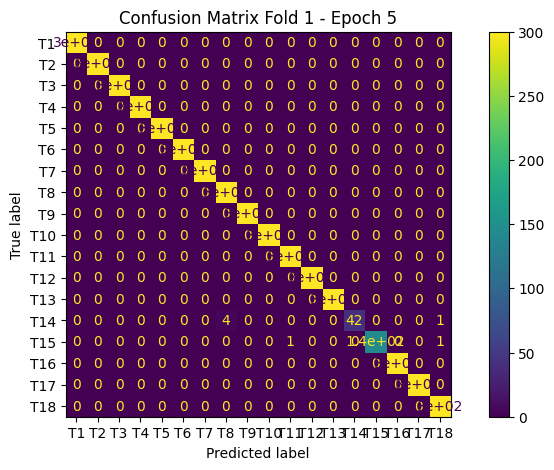

Amount of Data  Accuracy  Precision    Recall     F One
T1            300.0  1.000000   1.000000  1.000000  1.000000
T2            300.0  1.000000   1.000000  1.000000  1.000000
T3            300.0  1.000000   1.000000  1.000000  1.000000
T4            300.0  1.000000   1.000000  1.000000  1.000000
T5            300.0  1.000000   1.000000  1.000000  1.000000
T6            300.0  1.000000   1.000000  1.000000  1.000000
T7            300.0  1.000000   1.000000  1.000000  1.000000
T8            300.0  1.000000   0.986842  1.000000  0.993377
T9            300.0  1.000000   1.000000  1.000000  1.000000
T10           300.0  1.000000   1.000000  1.000000  1.000000
T11           300.0  1.000000   0.996678  1.000000  0.998336
T12           300.0  1.000000   1.000000  1.000000  1.000000
T13           300.0  1.000000   1.000000  1.000000  1.000000
T14            47.0  0.893617   1.000000  0.893617  0.943820
T15           144.0  0.986111   1.000000  0.986111  0.993007
T16           300.0  1.000000   1.000000  1.000000  1.000000
T17           300.0  1.000000   1.000000  1.000000  1.000000
T18           300.0  1.000000   0.993378  1.000000  0.996678

 25%|███████████                                 | 5/20 [01:10<03:41, 14.76s/it]

Epoch 6 / 20


==:==:==Train==:==:==: 0it [00:10, ?it/s]


Average Loss Train: 0.0020690362467495854


==:==:==Valid==:==:==: 0it [00:02, ?it/s]
 30%|█████████████▏                              | 6/20 [01:23<03:19, 14.22s/it]

Average Loss Validation: 0.0008802086068606525
Time 13.177918434143066

Epoch 7 / 20


==:==:==Train==:==:==: 0it [00:10, ?it/s]


Average Loss Train: 0.0017241977326915355


==:==:==Valid==:==:==: 0it [00:02, ?it/s]
 35%|███████████████▍                            | 7/20 [01:36<03:00, 13.87s/it]

Average Loss Validation: 0.0007417188806933646
Time 13.13546633720398

Epoch 8 / 20


==:==:==Train==:==:==: 0it [00:10, ?it/s]


Average Loss Train: 0.0014589981935574918


==:==:==Valid==:==:==: 0it [00:02, ?it/s]
 40%|█████████████████▌                          | 8/20 [01:50<02:43, 13.65s/it]

Average Loss Validation: 0.0006476088961244131
Time 13.170323371887207

Epoch 9 / 20


==:==:==Train==:==:==: 0it [00:10, ?it/s]


Average Loss Train: 0.0012800096293429813


==:==:==Valid==:==:==: 0it [00:02, ?it/s]
 45%|███████████████████▊                        | 9/20 [02:03<02:28, 13.49s/it]

Average Loss Validation: 0.0005816611747026587
Time 13.134542226791382

Epoch 10 / 20


==:==:==Train==:==:==: 0it [00:10, ?it/s]


Average Loss Train: 0.0011614005463963042


==:==:==Valid==:==:==: 0it [00:02, ?it/s]


Average Loss Validation: 0.0005209540119392794
Time 13.169411659240723



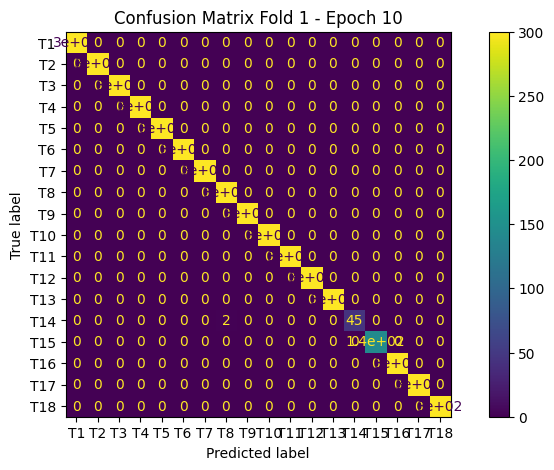

Amount of Data  Accuracy  Precision    Recall     F One
T1            300.0  1.000000   1.000000  1.000000  1.000000
T2            300.0  1.000000   1.000000  1.000000  1.000000
T3            300.0  1.000000   1.000000  1.000000  1.000000
T4            300.0  1.000000   1.000000  1.000000  1.000000
T5            300.0  1.000000   1.000000  1.000000  1.000000
T6            300.0  1.000000   1.000000  1.000000  1.000000
T7            300.0  1.000000   1.000000  1.000000  1.000000
T8            300.0  1.000000   0.993378  1.000000  0.996678
T9            300.0  1.000000   1.000000  1.000000  1.000000
T10           300.0  1.000000   1.000000  1.000000  1.000000
T11           300.0  1.000000   1.000000  1.000000  1.000000
T12           300.0  1.000000   1.000000  1.000000  1.000000
T13           300.0  1.000000   1.000000  1.000000  1.000000
T14            47.0  0.957447   1.000000  0.957447  0.978261
T15           144.0  1.000000   1.000000  1.000000  1.000000
T16           300.0  1.000000   1.000000  1.000000  1.000000
T17           300.0  1.000000   1.000000  1.000000  1.000000
T18           300.0  1.000000   1.000000  1.000000  1.000000

 50%|█████████████████████▌                     | 10/20 [02:20<02:28, 14.80s/it]

Epoch 11 / 20


==:==:==Train==:==:==: 0it [00:10, ?it/s]


Average Loss Train: 0.0010109599845816114


==:==:==Valid==:==:==: 0it [00:02, ?it/s]
 55%|███████████████████████▋                   | 11/20 [02:33<02:08, 14.27s/it]

Average Loss Validation: 0.000477161392811376
Time 13.0464026927948

Epoch 12 / 20


==:==:==Train==:==:==: 0it [00:10, ?it/s]


Average Loss Train: 0.000904123986957367


==:==:==Valid==:==:==: 0it [00:02, ?it/s]
 60%|█████████████████████████▊                 | 12/20 [02:47<01:51, 13.91s/it]

Average Loss Validation: 0.00042375601698224424
Time 13.06973147392273

Epoch 13 / 20


==:==:==Train==:==:==: 0it [00:10, ?it/s]


Average Loss Train: 0.0008199879223992208


==:==:==Valid==:==:==: 0it [00:02, ?it/s]
 65%|███████████████████████████▉               | 13/20 [03:00<01:35, 13.64s/it]

Average Loss Validation: 0.0003920130683935804
Time 13.031685829162598

Epoch 14 / 20


==:==:==Train==:==:==: 0it [00:10, ?it/s]


Average Loss Train: 0.000764015982326919


==:==:==Valid==:==:==: 0it [00:02, ?it/s]
 70%|██████████████████████████████             | 14/20 [03:13<01:20, 13.46s/it]

Average Loss Validation: 0.00035715423654253604
Time 13.012959241867065

Epoch 15 / 20


==:==:==Train==:==:==: 0it [00:10, ?it/s]


Average Loss Train: 0.00070787486144321


==:==:==Valid==:==:==: 0it [00:02, ?it/s]


Average Loss Validation: 0.00032470294837363137
Time 13.08764386177063



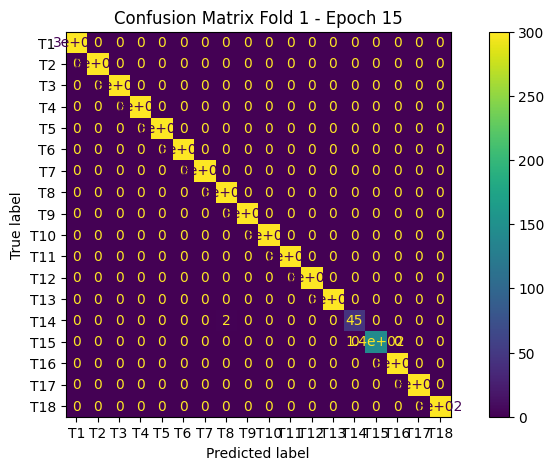

Amount of Data  Accuracy  Precision    Recall     F One
T1            300.0  1.000000   1.000000  1.000000  1.000000
T2            300.0  1.000000   1.000000  1.000000  1.000000
T3            300.0  1.000000   1.000000  1.000000  1.000000
T4            300.0  1.000000   1.000000  1.000000  1.000000
T5            300.0  1.000000   1.000000  1.000000  1.000000
T6            300.0  1.000000   1.000000  1.000000  1.000000
T7            300.0  1.000000   1.000000  1.000000  1.000000
T8            300.0  1.000000   0.993378  1.000000  0.996678
T9            300.0  1.000000   1.000000  1.000000  1.000000
T10           300.0  1.000000   1.000000  1.000000  1.000000
T11           300.0  1.000000   1.000000  1.000000  1.000000
T12           300.0  1.000000   1.000000  1.000000  1.000000
T13           300.0  1.000000   1.000000  1.000000  1.000000
T14            47.0  0.957447   1.000000  0.957447  0.978261
T15           144.0  1.000000   1.000000  1.000000  1.000000
T16           300.0  1.000000   1.000000  1.000000  1.000000
T17           300.0  1.000000   1.000000  1.000000  1.000000
T18           300.0  1.000000   1.000000  1.000000  1.000000

 75%|████████████████████████████████▎          | 15/20 [03:30<01:13, 14.78s/it]

Epoch 16 / 20


==:==:==Train==:==:==: 0it [00:10, ?it/s]


Average Loss Train: 0.0006291511994907875


==:==:==Valid==:==:==: 0it [00:02, ?it/s]
 80%|██████████████████████████████████▍        | 16/20 [03:44<00:57, 14.27s/it]

Average Loss Validation: 0.0003000673923982549
Time 13.077838897705078

Epoch 17 / 20


==:==:==Train==:==:==: 0it [00:10, ?it/s]


Average Loss Train: 0.0005979663126902255


==:==:==Valid==:==:==: 0it [00:02, ?it/s]
 85%|████████████████████████████████████▌      | 17/20 [03:57<00:41, 13.91s/it]

Average Loss Validation: 0.00027553533619832144
Time 13.056851148605347

Epoch 18 / 20


==:==:==Train==:==:==: 0it [00:10, ?it/s]


Average Loss Train: 0.0005782438531697155


==:==:==Valid==:==:==: 0it [00:02, ?it/s]
 90%|██████████████████████████████████████▋    | 18/20 [04:10<00:27, 13.65s/it]

Average Loss Validation: 0.0002477864194247126
Time 13.0516836643219

Epoch 19 / 20


==:==:==Train==:==:==: 0it [00:10, ?it/s]


Average Loss Train: 0.0004905522706729914


==:==:==Valid==:==:==: 0it [00:02, ?it/s]
 95%|████████████████████████████████████████▊  | 19/20 [04:22<00:13, 13.41s/it]

Average Loss Validation: 0.000230637446353393
Time 12.827175617218018

Epoch 20 / 20


==:==:==Train==:==:==: 0it [00:10, ?it/s]


Average Loss Train: 0.00046598314436410135


==:==:==Valid==:==:==: 0it [00:02, ?it/s]


Average Loss Validation: 0.00022462947528112916
Time 12.9536292552948



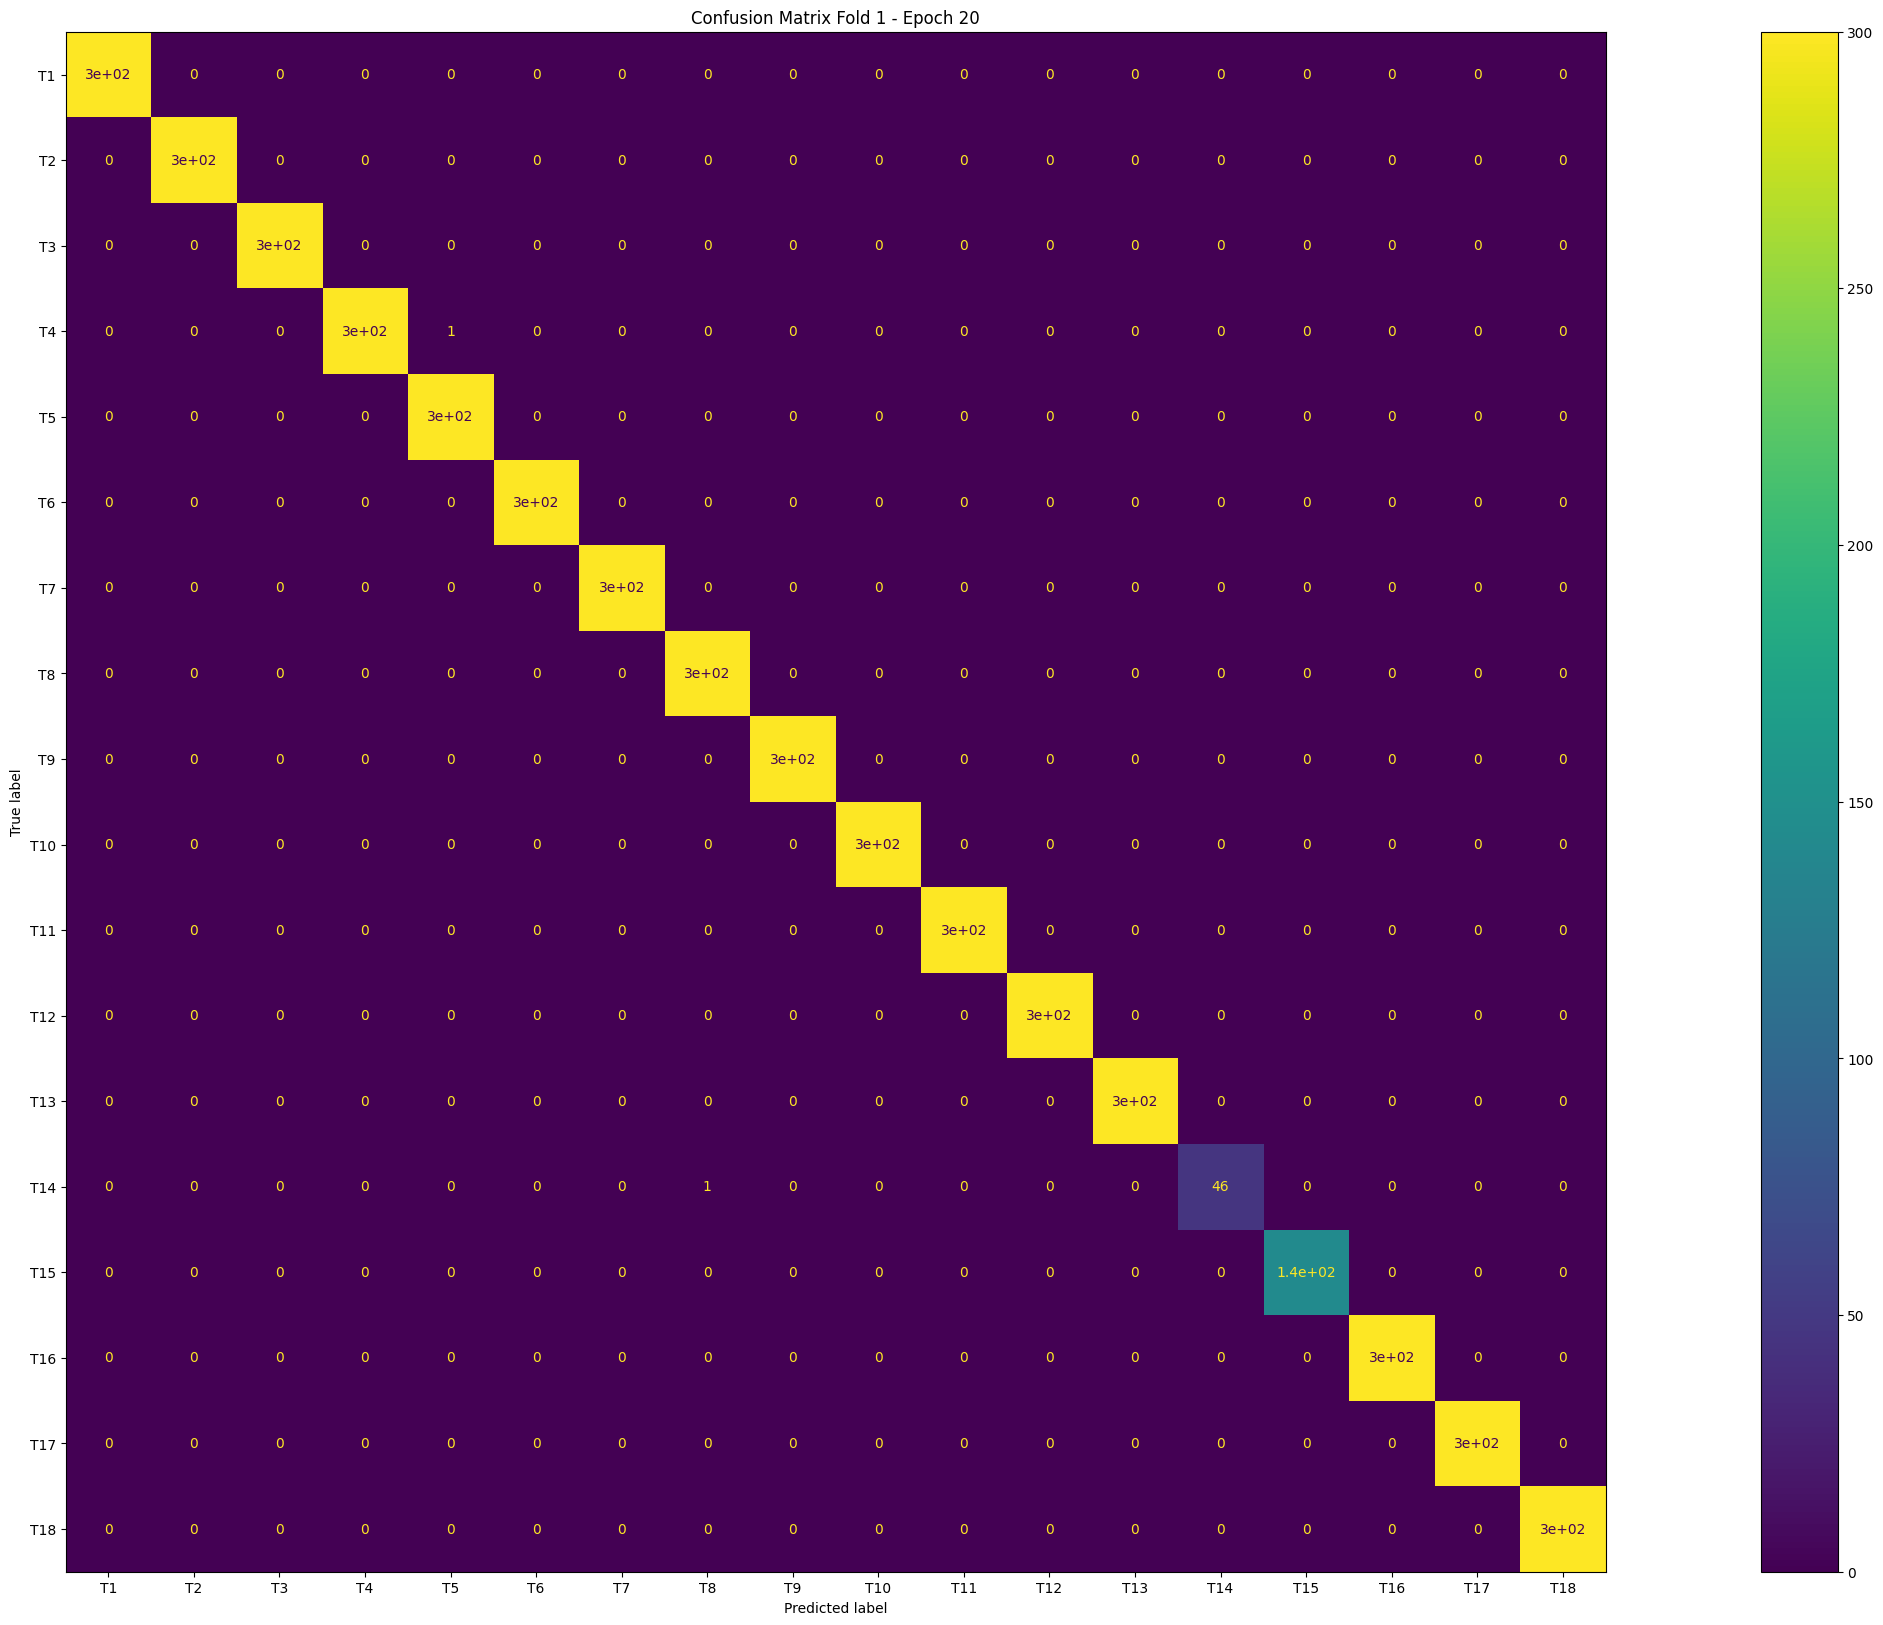

Amount of Data  Accuracy  Precision    Recall     F One
T1            300.0  1.000000   1.000000  1.000000  1.000000
T2            300.0  1.000000   1.000000  1.000000  1.000000
T3            300.0  1.000000   1.000000  1.000000  1.000000
T4            300.0  0.996667   1.000000  0.996667  0.998331
T5            300.0  1.000000   0.996678  1.000000  0.998336
T6            300.0  1.000000   1.000000  1.000000  1.000000
T7            300.0  1.000000   1.000000  1.000000  1.000000
T8            300.0  1.000000   0.996678  1.000000  0.998336
T9            300.0  1.000000   1.000000  1.000000  1.000000
T10           300.0  1.000000   1.000000  1.000000  1.000000
T11           300.0  1.000000   1.000000  1.000000  1.000000
T12           300.0  1.000000   1.000000  1.000000  1.000000
T13           300.0  1.000000   1.000000  1.000000  1.000000
T14            47.0  0.978723   1.000000  0.978723  0.989247
T15           144.0  1.000000   1.000000  1.000000  1.000000
T16           300.0  1.000000   1.000000  1.000000  1.000000
T17           300.0  1.000000   1.000000  1.000000  1.000000
T18           300.0  1.000000   1.000000  1.000000  1.000000

100%|███████████████████████████████████████████| 20/20 [04:40<00:00, 14.02s/it]
1it [04:42, 282.98s/it]/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


=====:=====:=====:=====:===== Fold 2 =====:=====:=====:=====:=====


1it [04:47, 282.98s/it]

Fold 2 Ready


  0%|                                                    | 0/20 [00:00<?, ?it/s]

Epoch 1 / 20


==:==:==Train==:==:==: 0it [00:11, ?it/s]


Average Loss Train: 0.03246749678270103


==:==:==Valid==:==:==: 0it [00:02, ?it/s]
  5%|██▏                                         | 1/20 [00:13<04:12, 13.28s/it]

Average Loss Validation: 0.012706037704834718
Time 13.271374225616455

Epoch 2 / 20


==:==:==Train==:==:==: 0it [00:10, ?it/s]


Average Loss Train: 0.01122159336427966


==:==:==Valid==:==:==: 0it [00:02, ?it/s]
 10%|████▍                                       | 2/20 [00:26<03:57, 13.19s/it]

Average Loss Validation: 0.004181880406841247
Time 13.12541127204895

Epoch 3 / 20


==:==:==Train==:==:==: 0it [00:10, ?it/s]


Average Loss Train: 0.005521796046149712


==:==:==Valid==:==:==: 0it [00:02, ?it/s]
 15%|██████▌                                     | 3/20 [00:39<03:44, 13.19s/it]

Average Loss Validation: 0.0021972134127048308
Time 13.173999786376953

Epoch 4 / 20


==:==:==Train==:==:==: 0it [00:10, ?it/s]


Average Loss Train: 0.0036483998386375315


==:==:==Valid==:==:==: 0it [00:02, ?it/s]
 20%|████████▊                                   | 4/20 [00:52<03:30, 13.17s/it]

Average Loss Validation: 0.0014268916286901386
Time 13.12061619758606

Epoch 5 / 20


==:==:==Train==:==:==: 0it [00:10, ?it/s]


Average Loss Train: 0.0026689192006669324


==:==:==Valid==:==:==: 0it [00:02, ?it/s]


Average Loss Validation: 0.0010523254779691927
Time 12.96851396560669



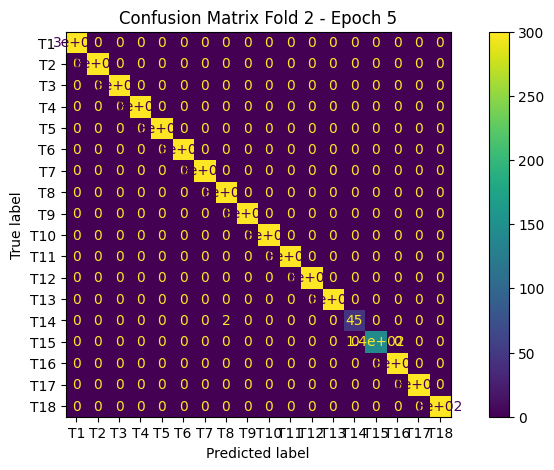

Amount of Data  Accuracy  Precision    Recall     F One
T1            300.0  1.000000   1.000000  1.000000  1.000000
T2            300.0  1.000000   1.000000  1.000000  1.000000
T3            300.0  1.000000   1.000000  1.000000  1.000000
T4            300.0  1.000000   1.000000  1.000000  1.000000
T5            300.0  1.000000   1.000000  1.000000  1.000000
T6            300.0  1.000000   1.000000  1.000000  1.000000
T7            300.0  1.000000   1.000000  1.000000  1.000000
T8            300.0  1.000000   0.993378  1.000000  0.996678
T9            300.0  1.000000   1.000000  1.000000  1.000000
T10           300.0  1.000000   1.000000  1.000000  1.000000
T11           300.0  1.000000   1.000000  1.000000  1.000000
T12           300.0  1.000000   1.000000  1.000000  1.000000
T13           300.0  1.000000   1.000000  1.000000  1.000000
T14            47.0  0.957447   1.000000  0.957447  0.978261
T15           143.0  1.000000   1.000000  1.000000  1.000000
T16           300.0  1.000000   1.000000  1.000000  1.000000
T17           300.0  1.000000   1.000000  1.000000  1.000000
T18           300.0  1.000000   1.000000  1.000000  1.000000

 25%|███████████                                 | 5/20 [01:09<03:39, 14.61s/it]

Epoch 6 / 20


==:==:==Train==:==:==: 0it [00:11, ?it/s]


Average Loss Train: 0.0021335014163698283


==:==:==Valid==:==:==: 0it [00:02, ?it/s]
 30%|█████████████▏                              | 6/20 [01:23<03:18, 14.16s/it]

Average Loss Validation: 0.0008559909815300921
Time 13.274029970169067

Epoch 7 / 20


==:==:==Train==:==:==: 0it [00:10, ?it/s]


Average Loss Train: 0.0017725166787568962


==:==:==Valid==:==:==: 0it [00:02, ?it/s]
 35%|███████████████▍                            | 7/20 [01:36<02:59, 13.82s/it]

Average Loss Validation: 0.0007252724777780219
Time 13.120280742645264

Epoch 8 / 20


==:==:==Train==:==:==: 0it [00:10, ?it/s]


Average Loss Train: 0.00152922708392412


==:==:==Valid==:==:==: 0it [00:02, ?it/s]
 40%|█████████████████▌                          | 8/20 [01:49<02:43, 13.62s/it]

Average Loss Validation: 0.0006327765543976862
Time 13.161112785339355

Epoch 9 / 20


==:==:==Train==:==:==: 0it [00:10, ?it/s]


Average Loss Train: 0.0013188852572911702


==:==:==Valid==:==:==: 0it [00:02, ?it/s]
 45%|███████████████████▊                        | 9/20 [02:02<02:28, 13.47s/it]

Average Loss Validation: 0.0005769945867732914
Time 13.155718326568604

Epoch 10 / 20


==:==:==Train==:==:==: 0it [00:10, ?it/s]


Average Loss Train: 0.0011694086462230924


==:==:==Valid==:==:==: 0it [00:02, ?it/s]


Average Loss Validation: 0.0005133834665637456
Time 13.075619220733643



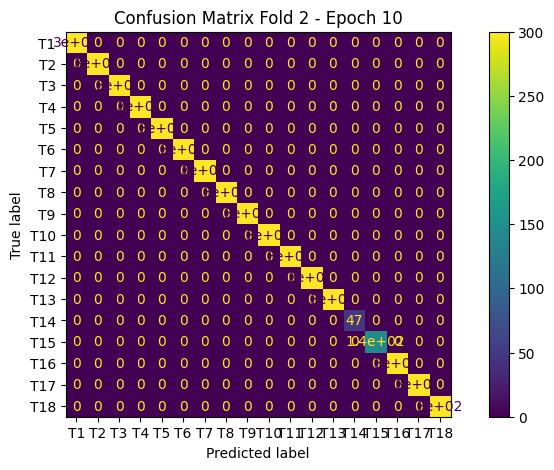

Amount of Data  Accuracy  Precision  Recall  F One
T1            300.0       1.0        1.0     1.0    1.0
T2            300.0       1.0        1.0     1.0    1.0
T3            300.0       1.0        1.0     1.0    1.0
T4            300.0       1.0        1.0     1.0    1.0
T5            300.0       1.0        1.0     1.0    1.0
T6            300.0       1.0        1.0     1.0    1.0
T7            300.0       1.0        1.0     1.0    1.0
T8            300.0       1.0        1.0     1.0    1.0
T9            300.0       1.0        1.0     1.0    1.0
T10           300.0       1.0        1.0     1.0    1.0
T11           300.0       1.0        1.0     1.0    1.0
T12           300.0       1.0        1.0     1.0    1.0
T13           300.0       1.0        1.0     1.0    1.0
T14            47.0       1.0        1.0     1.0    1.0
T15           143.0       1.0        1.0     1.0    1.0
T16           300.0       1.0        1.0     1.0    1.0
T17           300.0       1.0        1.0     1.0    1.0
T18           300.0       1.0        1.0     1.0    1.0

 50%|█████████████████████▌                     | 10/20 [02:20<02:27, 14.73s/it]

Epoch 11 / 20


==:==:==Train==:==:==: 0it [00:10, ?it/s]


Average Loss Train: 0.0010610568538187955


==:==:==Valid==:==:==: 0it [00:02, ?it/s]
 55%|███████████████████████▋                   | 11/20 [02:33<02:07, 14.18s/it]

Average Loss Validation: 0.0004612400478315736
Time 12.931772947311401

Epoch 12 / 20


==:==:==Train==:==:==: 0it [00:10, ?it/s]


Average Loss Train: 0.0009663675661035915


==:==:==Valid==:==:==: 0it [00:02, ?it/s]
 60%|█████████████████████████▊                 | 12/20 [02:46<01:50, 13.83s/it]

Average Loss Validation: 0.00041905571902562717
Time 13.022420883178711

Epoch 13 / 20


==:==:==Train==:==:==: 0it [00:10, ?it/s]


Average Loss Train: 0.0008612157336788613


==:==:==Valid==:==:==: 0it [00:02, ?it/s]
 65%|███████████████████████████▉               | 13/20 [02:59<01:35, 13.61s/it]

Average Loss Validation: 0.0003819154269381133
Time 13.09183931350708

Epoch 14 / 20


==:==:==Train==:==:==: 0it [00:10, ?it/s]


Average Loss Train: 0.0008013403417994124


==:==:==Valid==:==:==: 0it [00:02, ?it/s]
 70%|██████████████████████████████             | 14/20 [03:12<01:20, 13.46s/it]

Average Loss Validation: 0.00035470247208952663
Time 13.108552932739258

Epoch 15 / 20


==:==:==Train==:==:==: 0it [00:10, ?it/s]


Average Loss Train: 0.0007280204809982274


==:==:==Valid==:==:==: 0it [00:02, ?it/s]


Average Loss Validation: 0.00032678715369565217
Time 13.065751791000366



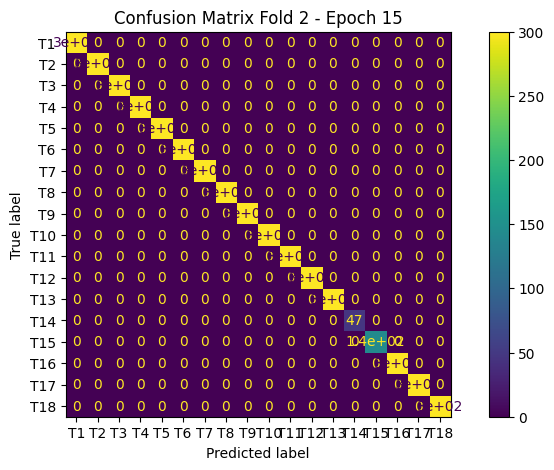

Amount of Data  Accuracy  Precision  Recall  F One
T1            300.0       1.0        1.0     1.0    1.0
T2            300.0       1.0        1.0     1.0    1.0
T3            300.0       1.0        1.0     1.0    1.0
T4            300.0       1.0        1.0     1.0    1.0
T5            300.0       1.0        1.0     1.0    1.0
T6            300.0       1.0        1.0     1.0    1.0
T7            300.0       1.0        1.0     1.0    1.0
T8            300.0       1.0        1.0     1.0    1.0
T9            300.0       1.0        1.0     1.0    1.0
T10           300.0       1.0        1.0     1.0    1.0
T11           300.0       1.0        1.0     1.0    1.0
T12           300.0       1.0        1.0     1.0    1.0
T13           300.0       1.0        1.0     1.0    1.0
T14            47.0       1.0        1.0     1.0    1.0
T15           143.0       1.0        1.0     1.0    1.0
T16           300.0       1.0        1.0     1.0    1.0
T17           300.0       1.0        1.0     1.0    1.0
T18           300.0       1.0        1.0     1.0    1.0

 75%|████████████████████████████████▎          | 15/20 [03:30<01:13, 14.72s/it]

Epoch 16 / 20


==:==:==Train==:==:==: 0it [00:10, ?it/s]


Average Loss Train: 0.0006720322207079987


==:==:==Valid==:==:==: 0it [00:02, ?it/s]
 80%|██████████████████████████████████▍        | 16/20 [03:43<00:57, 14.26s/it]

Average Loss Validation: 0.000295083971324569
Time 13.19136095046997

Epoch 17 / 20


==:==:==Train==:==:==: 0it [00:10, ?it/s]


Average Loss Train: 0.0006343633577359726


==:==:==Valid==:==:==: 0it [00:02, ?it/s]
 85%|████████████████████████████████████▌      | 17/20 [03:56<00:41, 13.93s/it]

Average Loss Validation: 0.0002868807335236746
Time 13.146917819976807

Epoch 18 / 20


==:==:==Train==:==:==: 0it [00:10, ?it/s]


Average Loss Train: 0.000579191922165786


==:==:==Valid==:==:==: 0it [00:02, ?it/s]
 90%|██████████████████████████████████████▋    | 18/20 [04:09<00:27, 13.67s/it]

Average Loss Validation: 0.0002512708157002329
Time 13.073745012283325

Epoch 19 / 20


==:==:==Train==:==:==: 0it [00:11, ?it/s]


Average Loss Train: 0.0005321656347006406


==:==:==Valid==:==:==: 0it [00:02, ?it/s]
 95%|████████████████████████████████████████▊  | 19/20 [04:22<00:13, 13.57s/it]

Average Loss Validation: 0.0002351482856070589
Time 13.301711082458496

Epoch 20 / 20


==:==:==Train==:==:==: 0it [00:11, ?it/s]


Average Loss Train: 0.0004860951967996882


==:==:==Valid==:==:==: 0it [00:02, ?it/s]


Average Loss Validation: 0.00021339703205681756
Time 13.176183700561523



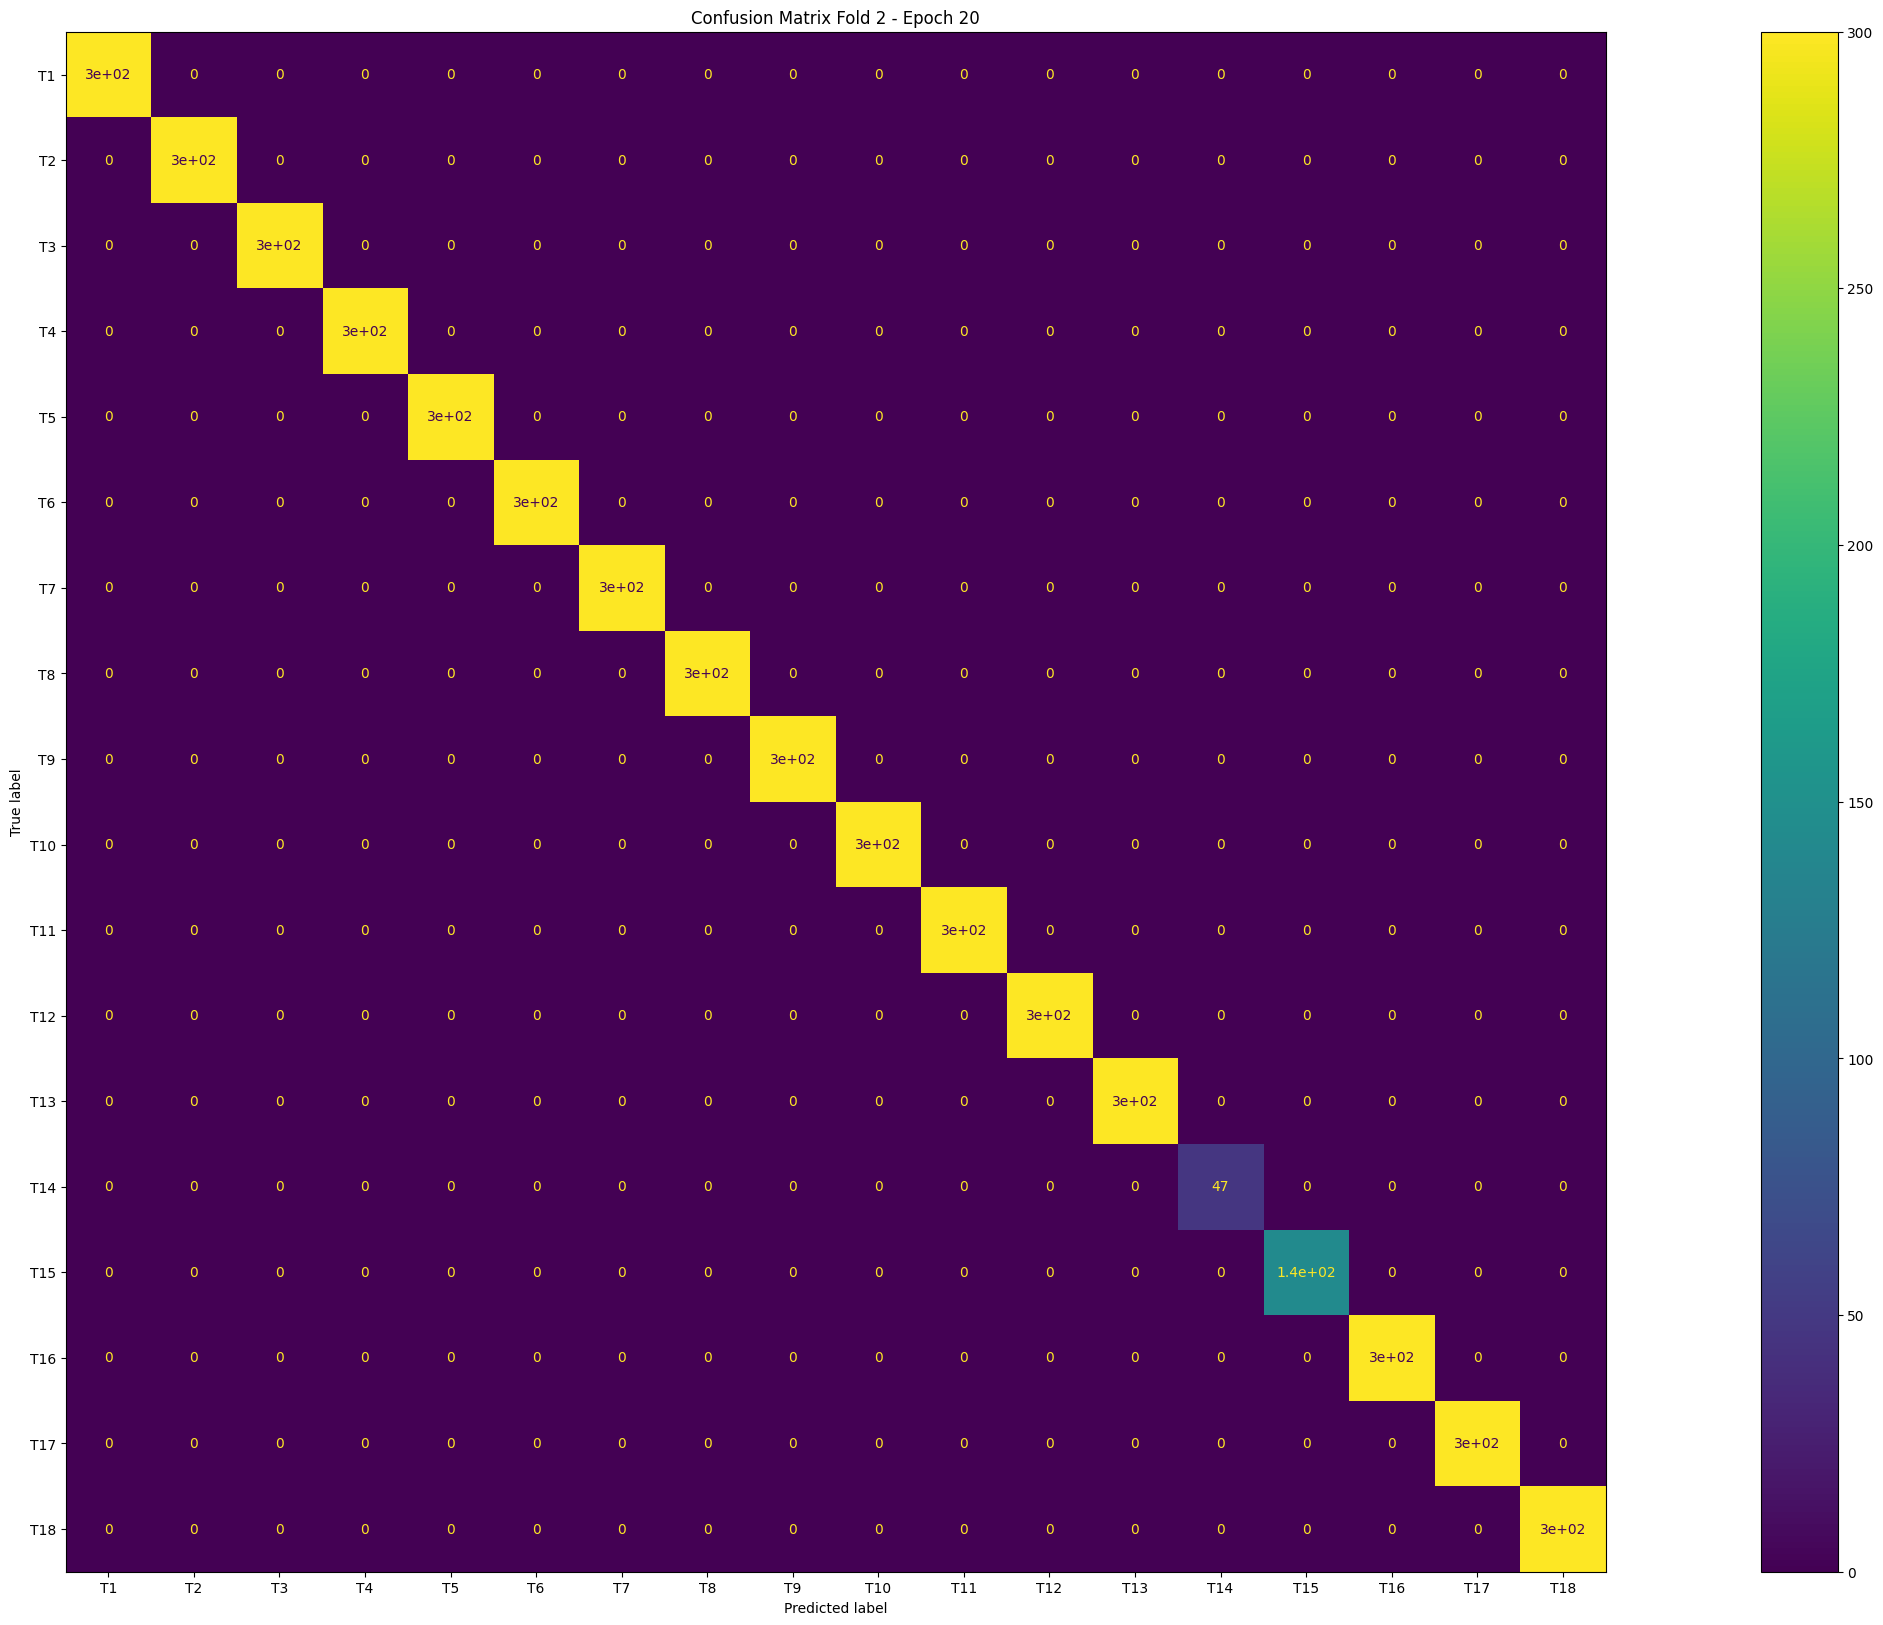

Amount of Data  Accuracy  Precision  Recall  F One
T1            300.0       1.0        1.0     1.0    1.0
T2            300.0       1.0        1.0     1.0    1.0
T3            300.0       1.0        1.0     1.0    1.0
T4            300.0       1.0        1.0     1.0    1.0
T5            300.0       1.0        1.0     1.0    1.0
T6            300.0       1.0        1.0     1.0    1.0
T7            300.0       1.0        1.0     1.0    1.0
T8            300.0       1.0        1.0     1.0    1.0
T9            300.0       1.0        1.0     1.0    1.0
T10           300.0       1.0        1.0     1.0    1.0
T11           300.0       1.0        1.0     1.0    1.0
T12           300.0       1.0        1.0     1.0    1.0
T13           300.0       1.0        1.0     1.0    1.0
T14            47.0       1.0        1.0     1.0    1.0
T15           143.0       1.0        1.0     1.0    1.0
T16           300.0       1.0        1.0     1.0    1.0
T17           300.0       1.0        1.0     1.0    1.0
T18           300.0       1.0        1.0     1.0    1.0

100%|███████████████████████████████████████████| 20/20 [04:40<00:00, 14.02s/it]
2it [09:27, 284.13s/it]/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


=====:=====:=====:=====:===== Fold 3 =====:=====:=====:=====:=====


2it [09:31, 284.13s/it]

Fold 3 Ready


  0%|                                                    | 0/20 [00:00<?, ?it/s]

Epoch 1 / 20


==:==:==Train==:==:==: 0it [00:10, ?it/s]


Average Loss Train: 0.031329607630318265


==:==:==Valid==:==:==: 0it [00:02, ?it/s]
  5%|██▏                                         | 1/20 [00:13<04:09, 13.12s/it]

Average Loss Validation: 0.011885667193628742
Time 13.116883277893066

Epoch 2 / 20


==:==:==Train==:==:==: 0it [00:10, ?it/s]


Average Loss Train: 0.010735427490916343


==:==:==Valid==:==:==: 0it [00:02, ?it/s]
 10%|████▍                                       | 2/20 [00:26<03:57, 13.18s/it]

Average Loss Validation: 0.004433827448584035
Time 13.204405546188354

Epoch 3 / 20


==:==:==Train==:==:==: 0it [00:10, ?it/s]


Average Loss Train: 0.0058292793798205384


==:==:==Valid==:==:==: 0it [00:02, ?it/s]
 15%|██████▌                                     | 3/20 [00:39<03:43, 13.15s/it]

Average Loss Validation: 0.0025479692719384043
Time 13.107651472091675

Epoch 4 / 20


==:==:==Train==:==:==: 0it [00:10, ?it/s]


Average Loss Train: 0.0038867822416822104


==:==:==Valid==:==:==: 0it [00:02, ?it/s]
 20%|████████▊                                   | 4/20 [00:52<03:30, 13.15s/it]

Average Loss Validation: 0.0017385711740396305
Time 13.127074480056763

Epoch 5 / 20


==:==:==Train==:==:==: 0it [00:10, ?it/s]


Average Loss Train: 0.002904429926891245


==:==:==Valid==:==:==: 0it [00:02, ?it/s]


Average Loss Validation: 0.0012657884157492307
Time 13.098810195922852



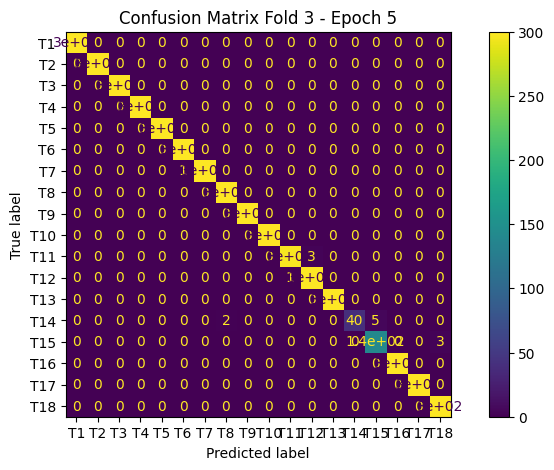

Amount of Data  Accuracy  Precision    Recall     F One
T1            300.0  1.000000   1.000000  1.000000  1.000000
T2            300.0  1.000000   1.000000  1.000000  1.000000
T3            300.0  1.000000   1.000000  1.000000  1.000000
T4            300.0  1.000000   1.000000  1.000000  1.000000
T5            300.0  1.000000   1.000000  1.000000  1.000000
T6            300.0  1.000000   0.996678  1.000000  0.998336
T7            300.0  0.996667   1.000000  0.996667  0.998331
T8            300.0  1.000000   0.993378  1.000000  0.996678
T9            300.0  1.000000   1.000000  1.000000  1.000000
T10           300.0  1.000000   1.000000  1.000000  1.000000
T11           300.0  0.990000   0.996644  0.990000  0.993311
T12           300.0  0.996667   0.990066  0.996667  0.993356
T13           300.0  1.000000   1.000000  1.000000  1.000000
T14            47.0  0.851064   1.000000  0.851064  0.919540
T15           143.0  0.979021   0.965517  0.979021  0.972222
T16           300.0  1.000000   1.000000  1.000000  1.000000
T17           300.0  1.000000   1.000000  1.000000  1.000000
T18           300.0  1.000000   0.990099  1.000000  0.995025

 25%|███████████                                 | 5/20 [01:09<03:39, 14.65s/it]

Epoch 6 / 20


==:==:==Train==:==:==: 0it [00:10, ?it/s]


Average Loss Train: 0.002347803738885112


==:==:==Valid==:==:==: 0it [00:02, ?it/s]
 30%|█████████████▏                              | 6/20 [01:23<03:17, 14.13s/it]

Average Loss Validation: 0.001067744005090727
Time 13.103121280670166

Epoch 7 / 20


==:==:==Train==:==:==: 0it [00:10, ?it/s]


Average Loss Train: 0.001943948898380645


==:==:==Valid==:==:==: 0it [00:02, ?it/s]
 35%|███████████████▍                            | 7/20 [01:36<02:59, 13.81s/it]

Average Loss Validation: 0.0008642446331844062
Time 13.140954494476318

Epoch 8 / 20


==:==:==Train==:==:==: 0it [00:11, ?it/s]


Average Loss Train: 0.0016560464011996358


==:==:==Valid==:==:==: 0it [00:02, ?it/s]
 40%|█████████████████▌                          | 8/20 [01:49<02:44, 13.68s/it]

Average Loss Validation: 0.000745104318988586
Time 13.399102687835693

Epoch 9 / 20


==:==:==Train==:==:==: 0it [00:11, ?it/s]


Average Loss Train: 0.001440798646999644


==:==:==Valid==:==:==: 0it [00:02, ?it/s]
 45%|███████████████████▊                        | 9/20 [02:02<02:29, 13.56s/it]

Average Loss Validation: 0.0006728846154255953
Time 13.284064769744873

Epoch 10 / 20


==:==:==Train==:==:==: 0it [00:10, ?it/s]


Average Loss Train: 0.0012967720044384224


==:==:==Valid==:==:==: 0it [00:02, ?it/s]


Average Loss Validation: 0.0005881210755489632
Time 13.222815752029419



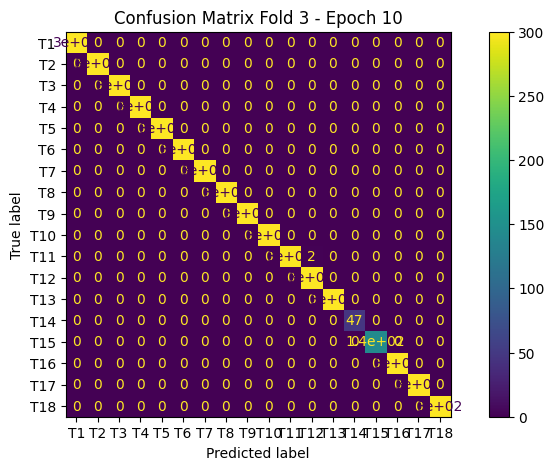

Amount of Data  Accuracy  Precision    Recall     F One
T1            300.0  1.000000   1.000000  1.000000  1.000000
T2            300.0  1.000000   1.000000  1.000000  1.000000
T3            300.0  1.000000   1.000000  1.000000  1.000000
T4            300.0  1.000000   1.000000  1.000000  1.000000
T5            300.0  1.000000   1.000000  1.000000  1.000000
T6            300.0  1.000000   1.000000  1.000000  1.000000
T7            300.0  1.000000   1.000000  1.000000  1.000000
T8            300.0  1.000000   1.000000  1.000000  1.000000
T9            300.0  1.000000   1.000000  1.000000  1.000000
T10           300.0  1.000000   1.000000  1.000000  1.000000
T11           300.0  0.993333   1.000000  0.993333  0.996656
T12           300.0  1.000000   0.993378  1.000000  0.996678
T13           300.0  1.000000   1.000000  1.000000  1.000000
T14            47.0  1.000000   1.000000  1.000000  1.000000
T15           143.0  1.000000   1.000000  1.000000  1.000000
T16           300.0  1.000000   1.000000  1.000000  1.000000
T17           300.0  1.000000   1.000000  1.000000  1.000000
T18           300.0  1.000000   1.000000  1.000000  1.000000

 50%|█████████████████████▌                     | 10/20 [02:20<02:28, 14.80s/it]

Epoch 11 / 20


==:==:==Train==:==:==: 0it [00:10, ?it/s]


Average Loss Train: 0.001155323758822131


==:==:==Valid==:==:==: 0it [00:02, ?it/s]
 55%|███████████████████████▋                   | 11/20 [02:33<02:08, 14.31s/it]

Average Loss Validation: 0.0005477062771787385
Time 13.16771912574768

Epoch 12 / 20


==:==:==Train==:==:==: 0it [00:10, ?it/s]


Average Loss Train: 0.0010490247114830662


==:==:==Valid==:==:==: 0it [00:02, ?it/s]
 60%|█████████████████████████▊                 | 12/20 [02:46<01:51, 13.98s/it]

Average Loss Validation: 0.0004919491678416609
Time 13.238677978515625

Epoch 13 / 20


==:==:==Train==:==:==: 0it [00:10, ?it/s]


Average Loss Train: 0.0009286991488935952


==:==:==Valid==:==:==: 0it [00:02, ?it/s]
 65%|███████████████████████████▉               | 13/20 [03:00<01:36, 13.74s/it]

Average Loss Validation: 0.0004501162343219908
Time 13.176511287689209

Epoch 14 / 20


==:==:==Train==:==:==: 0it [00:10, ?it/s]


Average Loss Train: 0.0008748784798651562


==:==:==Valid==:==:==: 0it [00:02, ?it/s]
 70%|██████████████████████████████             | 14/20 [03:13<01:21, 13.61s/it]

Average Loss Validation: 0.0004077898834893603
Time 13.285451412200928

Epoch 15 / 20


==:==:==Train==:==:==: 0it [00:11, ?it/s]


Average Loss Train: 0.0008117619956577656


==:==:==Valid==:==:==: 0it [00:02, ?it/s]


Average Loss Validation: 0.00038834053030114375
Time 13.36156153678894



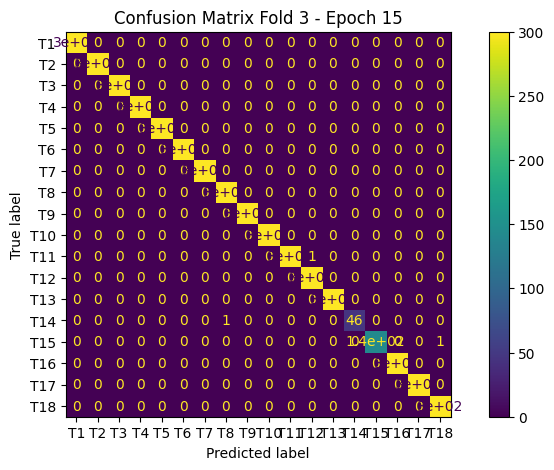

Amount of Data  Accuracy  Precision    Recall     F One
T1            300.0  1.000000   1.000000  1.000000  1.000000
T2            300.0  1.000000   1.000000  1.000000  1.000000
T3            300.0  1.000000   1.000000  1.000000  1.000000
T4            300.0  1.000000   1.000000  1.000000  1.000000
T5            300.0  1.000000   1.000000  1.000000  1.000000
T6            300.0  1.000000   1.000000  1.000000  1.000000
T7            300.0  1.000000   1.000000  1.000000  1.000000
T8            300.0  1.000000   0.996678  1.000000  0.998336
T9            300.0  1.000000   1.000000  1.000000  1.000000
T10           300.0  1.000000   1.000000  1.000000  1.000000
T11           300.0  0.996667   1.000000  0.996667  0.998331
T12           300.0  1.000000   0.996678  1.000000  0.998336
T13           300.0  1.000000   1.000000  1.000000  1.000000
T14            47.0  0.978723   1.000000  0.978723  0.989247
T15           143.0  0.993007   1.000000  0.993007  0.996491
T16           300.0  1.000000   1.000000  1.000000  1.000000
T17           300.0  1.000000   1.000000  1.000000  1.000000
T18           300.0  1.000000   0.996678  1.000000  0.998336

 75%|████████████████████████████████▎          | 15/20 [03:31<01:15, 15.02s/it]

Epoch 16 / 20


==:==:==Train==:==:==: 0it [00:11, ?it/s]


Average Loss Train: 0.0007354530278755855


==:==:==Valid==:==:==: 0it [00:02, ?it/s]
 80%|██████████████████████████████████▍        | 16/20 [03:44<00:58, 14.51s/it]

Average Loss Validation: 0.00036020750974963804
Time 13.303937673568726

Epoch 17 / 20


==:==:==Train==:==:==: 0it [00:11, ?it/s]


Average Loss Train: 0.0006729638046557449


==:==:==Valid==:==:==: 0it [00:02, ?it/s]
 85%|████████████████████████████████████▌      | 17/20 [03:58<00:42, 14.15s/it]

Average Loss Validation: 0.00032080598978068164
Time 13.3069589138031

Epoch 18 / 20


==:==:==Train==:==:==: 0it [00:10, ?it/s]


Average Loss Train: 0.0006265886057776468


==:==:==Valid==:==:==: 0it [00:02, ?it/s]
 90%|██████████████████████████████████████▋    | 18/20 [04:11<00:27, 13.87s/it]

Average Loss Validation: 0.0002979153364090499
Time 13.203806161880493

Epoch 19 / 20


==:==:==Train==:==:==: 0it [00:10, ?it/s]


Average Loss Train: 0.0005766720079487618


==:==:==Valid==:==:==: 0it [00:02, ?it/s]
 95%|████████████████████████████████████████▊  | 19/20 [04:24<00:13, 13.68s/it]

Average Loss Validation: 0.0002691404824938349
Time 13.247211694717407

Epoch 20 / 20


==:==:==Train==:==:==: 0it [00:10, ?it/s]


Average Loss Train: 0.0005521827860886573


==:==:==Valid==:==:==: 0it [00:02, ?it/s]


Average Loss Validation: 0.0002481964426133819
Time 13.257689476013184



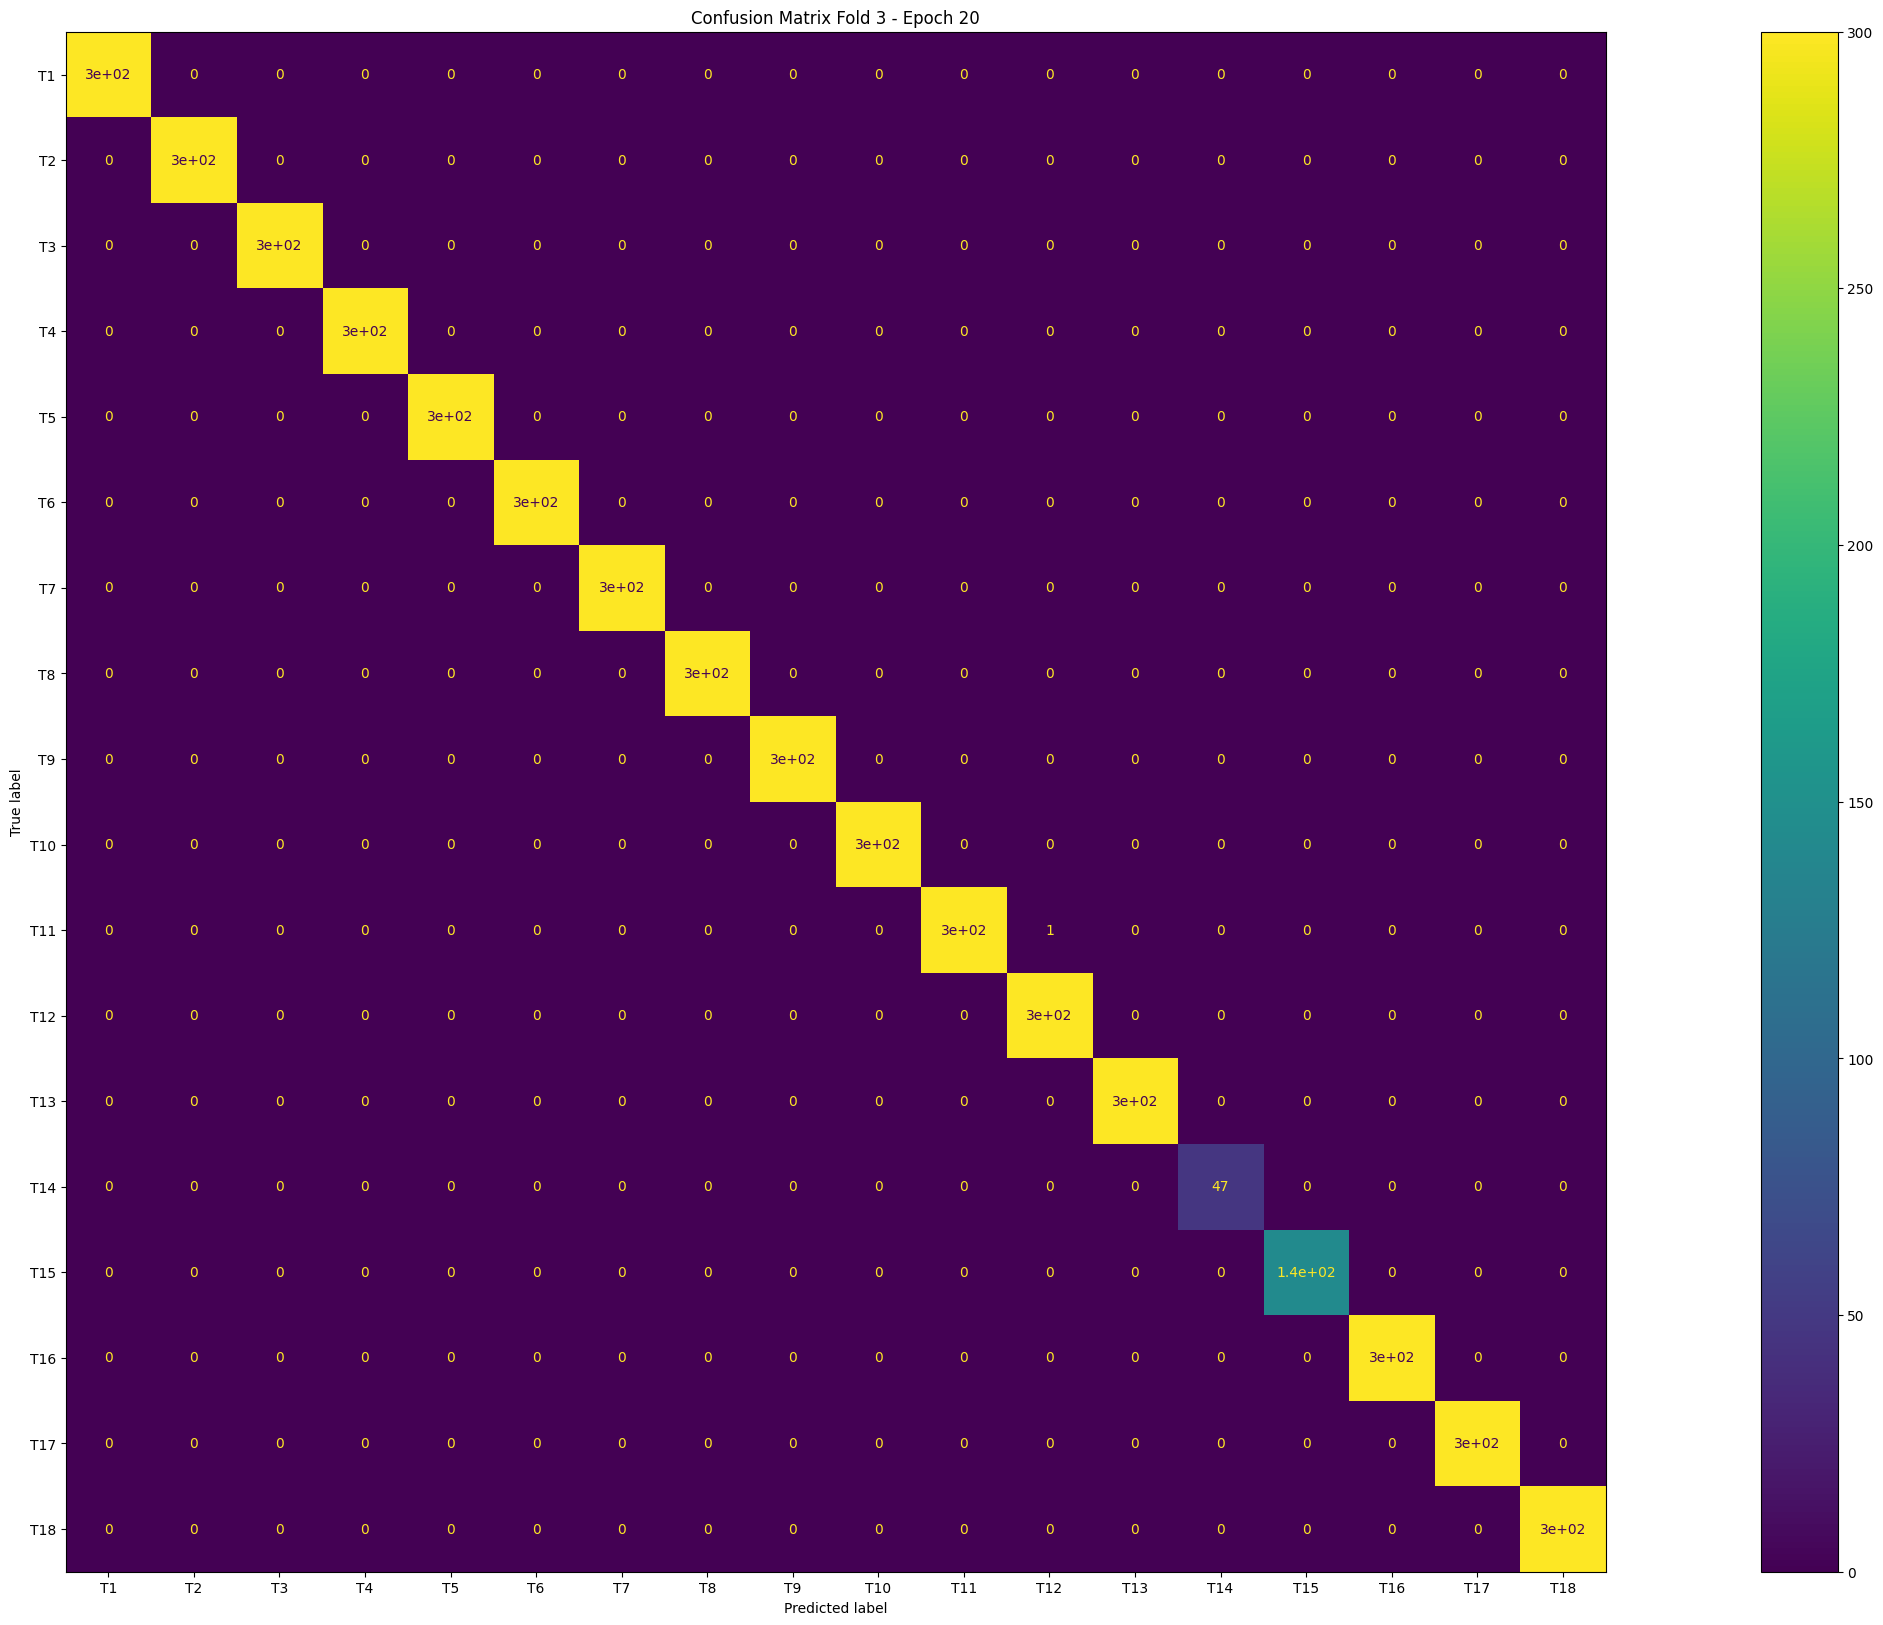

Amount of Data  Accuracy  Precision    Recall     F One
T1            300.0  1.000000   1.000000  1.000000  1.000000
T2            300.0  1.000000   1.000000  1.000000  1.000000
T3            300.0  1.000000   1.000000  1.000000  1.000000
T4            300.0  1.000000   1.000000  1.000000  1.000000
T5            300.0  1.000000   1.000000  1.000000  1.000000
T6            300.0  1.000000   1.000000  1.000000  1.000000
T7            300.0  1.000000   1.000000  1.000000  1.000000
T8            300.0  1.000000   1.000000  1.000000  1.000000
T9            300.0  1.000000   1.000000  1.000000  1.000000
T10           300.0  1.000000   1.000000  1.000000  1.000000
T11           300.0  0.996667   1.000000  0.996667  0.998331
T12           300.0  1.000000   0.996678  1.000000  0.998336
T13           300.0  1.000000   1.000000  1.000000  1.000000
T14            47.0  1.000000   1.000000  1.000000  1.000000
T15           143.0  1.000000   1.000000  1.000000  1.000000
T16           300.0  1.000000   1.000000  1.000000  1.000000
T17           300.0  1.000000   1.000000  1.000000  1.000000
T18           300.0  1.000000   1.000000  1.000000  1.000000

100%|███████████████████████████████████████████| 20/20 [04:43<00:00, 14.16s/it]
3it [14:15, 285.50s/it]/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


=====:=====:=====:=====:===== Fold 4 =====:=====:=====:=====:=====


3it [14:21, 285.50s/it]

Fold 4 Ready


  0%|                                                    | 0/20 [00:00<?, ?it/s]

Epoch 1 / 20


==:==:==Train==:==:==: 0it [00:11, ?it/s]


Average Loss Train: 0.031279831573782925


==:==:==Valid==:==:==: 0it [00:02, ?it/s]
  5%|██▏                                         | 1/20 [00:13<04:12, 13.28s/it]

Average Loss Validation: 0.011472840383200941
Time 13.26767873764038

Epoch 2 / 20


==:==:==Train==:==:==: 0it [00:10, ?it/s]


Average Loss Train: 0.010771931574904938


==:==:==Valid==:==:==: 0it [00:02, ?it/s]
 10%|████▍                                       | 2/20 [00:26<03:58, 13.24s/it]

Average Loss Validation: 0.004207991505553106
Time 13.206377029418945

Epoch 3 / 20


==:==:==Train==:==:==: 0it [00:11, ?it/s]


Average Loss Train: 0.005658494954978492


==:==:==Valid==:==:==: 0it [00:02, ?it/s]
 15%|██████▌                                     | 3/20 [00:39<03:45, 13.28s/it]

Average Loss Validation: 0.0023241773919614856
Time 13.313064575195312

Epoch 4 / 20


==:==:==Train==:==:==: 0it [00:10, ?it/s]


Average Loss Train: 0.003751913241881191


==:==:==Valid==:==:==: 0it [00:02, ?it/s]
 20%|████████▊                                   | 4/20 [00:53<03:32, 13.30s/it]

Average Loss Validation: 0.0015344830397852438
Time 13.31815481185913

Epoch 5 / 20


==:==:==Train==:==:==: 0it [00:11, ?it/s]


Average Loss Train: 0.0027263564162673336


==:==:==Valid==:==:==: 0it [00:02, ?it/s]


Average Loss Validation: 0.0011254917135936225
Time 13.65956449508667



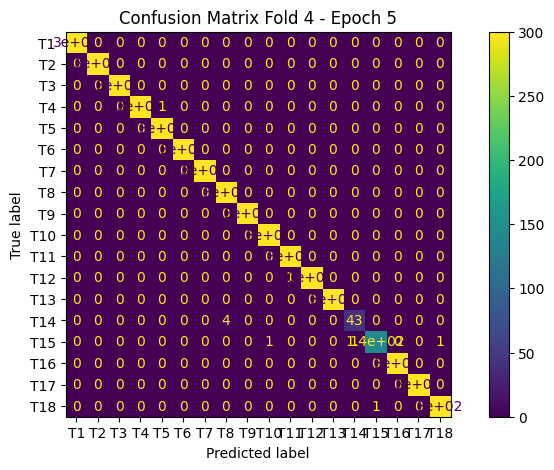

Amount of Data  Accuracy  Precision    Recall     F One
T1            300.0  1.000000   1.000000  1.000000  1.000000
T2            300.0  1.000000   1.000000  1.000000  1.000000
T3            300.0  1.000000   1.000000  1.000000  1.000000
T4            300.0  0.996667   1.000000  0.996667  0.998331
T5            300.0  1.000000   0.996678  1.000000  0.998336
T6            300.0  1.000000   1.000000  1.000000  1.000000
T7            300.0  1.000000   1.000000  1.000000  1.000000
T8            300.0  1.000000   0.986842  1.000000  0.993377
T9            300.0  1.000000   1.000000  1.000000  1.000000
T10           300.0  1.000000   0.996678  1.000000  0.998336
T11           300.0  1.000000   0.996678  1.000000  0.998336
T12           300.0  0.996667   1.000000  0.996667  0.998331
T13           300.0  1.000000   1.000000  1.000000  1.000000
T14            47.0  0.914894   0.977273  0.914894  0.945055
T15           143.0  0.979021   0.992908  0.979021  0.985915
T16           300.0  1.000000   1.000000  1.000000  1.000000
T17           300.0  1.000000   1.000000  1.000000  1.000000
T18           300.0  0.996667   0.996667  0.996667  0.996667

 25%|███████████                                 | 5/20 [01:11<03:45, 15.01s/it]

Epoch 6 / 20


==:==:==Train==:==:==: 0it [00:11, ?it/s]


Average Loss Train: 0.0021479368041126758


==:==:==Valid==:==:==: 0it [00:02, ?it/s]
 30%|█████████████▏                              | 6/20 [01:24<03:22, 14.47s/it]

Average Loss Validation: 0.0009144711903555838
Time 13.410904884338379

Epoch 7 / 20


==:==:==Train==:==:==: 0it [00:11, ?it/s]


Average Loss Train: 0.0017957357187427826


==:==:==Valid==:==:==: 0it [00:02, ?it/s]
 35%|███████████████▍                            | 7/20 [01:38<03:03, 14.15s/it]

Average Loss Validation: 0.0007515963025107413
Time 13.481375694274902

Epoch 8 / 20


==:==:==Train==:==:==: 0it [00:11, ?it/s]


Average Loss Train: 0.0015043596015814507


==:==:==Valid==:==:==: 0it [00:02, ?it/s]
 40%|█████████████████▌                          | 8/20 [01:51<02:47, 13.94s/it]

Average Loss Validation: 0.0006450923633778502
Time 13.467971086502075

Epoch 9 / 20


==:==:==Train==:==:==: 0it [00:11, ?it/s]


Average Loss Train: 0.0013227677174772136


==:==:==Valid==:==:==: 0it [00:02, ?it/s]
 45%|███████████████████▊                        | 9/20 [02:05<02:31, 13.79s/it]

Average Loss Validation: 0.0005837127805233957
Time 13.43952989578247

Epoch 10 / 20


==:==:==Train==:==:==: 0it [00:11, ?it/s]


Average Loss Train: 0.0011615840045634553


==:==:==Valid==:==:==: 0it [00:02, ?it/s]


Average Loss Validation: 0.0005213732631477659
Time 13.346927165985107



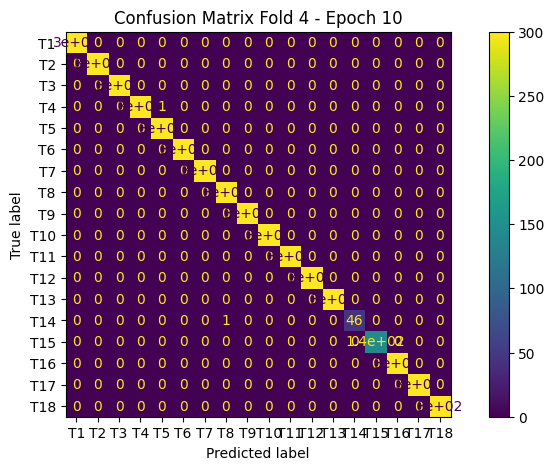

Amount of Data  Accuracy  Precision    Recall     F One
T1            300.0  1.000000   1.000000  1.000000  1.000000
T2            300.0  1.000000   1.000000  1.000000  1.000000
T3            300.0  1.000000   1.000000  1.000000  1.000000
T4            300.0  0.996667   1.000000  0.996667  0.998331
T5            300.0  1.000000   0.996678  1.000000  0.998336
T6            300.0  1.000000   1.000000  1.000000  1.000000
T7            300.0  1.000000   1.000000  1.000000  1.000000
T8            300.0  1.000000   0.996678  1.000000  0.998336
T9            300.0  1.000000   1.000000  1.000000  1.000000
T10           300.0  1.000000   1.000000  1.000000  1.000000
T11           300.0  1.000000   1.000000  1.000000  1.000000
T12           300.0  1.000000   1.000000  1.000000  1.000000
T13           300.0  1.000000   1.000000  1.000000  1.000000
T14            47.0  0.978723   1.000000  0.978723  0.989247
T15           143.0  1.000000   1.000000  1.000000  1.000000
T16           300.0  1.000000   1.000000  1.000000  1.000000
T17           300.0  1.000000   1.000000  1.000000  1.000000
T18           300.0  1.000000   1.000000  1.000000  1.000000

 50%|█████████████████████▌                     | 10/20 [02:23<02:31, 15.18s/it]

Epoch 11 / 20


==:==:==Train==:==:==: 0it [00:11, ?it/s]


Average Loss Train: 0.001028697228538901


==:==:==Valid==:==:==: 0it [00:02, ?it/s]
 55%|███████████████████████▋                   | 11/20 [02:36<02:11, 14.65s/it]

Average Loss Validation: 0.0004607177561593199
Time 13.428348779678345

Epoch 12 / 20


==:==:==Train==:==:==: 0it [00:10, ?it/s]


Average Loss Train: 0.0009445461880007521


==:==:==Valid==:==:==: 0it [00:02, ?it/s]
 60%|█████████████████████████▊                 | 12/20 [02:49<01:53, 14.21s/it]

Average Loss Validation: 0.00042487252578288616
Time 13.18230938911438

Epoch 13 / 20


==:==:==Train==:==:==: 0it [00:11, ?it/s]


Average Loss Train: 0.0008529781642774023


==:==:==Valid==:==:==: 0it [00:02, ?it/s]
 65%|███████████████████████████▉               | 13/20 [03:03<01:37, 13.99s/it]

Average Loss Validation: 0.0003910371914267062
Time 13.470056295394897

Epoch 14 / 20


==:==:==Train==:==:==: 0it [00:11, ?it/s]


Average Loss Train: 0.0008082871618460668


==:==:==Valid==:==:==: 0it [00:02, ?it/s]
 70%|██████████████████████████████             | 14/20 [03:17<01:23, 13.87s/it]

Average Loss Validation: 0.0003571981422319441
Time 13.607852220535278

Epoch 15 / 20


==:==:==Train==:==:==: 0it [00:11, ?it/s]


Average Loss Train: 0.0007334254395776028


==:==:==Valid==:==:==: 0it [00:02, ?it/s]


Average Loss Validation: 0.0003183000857282975
Time 13.508923053741455



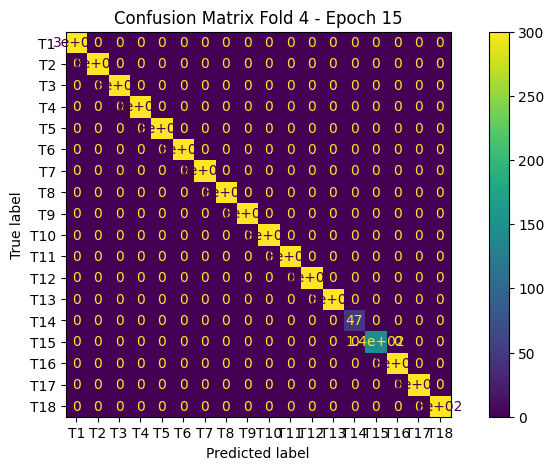

Amount of Data  Accuracy  Precision  Recall  F One
T1            300.0       1.0        1.0     1.0    1.0
T2            300.0       1.0        1.0     1.0    1.0
T3            300.0       1.0        1.0     1.0    1.0
T4            300.0       1.0        1.0     1.0    1.0
T5            300.0       1.0        1.0     1.0    1.0
T6            300.0       1.0        1.0     1.0    1.0
T7            300.0       1.0        1.0     1.0    1.0
T8            300.0       1.0        1.0     1.0    1.0
T9            300.0       1.0        1.0     1.0    1.0
T10           300.0       1.0        1.0     1.0    1.0
T11           300.0       1.0        1.0     1.0    1.0
T12           300.0       1.0        1.0     1.0    1.0
T13           300.0       1.0        1.0     1.0    1.0
T14            47.0       1.0        1.0     1.0    1.0
T15           143.0       1.0        1.0     1.0    1.0
T16           300.0       1.0        1.0     1.0    1.0
T17           300.0       1.0        1.0     1.0    1.0
T18           300.0       1.0        1.0     1.0    1.0

 75%|████████████████████████████████▎          | 15/20 [03:35<01:16, 15.21s/it]

Epoch 16 / 20


==:==:==Train==:==:==: 0it [00:11, ?it/s]


Average Loss Train: 0.000668862342526909


==:==:==Valid==:==:==: 0it [00:02, ?it/s]
 80%|██████████████████████████████████▍        | 16/20 [03:48<00:58, 14.72s/it]

Average Loss Validation: 0.0003091438507329008
Time 13.579721450805664

Epoch 17 / 20


==:==:==Train==:==:==: 0it [00:11, ?it/s]


Average Loss Train: 0.000625652502342274


==:==:==Valid==:==:==: 0it [00:02, ?it/s]
 85%|████████████████████████████████████▌      | 17/20 [04:02<00:43, 14.36s/it]

Average Loss Validation: 0.00027822391736602973
Time 13.494966745376587

Epoch 18 / 20


==:==:==Train==:==:==: 0it [00:11, ?it/s]


Average Loss Train: 0.0005426262668419097


==:==:==Valid==:==:==: 0it [00:02, ?it/s]
 90%|██████████████████████████████████████▋    | 18/20 [04:15<00:28, 14.06s/it]

Average Loss Validation: 0.0002454547202195935
Time 13.369501113891602

Epoch 19 / 20


==:==:==Train==:==:==: 0it [00:11, ?it/s]


Average Loss Train: 0.000515298617417806


==:==:==Valid==:==:==: 0it [00:02, ?it/s]
 95%|████████████████████████████████████████▊  | 19/20 [04:29<00:13, 13.85s/it]

Average Loss Validation: 0.00022856739344064123
Time 13.347217798233032

Epoch 20 / 20


==:==:==Train==:==:==: 0it [00:11, ?it/s]


Average Loss Train: 0.0005168618525072195


==:==:==Valid==:==:==: 0it [00:02, ?it/s]


Average Loss Validation: 0.00020825194347955897
Time 13.377469539642334



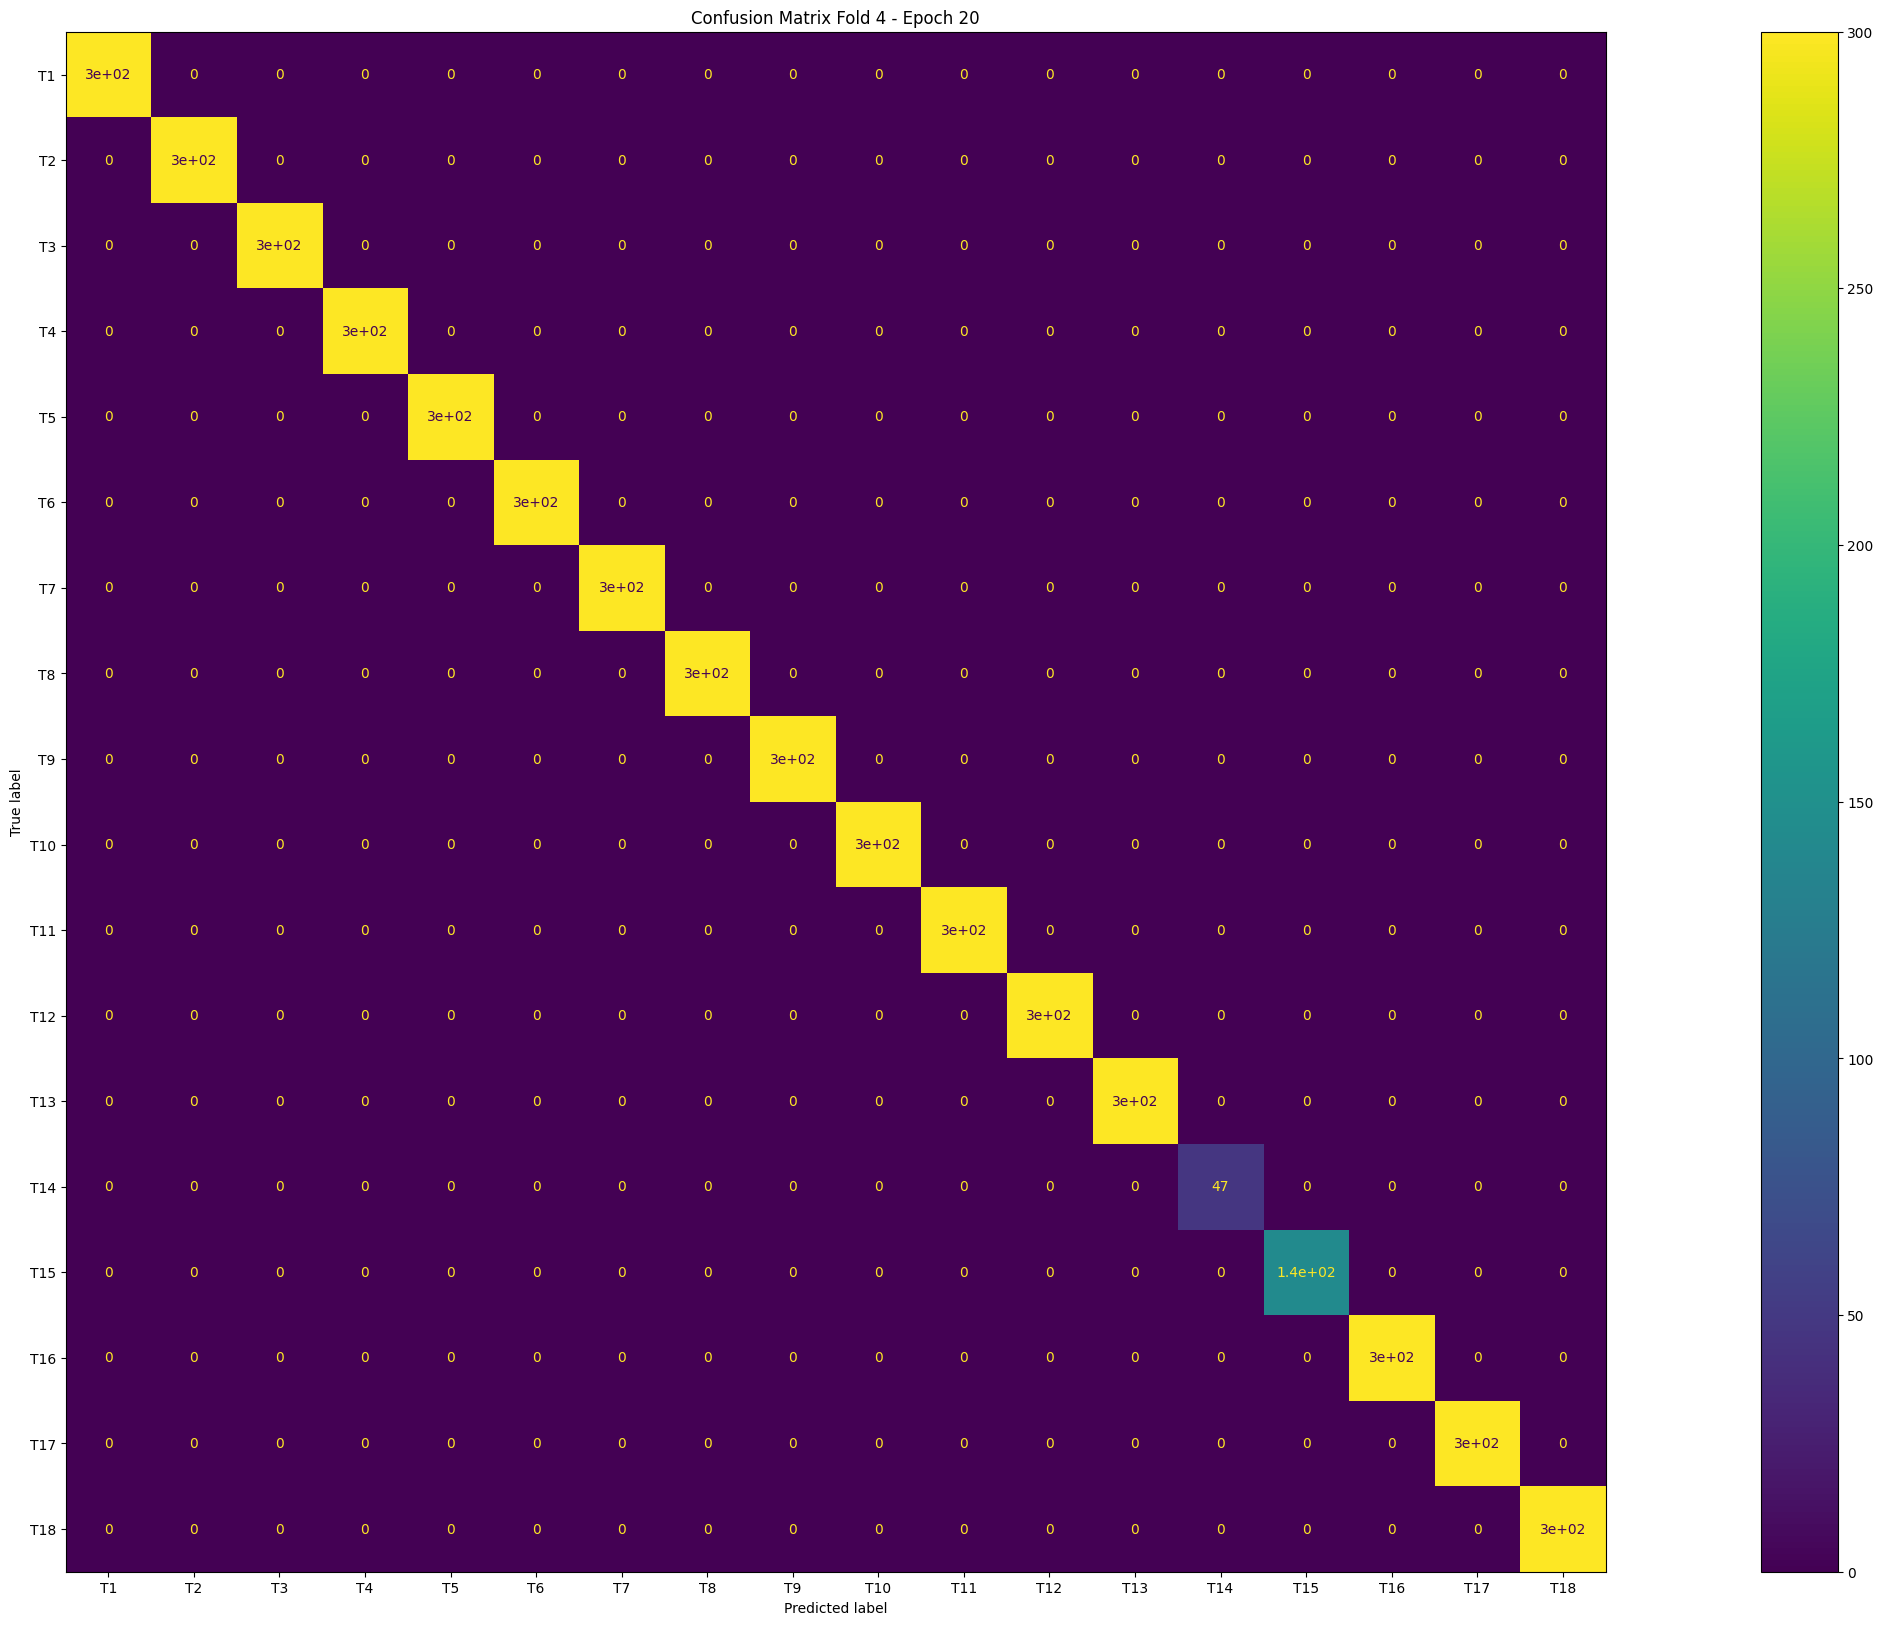

Amount of Data  Accuracy  Precision  Recall  F One
T1            300.0       1.0        1.0     1.0    1.0
T2            300.0       1.0        1.0     1.0    1.0
T3            300.0       1.0        1.0     1.0    1.0
T4            300.0       1.0        1.0     1.0    1.0
T5            300.0       1.0        1.0     1.0    1.0
T6            300.0       1.0        1.0     1.0    1.0
T7            300.0       1.0        1.0     1.0    1.0
T8            300.0       1.0        1.0     1.0    1.0
T9            300.0       1.0        1.0     1.0    1.0
T10           300.0       1.0        1.0     1.0    1.0
T11           300.0       1.0        1.0     1.0    1.0
T12           300.0       1.0        1.0     1.0    1.0
T13           300.0       1.0        1.0     1.0    1.0
T14            47.0       1.0        1.0     1.0    1.0
T15           143.0       1.0        1.0     1.0    1.0
T16           300.0       1.0        1.0     1.0    1.0
T17           300.0       1.0        1.0     1.0    1.0
T18           300.0       1.0        1.0     1.0    1.0

100%|███████████████████████████████████████████| 20/20 [04:47<00:00, 14.39s/it]
4it [19:09, 289.07s/it]/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


=====:=====:=====:=====:===== Fold 5 =====:=====:=====:=====:=====


4it [19:17, 289.07s/it]

Fold 5 Ready


  0%|                                                    | 0/20 [00:00<?, ?it/s]

Epoch 1 / 20


==:==:==Train==:==:==: 0it [00:11, ?it/s]


Average Loss Train: 0.03157809847468192


==:==:==Valid==:==:==: 0it [00:02, ?it/s]
  5%|██▏                                         | 1/20 [00:13<04:13, 13.34s/it]

Average Loss Validation: 0.012335358700436914
Time 13.332802534103394

Epoch 2 / 20


==:==:==Train==:==:==: 0it [00:11, ?it/s]


Average Loss Train: 0.010789054266992358


==:==:==Valid==:==:==: 0it [00:02, ?it/s]
 10%|████▍                                       | 2/20 [00:26<03:59, 13.33s/it]

Average Loss Validation: 0.004260710428257982
Time 13.308716058731079

Epoch 3 / 20


==:==:==Train==:==:==: 0it [00:10, ?it/s]


Average Loss Train: 0.005606985343439618


==:==:==Valid==:==:==: 0it [00:02, ?it/s]
 15%|██████▌                                     | 3/20 [00:39<03:46, 13.30s/it]

Average Loss Validation: 0.0023123222505879067
Time 13.26026177406311

Epoch 4 / 20


==:==:==Train==:==:==: 0it [00:11, ?it/s]


Average Loss Train: 0.003776896001998686


==:==:==Valid==:==:==: 0it [00:02, ?it/s]
 20%|████████▊                                   | 4/20 [00:53<03:32, 13.29s/it]

Average Loss Validation: 0.0015718023649198497
Time 13.274793148040771

Epoch 5 / 20


==:==:==Train==:==:==: 0it [00:10, ?it/s]


Average Loss Train: 0.002791658889661481


==:==:==Valid==:==:==: 0it [00:02, ?it/s]


Average Loss Validation: 0.0011667672283424881
Time 13.225838661193848



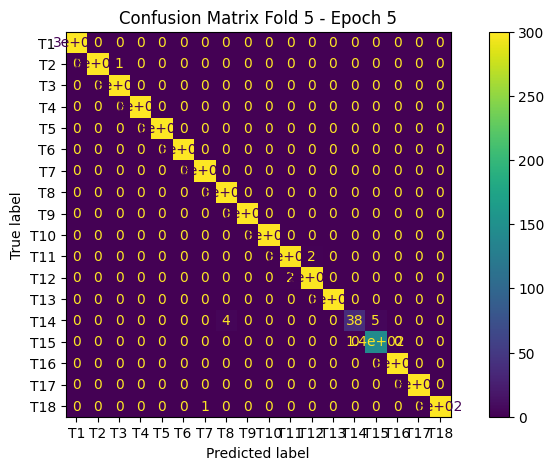

Amount of Data  Accuracy  Precision    Recall     F One
T1            300.0  1.000000   1.000000  1.000000  1.000000
T2            300.0  0.996667   1.000000  0.996667  0.998331
T3            300.0  1.000000   0.996678  1.000000  0.998336
T4            300.0  1.000000   1.000000  1.000000  1.000000
T5            300.0  1.000000   1.000000  1.000000  1.000000
T6            300.0  1.000000   1.000000  1.000000  1.000000
T7            300.0  1.000000   0.996678  1.000000  0.998336
T8            300.0  1.000000   0.986842  1.000000  0.993377
T9            300.0  1.000000   1.000000  1.000000  1.000000
T10           300.0  1.000000   1.000000  1.000000  1.000000
T11           300.0  0.993333   0.993333  0.993333  0.993333
T12           300.0  0.993333   0.993333  0.993333  0.993333
T13           300.0  1.000000   1.000000  1.000000  1.000000
T14            47.0  0.808511   1.000000  0.808511  0.894118
T15           143.0  1.000000   0.966216  1.000000  0.982818
T16           300.0  1.000000   1.000000  1.000000  1.000000
T17           300.0  1.000000   1.000000  1.000000  1.000000
T18           300.0  0.996667   1.000000  0.996667  0.998331

 25%|███████████                                 | 5/20 [01:10<03:41, 14.75s/it]

Epoch 6 / 20


==:==:==Train==:==:==: 0it [00:10, ?it/s]


Average Loss Train: 0.002203448202703061


==:==:==Valid==:==:==: 0it [00:02, ?it/s]
 30%|█████████████▏                              | 6/20 [01:23<03:19, 14.22s/it]

Average Loss Validation: 0.0009569855619647459
Time 13.176973342895508

Epoch 7 / 20


==:==:==Train==:==:==: 0it [00:10, ?it/s]


Average Loss Train: 0.0018127319779002375


==:==:==Valid==:==:==: 0it [00:02, ?it/s]
 35%|███████████████▍                            | 7/20 [01:36<03:00, 13.88s/it]

Average Loss Validation: 0.0007987279549450101
Time 13.160037755966187

Epoch 8 / 20


==:==:==Train==:==:==: 0it [00:10, ?it/s]


Average Loss Train: 0.0015652493544937786


==:==:==Valid==:==:==: 0it [00:02, ?it/s]
 40%|█████████████████▌                          | 8/20 [01:49<02:43, 13.59s/it]

Average Loss Validation: 0.0007123526140957892
Time 12.953075647354126

Epoch 9 / 20


==:==:==Train==:==:==: 0it [00:10, ?it/s]


Average Loss Train: 0.0013904006924316153


==:==:==Valid==:==:==: 0it [00:02, ?it/s]
 45%|███████████████████▊                        | 9/20 [02:03<02:28, 13.46s/it]

Average Loss Validation: 0.0006132243936489484
Time 13.178993225097656

Epoch 10 / 20


==:==:==Train==:==:==: 0it [00:10, ?it/s]


Average Loss Train: 0.0012162258661639553


==:==:==Valid==:==:==: 0it [00:02, ?it/s]


Average Loss Validation: 0.000551110652381767
Time 12.99846625328064



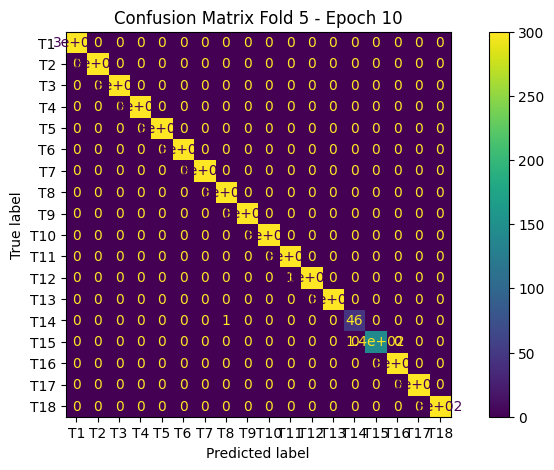

Amount of Data  Accuracy  Precision    Recall     F One
T1            300.0  1.000000   1.000000  1.000000  1.000000
T2            300.0  1.000000   1.000000  1.000000  1.000000
T3            300.0  1.000000   1.000000  1.000000  1.000000
T4            300.0  1.000000   1.000000  1.000000  1.000000
T5            300.0  1.000000   1.000000  1.000000  1.000000
T6            300.0  1.000000   1.000000  1.000000  1.000000
T7            300.0  1.000000   1.000000  1.000000  1.000000
T8            300.0  1.000000   0.996678  1.000000  0.998336
T9            300.0  1.000000   1.000000  1.000000  1.000000
T10           300.0  1.000000   1.000000  1.000000  1.000000
T11           300.0  1.000000   0.996678  1.000000  0.998336
T12           300.0  0.996667   1.000000  0.996667  0.998331
T13           300.0  1.000000   1.000000  1.000000  1.000000
T14            47.0  0.978723   1.000000  0.978723  0.989247
T15           143.0  1.000000   1.000000  1.000000  1.000000
T16           300.0  1.000000   1.000000  1.000000  1.000000
T17           300.0  1.000000   1.000000  1.000000  1.000000
T18           300.0  1.000000   1.000000  1.000000  1.000000

 50%|█████████████████████▌                     | 10/20 [02:21<02:29, 14.93s/it]

Epoch 11 / 20


==:==:==Train==:==:==: 0it [00:11, ?it/s]


Average Loss Train: 0.0011103045678522141


==:==:==Valid==:==:==: 0it [00:02, ?it/s]
 55%|███████████████████████▋                   | 11/20 [02:34<02:09, 14.43s/it]

Average Loss Validation: 0.0004948296347158944
Time 13.300947427749634

Epoch 12 / 20


==:==:==Train==:==:==: 0it [00:11, ?it/s]


Average Loss Train: 0.0009906606230899533


==:==:==Valid==:==:==: 0it [00:02, ?it/s]
 60%|█████████████████████████▊                 | 12/20 [02:47<01:52, 14.08s/it]

Average Loss Validation: 0.0004486480264930066
Time 13.260700702667236

Epoch 13 / 20


==:==:==Train==:==:==: 0it [00:10, ?it/s]


Average Loss Train: 0.0008944883507013285


==:==:==Valid==:==:==: 0it [00:02, ?it/s]
 65%|███████████████████████████▉               | 13/20 [03:01<01:36, 13.82s/it]

Average Loss Validation: 0.0004140530083933192
Time 13.20746111869812

Epoch 14 / 20


==:==:==Train==:==:==: 0it [00:10, ?it/s]


Average Loss Train: 0.0008282705889150211


==:==:==Valid==:==:==: 0it [00:02, ?it/s]
 70%|██████████████████████████████             | 14/20 [03:14<01:21, 13.65s/it]

Average Loss Validation: 0.0003834352580333998
Time 13.25088119506836

Epoch 15 / 20


==:==:==Train==:==:==: 0it [00:11, ?it/s]


Average Loss Train: 0.0007371619779721666


==:==:==Valid==:==:==: 0it [00:02, ?it/s]


Average Loss Validation: 0.00035796652143011115
Time 13.37605357170105



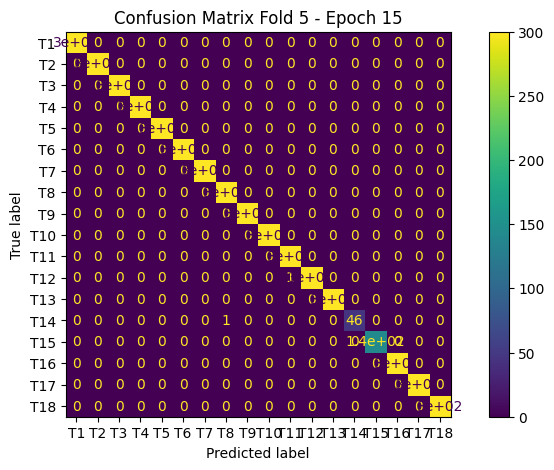

Amount of Data  Accuracy  Precision    Recall     F One
T1            300.0  1.000000   1.000000  1.000000  1.000000
T2            300.0  1.000000   1.000000  1.000000  1.000000
T3            300.0  1.000000   1.000000  1.000000  1.000000
T4            300.0  1.000000   1.000000  1.000000  1.000000
T5            300.0  1.000000   1.000000  1.000000  1.000000
T6            300.0  1.000000   1.000000  1.000000  1.000000
T7            300.0  1.000000   1.000000  1.000000  1.000000
T8            300.0  1.000000   0.996678  1.000000  0.998336
T9            300.0  1.000000   1.000000  1.000000  1.000000
T10           300.0  1.000000   1.000000  1.000000  1.000000
T11           300.0  1.000000   0.996678  1.000000  0.998336
T12           300.0  0.996667   1.000000  0.996667  0.998331
T13           300.0  1.000000   1.000000  1.000000  1.000000
T14            47.0  0.978723   1.000000  0.978723  0.989247
T15           143.0  1.000000   1.000000  1.000000  1.000000
T16           300.0  1.000000   1.000000  1.000000  1.000000
T17           300.0  1.000000   1.000000  1.000000  1.000000
T18           300.0  1.000000   1.000000  1.000000  1.000000

 75%|████████████████████████████████▎          | 15/20 [03:32<01:15, 15.01s/it]

Epoch 16 / 20


==:==:==Train==:==:==: 0it [00:10, ?it/s]


Average Loss Train: 0.0006979485514329876


==:==:==Valid==:==:==: 0it [00:02, ?it/s]
 80%|██████████████████████████████████▍        | 16/20 [03:45<00:57, 14.45s/it]

Average Loss Validation: 0.00032201190264466293
Time 13.142257690429688

Epoch 17 / 20


==:==:==Train==:==:==: 0it [00:10, ?it/s]


Average Loss Train: 0.0006485838280860733


==:==:==Valid==:==:==: 0it [00:02, ?it/s]
 85%|████████████████████████████████████▌      | 17/20 [03:58<00:42, 14.05s/it]

Average Loss Validation: 0.0002913620625295954
Time 13.1246657371521

Epoch 18 / 20


==:==:==Train==:==:==: 0it [00:10, ?it/s]


Average Loss Train: 0.0005941968609966488


==:==:==Valid==:==:==: 0it [00:02, ?it/s]
 90%|██████████████████████████████████████▋    | 18/20 [04:12<00:27, 13.82s/it]

Average Loss Validation: 0.00027241144396499066
Time 13.256779193878174

Epoch 19 / 20


==:==:==Train==:==:==: 0it [00:11, ?it/s]


Average Loss Train: 0.0005621939886712782


==:==:==Valid==:==:==: 0it [00:02, ?it/s]
 95%|████████████████████████████████████████▊  | 19/20 [04:25<00:13, 13.69s/it]

Average Loss Validation: 0.0002513325271123875
Time 13.391810655593872

Epoch 20 / 20


==:==:==Train==:==:==: 0it [00:10, ?it/s]


Average Loss Train: 0.000543419299328544


==:==:==Valid==:==:==: 0it [00:02, ?it/s]


Average Loss Validation: 0.00024185267637272874
Time 13.249028444290161



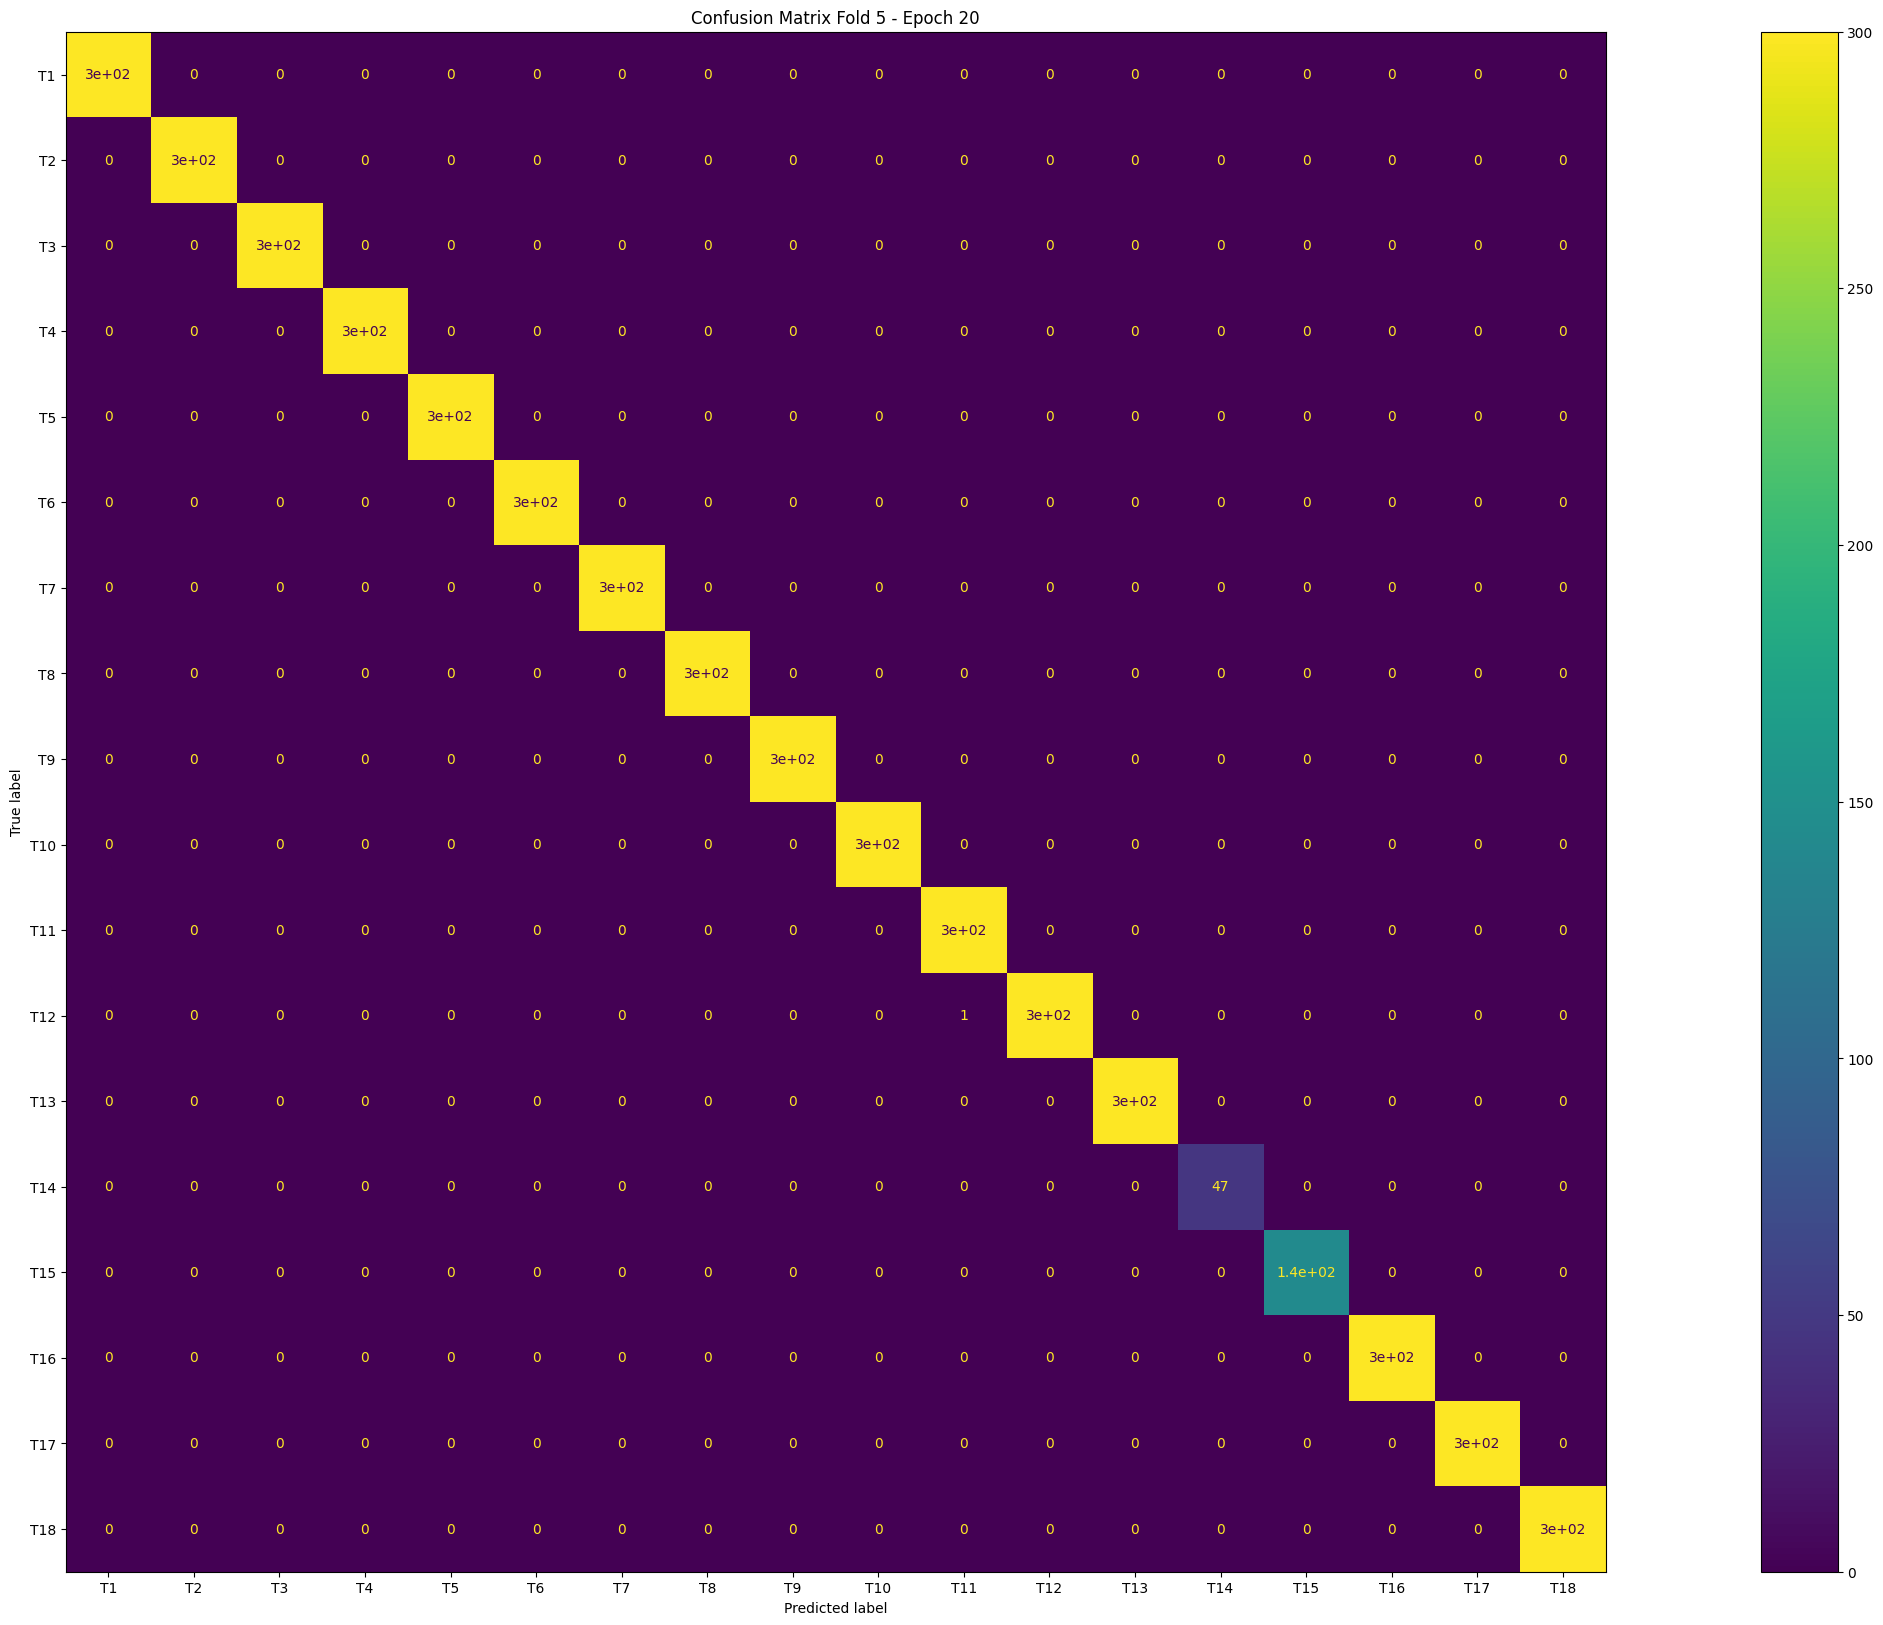

Amount of Data  Accuracy  Precision    Recall     F One
T1            300.0  1.000000   1.000000  1.000000  1.000000
T2            300.0  1.000000   1.000000  1.000000  1.000000
T3            300.0  1.000000   1.000000  1.000000  1.000000
T4            300.0  1.000000   1.000000  1.000000  1.000000
T5            300.0  1.000000   1.000000  1.000000  1.000000
T6            300.0  1.000000   1.000000  1.000000  1.000000
T7            300.0  1.000000   1.000000  1.000000  1.000000
T8            300.0  1.000000   1.000000  1.000000  1.000000
T9            300.0  1.000000   1.000000  1.000000  1.000000
T10           300.0  1.000000   1.000000  1.000000  1.000000
T11           300.0  1.000000   0.996678  1.000000  0.998336
T12           300.0  0.996667   1.000000  0.996667  0.998331
T13           300.0  1.000000   1.000000  1.000000  1.000000
T14            47.0  1.000000   1.000000  1.000000  1.000000
T15           143.0  1.000000   1.000000  1.000000  1.000000
T16           300.0  1.000000   1.000000  1.000000  1.000000
T17           300.0  1.000000   1.000000  1.000000  1.000000
T18           300.0  1.000000   1.000000  1.000000  1.000000

100%|███████████████████████████████████████████| 20/20 [04:44<00:00, 14.20s/it]
5it [24:02, 288.40s/it]


In [ ]:
import time
torch.manual_seed(12345)

# training image classification

LEARNING_RATE = 5e-5
EPOCH = 20

model.to(DEVICE)

training_losses = [[] for i in range(5)]
validation_losses = [[] for i in range(5)]

skf = StratifiedKFold(n_splits=5)

# Load before training + validing
for fold_i, (train_index, val_index) in enumerate(tqdm(skf.split(np.zeros(len(qa_dataset_train)), data_train_label), position=0, leave=True)):
  tqdm.write(f"=====:=====:=====:=====:===== Fold {fold_i + 1} =====:=====:=====:=====:=====")

  # Subset dataset for train and val
  train_dataset = Subset(qa_dataset_train, train_index)
  valid_dataset = Subset(qa_dataset_train, val_index)

  train_size = len(train_dataset)
  valid_size = len(valid_dataset)

  train_instances = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn_class)
  valid_instances = DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn_class)

  model_class = AutoModel.from_pretrained("indolem/indobert-base-uncased")
  bert_class = model_class
  model = BERT_Lexidqa2_class(bert_class, 768, 18)
  model.to(DEVICE)

  # optimizer
  optimizer = torch.optim.AdamW(model.parameters(), lr = LEARNING_RATE)

  tqdm.write(f'Fold {fold_i + 1} Ready')

  for epoch_i in tqdm(range(0, EPOCH), position=0, leave=True):
    start = time.time()
    tqdm.write(f"Epoch {epoch_i + 1} / {EPOCH}")

    # Freeze all layers
    for param in model.parameters():
        param.requires_grad = False

    # Unfreeze last layer
    for param in model.bert.encoder.layer[11].parameters():
        param.requires_grad = True

    # Reset the total loss for this epoch.
    tr_loss = 0

    # Put the model into training mode.
    model.train()

    # Untuk setiap data di training data
    train_total_data = train_size
    train_pbar = tqdm(desc="==:==:==Train==:==:==", position=0, leave=True)
    for data in train_instances:

      # Mendapatkan output dari model
      input, gold = data
      input = input.to(DEVICE)
      gold = gold.to(DEVICE)
      pred = model(input)

      # Categorical Cross-Entropy --- Loss Function
      loss = loss_func(pred, gold)

      # Agar gradient tidak menumpuk; ini diperlukan sebelum
      # menghitung gradient dengan loss.backward()
      optimizer.zero_grad()

      # hitung gradient
      loss.backward()

      # update parameter
      optimizer.step()

      # akumulasi loss dalam 1 epoch
      tr_loss += loss.item()

      # train_pbar.update(len(data))

    # rata-rata loss dalam 1 epoch
    avg_loss = tr_loss / train_total_data

    training_losses[fold_i].append(avg_loss)

    train_pbar.write(f"Average Loss Train: {avg_loss}")

    train_pbar.close()

    ### Uji coba di Validation Data

    # model eval, agar layer seperti dropout yang menghasilkan
    # sesuai yang random tidak digunakan
    model.eval()

    val_loss = 0
    pred_labels = []
    true_labels = []

    # Untuk setiap batch di validation data
    valid_total_data = valid_size
    valid_pbar = tqdm(desc="==:==:==Valid==:==:==", position=0, leave=True)
    for data in valid_instances:

      # jangan track gradient! ini sedang evaluasi, bukan training
      with torch.no_grad():

        # Mendapatkan output dari model
        input, gold = data
        input = input.to(DEVICE)
        gold = gold.to(DEVICE)
        pred = model(input)

        # Categorical Cross-Entropy --- Loss Function
        loss = loss_func(pred, gold)

        # akumulasi loss di validation set
        val_loss += loss.item()

        # valid_pbar.update(len(data))


    # average loss
    avg_val_loss = val_loss / valid_total_data

    validation_losses[fold_i].append(avg_val_loss)

    valid_pbar.write(f"Average Loss Validation: {avg_val_loss}")

    end = time.time()
    valid_pbar.write("Time " + str(end-start))
    valid_pbar.write("")
    valid_pbar.close()

    # accuracy
    # pred_labels = torch.stack(pred_labels).numpy()
    # true_labels = torch.stack(true_labels).numpy()
    # val_accuracy = np.sum(pred_labels == true_labels) / len(pred_labels)
    # print(f"Accuracy di validation data: {val_accuracy}")


    if (epoch_i + 1) % 5 == 0:
      nb_classes = 18

      conf_matrix = torch.zeros(nb_classes, nb_classes)
      with torch.no_grad():
        for i, (input, gold) in enumerate(valid_instances):
          input = input.to(DEVICE)
          gold = gold.to(DEVICE)
          pred = model(input)
          # _, gold = torch.max(gold, 1)
          # _, pred = torch.max(pred, 1)
          # for t, p in zip(gold.view(-1), pred.view(-1)):
          #   conf_matrix[t.long(), p.long()] += 1

          conf_matrix = confusion_matrix(gold, pred, conf_matrix)

      amt, acc, prec, rec, f1 = evaluation_metric(conf_matrix)
      data_conf = {
          'Amount of Data': amt,
          'Accuracy': acc,
          'Precision': prec,
          'Recall': rec,
          'F One': f1
      }


      fig, ax = _, _
      if (epoch_i + 1) != EPOCH:
        fig, ax = plt.subplots(figsize=(10, 5))
      else:
        fig, ax = plt.subplots(figsize=(40, 20))

      display_labels = ['T1', 'T2', 'T3', 'T4', 'T5', 'T6', 'T7', 'T8', 'T9', 'T10', 'T11', 'T12', 'T13', 'T14', 'T15', 'T16', 'T17', 'T18']
      disp = metrics.ConfusionMatrixDisplay(confusion_matrix=conf_matrix.detach().cpu().numpy(), display_labels=display_labels)
      disp.plot(ax=ax)
      plt.title(f"Confusion Matrix Fold {fold_i + 1} - Epoch {epoch_i + 1}")
      plt.show()

      disp_df = pd.DataFrame(data=data_conf,
                             index=display_labels, columns=['Amount of Data', 'Accuracy', 'Precision', 'Recall', 'F One'])
      display(disp_df)

      # for i, template_index in enumerate(display_labels):
      #   print(f"Evaluation for {template_index}:")
      #   print(f"Amount of Data: {amt[i]}")
      #   print(f"Accuracy: {acc[i]}")
      #   print(f"Precision: {prec[i]}")
      #   print(f"Recall: {rec[i]}")
      #   print(f"F One: {f1[i]}")
      #   print()

      model.to("cpu")

      save_path = 'model_indobert/class_tesaurus_checkpoint/fold_' + str(fold_i)
      if not os.path.exists(save_path):
        os.makedirs(save_path)
      model_class_path = os.path.join(save_path, "indobert_class_tesaurus_checkpoint_" + str(epoch_i) +".pth")
      torch.save(model, model_class_path)

      model.to(DEVICE)

### Visualize

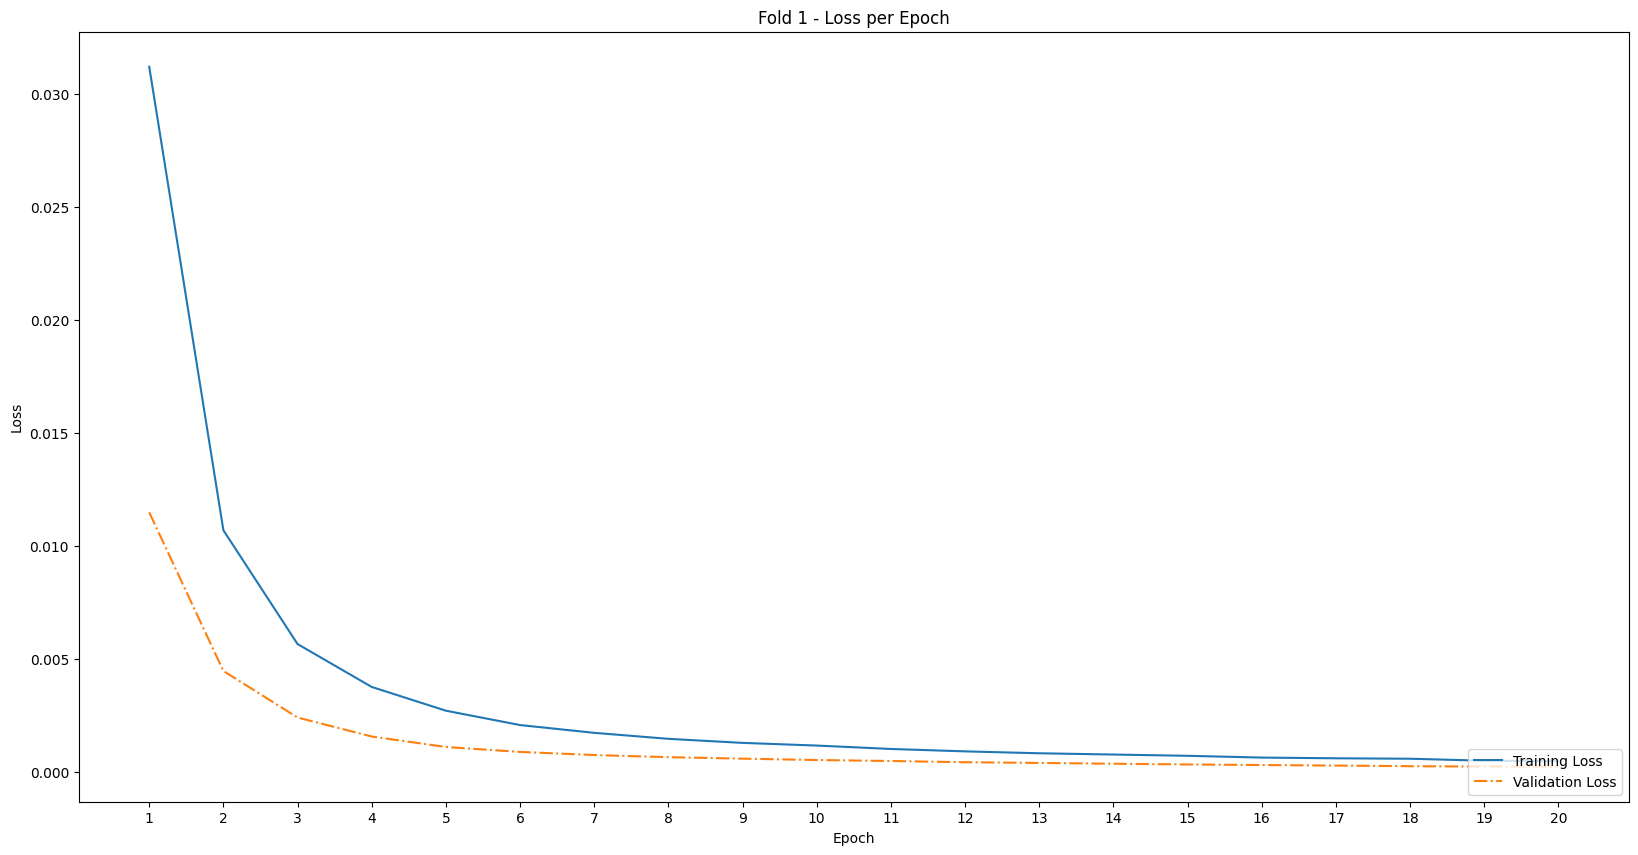

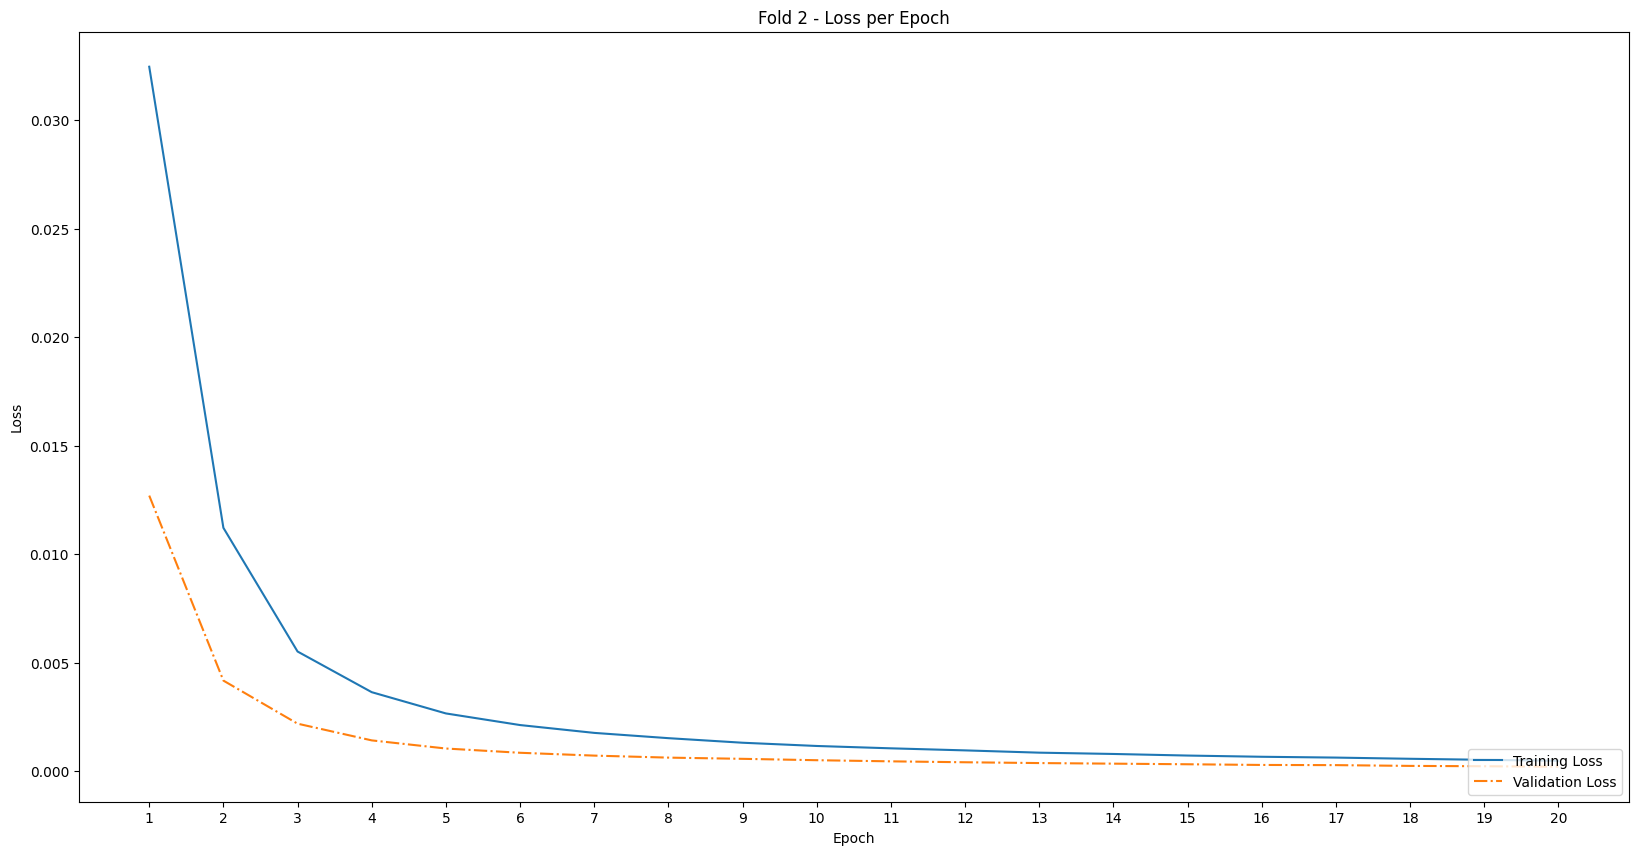

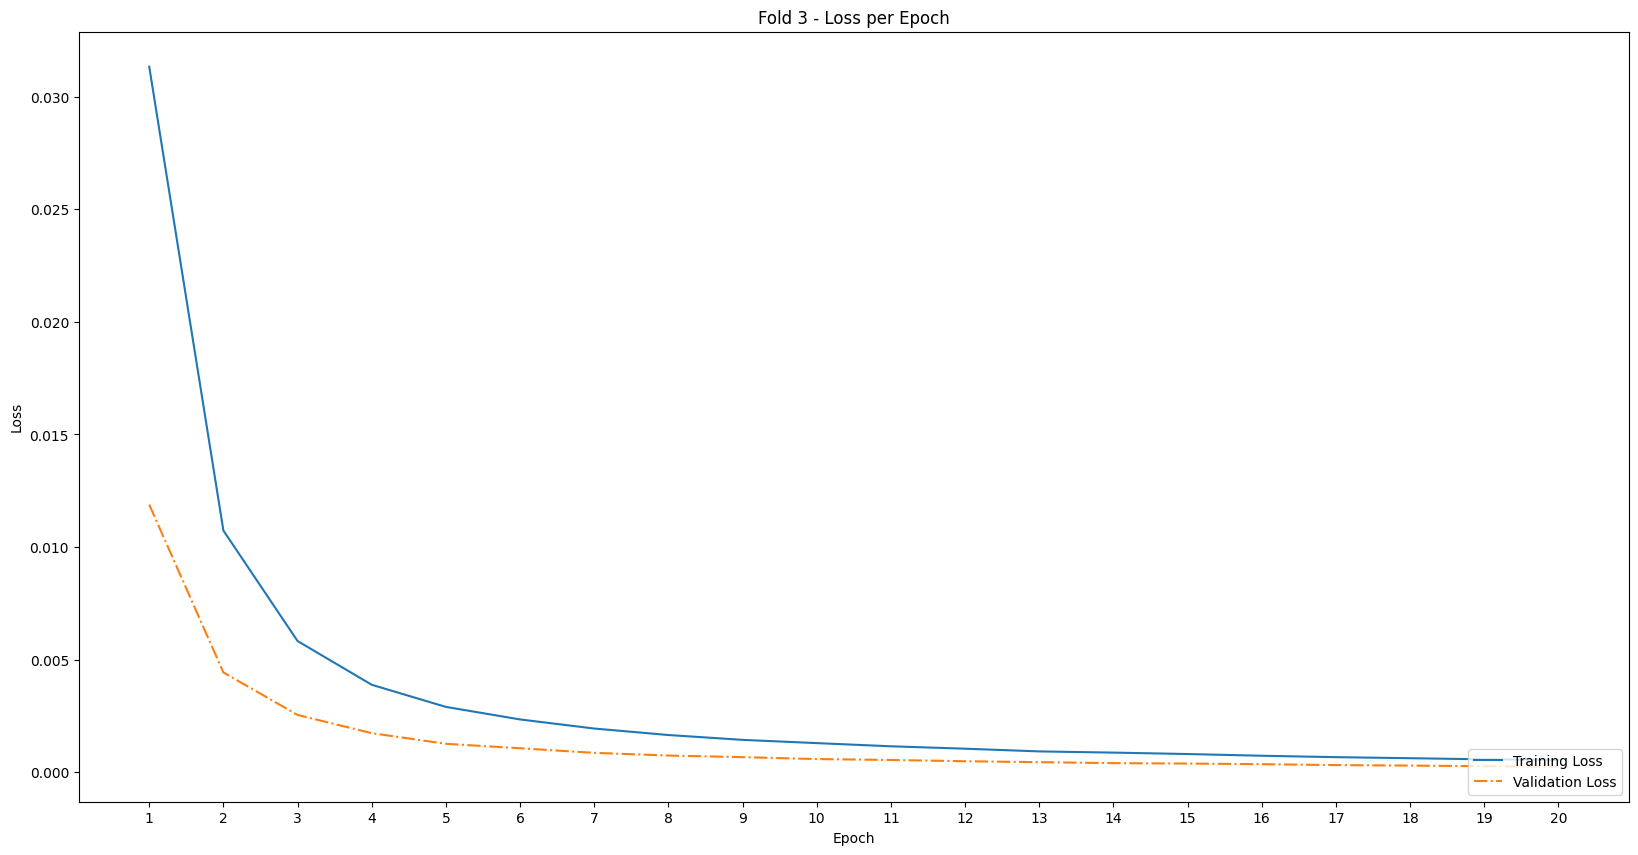

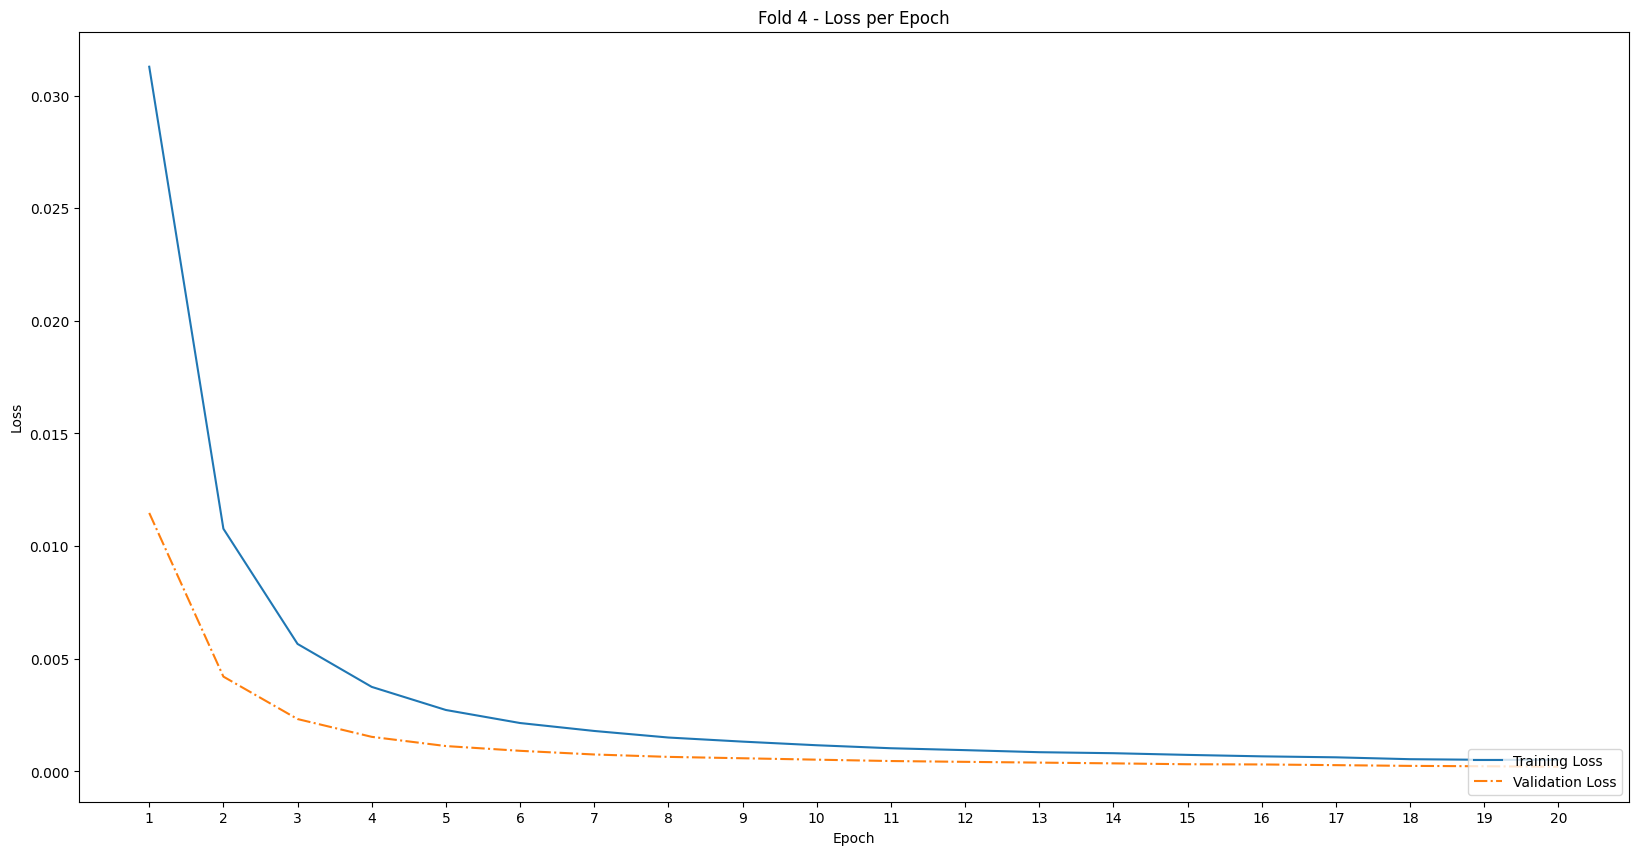

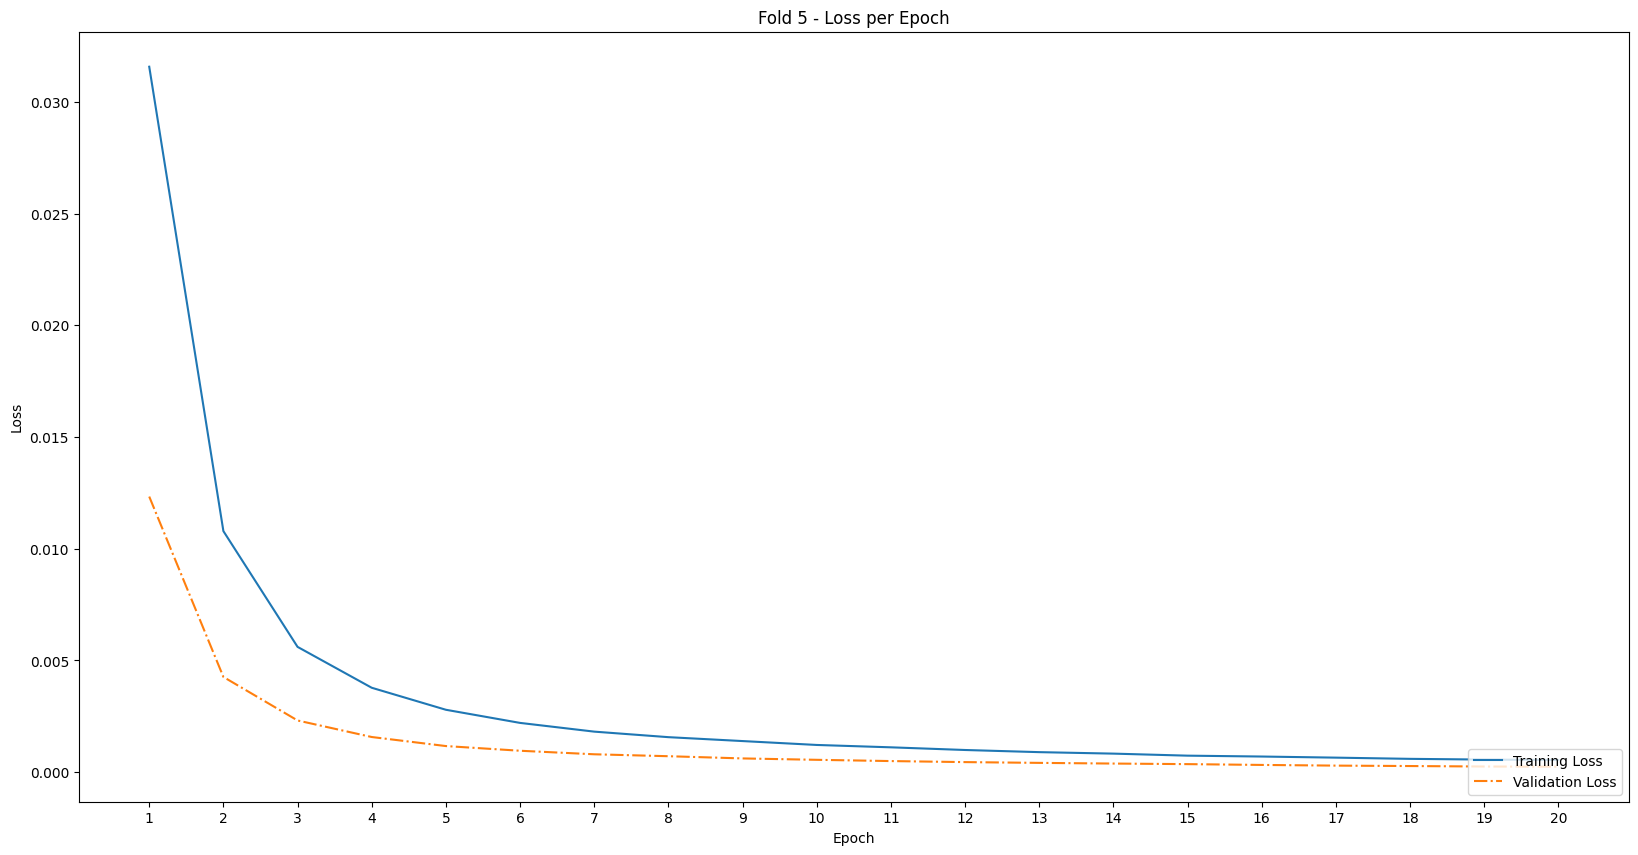

In [ ]:
for i in range(5):
  x = np.arange(1, 21)
  y_train_loss = np.asarray(training_losses[i], dtype=np.float32)
  y_val_loss = np.asarray(validation_losses[i], dtype=np.float32)

  plt.figure(figsize=(20,10))

  plt.plot(x, y_train_loss[0:20])
  plt.plot(x, y_val_loss[0:20], '-.')

  plt.xticks(np.arange(min(x), max(x)+1, 1.0))
  plt.legend(["Training Loss", "Validation Loss"], loc="lower right")

  plt.xlabel("Epoch")
  plt.ylabel("Loss")
  plt.title(f'Fold {i + 1} - Loss per Epoch')
  plt.show()

### Save Model

In [ ]:
# save_path = 'model/class/'
# !mkdir -p model/class/

# model_class_path = os.path.join(save_path, "indobert_class_tesaurus"+".pth")

# model.to('cpu')
# torch.save(model, model_class_path)

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


## Test


Average loss di testing data: 0.00021321967682602112


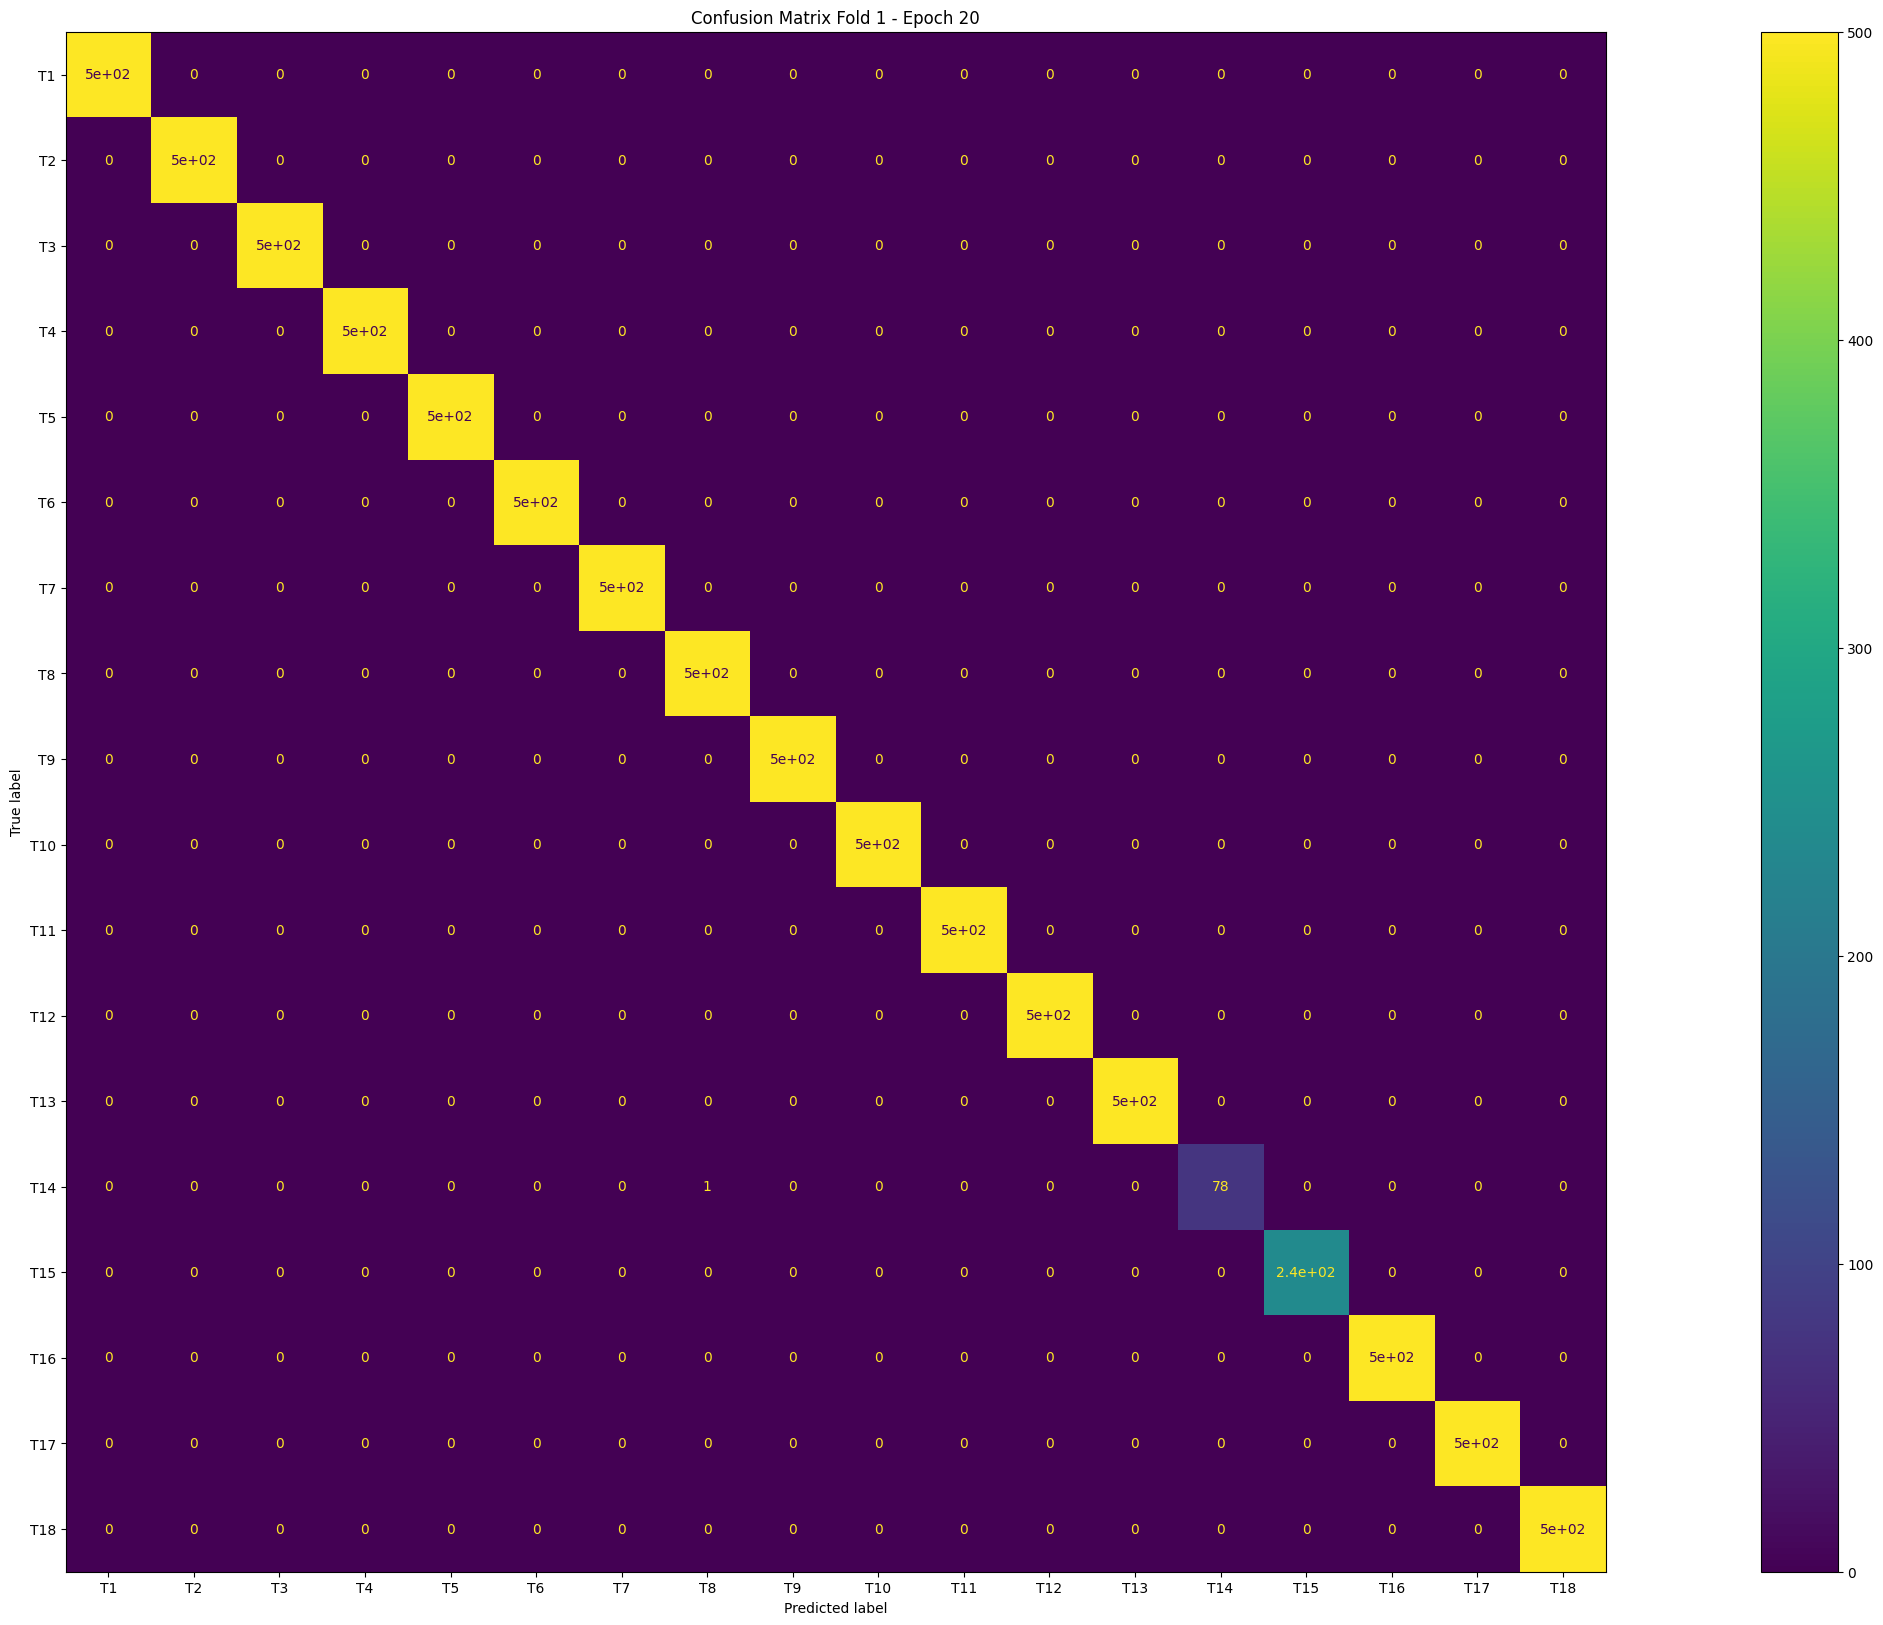

Amount of Data  Accuracy  Precision    Recall     F One
T1            500.0  1.000000   1.000000  1.000000  1.000000
T2            500.0  1.000000   1.000000  1.000000  1.000000
T3            500.0  1.000000   1.000000  1.000000  1.000000
T4            500.0  1.000000   1.000000  1.000000  1.000000
T5            500.0  1.000000   1.000000  1.000000  1.000000
T6            500.0  1.000000   1.000000  1.000000  1.000000
T7            500.0  1.000000   1.000000  1.000000  1.000000
T8            500.0  1.000000   0.998004  1.000000  0.999001
T9            500.0  1.000000   1.000000  1.000000  1.000000
T10           500.0  1.000000   1.000000  1.000000  1.000000
T11           500.0  1.000000   1.000000  1.000000  1.000000
T12           500.0  1.000000   1.000000  1.000000  1.000000
T13           500.0  1.000000   1.000000  1.000000  1.000000
T14            79.0  0.987342   1.000000  0.987342  0.993631
T15           239.0  1.000000   1.000000  1.000000  1.000000
T16           500.0  1.000000   1.000000  1.000000  1.000000
T17           500.0  1.000000   1.000000  1.000000  1.000000
T18           500.0  1.000000   1.000000  1.000000  1.000000


Average loss di testing data: 0.00021384367246801505


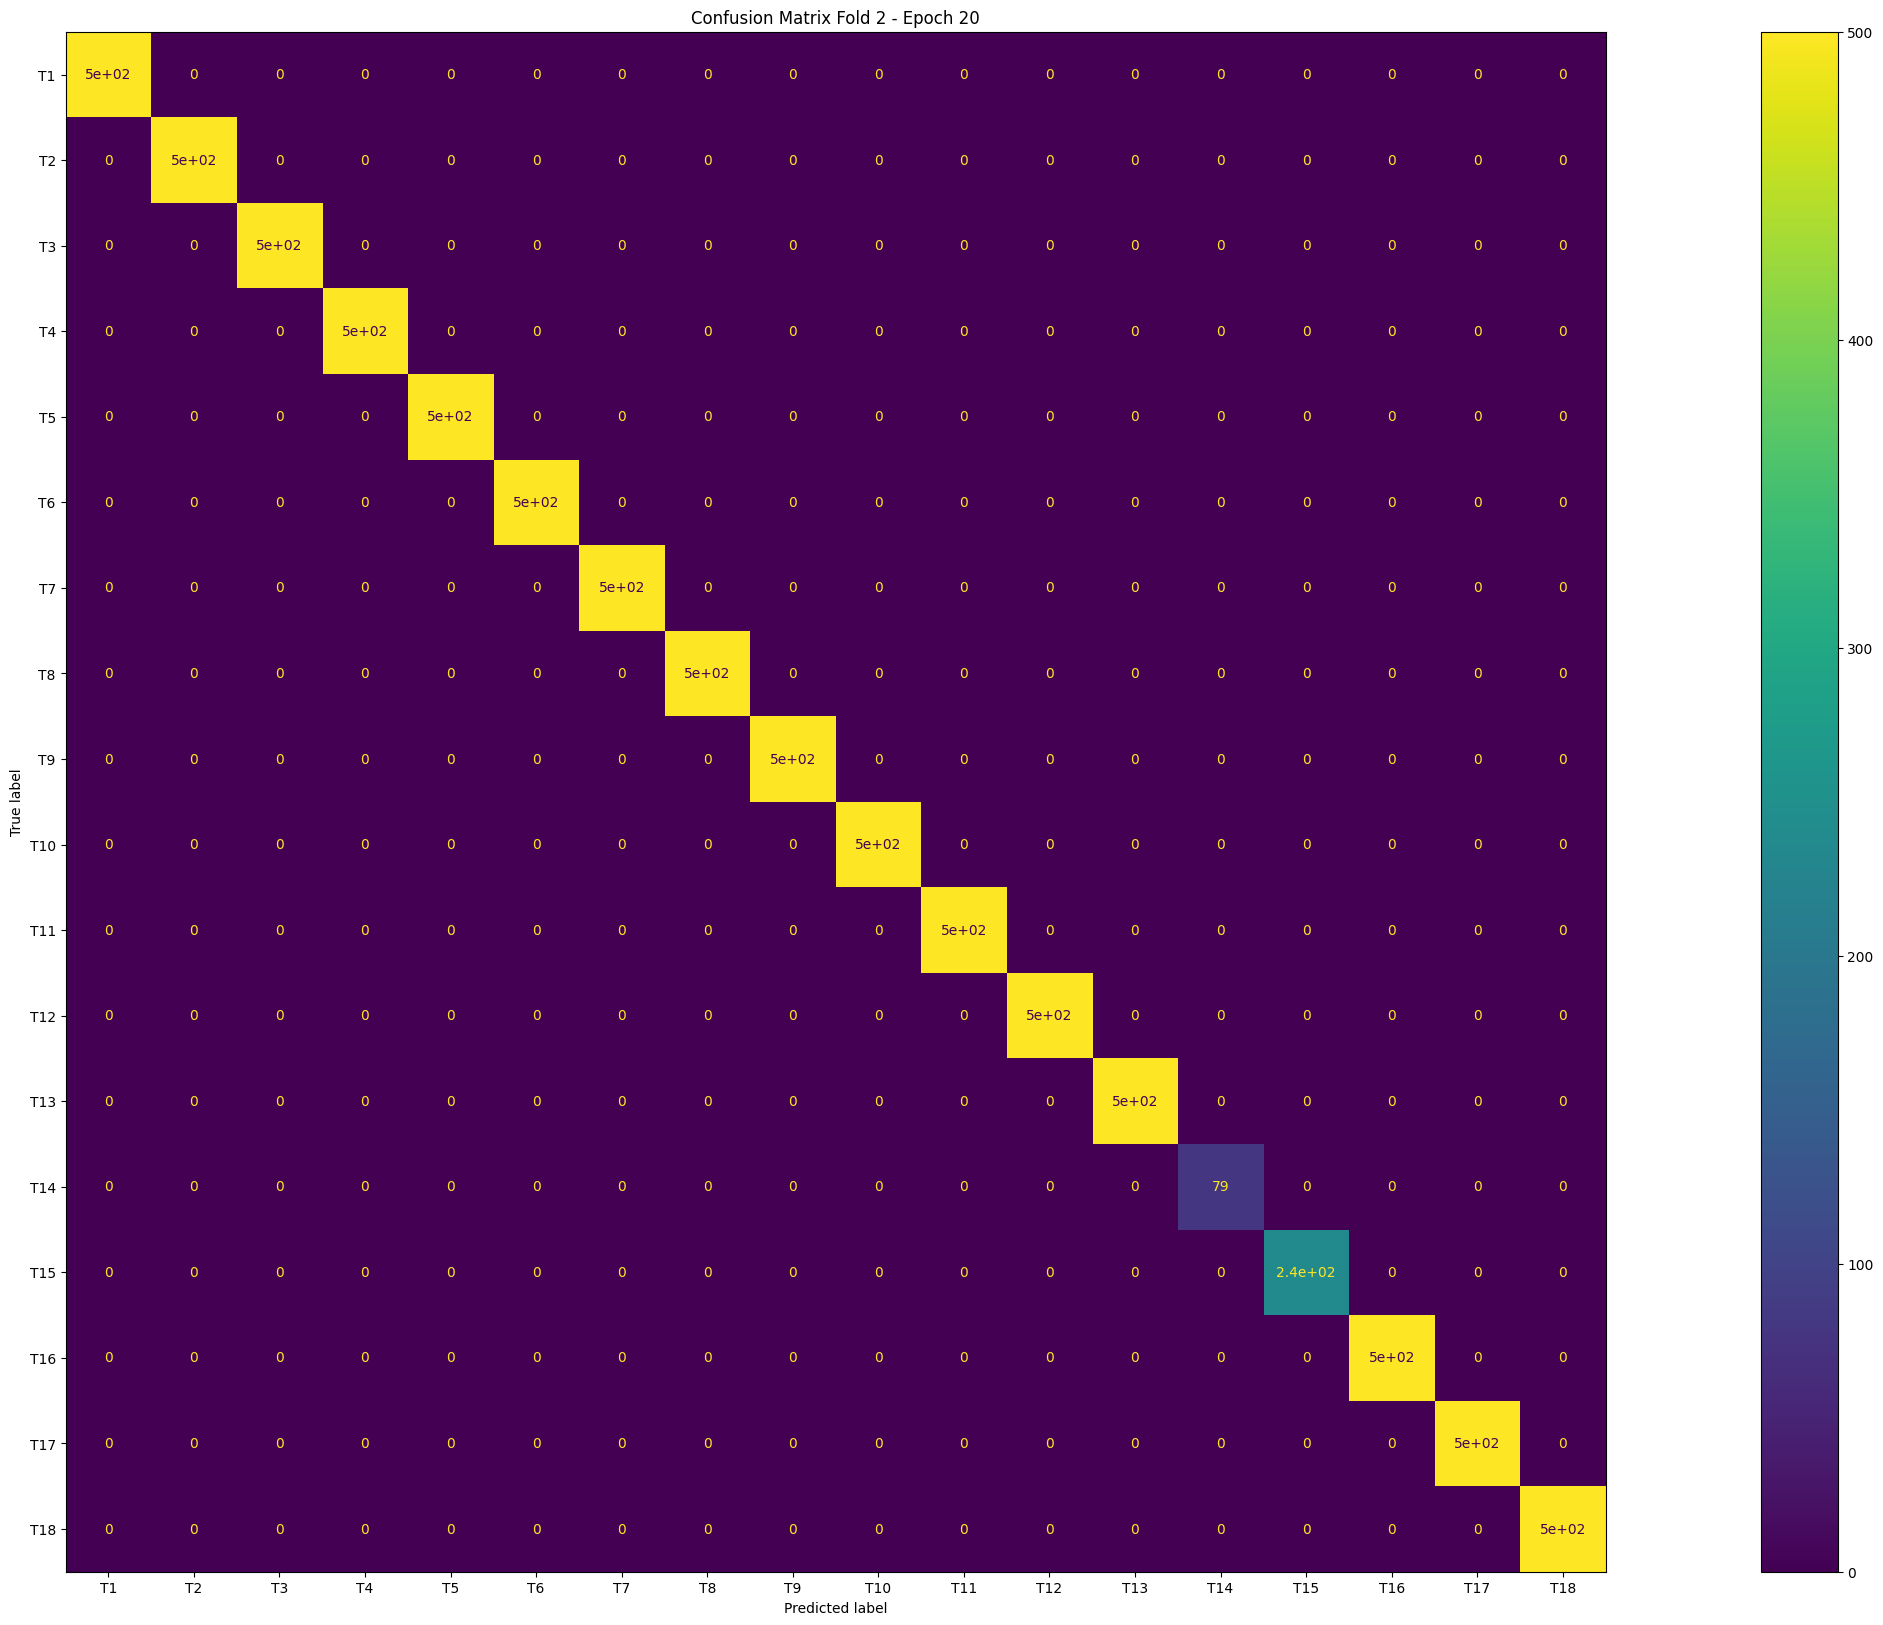

Amount of Data  Accuracy  Precision  Recall  F One
T1            500.0       1.0        1.0     1.0    1.0
T2            500.0       1.0        1.0     1.0    1.0
T3            500.0       1.0        1.0     1.0    1.0
T4            500.0       1.0        1.0     1.0    1.0
T5            500.0       1.0        1.0     1.0    1.0
T6            500.0       1.0        1.0     1.0    1.0
T7            500.0       1.0        1.0     1.0    1.0
T8            500.0       1.0        1.0     1.0    1.0
T9            500.0       1.0        1.0     1.0    1.0
T10           500.0       1.0        1.0     1.0    1.0
T11           500.0       1.0        1.0     1.0    1.0
T12           500.0       1.0        1.0     1.0    1.0
T13           500.0       1.0        1.0     1.0    1.0
T14            79.0       1.0        1.0     1.0    1.0
T15           239.0       1.0        1.0     1.0    1.0
T16           500.0       1.0        1.0     1.0    1.0
T17           500.0       1.0        1.0     1.0    1.0
T18           500.0       1.0        1.0     1.0    1.0


Average loss di testing data: 0.00023935232873550114


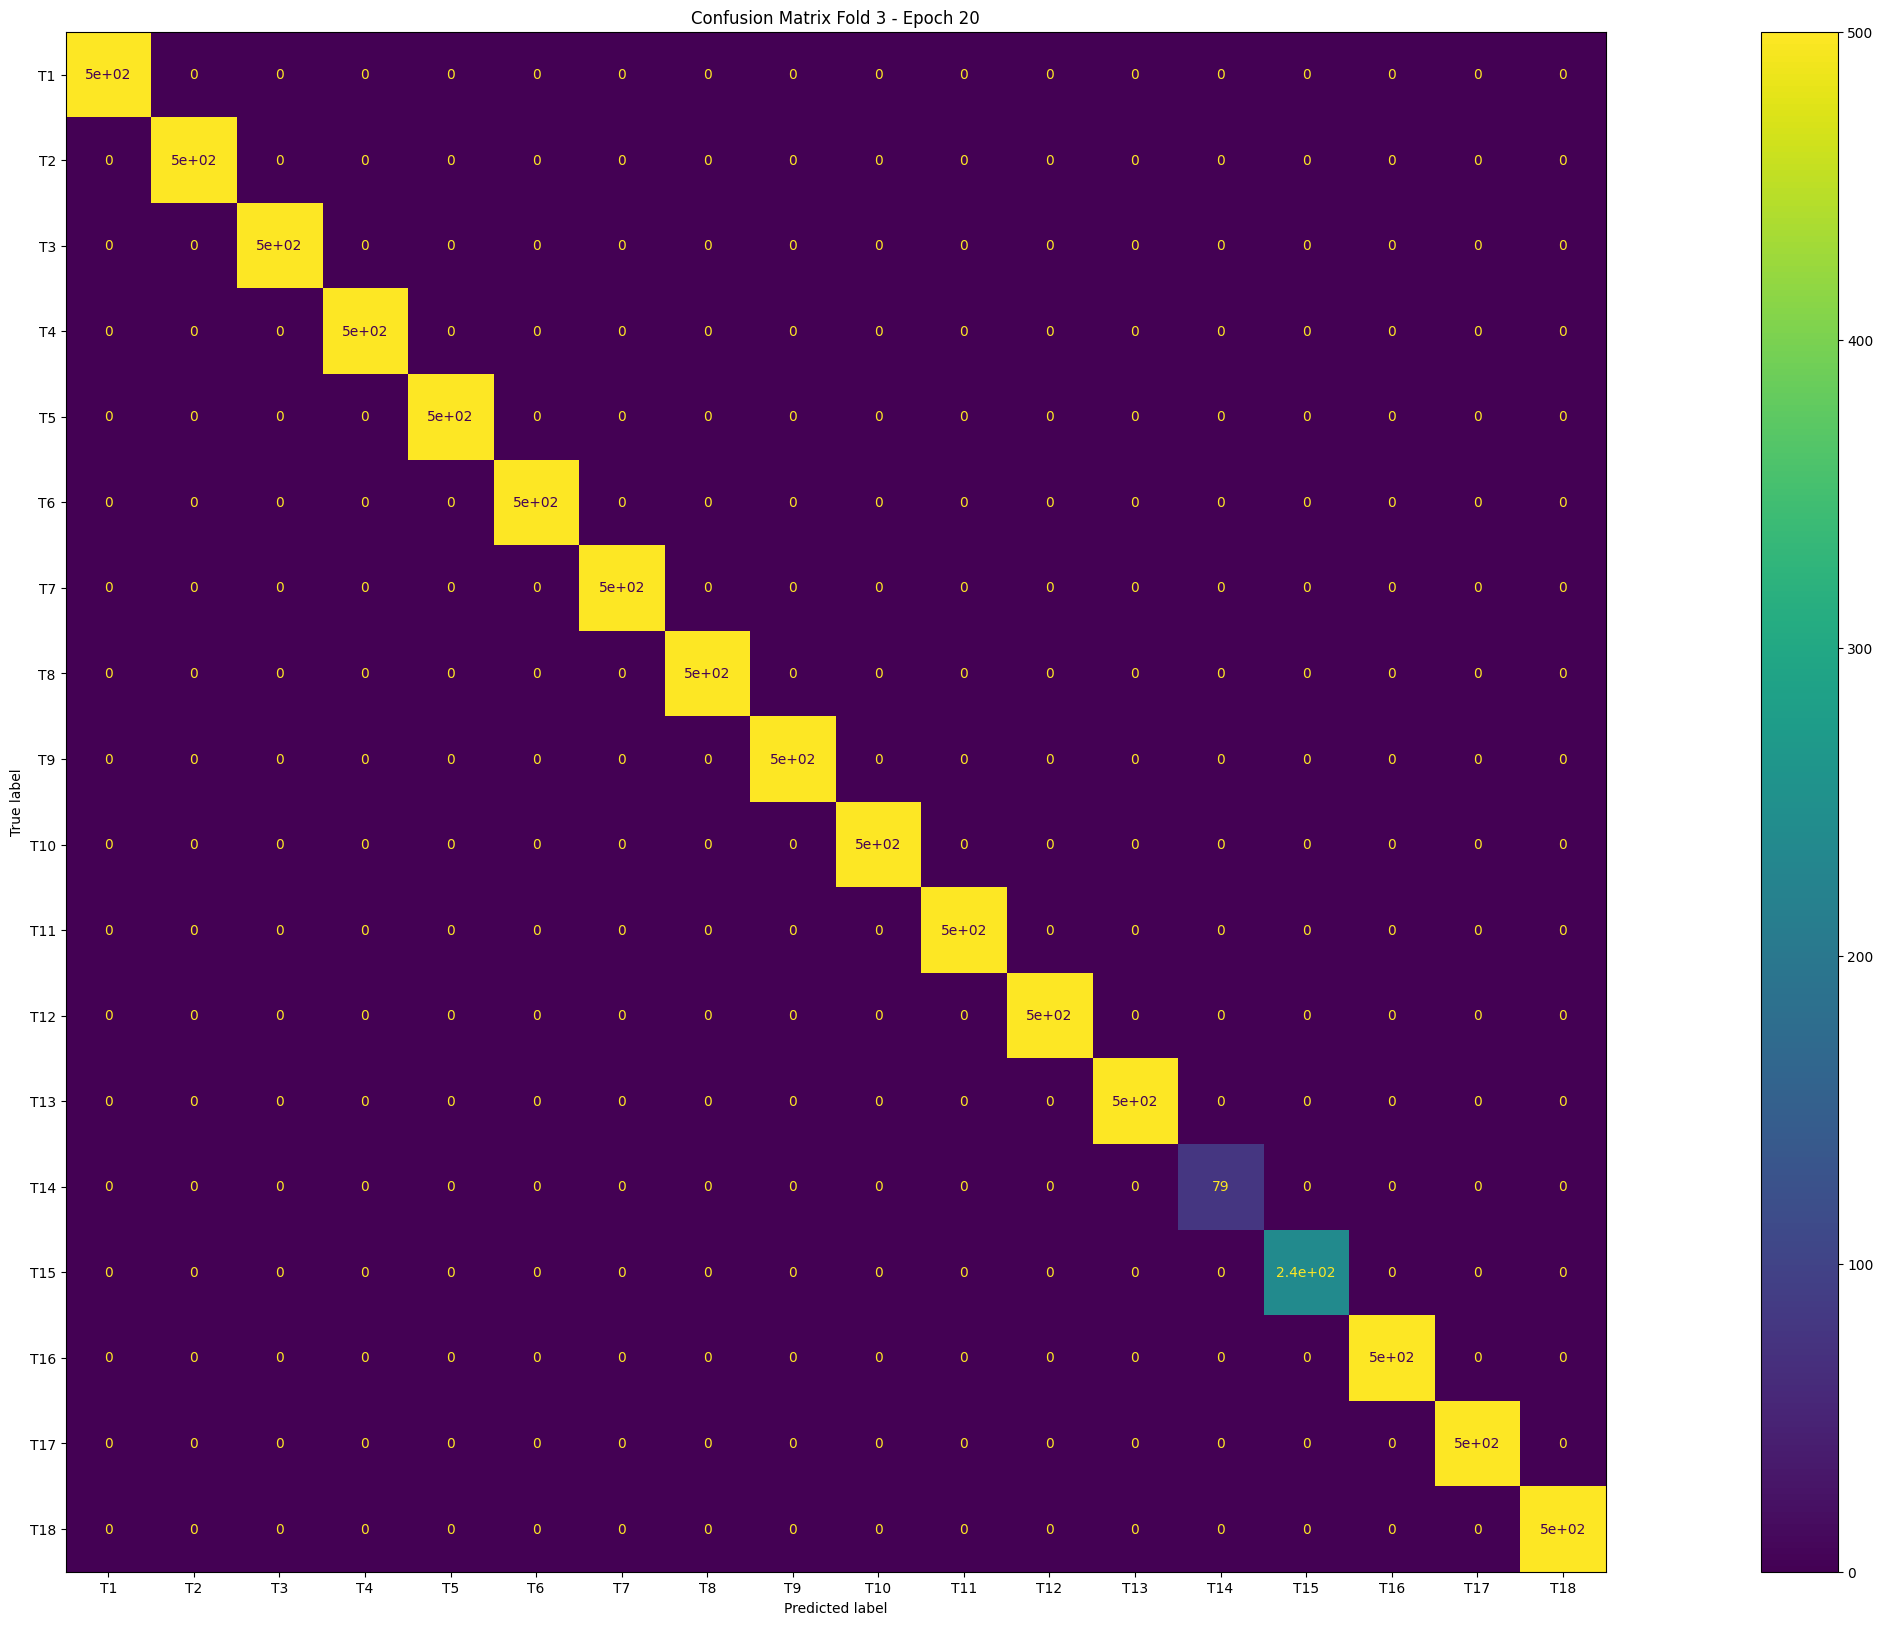

Amount of Data  Accuracy  Precision  Recall  F One
T1            500.0       1.0        1.0     1.0    1.0
T2            500.0       1.0        1.0     1.0    1.0
T3            500.0       1.0        1.0     1.0    1.0
T4            500.0       1.0        1.0     1.0    1.0
T5            500.0       1.0        1.0     1.0    1.0
T6            500.0       1.0        1.0     1.0    1.0
T7            500.0       1.0        1.0     1.0    1.0
T8            500.0       1.0        1.0     1.0    1.0
T9            500.0       1.0        1.0     1.0    1.0
T10           500.0       1.0        1.0     1.0    1.0
T11           500.0       1.0        1.0     1.0    1.0
T12           500.0       1.0        1.0     1.0    1.0
T13           500.0       1.0        1.0     1.0    1.0
T14            79.0       1.0        1.0     1.0    1.0
T15           239.0       1.0        1.0     1.0    1.0
T16           500.0       1.0        1.0     1.0    1.0
T17           500.0       1.0        1.0     1.0    1.0
T18           500.0       1.0        1.0     1.0    1.0


Average loss di testing data: 0.00020783532370104903


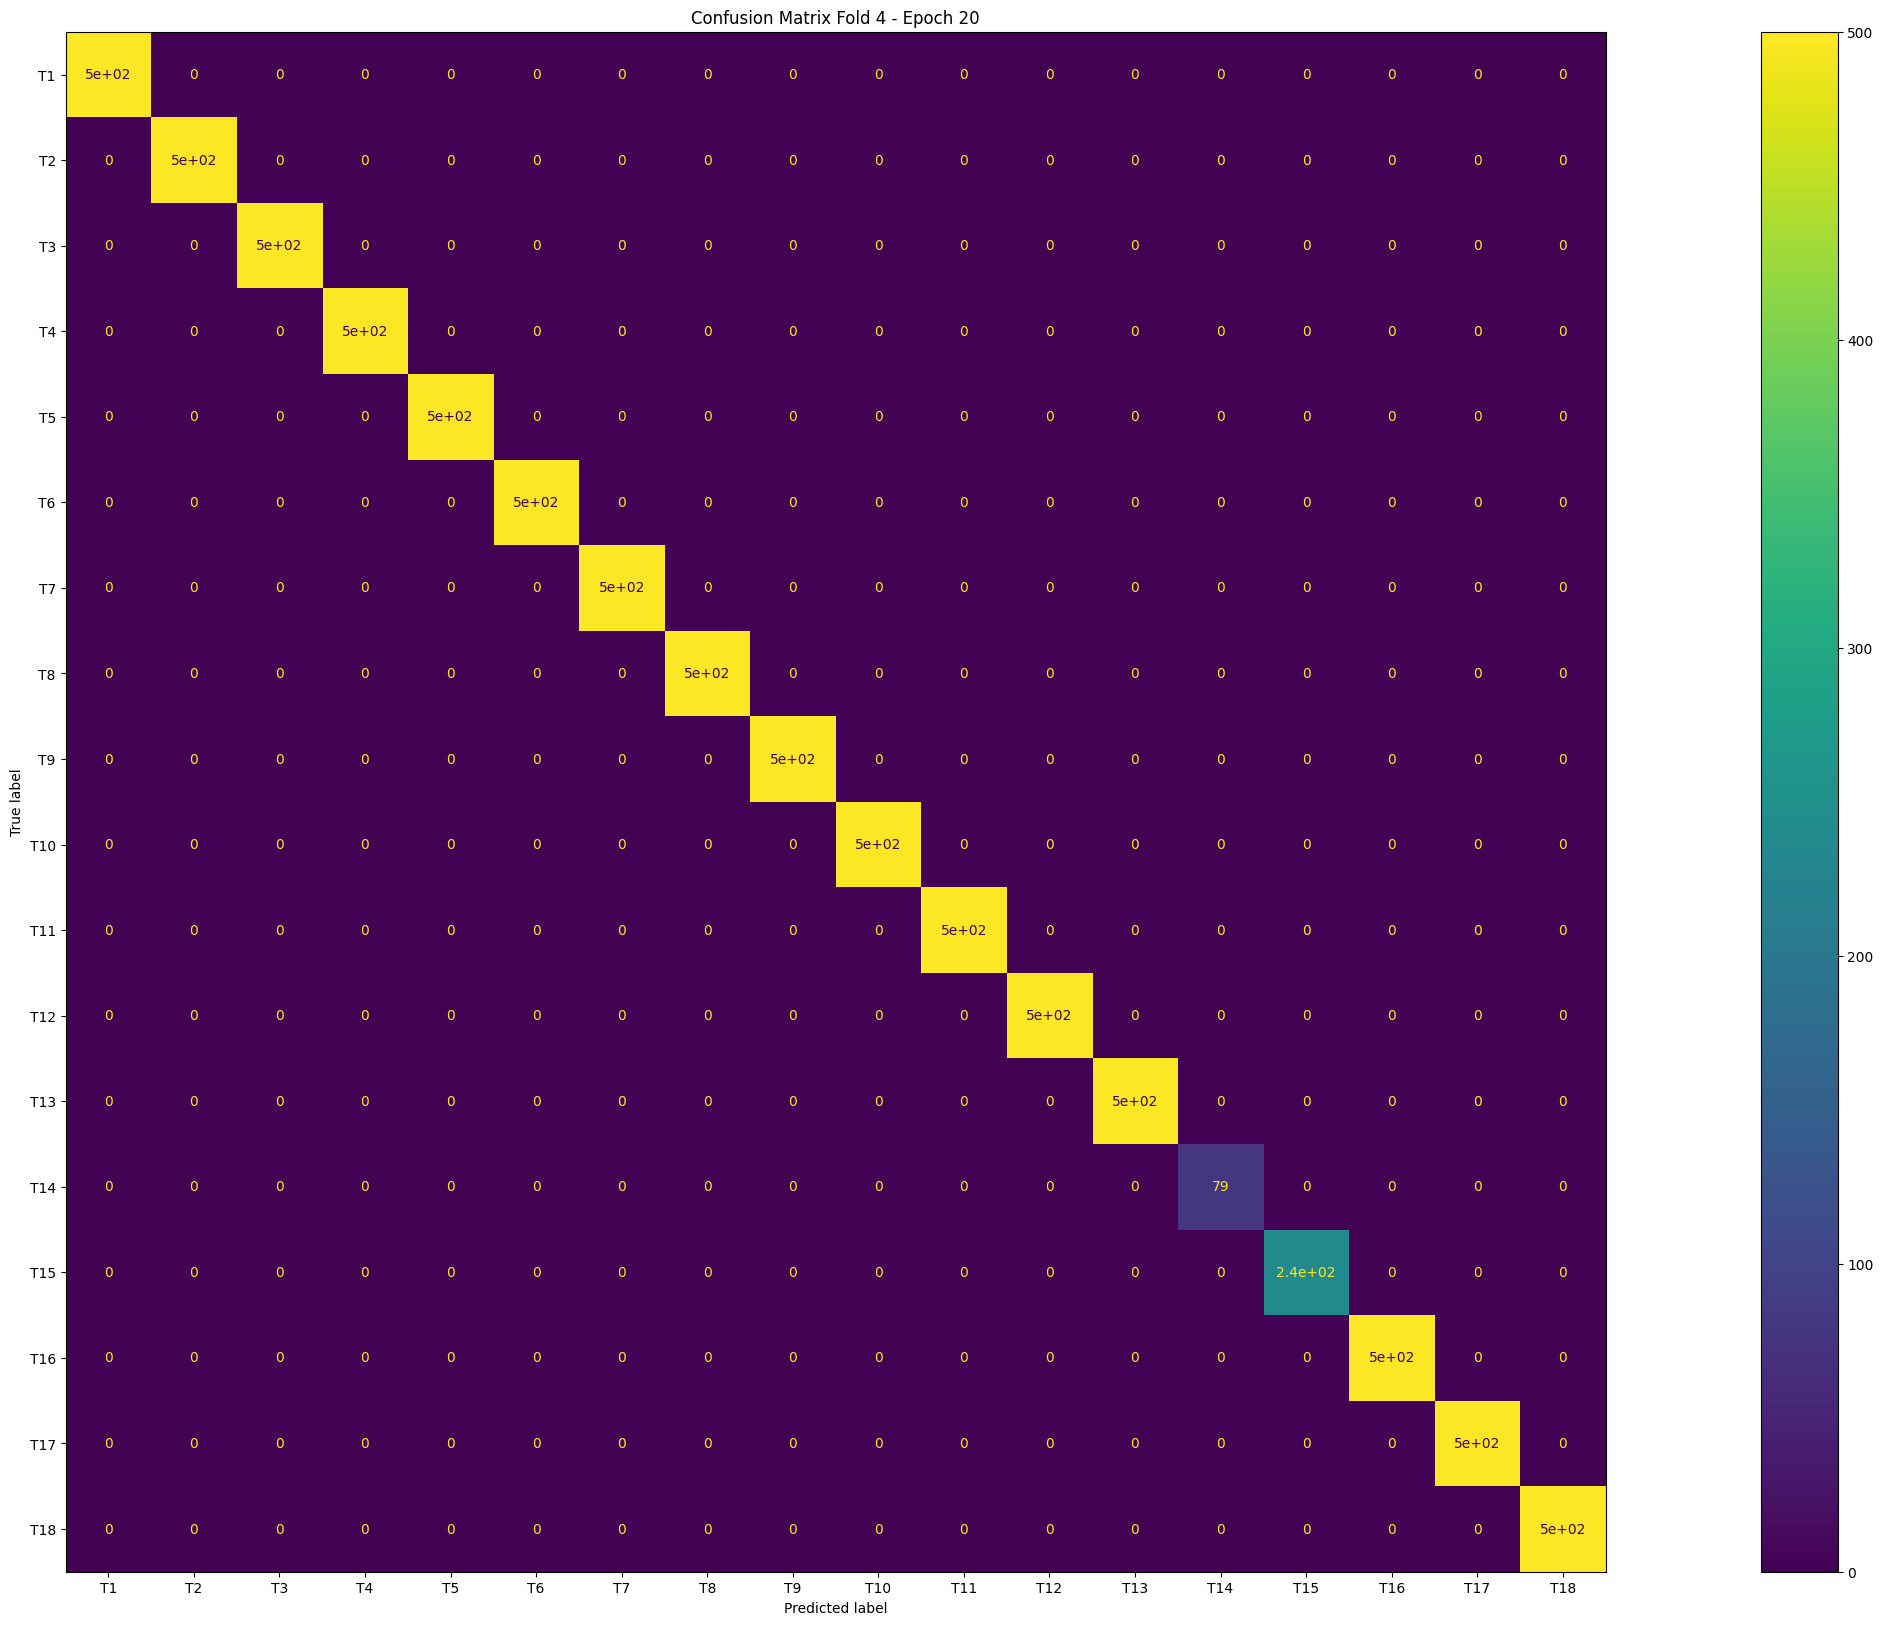

Amount of Data  Accuracy  Precision  Recall  F One
T1            500.0       1.0        1.0     1.0    1.0
T2            500.0       1.0        1.0     1.0    1.0
T3            500.0       1.0        1.0     1.0    1.0
T4            500.0       1.0        1.0     1.0    1.0
T5            500.0       1.0        1.0     1.0    1.0
T6            500.0       1.0        1.0     1.0    1.0
T7            500.0       1.0        1.0     1.0    1.0
T8            500.0       1.0        1.0     1.0    1.0
T9            500.0       1.0        1.0     1.0    1.0
T10           500.0       1.0        1.0     1.0    1.0
T11           500.0       1.0        1.0     1.0    1.0
T12           500.0       1.0        1.0     1.0    1.0
T13           500.0       1.0        1.0     1.0    1.0
T14            79.0       1.0        1.0     1.0    1.0
T15           239.0       1.0        1.0     1.0    1.0
T16           500.0       1.0        1.0     1.0    1.0
T17           500.0       1.0        1.0     1.0    1.0
T18           500.0       1.0        1.0     1.0    1.0


Average loss di testing data: 0.0002253772013505639


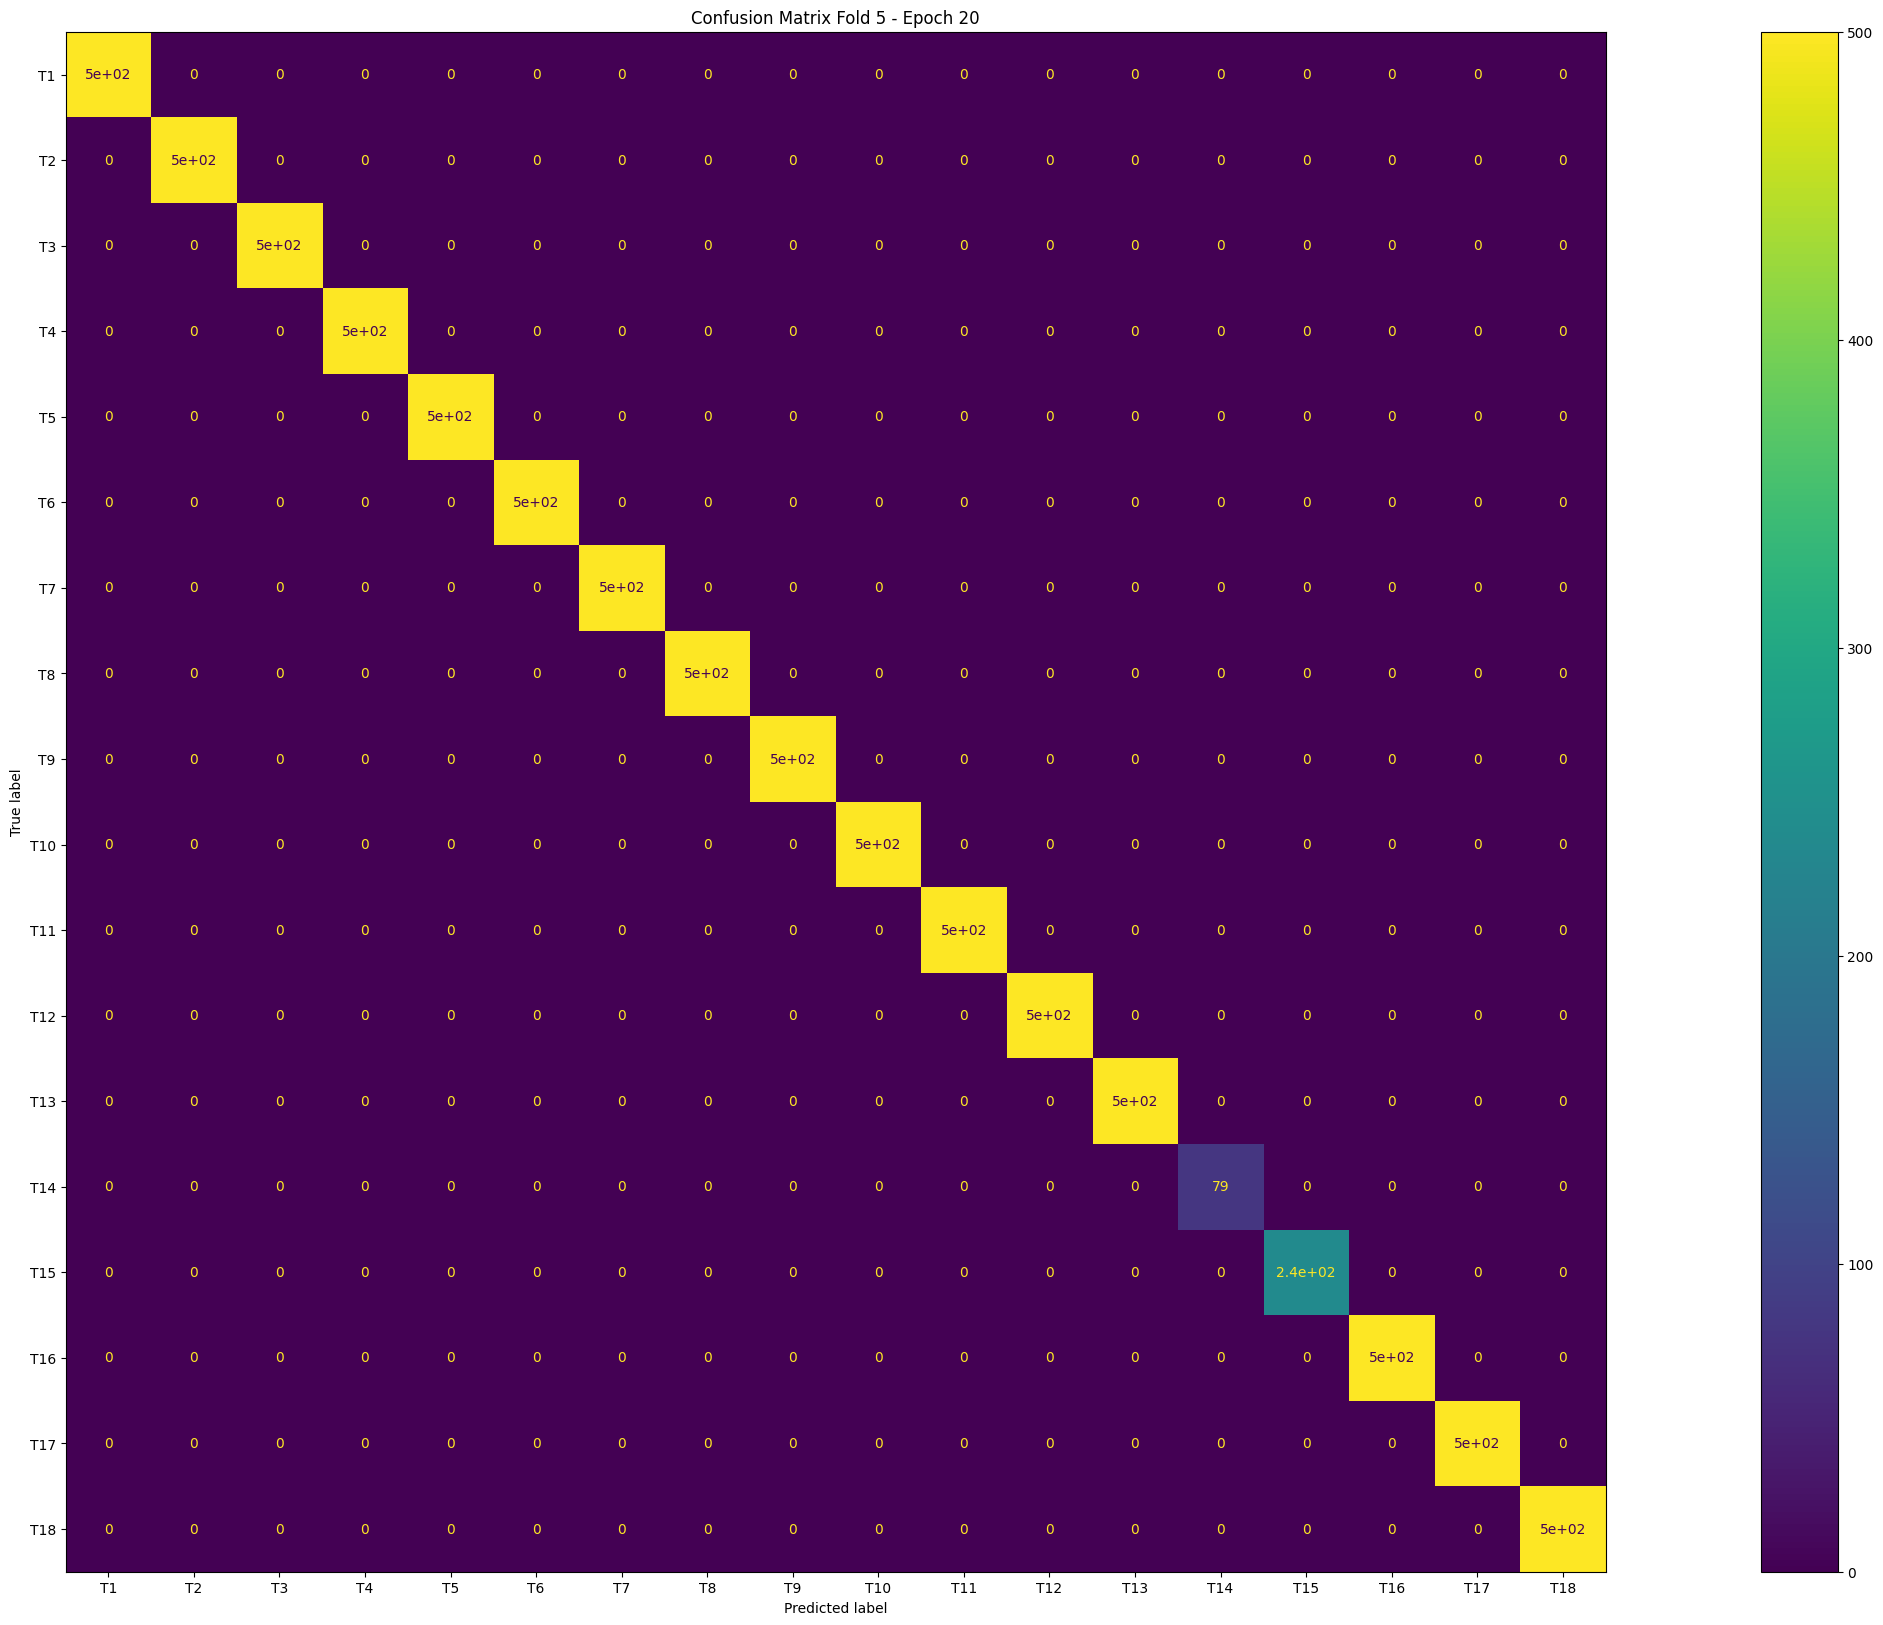

Amount of Data  Accuracy  Precision  Recall  F One
T1            500.0       1.0        1.0     1.0    1.0
T2            500.0       1.0        1.0     1.0    1.0
T3            500.0       1.0        1.0     1.0    1.0
T4            500.0       1.0        1.0     1.0    1.0
T5            500.0       1.0        1.0     1.0    1.0
T6            500.0       1.0        1.0     1.0    1.0
T7            500.0       1.0        1.0     1.0    1.0
T8            500.0       1.0        1.0     1.0    1.0
T9            500.0       1.0        1.0     1.0    1.0
T10           500.0       1.0        1.0     1.0    1.0
T11           500.0       1.0        1.0     1.0    1.0
T12           500.0       1.0        1.0     1.0    1.0
T13           500.0       1.0        1.0     1.0    1.0
T14            79.0       1.0        1.0     1.0    1.0
T15           239.0       1.0        1.0     1.0    1.0
T16           500.0       1.0        1.0     1.0    1.0
T17           500.0       1.0        1.0     1.0    1.0
T18           500.0       1.0        1.0     1.0    1.0

In [ ]:
for fold_i in range(5):

  tr_loss = 0

  save_path = 'model_indobert/class_tesaurus_checkpoint/fold_' + str(fold_i)
  model_class_path = os.path.join(save_path, "indobert_class_tesaurus_checkpoint_19.pth")
  model = torch.load(model_class_path)

  model.to(DEVICE)

  model.eval()

  nb_classes = 18

  true_recaps = [[] for i in range(5)]
  false_recaps = [[] for i in range(5)]

  conf_matrix = torch.zeros(nb_classes, nb_classes)
  # Untuk setiap data di training data
  for data in test_instances:

    with torch.no_grad():
      # Mendapatkan output dari model
      input, gold = data
      input = input.to(DEVICE)
      gold = gold.to(DEVICE)
      pred = model(input)

      # Categorical Cross-Entropy --- Loss Function
      loss = loss_func(pred, gold)
      # _, pred = torch.max(pred, 1)
        # for t, p in zip(gold.view(-1), pred.view(-1)):
        #   confusion_matrix[t.long(), p.long()] += 1

      # akumulasi loss dalam 1 epoch
      tr_loss += loss.item()

      conf_matrix = confusion_matrix(gold, pred, conf_matrix)

      for input_recap, gold_recap, pred_recap in zip(input.to('cpu'), gold.to('cpu'), pred.to('cpu')):
        input_recap_sentence = tokenizer.decode(input_recap)
        _, gold_idx = torch.max(gold_recap, 0)
        _, pred_idx = torch.max(pred_recap, 0)
        if gold_idx == pred_idx:
          true_recaps[fold_i].append((input_recap_sentence, gold_idx, pred_idx))
        else:
          false_recaps[fold_i].append((input_recap_sentence, gold_idx, pred_idx))

  amt, acc, prec, rec, f1 = evaluation_metric(conf_matrix)
  data_conf = {
          'Amount of Data': amt,
          'Accuracy': acc,
          'Precision': prec,
          'Recall': rec,
          'F One': f1
      }

  # rata-rata loss dalam 1 epoch
  avg_loss = tr_loss / test_size
  # accuracy = confusion_matrix.diag()/confusion_matrix.sum(1)

  print("")
  print(f"Average loss di testing data: {avg_loss}")

  fig, ax = plt.subplots(figsize=(40, 20))

  display_labels = ['T1', 'T2', 'T3', 'T4', 'T5', 'T6', 'T7', 'T8', 'T9', 'T10', 'T11', 'T12', 'T13', 'T14', 'T15', 'T16', 'T17', 'T18']
  disp = metrics.ConfusionMatrixDisplay(confusion_matrix=conf_matrix.detach().cpu().numpy(), display_labels=display_labels)
  disp.plot(ax=ax)
  plt.title(f"Confusion Matrix Fold {fold_i + 1} - Epoch 20")

  plt.show()

  disp_df = pd.DataFrame(data=data_conf,
                          index=display_labels, columns=['Amount of Data', 'Accuracy', 'Precision', 'Recall', 'F One'])
  display(disp_df)

In [ ]:
save_path = 'model_indobert/class_tesaurus_checkpoint/fold_3'
model_class_path = os.path.join(save_path, "indobert_class_tesaurus_checkpoint_19.pth")
model = torch.load(model_class_path)

# bert_class = model_class

save_path = 'model/class/'
!mkdir -p model/class/
model_class_path = os.path.join(save_path, "indobert_class_tesaurus"+".pth")

model.to('cpu')
torch.save(model, model_class_path)

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [ ]:
df_true_recaps = pd.DataFrame(true_recaps[3], columns=['question', 'true_label', 'pred_label'])

save_path = 'dataset/'
if not os.path.exists(save_path):
  os.makedirs(save_path)
df_true_recaps.to_csv('dataset/indobert_classification_true_recaps.csv', index=False)

In [ ]:
df_false_recaps = pd.DataFrame(false_recaps[3], columns=['question', 'true_label', 'pred_label'])

save_path = 'dataset/'
if not os.path.exists(save_path):
  os.makedirs(save_path)
df_false_recaps.to_csv('dataset/indobert_classification_false_recaps.csv', index=False)

## Archive

### 1st Try, 300~ EPOCH

In [ ]:
import time

# training image classification

LEARNING_RATE = 5e-5
EPOCH = 500

model.to(DEVICE)

# optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr = LEARNING_RATE)

for epoch_i in range(0, EPOCH):
  start = time.time()
  print(f"Epoch {epoch_i + 1} / {EPOCH}")

  # Freeze all layers
  for param in model.parameters():
      param.requires_grad = False

  # Unfreeze last layer
  for param in model.bert.encoder.layer[11].parameters():
      param.requires_grad = True

  # Reset the total loss for this epoch.
  tr_loss = 0

  # Put the model into training mode.
  model.train()

  # Untuk setiap data di training data
  for data in train_instances:

    # Mendapatkan output dari model
    input, gold = data
    input = input.to(DEVICE)
    gold = gold.to(DEVICE)
    pred = model(input)

    # Categorical Cross-Entropy --- Loss Function
    loss = loss_func(pred, gold)

    # Agar gradient tidak menumpuk; ini diperlukan sebelum
    # menghitung gradient dengan loss.backward()
    optimizer.zero_grad()

    # hitung gradient
    loss.backward()

    # update parameter
    optimizer.step()

    # akumulasi loss dalam 1 epoch
    tr_loss += loss.item()

  # rata-rata loss dalam 1 epoch
  avg_loss = tr_loss / train_size

  print(f"Average loss: {avg_loss}")

  ### Uji coba di Validation Data
  print("Uji coba di Validation Data ...")

  # model eval, agar layer seperti dropout yang menghasilkan
  # sesuai yang random tidak digunakan
  model.eval()

  val_loss = 0
  pred_labels = []
  true_labels = []

  # Untuk setiap batch di validation data
  for data in valid_instances:

    # jangan track gradient! ini sedang evaluasi, bukan training
    with torch.no_grad():

      # Mendapatkan output dari model
      input, gold = data
      input = input.to(DEVICE)
      gold = gold.to(DEVICE)
      pred = model(input)

      # Categorical Cross-Entropy --- Loss Function
      loss = loss_func(pred, gold)

      # akumulasi loss di validation set
      val_loss += loss.item()

    # akumulasi prediksi
    # _, pred_l = torch.max(output, dim = 1) # outnya adalah 2-tuple: (max, max_indices)
    # pred_labels += pred_l.detach().cpu()
    # _, true_l = torch.max(y, dim = 1)
    # true_labels += true_l.detach().cpu()

  # average loss
  avg_val_loss = val_loss / val_size

  # accuracy
  # pred_labels = torch.stack(pred_labels).numpy()
  # true_labels = torch.stack(true_labels).numpy()
  # val_accuracy = np.sum(pred_labels == true_labels) / len(pred_labels)
  print(f"Average loss di validation data: {avg_val_loss}")
  # print(f"Accuracy di validation data: {val_accuracy}")

  print("")

  end = time.time()
  print("Time " + str(end-start))

  if epoch_i % 100 == 0:
    save_path = 'model/class_checkpoint/'
    !mkdir -p model/class_checkpoint/
    model_class_path = os.path.join(save_path, "indobert_class_checkpoint_" + str(epoch_i) +".pth")
    torch.save(model, model_class_path)

Epoch 1 / 500
Average loss: 0.015893539598573782
Uji coba di Validation Data ...
Average loss di validation data: 0.004054929997278184

Time 8.316656112670898


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Epoch 2 / 500
Average loss: 0.00495122334673182
Uji coba di Validation Data ...
Average loss di validation data: 0.002001684216892369

Time 8.180284023284912
Epoch 3 / 500
Average loss: 0.0032732213166623758
Uji coba di Validation Data ...
Average loss di validation data: 0.0014339115886061909

Time 8.193149328231812
Epoch 4 / 500
Average loss: 0.002519411804284186
Uji coba di Validation Data ...
Average loss di validation data: 0.0011275608367623004

Time 8.187618732452393
Epoch 5 / 500
Average loss: 0.002099260753223325
Uji coba di Validation Data ...
Average loss di validation data: 0.0009749079220741166

Time 8.811567544937134
Epoch 6 / 500
Average loss: 0.001814318075731309
Uji coba di Validation Data ...
Average loss di validation data: 0.0008612859651913636

Time 8.330495834350586
Epoch 7 / 500
Average loss: 0.0016526654774758254
Uji coba di Validation Data ...
Average loss di validation data: 0.0007829380162599963

Time 8.1389799118042
Epoch 8 / 500
Average loss: 0.001456539337

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Epoch 102 / 500
Average loss: 0.00016627745336610087
Uji coba di Validation Data ...
Average loss di validation data: 0.00010430478149516099

Time 8.179674863815308
Epoch 103 / 500
Average loss: 0.00017203297353361608
Uji coba di Validation Data ...
Average loss di validation data: 0.00011509332645542837

Time 8.181974411010742
Epoch 104 / 500
Average loss: 0.00015012879407990065
Uji coba di Validation Data ...
Average loss di validation data: 0.00010305368573146474

Time 8.125012397766113
Epoch 105 / 500
Average loss: 0.0001496427219267117
Uji coba di Validation Data ...
Average loss di validation data: 9.98380079423355e-05

Time 8.33071255683899
Epoch 106 / 500
Average loss: 0.0001675937649023177
Uji coba di Validation Data ...
Average loss di validation data: 0.00010069720241899083

Time 8.203161001205444
Epoch 107 / 500
Average loss: 0.00016421363177684982
Uji coba di Validation Data ...
Average loss di validation data: 9.893654113314996e-05

Time 8.202413082122803
Epoch 108 / 500


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Epoch 202 / 500
Average loss: 0.00012788057602078974
Uji coba di Validation Data ...
Average loss di validation data: 0.00011435325517860432

Time 8.414470672607422
Epoch 203 / 500
Average loss: 0.0001275587500697798
Uji coba di Validation Data ...
Average loss di validation data: 0.00010241295792032345

Time 8.176053762435913
Epoch 204 / 500
Average loss: 0.00011854366342392877
Uji coba di Validation Data ...
Average loss di validation data: 0.00010349601589415927

Time 8.185741662979126
Epoch 205 / 500
Average loss: 0.0001431945690378373
Uji coba di Validation Data ...
Average loss di validation data: 0.0001035180929020306

Time 8.193224668502808
Epoch 206 / 500
Average loss: 0.00012193640799113707
Uji coba di Validation Data ...
Average loss di validation data: 0.00010382393018654954

Time 8.358215093612671
Epoch 207 / 500
Average loss: 0.00012241850014214645
Uji coba di Validation Data ...
Average loss di validation data: 0.0001120231617622101

Time 8.1723792552948
Epoch 208 / 500


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Epoch 302 / 500
Average loss: 9.802520156685038e-05
Uji coba di Validation Data ...
Average loss di validation data: 0.00011600306201975568

Time 8.2760488986969
Epoch 303 / 500
Average loss: 7.92087832685889e-05
Uji coba di Validation Data ...
Average loss di validation data: 0.00012836224386467038

Time 8.473846673965454
Epoch 304 / 500
Average loss: 7.701934452031582e-05
Uji coba di Validation Data ...
Average loss di validation data: 0.00012695551176789943

Time 8.248831272125244
Epoch 305 / 500
Average loss: 8.942688186937103e-05
Uji coba di Validation Data ...
Average loss di validation data: 0.0001293034806339082

Time 8.272109031677246
Epoch 306 / 500
Average loss: 9.778925562881839e-05
Uji coba di Validation Data ...
Average loss di validation data: 0.00012757509450025603

Time 8.265573501586914
Epoch 307 / 500
Average loss: 7.724473655454074e-05
Uji coba di Validation Data ...
Average loss di validation data: 0.0001322472174828276

Time 8.454246997833252
Epoch 308 / 500
Avera

### 2nd Try, 500 EPOCH, Tesaurus

We strongly recommend passing in an `attention_mask` since your input_ids may be padded. See https://huggingface.co/docs/transformers/troubleshooting#incorrect-output-when-padding-tokens-arent-masked.
You may ignore this warning if your `pad_token_id` (0) is identical to the `bos_token_id` (0), `eos_token_id` (None), or the `sep_token_id` (None), and your input is not padded.


Epoch 1 / 500
Average loss: 0.0338612462489009
Uji coba di Validation Data ...
Average loss di validation data: 0.014581630725849129

Time 15.276585102081299
Debug Amount: tensor([ 599.,  725.,  476.,  600.,  566.,  771.,  147., 1082.,  623.,  804.,
         540.,  595.,  695.,    0.,    0.,  595.,  606.,  557.])
Confusion Matrix in validation data:
Evaluation for T1:
Amount of Data: 599.0
Accuracy: 0.9649415612220764
Precision: 0.9649415612220764
Recall: 0.9633333086967468
F One: 0.9641367793083191

Evaluation for T2:
Amount of Data: 725.0
Accuracy: 0.822068989276886
Precision: 0.822068989276886
Recall: 0.9933333396911621
F One: 0.8996226787567139

Evaluation for T3:
Amount of Data: 476.0
Accuracy: 0.9915966391563416
Precision: 0.9915966391563416
Recall: 0.7866666913032532
F One: 0.8773234486579895

Evaluation for T4:
Amount of Data: 600.0
Accuracy: 0.949999988079071
Precision: 0.949999988079071
Recall: 0.949999988079071
F One: 0.949999988079071

Evaluation for T5:
Amount of Data: 566

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Epoch 2 / 500
Average loss: 0.012927949992928407
Uji coba di Validation Data ...
Average loss di validation data: 0.005536906430888732

Time 14.345844030380249
Epoch 3 / 500
Average loss: 0.006831182764673571
Uji coba di Validation Data ...
Average loss di validation data: 0.0029700055999097048

Time 14.336557865142822
Epoch 4 / 500
Average loss: 0.004559424020384916
Uji coba di Validation Data ...
Average loss di validation data: 0.0019507785791947553

Time 14.320415735244751
Epoch 5 / 500
Average loss: 0.003377575085536353
Uji coba di Validation Data ...
Average loss di validation data: 0.0014044354241365613

Time 14.407793998718262
Epoch 6 / 500
Average loss: 0.002602330392081677
Uji coba di Validation Data ...
Average loss di validation data: 0.0010981127984023814

Time 14.55345869064331
Epoch 7 / 500
Average loss: 0.0021758085687608834
Uji coba di Validation Data ...
Average loss di validation data: 0.0009136877714387282

Time 14.566001653671265
Epoch 8 / 500
Average loss: 0.00183

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Epoch 102 / 500
Average loss: 6.104651717184671e-05
Uji coba di Validation Data ...
Average loss di validation data: 1.121934437253721e-05

Time 14.543510913848877
Epoch 103 / 500
Average loss: 6.912758288373353e-05
Uji coba di Validation Data ...
Average loss di validation data: 9.790578357951487e-06

Time 14.301709175109863
Epoch 104 / 500
Average loss: 4.45973298847102e-05
Uji coba di Validation Data ...
Average loss di validation data: 9.542191362633812e-06

Time 14.298800468444824
Epoch 105 / 500
Average loss: 4.938978648388321e-05
Uji coba di Validation Data ...
Average loss di validation data: 9.349962962271962e-06

Time 14.294559001922607
Epoch 106 / 500
Average loss: 5.714918965592692e-05
Uji coba di Validation Data ...
Average loss di validation data: 2.2078100549442122e-05

Time 14.30691909790039
Epoch 107 / 500
Average loss: 6.21498613429631e-05
Uji coba di Validation Data ...
Average loss di validation data: 9.242700816993095e-06

Time 14.308480262756348
Epoch 108 / 500
Av

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Epoch 202 / 500
Average loss: 5.2174369977315486e-05
Uji coba di Validation Data ...
Average loss di validation data: 5.6594876216420515e-06

Time 14.37306547164917
Epoch 203 / 500
Average loss: 3.678272074776056e-05
Uji coba di Validation Data ...
Average loss di validation data: 3.22657364682606e-06

Time 14.37880825996399
Epoch 204 / 500
Average loss: 4.1406340831716016e-05
Uji coba di Validation Data ...
Average loss di validation data: 3.157361514446739e-06

Time 14.36543321609497
Epoch 205 / 500
Average loss: 5.1990607921153354e-05
Uji coba di Validation Data ...
Average loss di validation data: 3.191835909932848e-06

Time 14.375555038452148
Epoch 206 / 500
Average loss: 2.7093290548496825e-05
Uji coba di Validation Data ...
Average loss di validation data: 3.2094629637051816e-06

Time 14.369147539138794
Epoch 207 / 500
Average loss: 2.7769950122239458e-05
Uji coba di Validation Data ...
Average loss di validation data: 3.1642355018282937e-06

Time 14.40538239479065
Epoch 208 / 5

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Epoch 302 / 500
Average loss: 2.7203925705073207e-05
Uji coba di Validation Data ...
Average loss di validation data: 1.9094073424574766e-06

Time 14.321210861206055
Epoch 303 / 500
Average loss: 2.0524631435219753e-05
Uji coba di Validation Data ...
Average loss di validation data: 1.797093446081195e-06

Time 14.281824111938477
Epoch 304 / 500
Average loss: 2.209564989050399e-05
Uji coba di Validation Data ...
Average loss di validation data: 1.8103086080303415e-06

Time 14.308185577392578
Epoch 305 / 500
Average loss: 2.1699600262564938e-05
Uji coba di Validation Data ...
Average loss di validation data: 1.7891912786297515e-06

Time 14.28719449043274
Epoch 306 / 500
Average loss: 2.2586964662034793e-05
Uji coba di Validation Data ...
Average loss di validation data: 1.7574247356336524e-06

Time 14.285683155059814
Epoch 307 / 500
Average loss: 2.0012552636105064e-05
Uji coba di Validation Data ...
Average loss di validation data: 4.39570516700082e-06

Time 14.353366136550903
Epoch 308

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Epoch 402 / 500
Average loss: 2.3200152788270762e-05
Uji coba di Validation Data ...
Average loss di validation data: 1.3166528992111238e-06

Time 14.393925905227661
Epoch 403 / 500
Average loss: 1.69111780283564e-05
Uji coba di Validation Data ...
Average loss di validation data: 1.3240295356380653e-06

Time 14.375948905944824
Epoch 404 / 500
Average loss: 3.253190150407654e-05
Uji coba di Validation Data ...
Average loss di validation data: 1.345327139080751e-06

Time 14.373866319656372
Epoch 405 / 500
Average loss: 1.0181364994886352e-05
Uji coba di Validation Data ...
Average loss di validation data: 1.3276144759872735e-06

Time 14.367430210113525
Epoch 406 / 500
Average loss: 2.1472751036081938e-05
Uji coba di Validation Data ...
Average loss di validation data: 1.325620626682219e-06

Time 14.352124214172363
Epoch 407 / 500
Average loss: 3.552210149683749e-05
Uji coba di Validation Data ...
Average loss di validation data: 1.3053905821246072e-06

Time 14.380111932754517
Epoch 408 

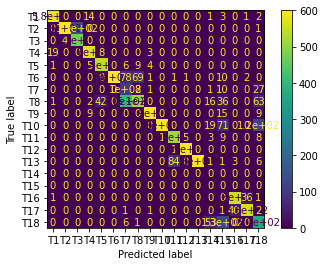

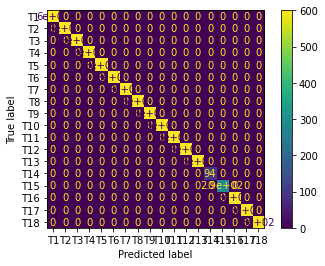

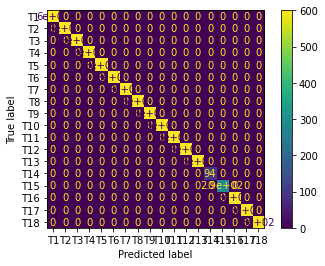

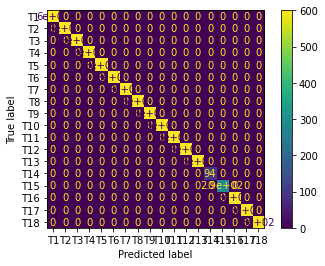

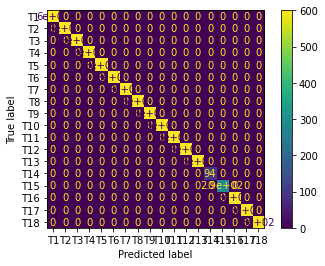

In [ ]:
import time

# training image classification

LEARNING_RATE = 5e-5
EPOCH = 500

model.to(DEVICE)

training_losses = []
validation_losses = []

# optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr = LEARNING_RATE)

for epoch_i in range(0, EPOCH):
  start = time.time()
  print(f"Epoch {epoch_i + 1} / {EPOCH}")

  # Freeze all layers
  for param in model.parameters():
      param.requires_grad = False

  # Unfreeze last layer
  for param in model.bert.encoder.layer[11].parameters():
      param.requires_grad = True

  # Reset the total loss for this epoch.
  tr_loss = 0

  # Put the model into training mode.
  model.train()

  # Untuk setiap data di training data
  for data in train_instances:

    # Mendapatkan output dari model
    input, gold = data
    input = input.to(DEVICE)
    gold = gold.to(DEVICE)
    pred = model(input)

    # Categorical Cross-Entropy --- Loss Function
    loss = loss_func(pred, gold)

    # Agar gradient tidak menumpuk; ini diperlukan sebelum
    # menghitung gradient dengan loss.backward()
    optimizer.zero_grad()

    # hitung gradient
    loss.backward()

    # update parameter
    optimizer.step()

    # akumulasi loss dalam 1 epoch
    tr_loss += loss.item()

  # rata-rata loss dalam 1 epoch
  avg_loss = tr_loss / train_size

  training_losses.append(avg_loss)

  print(f"Average loss: {avg_loss}")

  ### Uji coba di Validation Data
  print("Uji coba di Validation Data ...")

  # model eval, agar layer seperti dropout yang menghasilkan
  # sesuai yang random tidak digunakan
  model.eval()

  val_loss = 0
  pred_labels = []
  true_labels = []

  # Untuk setiap batch di validation data
  for data in valid_instances:

    # jangan track gradient! ini sedang evaluasi, bukan training
    with torch.no_grad():

      # Mendapatkan output dari model
      input, gold = data
      input = input.to(DEVICE)
      gold = gold.to(DEVICE)
      pred = model(input)

      # Categorical Cross-Entropy --- Loss Function
      loss = loss_func(pred, gold)

      # akumulasi loss di validation set
      val_loss += loss.item()

    # akumulasi prediksi
    # _, pred_l = torch.max(output, dim = 1) # outnya adalah 2-tuple: (max, max_indices)
    # pred_labels += pred_l.detach().cpu()
    # _, true_l = torch.max(y, dim = 1)
    # true_labels += true_l.detach().cpu()

  # average loss
  avg_val_loss = val_loss / val_size

  validation_losses.append(avg_val_loss)

  # accuracy
  # pred_labels = torch.stack(pred_labels).numpy()
  # true_labels = torch.stack(true_labels).numpy()
  # val_accuracy = np.sum(pred_labels == true_labels) / len(pred_labels)
  print(f"Average loss di validation data: {avg_val_loss}")
  # print(f"Accuracy di validation data: {val_accuracy}")

  print("")

  end = time.time()
  print("Time " + str(end-start))

  if epoch_i % 100 == 0:
    nb_classes = 18

    conf_matrix = torch.zeros(nb_classes, nb_classes)
    with torch.no_grad():
      for i, (input, gold) in enumerate(valid_instances):
        input = input.to(DEVICE)
        gold = gold.to(DEVICE)
        pred = model(input)
        # _, gold = torch.max(gold, 1)
        # _, pred = torch.max(pred, 1)
        # for t, p in zip(gold.view(-1), pred.view(-1)):
        #   conf_matrix[t.long(), p.long()] += 1

        conf_matrix = confusion_matrix(gold, pred, conf_matrix)

    amt, acc, prec, rec, f1 = evaluation_metric(conf_matrix)

    print(f"Confusion Matrix in validation data:")
    display_labels = ['T1', 'T2', 'T3', 'T4', 'T5', 'T6', 'T7', 'T8', 'T9', 'T10', 'T11', 'T12', 'T13', 'T14', 'T15', 'T16', 'T17', 'T18']
    disp = metrics.ConfusionMatrixDisplay(confusion_matrix=conf_matrix.detach().cpu().numpy(), display_labels=display_labels)
    disp.plot()

    for i, template_index in enumerate(display_labels):
      print(f"Evaluation for {template_index}:")
      print(f"Amount of Data: {amt[i]}")
      print(f"Accuracy: {acc[i]}")
      print(f"Precision: {prec[i]}")
      print(f"Recall: {rec[i]}")
      print(f"F One: {f1[i]}")
      print()

    save_path = 'model/class_tesaurus_checkpoint/'
    !mkdir -p model/class_tesaurus_checkpoint/
    model_class_path = os.path.join(save_path, "indobert_class_tesaurus_checkpoint_" + str(epoch_i) +".pth")
    torch.save(model, model_class_path)

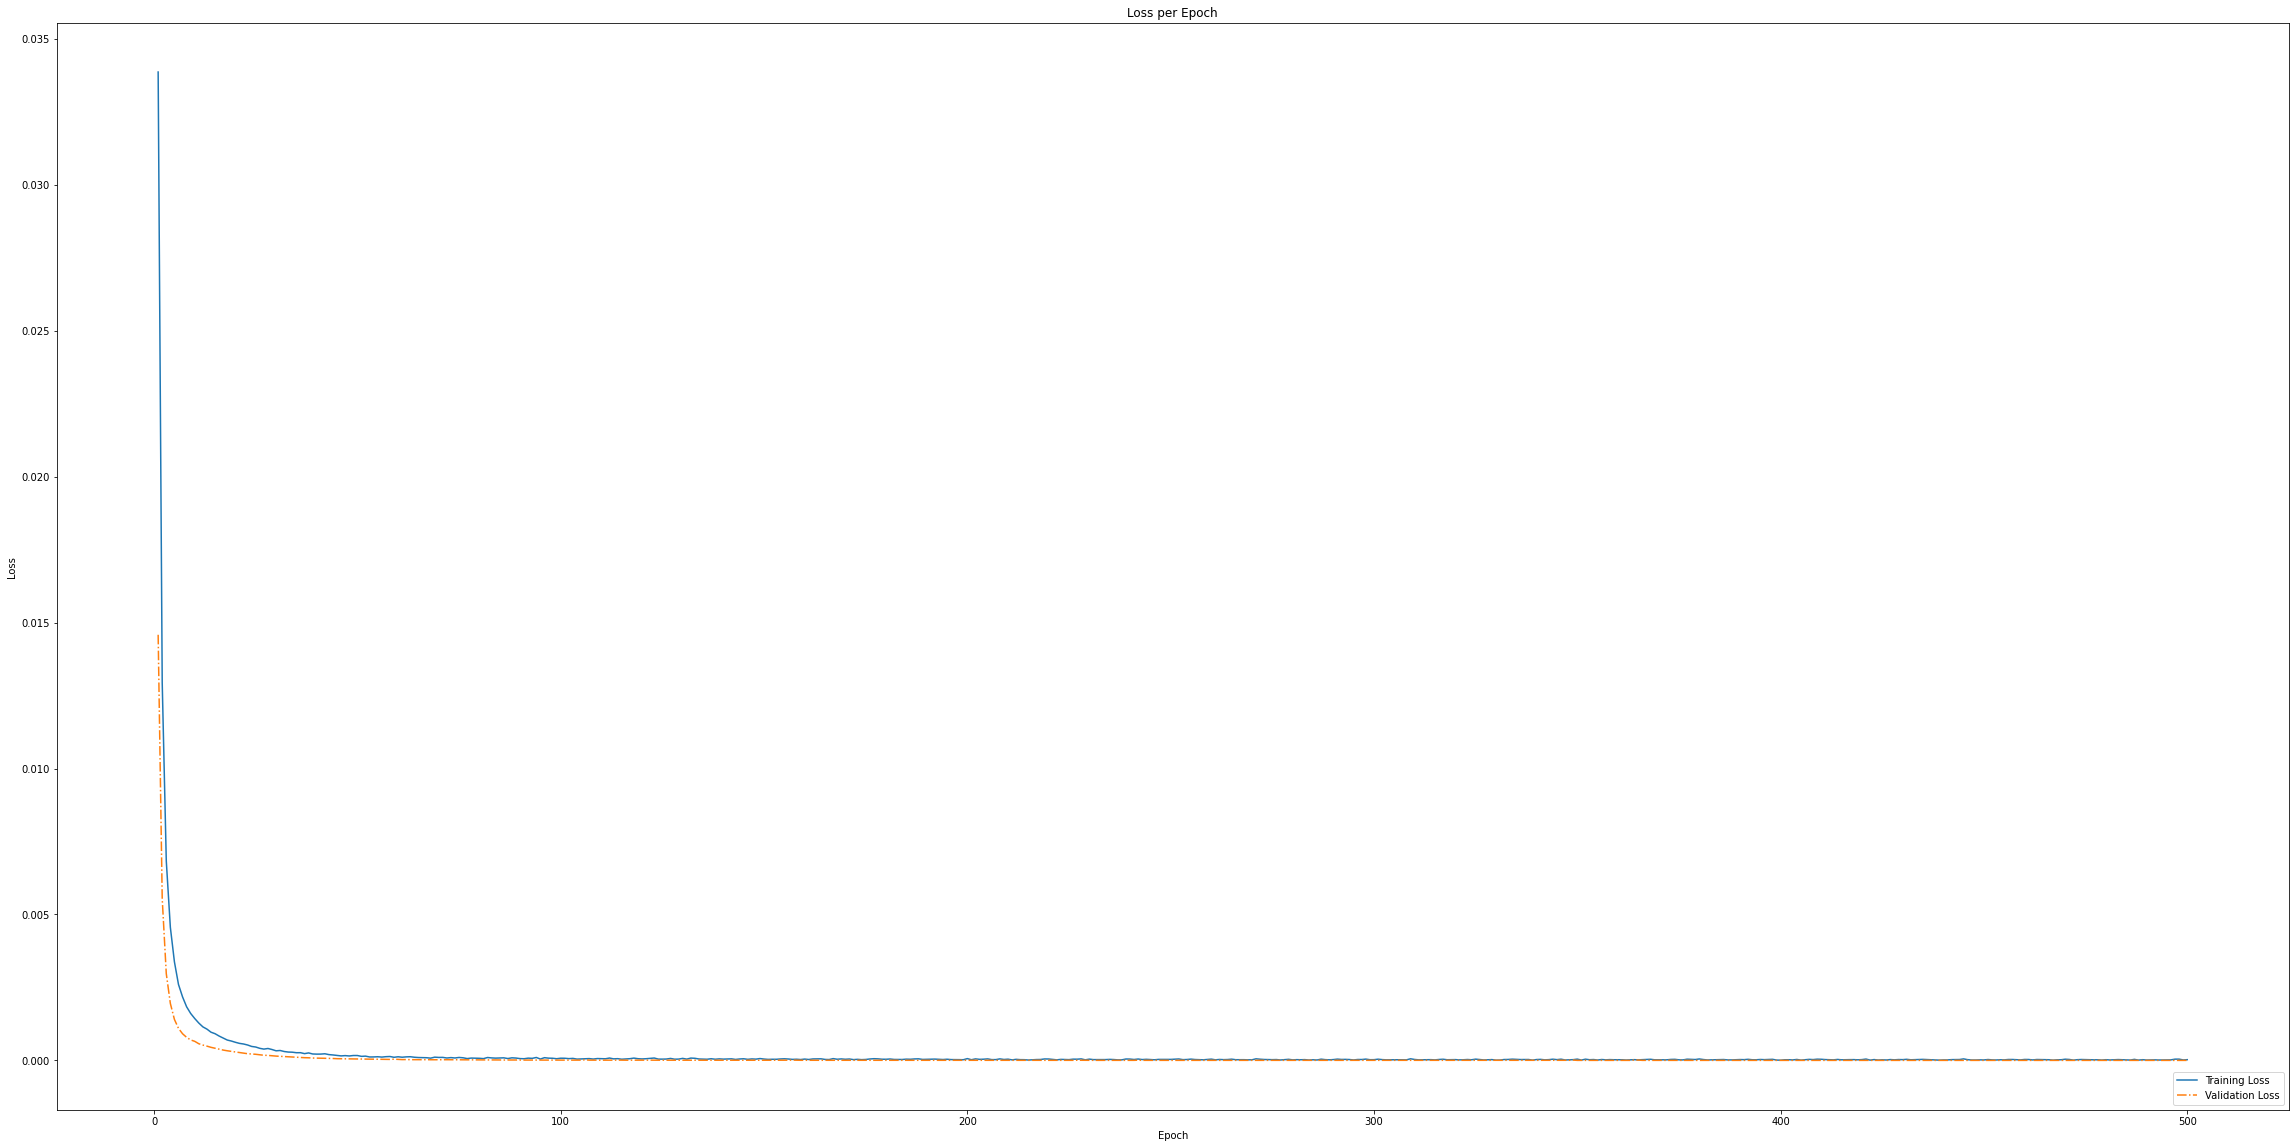

In [ ]:
x = np.arange(1, 501)
y_train_loss = np.asarray(training_losses, dtype=np.float32)
y_val_loss = np.asarray(validation_losses, dtype=np.float32)

plt.figure(figsize=(40,20))

plt.plot(x, y_train_loss)
plt.plot(x, y_val_loss, '-.')

plt.legend(["Training Loss", "Validation Loss"], loc="lower right")

plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title('Loss per Epoch')
plt.show()

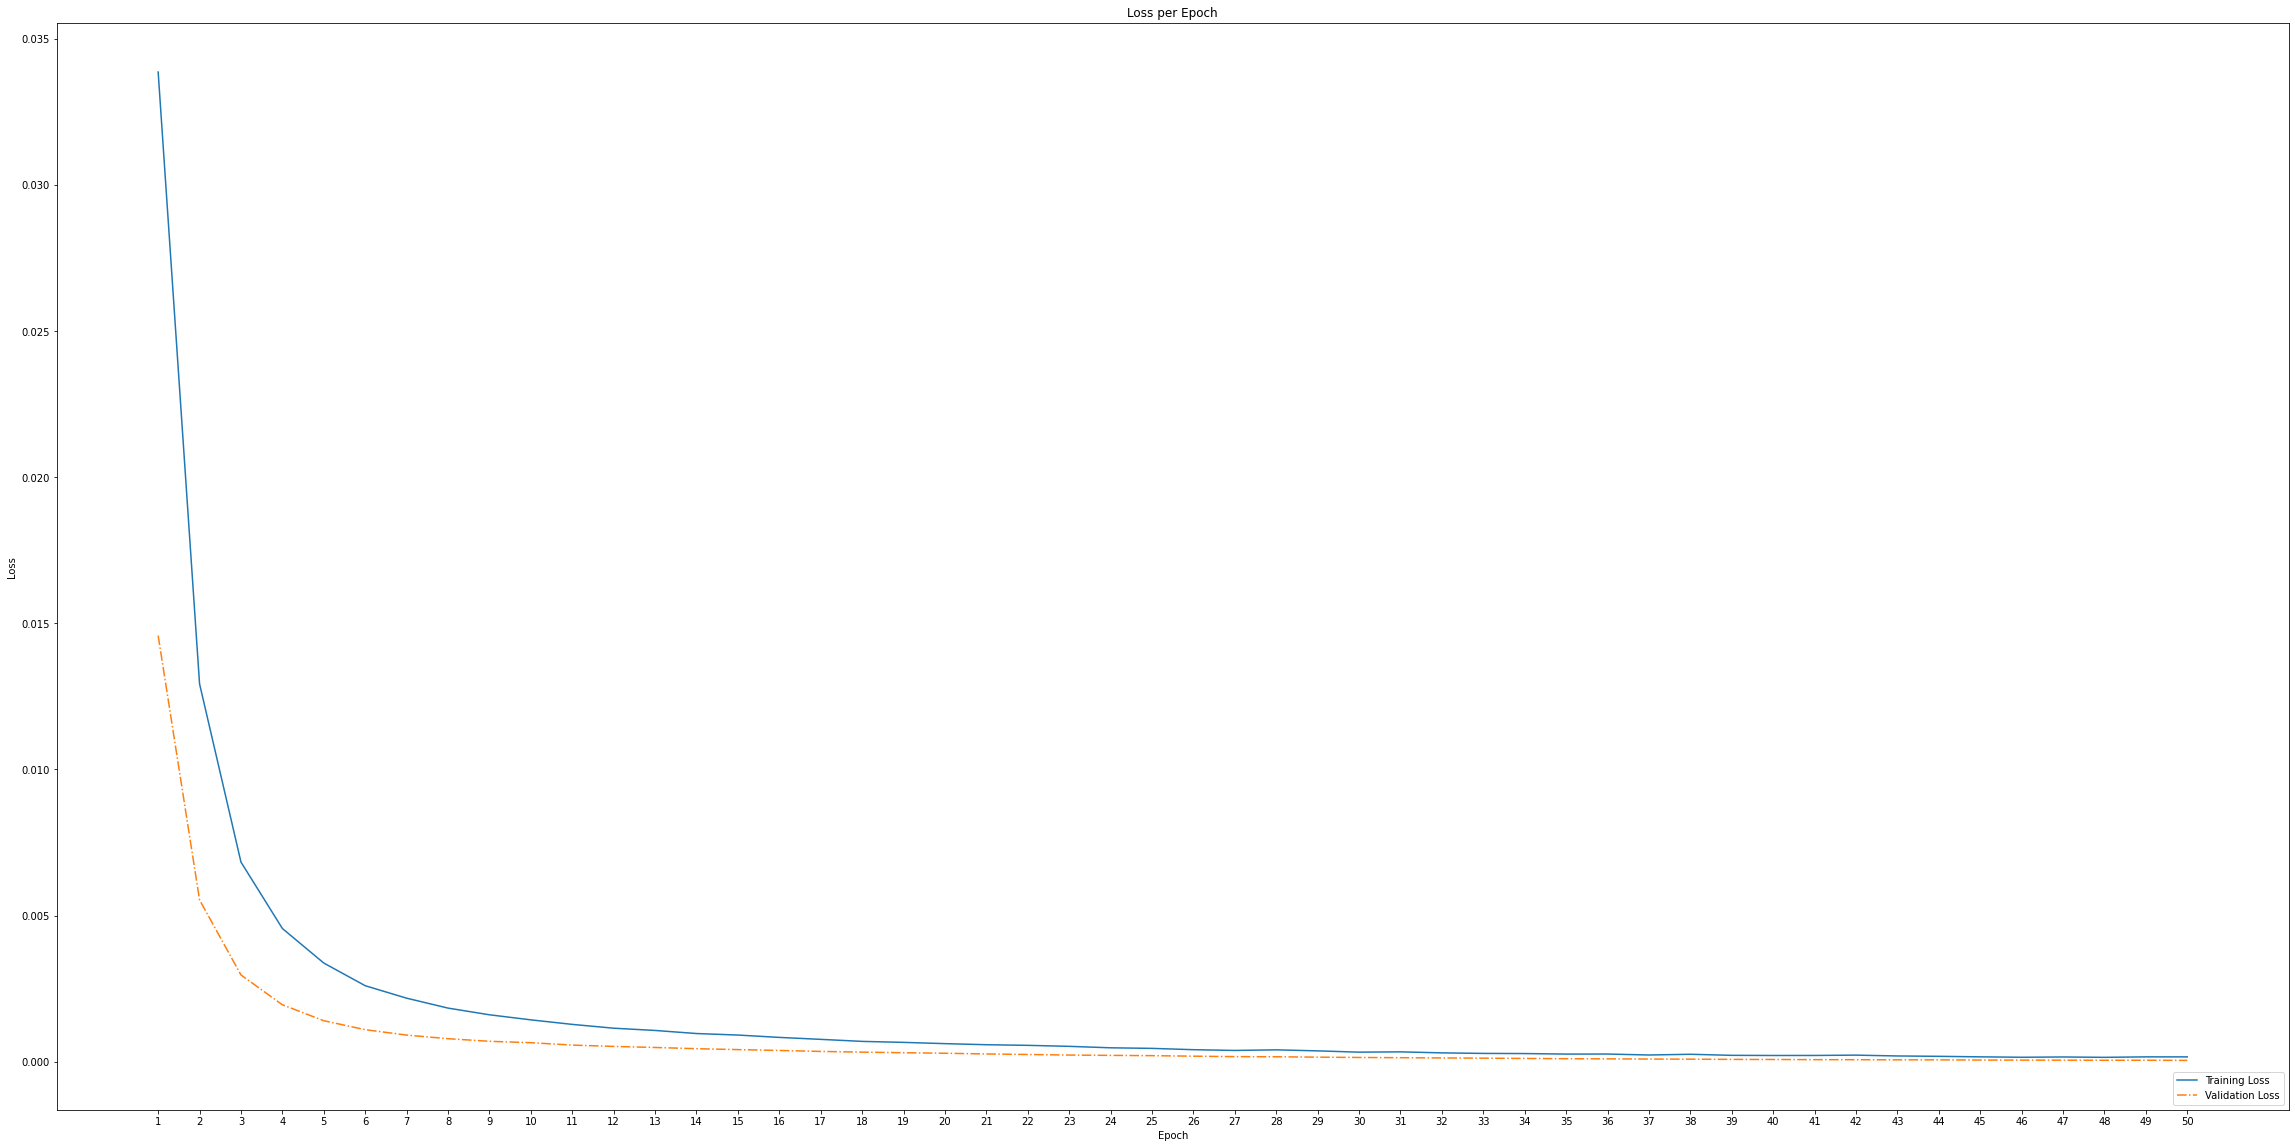

In [ ]:
x = np.arange(1, 51)
y_train_loss = np.asarray(training_losses, dtype=np.float32)
y_val_loss = np.asarray(validation_losses, dtype=np.float32)

plt.figure(figsize=(40,20))

plt.plot(x, y_train_loss[0:50])
plt.plot(x, y_val_loss[0:50], '-.')

plt.xticks(np.arange(min(x), max(x)+1, 1.0))
plt.legend(["Training Loss", "Validation Loss"], loc="lower right")

plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title('Loss per Epoch')
plt.show()

In [ ]:
save_path = 'model/'
model_class_path = os.path.join(save_path, "class_tesaurus_checkpoint/indobert_class_tesaurus_checkpoint_100"+".pth")
# model_class_path = os.path.join(save_path, "class/indobert_class_v1"+".pth")

bert_class = torch.load(model_class_path)

# bert_class = model_class

Debug Amount: tensor([400., 400., 400., 400., 400., 400., 400., 400., 400., 400., 400., 400.,
        400.,  63., 191., 400., 400., 400.])
Average loss di testing data: 9.951993117911216e-06
Confusion Matrix in testing data: 


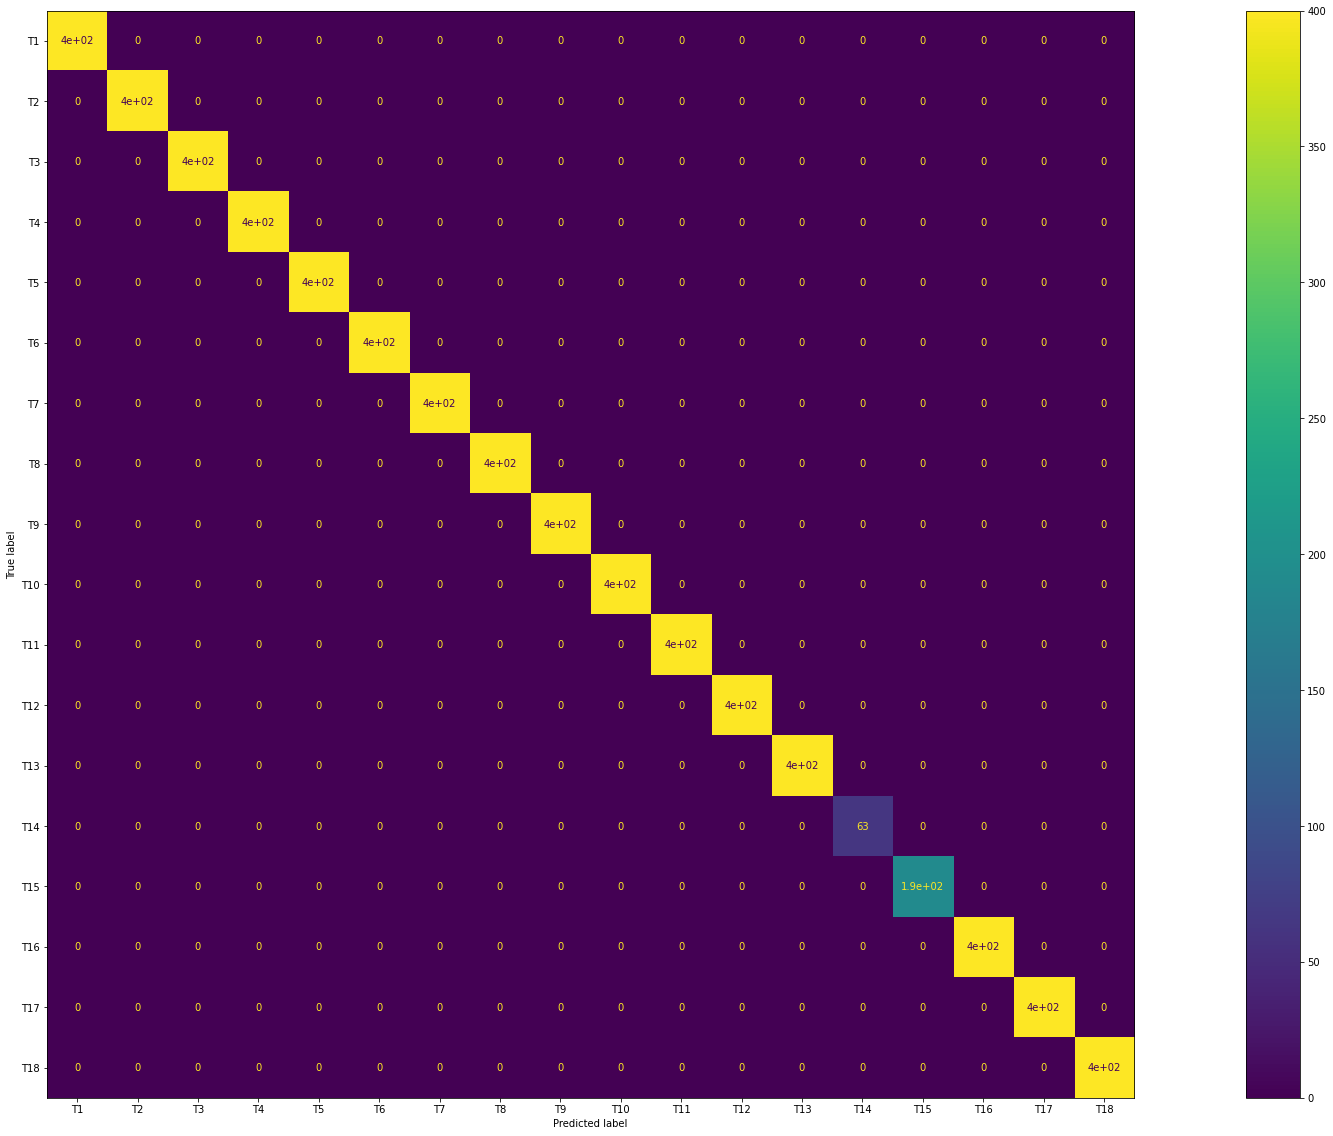

Evaluation for T1:
Amount of Data: 400.0
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F One: 1.0

Evaluation for T2:
Amount of Data: 400.0
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F One: 1.0

Evaluation for T3:
Amount of Data: 400.0
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F One: 1.0

Evaluation for T4:
Amount of Data: 400.0
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F One: 1.0

Evaluation for T5:
Amount of Data: 400.0
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F One: 1.0

Evaluation for T6:
Amount of Data: 400.0
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F One: 1.0

Evaluation for T7:
Amount of Data: 400.0
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F One: 1.0

Evaluation for T8:
Amount of Data: 400.0
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F One: 1.0

Evaluation for T9:
Amount of Data: 400.0
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F One: 1.0

Evaluation for T10:
Amount of Data: 400.0
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F One: 1.0

Evaluation for T11:
Amount of Data: 400.0
Accuracy: 1.0
Pre

In [ ]:
  tr_loss = 0

  model.to(DEVICE)

  bert_class.eval()

  nb_classes = 18

  conf_matrix = torch.zeros(nb_classes, nb_classes)
  # Untuk setiap data di training data
  for data in test_instances:

    with torch.no_grad():
      # Mendapatkan output dari model
      input, gold = data
      input = input.to(DEVICE)
      gold = gold.to(DEVICE)
      pred = bert_class(input)

      # Categorical Cross-Entropy --- Loss Function
      loss = loss_func(pred, gold)
      # _, pred = torch.max(pred, 1)
        # for t, p in zip(gold.view(-1), pred.view(-1)):
        #   confusion_matrix[t.long(), p.long()] += 1


      # akumulasi loss dalam 1 epoch
      tr_loss += loss.item()

      conf_matrix = confusion_matrix(gold, pred, conf_matrix)

  amt, acc, prec, rec, f1 = evaluation_metric(conf_matrix)

  # rata-rata loss dalam 1 epoch
  avg_loss = tr_loss / test_size
  # accuracy = confusion_matrix.diag()/confusion_matrix.sum(1)

  print(f"Average loss di testing data: {avg_loss}")
  print(f"Confusion Matrix in testing data: ")

  fig, ax = plt.subplots(figsize=(40, 20))

  display_labels = ['T1', 'T2', 'T3', 'T4', 'T5', 'T6', 'T7', 'T8', 'T9', 'T10', 'T11', 'T12', 'T13', 'T14', 'T15', 'T16', 'T17', 'T18']
  disp = metrics.ConfusionMatrixDisplay(confusion_matrix=conf_matrix.detach().cpu().numpy(), display_labels=display_labels)
  disp.plot(ax=ax)

  plt.show()

  for i, template_index in enumerate(display_labels):
      print(f"Evaluation for {template_index}:")
      print(f"Amount of Data: {amt[i]}")
      print(f"Accuracy: {acc[i]}")
      print(f"Precision: {prec[i]}")
      print(f"Recall: {rec[i]}")
      print(f"F One: {f1[i]}")
      print()

### 3rd Try, 20 EPOCH, Tesaurus, 5-fold

0it [00:00, ?it/s]/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


=====:=====:=====:=====:===== Fold 1 =====:=====:=====:=====:=====


0it [00:02, ?it/s]

Fold 1 Ready


  0%|                                                    | 0/20 [00:00<?, ?it/s]

Epoch 1 / 20


==:==:==Train==:==:==: 0it [00:00, ?it/s]We strongly recommend passing in an `attention_mask` since your input_ids may be padded. See https://huggingface.co/docs/transformers/troubleshooting#incorrect-output-when-padding-tokens-arent-masked.
You may ignore this warning if your `pad_token_id` (0) is identical to the `bos_token_id` (0), `eos_token_id` (None), or the `sep_token_id` (None), and your input is not padded.
==:==:==Train==:==:==: 0it [00:11, ?it/s]


Average Loss Train: 0.03120707300359118


==:==:==Valid==:==:==: 0it [00:02, ?it/s]
  5%|██▏                                         | 1/20 [00:13<04:15, 13.45s/it]

Average Loss Validation: 0.011483949306994779
Time 13.438596248626709

Epoch 2 / 20


==:==:==Train==:==:==: 0it [00:11, ?it/s]


Average Loss Train: 0.010691241984197753


==:==:==Valid==:==:==: 0it [00:02, ?it/s]
 10%|████▍                                       | 2/20 [00:26<04:01, 13.41s/it]

Average Loss Validation: 0.004462221737759215
Time 13.368599653244019

Epoch 3 / 20


==:==:==Train==:==:==: 0it [00:10, ?it/s]


Average Loss Train: 0.005654012047515843


==:==:==Valid==:==:==: 0it [00:02, ?it/s]
 15%|██████▌                                     | 3/20 [00:39<03:45, 13.24s/it]

Average Loss Validation: 0.0024024395806186067
Time 13.03990650177002

Epoch 4 / 20


==:==:==Train==:==:==: 0it [00:10, ?it/s]


Average Loss Train: 0.003755587763442305


==:==:==Valid==:==:==: 0it [00:02, ?it/s]
 20%|████████▊                                   | 4/20 [00:52<03:30, 13.15s/it]

Average Loss Validation: 0.0015617809298520478
Time 13.002825021743774

Epoch 5 / 20


==:==:==Train==:==:==: 0it [00:10, ?it/s]


Average Loss Train: 0.0027043131872533798


==:==:==Valid==:==:==: 0it [00:02, ?it/s]


Average Loss Validation: 0.0010975613582530736
Time 13.11641788482666



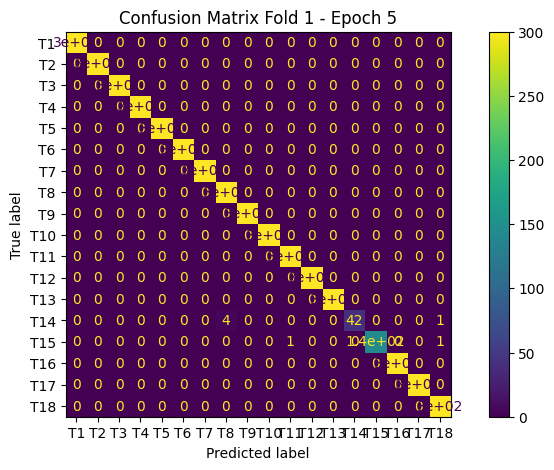

Amount of Data  Accuracy  Precision    Recall     F One
T1            300.0  1.000000   1.000000  1.000000  1.000000
T2            300.0  1.000000   1.000000  1.000000  1.000000
T3            300.0  1.000000   1.000000  1.000000  1.000000
T4            300.0  1.000000   1.000000  1.000000  1.000000
T5            300.0  1.000000   1.000000  1.000000  1.000000
T6            300.0  1.000000   1.000000  1.000000  1.000000
T7            300.0  1.000000   1.000000  1.000000  1.000000
T8            300.0  1.000000   0.986842  1.000000  0.993377
T9            300.0  1.000000   1.000000  1.000000  1.000000
T10           300.0  1.000000   1.000000  1.000000  1.000000
T11           300.0  1.000000   0.996678  1.000000  0.998336
T12           300.0  1.000000   1.000000  1.000000  1.000000
T13           300.0  1.000000   1.000000  1.000000  1.000000
T14            47.0  0.893617   1.000000  0.893617  0.943820
T15           144.0  0.986111   1.000000  0.986111  0.993007
T16           300.0  1.000000   1.000000  1.000000  1.000000
T17           300.0  1.000000   1.000000  1.000000  1.000000
T18           300.0  1.000000   0.993378  1.000000  0.996678

 25%|███████████                                 | 5/20 [01:10<03:41, 14.76s/it]

Epoch 6 / 20


==:==:==Train==:==:==: 0it [00:10, ?it/s]


Average Loss Train: 0.0020690362467495854


==:==:==Valid==:==:==: 0it [00:02, ?it/s]
 30%|█████████████▏                              | 6/20 [01:23<03:19, 14.22s/it]

Average Loss Validation: 0.0008802086068606525
Time 13.177918434143066

Epoch 7 / 20


==:==:==Train==:==:==: 0it [00:10, ?it/s]


Average Loss Train: 0.0017241977326915355


==:==:==Valid==:==:==: 0it [00:02, ?it/s]
 35%|███████████████▍                            | 7/20 [01:36<03:00, 13.87s/it]

Average Loss Validation: 0.0007417188806933646
Time 13.13546633720398

Epoch 8 / 20


==:==:==Train==:==:==: 0it [00:10, ?it/s]


Average Loss Train: 0.0014589981935574918


==:==:==Valid==:==:==: 0it [00:02, ?it/s]
 40%|█████████████████▌                          | 8/20 [01:50<02:43, 13.65s/it]

Average Loss Validation: 0.0006476088961244131
Time 13.170323371887207

Epoch 9 / 20


==:==:==Train==:==:==: 0it [00:10, ?it/s]


Average Loss Train: 0.0012800096293429813


==:==:==Valid==:==:==: 0it [00:02, ?it/s]
 45%|███████████████████▊                        | 9/20 [02:03<02:28, 13.49s/it]

Average Loss Validation: 0.0005816611747026587
Time 13.134542226791382

Epoch 10 / 20


==:==:==Train==:==:==: 0it [00:10, ?it/s]


Average Loss Train: 0.0011614005463963042


==:==:==Valid==:==:==: 0it [00:02, ?it/s]


Average Loss Validation: 0.0005209540119392794
Time 13.169411659240723



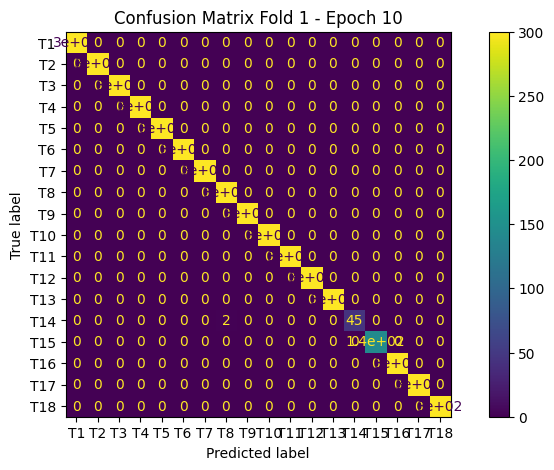

Amount of Data  Accuracy  Precision    Recall     F One
T1            300.0  1.000000   1.000000  1.000000  1.000000
T2            300.0  1.000000   1.000000  1.000000  1.000000
T3            300.0  1.000000   1.000000  1.000000  1.000000
T4            300.0  1.000000   1.000000  1.000000  1.000000
T5            300.0  1.000000   1.000000  1.000000  1.000000
T6            300.0  1.000000   1.000000  1.000000  1.000000
T7            300.0  1.000000   1.000000  1.000000  1.000000
T8            300.0  1.000000   0.993378  1.000000  0.996678
T9            300.0  1.000000   1.000000  1.000000  1.000000
T10           300.0  1.000000   1.000000  1.000000  1.000000
T11           300.0  1.000000   1.000000  1.000000  1.000000
T12           300.0  1.000000   1.000000  1.000000  1.000000
T13           300.0  1.000000   1.000000  1.000000  1.000000
T14            47.0  0.957447   1.000000  0.957447  0.978261
T15           144.0  1.000000   1.000000  1.000000  1.000000
T16           300.0  1.000000   1.000000  1.000000  1.000000
T17           300.0  1.000000   1.000000  1.000000  1.000000
T18           300.0  1.000000   1.000000  1.000000  1.000000

 50%|█████████████████████▌                     | 10/20 [02:20<02:28, 14.80s/it]

Epoch 11 / 20


==:==:==Train==:==:==: 0it [00:10, ?it/s]


Average Loss Train: 0.0010109599845816114


==:==:==Valid==:==:==: 0it [00:02, ?it/s]
 55%|███████████████████████▋                   | 11/20 [02:33<02:08, 14.27s/it]

Average Loss Validation: 0.000477161392811376
Time 13.0464026927948

Epoch 12 / 20


==:==:==Train==:==:==: 0it [00:10, ?it/s]


Average Loss Train: 0.000904123986957367


==:==:==Valid==:==:==: 0it [00:02, ?it/s]
 60%|█████████████████████████▊                 | 12/20 [02:47<01:51, 13.91s/it]

Average Loss Validation: 0.00042375601698224424
Time 13.06973147392273

Epoch 13 / 20


==:==:==Train==:==:==: 0it [00:10, ?it/s]


Average Loss Train: 0.0008199879223992208


==:==:==Valid==:==:==: 0it [00:02, ?it/s]
 65%|███████████████████████████▉               | 13/20 [03:00<01:35, 13.64s/it]

Average Loss Validation: 0.0003920130683935804
Time 13.031685829162598

Epoch 14 / 20


==:==:==Train==:==:==: 0it [00:10, ?it/s]


Average Loss Train: 0.000764015982326919


==:==:==Valid==:==:==: 0it [00:02, ?it/s]
 70%|██████████████████████████████             | 14/20 [03:13<01:20, 13.46s/it]

Average Loss Validation: 0.00035715423654253604
Time 13.012959241867065

Epoch 15 / 20


==:==:==Train==:==:==: 0it [00:10, ?it/s]


Average Loss Train: 0.00070787486144321


==:==:==Valid==:==:==: 0it [00:02, ?it/s]


Average Loss Validation: 0.00032470294837363137
Time 13.08764386177063



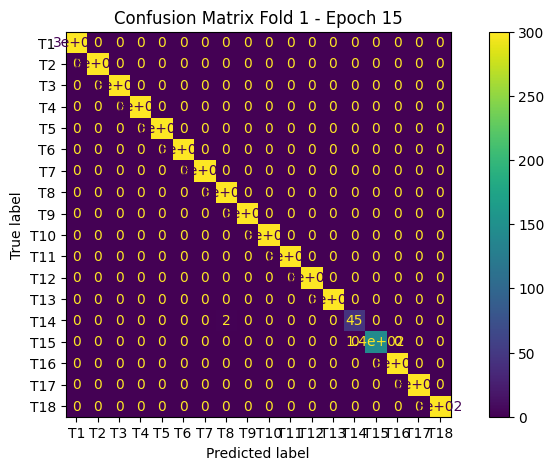

Amount of Data  Accuracy  Precision    Recall     F One
T1            300.0  1.000000   1.000000  1.000000  1.000000
T2            300.0  1.000000   1.000000  1.000000  1.000000
T3            300.0  1.000000   1.000000  1.000000  1.000000
T4            300.0  1.000000   1.000000  1.000000  1.000000
T5            300.0  1.000000   1.000000  1.000000  1.000000
T6            300.0  1.000000   1.000000  1.000000  1.000000
T7            300.0  1.000000   1.000000  1.000000  1.000000
T8            300.0  1.000000   0.993378  1.000000  0.996678
T9            300.0  1.000000   1.000000  1.000000  1.000000
T10           300.0  1.000000   1.000000  1.000000  1.000000
T11           300.0  1.000000   1.000000  1.000000  1.000000
T12           300.0  1.000000   1.000000  1.000000  1.000000
T13           300.0  1.000000   1.000000  1.000000  1.000000
T14            47.0  0.957447   1.000000  0.957447  0.978261
T15           144.0  1.000000   1.000000  1.000000  1.000000
T16           300.0  1.000000   1.000000  1.000000  1.000000
T17           300.0  1.000000   1.000000  1.000000  1.000000
T18           300.0  1.000000   1.000000  1.000000  1.000000

 75%|████████████████████████████████▎          | 15/20 [03:30<01:13, 14.78s/it]

Epoch 16 / 20


==:==:==Train==:==:==: 0it [00:10, ?it/s]


Average Loss Train: 0.0006291511994907875


==:==:==Valid==:==:==: 0it [00:02, ?it/s]
 80%|██████████████████████████████████▍        | 16/20 [03:44<00:57, 14.27s/it]

Average Loss Validation: 0.0003000673923982549
Time 13.077838897705078

Epoch 17 / 20


==:==:==Train==:==:==: 0it [00:10, ?it/s]


Average Loss Train: 0.0005979663126902255


==:==:==Valid==:==:==: 0it [00:02, ?it/s]
 85%|████████████████████████████████████▌      | 17/20 [03:57<00:41, 13.91s/it]

Average Loss Validation: 0.00027553533619832144
Time 13.056851148605347

Epoch 18 / 20


==:==:==Train==:==:==: 0it [00:10, ?it/s]


Average Loss Train: 0.0005782438531697155


==:==:==Valid==:==:==: 0it [00:02, ?it/s]
 90%|██████████████████████████████████████▋    | 18/20 [04:10<00:27, 13.65s/it]

Average Loss Validation: 0.0002477864194247126
Time 13.0516836643219

Epoch 19 / 20


==:==:==Train==:==:==: 0it [00:10, ?it/s]


Average Loss Train: 0.0004905522706729914


==:==:==Valid==:==:==: 0it [00:02, ?it/s]
 95%|████████████████████████████████████████▊  | 19/20 [04:22<00:13, 13.41s/it]

Average Loss Validation: 0.000230637446353393
Time 12.827175617218018

Epoch 20 / 20


==:==:==Train==:==:==: 0it [00:10, ?it/s]


Average Loss Train: 0.00046598314436410135


==:==:==Valid==:==:==: 0it [00:02, ?it/s]


Average Loss Validation: 0.00022462947528112916
Time 12.9536292552948



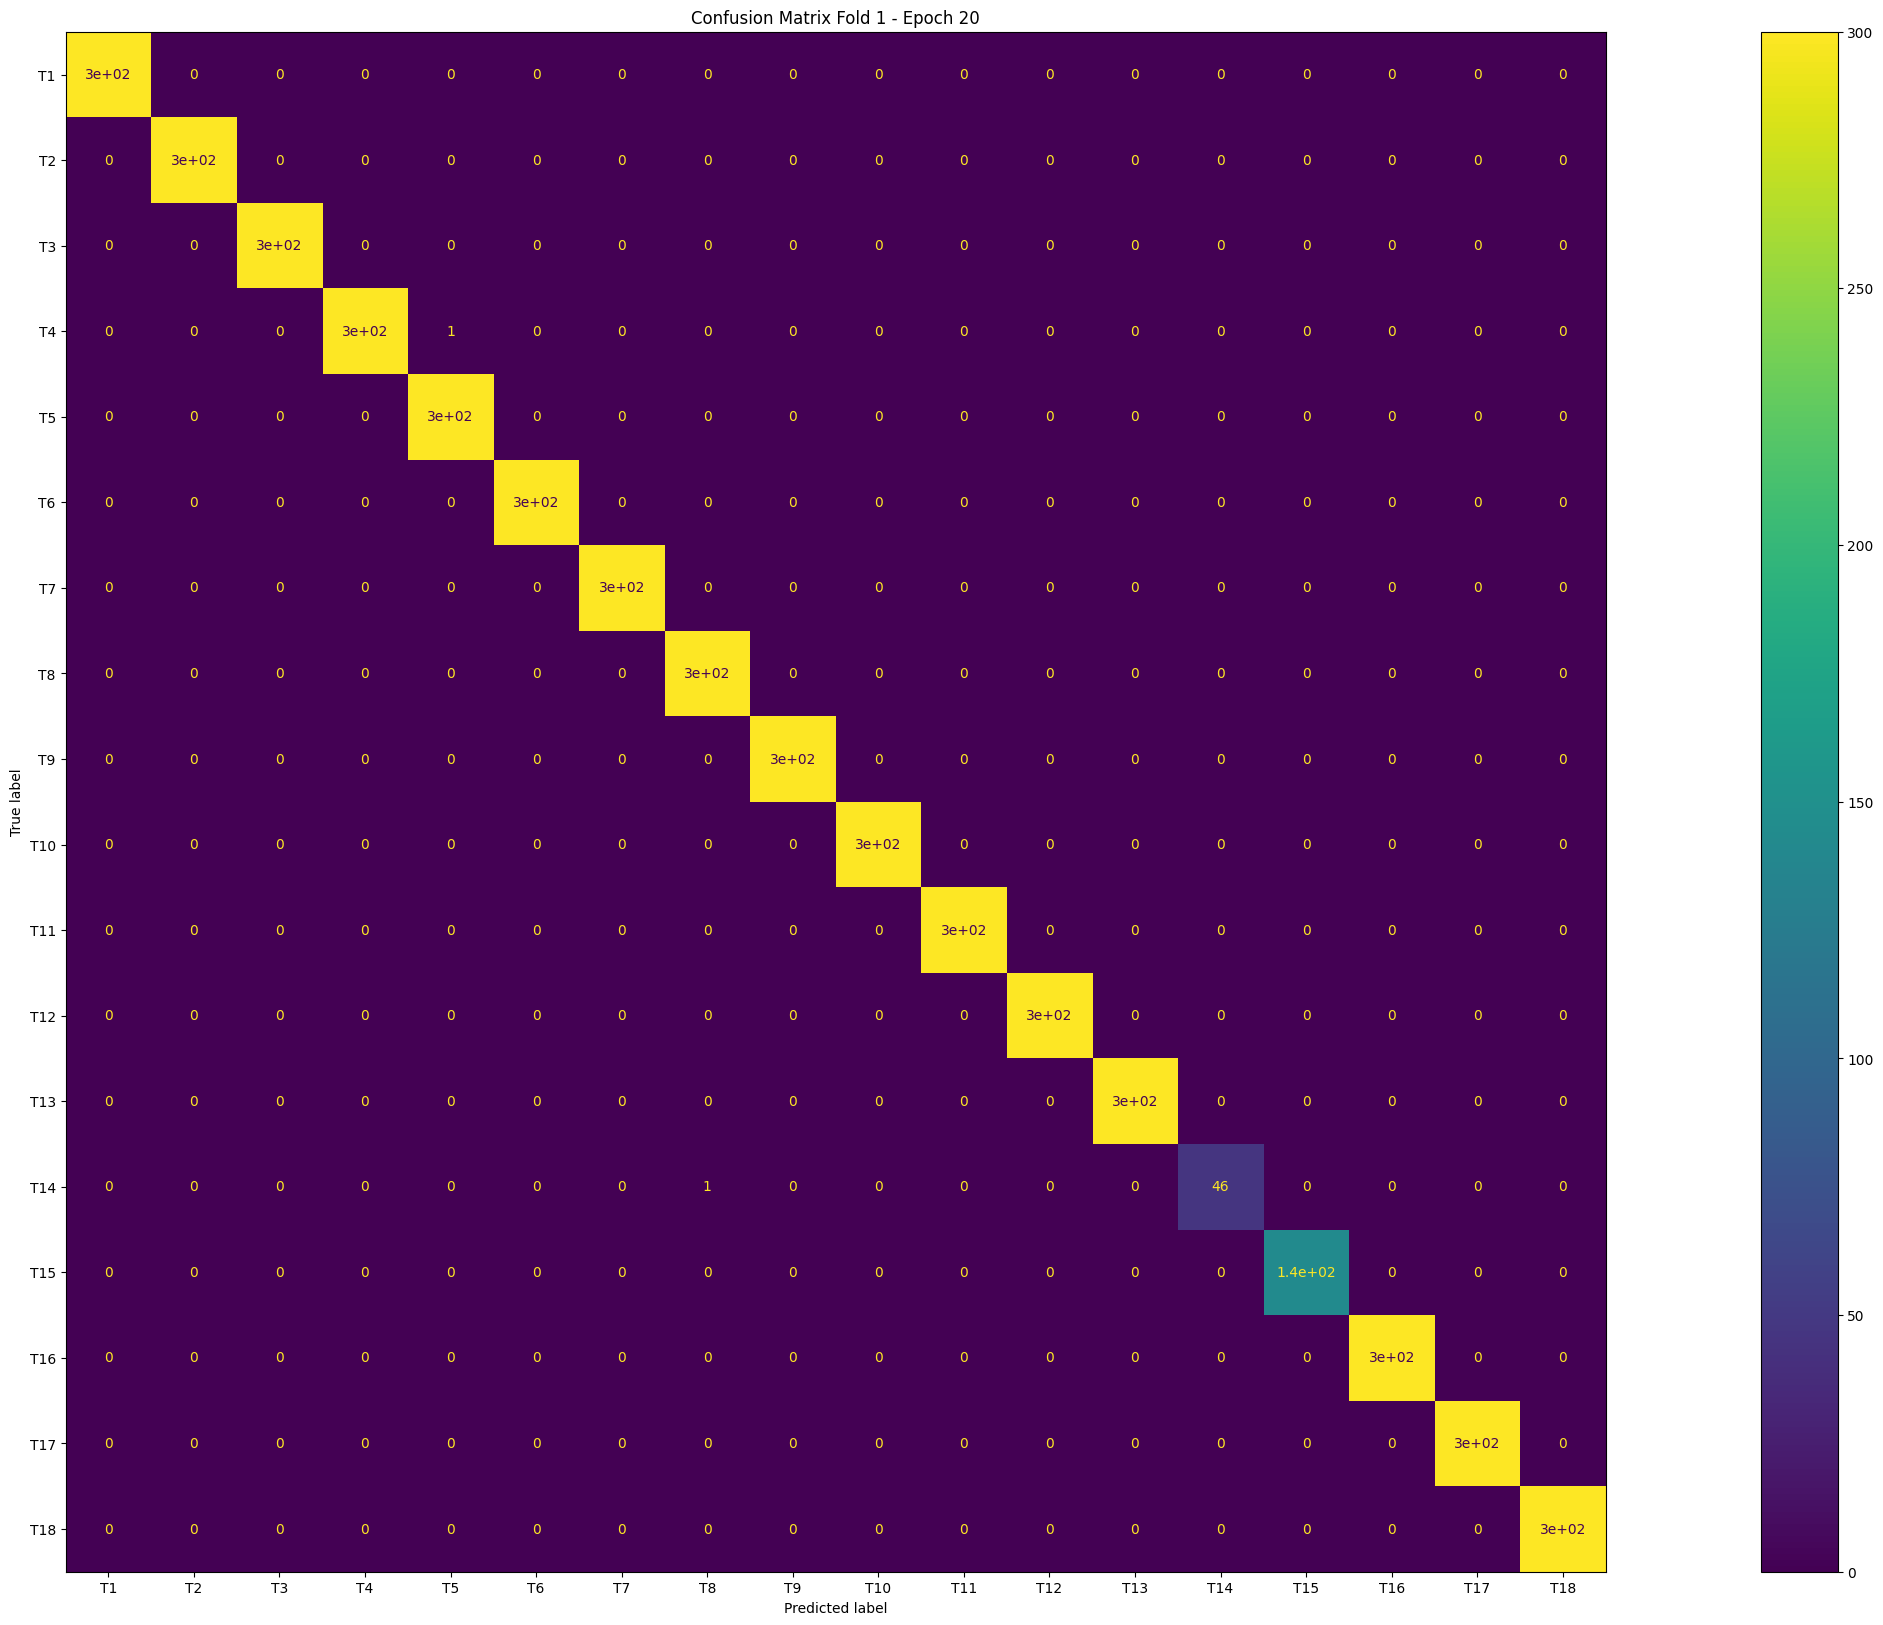

Amount of Data  Accuracy  Precision    Recall     F One
T1            300.0  1.000000   1.000000  1.000000  1.000000
T2            300.0  1.000000   1.000000  1.000000  1.000000
T3            300.0  1.000000   1.000000  1.000000  1.000000
T4            300.0  0.996667   1.000000  0.996667  0.998331
T5            300.0  1.000000   0.996678  1.000000  0.998336
T6            300.0  1.000000   1.000000  1.000000  1.000000
T7            300.0  1.000000   1.000000  1.000000  1.000000
T8            300.0  1.000000   0.996678  1.000000  0.998336
T9            300.0  1.000000   1.000000  1.000000  1.000000
T10           300.0  1.000000   1.000000  1.000000  1.000000
T11           300.0  1.000000   1.000000  1.000000  1.000000
T12           300.0  1.000000   1.000000  1.000000  1.000000
T13           300.0  1.000000   1.000000  1.000000  1.000000
T14            47.0  0.978723   1.000000  0.978723  0.989247
T15           144.0  1.000000   1.000000  1.000000  1.000000
T16           300.0  1.000000   1.000000  1.000000  1.000000
T17           300.0  1.000000   1.000000  1.000000  1.000000
T18           300.0  1.000000   1.000000  1.000000  1.000000

100%|███████████████████████████████████████████| 20/20 [04:40<00:00, 14.02s/it]
1it [04:42, 282.98s/it]/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


=====:=====:=====:=====:===== Fold 2 =====:=====:=====:=====:=====


1it [04:47, 282.98s/it]

Fold 2 Ready


  0%|                                                    | 0/20 [00:00<?, ?it/s]

Epoch 1 / 20


==:==:==Train==:==:==: 0it [00:11, ?it/s]


Average Loss Train: 0.03246749678270103


==:==:==Valid==:==:==: 0it [00:02, ?it/s]
  5%|██▏                                         | 1/20 [00:13<04:12, 13.28s/it]

Average Loss Validation: 0.012706037704834718
Time 13.271374225616455

Epoch 2 / 20


==:==:==Train==:==:==: 0it [00:10, ?it/s]


Average Loss Train: 0.01122159336427966


==:==:==Valid==:==:==: 0it [00:02, ?it/s]
 10%|████▍                                       | 2/20 [00:26<03:57, 13.19s/it]

Average Loss Validation: 0.004181880406841247
Time 13.12541127204895

Epoch 3 / 20


==:==:==Train==:==:==: 0it [00:10, ?it/s]


Average Loss Train: 0.005521796046149712


==:==:==Valid==:==:==: 0it [00:02, ?it/s]
 15%|██████▌                                     | 3/20 [00:39<03:44, 13.19s/it]

Average Loss Validation: 0.0021972134127048308
Time 13.173999786376953

Epoch 4 / 20


==:==:==Train==:==:==: 0it [00:10, ?it/s]


Average Loss Train: 0.0036483998386375315


==:==:==Valid==:==:==: 0it [00:02, ?it/s]
 20%|████████▊                                   | 4/20 [00:52<03:30, 13.17s/it]

Average Loss Validation: 0.0014268916286901386
Time 13.12061619758606

Epoch 5 / 20


==:==:==Train==:==:==: 0it [00:10, ?it/s]


Average Loss Train: 0.0026689192006669324


==:==:==Valid==:==:==: 0it [00:02, ?it/s]


Average Loss Validation: 0.0010523254779691927
Time 12.96851396560669



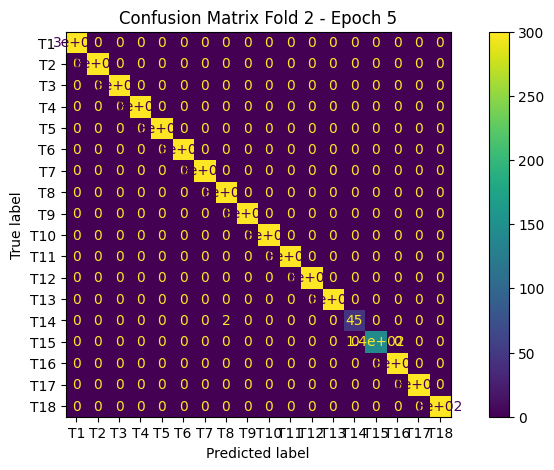

Amount of Data  Accuracy  Precision    Recall     F One
T1            300.0  1.000000   1.000000  1.000000  1.000000
T2            300.0  1.000000   1.000000  1.000000  1.000000
T3            300.0  1.000000   1.000000  1.000000  1.000000
T4            300.0  1.000000   1.000000  1.000000  1.000000
T5            300.0  1.000000   1.000000  1.000000  1.000000
T6            300.0  1.000000   1.000000  1.000000  1.000000
T7            300.0  1.000000   1.000000  1.000000  1.000000
T8            300.0  1.000000   0.993378  1.000000  0.996678
T9            300.0  1.000000   1.000000  1.000000  1.000000
T10           300.0  1.000000   1.000000  1.000000  1.000000
T11           300.0  1.000000   1.000000  1.000000  1.000000
T12           300.0  1.000000   1.000000  1.000000  1.000000
T13           300.0  1.000000   1.000000  1.000000  1.000000
T14            47.0  0.957447   1.000000  0.957447  0.978261
T15           143.0  1.000000   1.000000  1.000000  1.000000
T16           300.0  1.000000   1.000000  1.000000  1.000000
T17           300.0  1.000000   1.000000  1.000000  1.000000
T18           300.0  1.000000   1.000000  1.000000  1.000000

 25%|███████████                                 | 5/20 [01:09<03:39, 14.61s/it]

Epoch 6 / 20


==:==:==Train==:==:==: 0it [00:11, ?it/s]


Average Loss Train: 0.0021335014163698283


==:==:==Valid==:==:==: 0it [00:02, ?it/s]
 30%|█████████████▏                              | 6/20 [01:23<03:18, 14.16s/it]

Average Loss Validation: 0.0008559909815300921
Time 13.274029970169067

Epoch 7 / 20


==:==:==Train==:==:==: 0it [00:10, ?it/s]


Average Loss Train: 0.0017725166787568962


==:==:==Valid==:==:==: 0it [00:02, ?it/s]
 35%|███████████████▍                            | 7/20 [01:36<02:59, 13.82s/it]

Average Loss Validation: 0.0007252724777780219
Time 13.120280742645264

Epoch 8 / 20


==:==:==Train==:==:==: 0it [00:10, ?it/s]


Average Loss Train: 0.00152922708392412


==:==:==Valid==:==:==: 0it [00:02, ?it/s]
 40%|█████████████████▌                          | 8/20 [01:49<02:43, 13.62s/it]

Average Loss Validation: 0.0006327765543976862
Time 13.161112785339355

Epoch 9 / 20


==:==:==Train==:==:==: 0it [00:10, ?it/s]


Average Loss Train: 0.0013188852572911702


==:==:==Valid==:==:==: 0it [00:02, ?it/s]
 45%|███████████████████▊                        | 9/20 [02:02<02:28, 13.47s/it]

Average Loss Validation: 0.0005769945867732914
Time 13.155718326568604

Epoch 10 / 20


==:==:==Train==:==:==: 0it [00:10, ?it/s]


Average Loss Train: 0.0011694086462230924


==:==:==Valid==:==:==: 0it [00:02, ?it/s]


Average Loss Validation: 0.0005133834665637456
Time 13.075619220733643



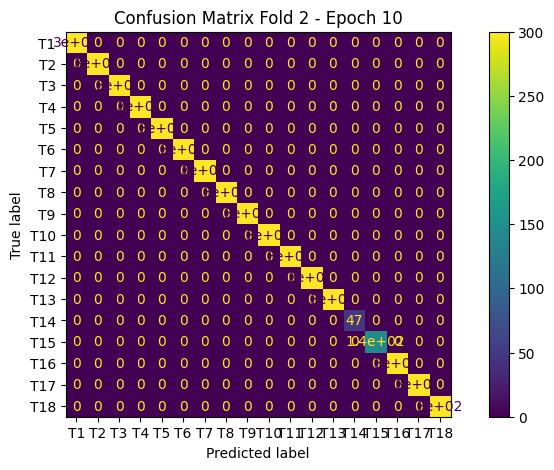

Amount of Data  Accuracy  Precision  Recall  F One
T1            300.0       1.0        1.0     1.0    1.0
T2            300.0       1.0        1.0     1.0    1.0
T3            300.0       1.0        1.0     1.0    1.0
T4            300.0       1.0        1.0     1.0    1.0
T5            300.0       1.0        1.0     1.0    1.0
T6            300.0       1.0        1.0     1.0    1.0
T7            300.0       1.0        1.0     1.0    1.0
T8            300.0       1.0        1.0     1.0    1.0
T9            300.0       1.0        1.0     1.0    1.0
T10           300.0       1.0        1.0     1.0    1.0
T11           300.0       1.0        1.0     1.0    1.0
T12           300.0       1.0        1.0     1.0    1.0
T13           300.0       1.0        1.0     1.0    1.0
T14            47.0       1.0        1.0     1.0    1.0
T15           143.0       1.0        1.0     1.0    1.0
T16           300.0       1.0        1.0     1.0    1.0
T17           300.0       1.0        1.0     1.0    1.0
T18           300.0       1.0        1.0     1.0    1.0

 50%|█████████████████████▌                     | 10/20 [02:20<02:27, 14.73s/it]

Epoch 11 / 20


==:==:==Train==:==:==: 0it [00:10, ?it/s]


Average Loss Train: 0.0010610568538187955


==:==:==Valid==:==:==: 0it [00:02, ?it/s]
 55%|███████████████████████▋                   | 11/20 [02:33<02:07, 14.18s/it]

Average Loss Validation: 0.0004612400478315736
Time 12.931772947311401

Epoch 12 / 20


==:==:==Train==:==:==: 0it [00:10, ?it/s]


Average Loss Train: 0.0009663675661035915


==:==:==Valid==:==:==: 0it [00:02, ?it/s]
 60%|█████████████████████████▊                 | 12/20 [02:46<01:50, 13.83s/it]

Average Loss Validation: 0.00041905571902562717
Time 13.022420883178711

Epoch 13 / 20


==:==:==Train==:==:==: 0it [00:10, ?it/s]


Average Loss Train: 0.0008612157336788613


==:==:==Valid==:==:==: 0it [00:02, ?it/s]
 65%|███████████████████████████▉               | 13/20 [02:59<01:35, 13.61s/it]

Average Loss Validation: 0.0003819154269381133
Time 13.09183931350708

Epoch 14 / 20


==:==:==Train==:==:==: 0it [00:10, ?it/s]


Average Loss Train: 0.0008013403417994124


==:==:==Valid==:==:==: 0it [00:02, ?it/s]
 70%|██████████████████████████████             | 14/20 [03:12<01:20, 13.46s/it]

Average Loss Validation: 0.00035470247208952663
Time 13.108552932739258

Epoch 15 / 20


==:==:==Train==:==:==: 0it [00:10, ?it/s]


Average Loss Train: 0.0007280204809982274


==:==:==Valid==:==:==: 0it [00:02, ?it/s]


Average Loss Validation: 0.00032678715369565217
Time 13.065751791000366



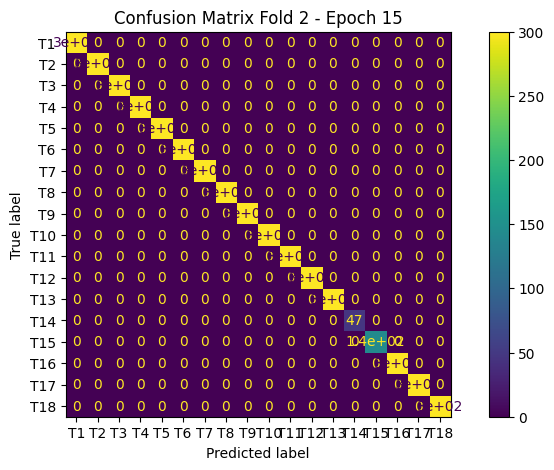

Amount of Data  Accuracy  Precision  Recall  F One
T1            300.0       1.0        1.0     1.0    1.0
T2            300.0       1.0        1.0     1.0    1.0
T3            300.0       1.0        1.0     1.0    1.0
T4            300.0       1.0        1.0     1.0    1.0
T5            300.0       1.0        1.0     1.0    1.0
T6            300.0       1.0        1.0     1.0    1.0
T7            300.0       1.0        1.0     1.0    1.0
T8            300.0       1.0        1.0     1.0    1.0
T9            300.0       1.0        1.0     1.0    1.0
T10           300.0       1.0        1.0     1.0    1.0
T11           300.0       1.0        1.0     1.0    1.0
T12           300.0       1.0        1.0     1.0    1.0
T13           300.0       1.0        1.0     1.0    1.0
T14            47.0       1.0        1.0     1.0    1.0
T15           143.0       1.0        1.0     1.0    1.0
T16           300.0       1.0        1.0     1.0    1.0
T17           300.0       1.0        1.0     1.0    1.0
T18           300.0       1.0        1.0     1.0    1.0

 75%|████████████████████████████████▎          | 15/20 [03:30<01:13, 14.72s/it]

Epoch 16 / 20


==:==:==Train==:==:==: 0it [00:10, ?it/s]


Average Loss Train: 0.0006720322207079987


==:==:==Valid==:==:==: 0it [00:02, ?it/s]
 80%|██████████████████████████████████▍        | 16/20 [03:43<00:57, 14.26s/it]

Average Loss Validation: 0.000295083971324569
Time 13.19136095046997

Epoch 17 / 20


==:==:==Train==:==:==: 0it [00:10, ?it/s]


Average Loss Train: 0.0006343633577359726


==:==:==Valid==:==:==: 0it [00:02, ?it/s]
 85%|████████████████████████████████████▌      | 17/20 [03:56<00:41, 13.93s/it]

Average Loss Validation: 0.0002868807335236746
Time 13.146917819976807

Epoch 18 / 20


==:==:==Train==:==:==: 0it [00:10, ?it/s]


Average Loss Train: 0.000579191922165786


==:==:==Valid==:==:==: 0it [00:02, ?it/s]
 90%|██████████████████████████████████████▋    | 18/20 [04:09<00:27, 13.67s/it]

Average Loss Validation: 0.0002512708157002329
Time 13.073745012283325

Epoch 19 / 20


==:==:==Train==:==:==: 0it [00:11, ?it/s]


Average Loss Train: 0.0005321656347006406


==:==:==Valid==:==:==: 0it [00:02, ?it/s]
 95%|████████████████████████████████████████▊  | 19/20 [04:22<00:13, 13.57s/it]

Average Loss Validation: 0.0002351482856070589
Time 13.301711082458496

Epoch 20 / 20


==:==:==Train==:==:==: 0it [00:11, ?it/s]


Average Loss Train: 0.0004860951967996882


==:==:==Valid==:==:==: 0it [00:02, ?it/s]


Average Loss Validation: 0.00021339703205681756
Time 13.176183700561523



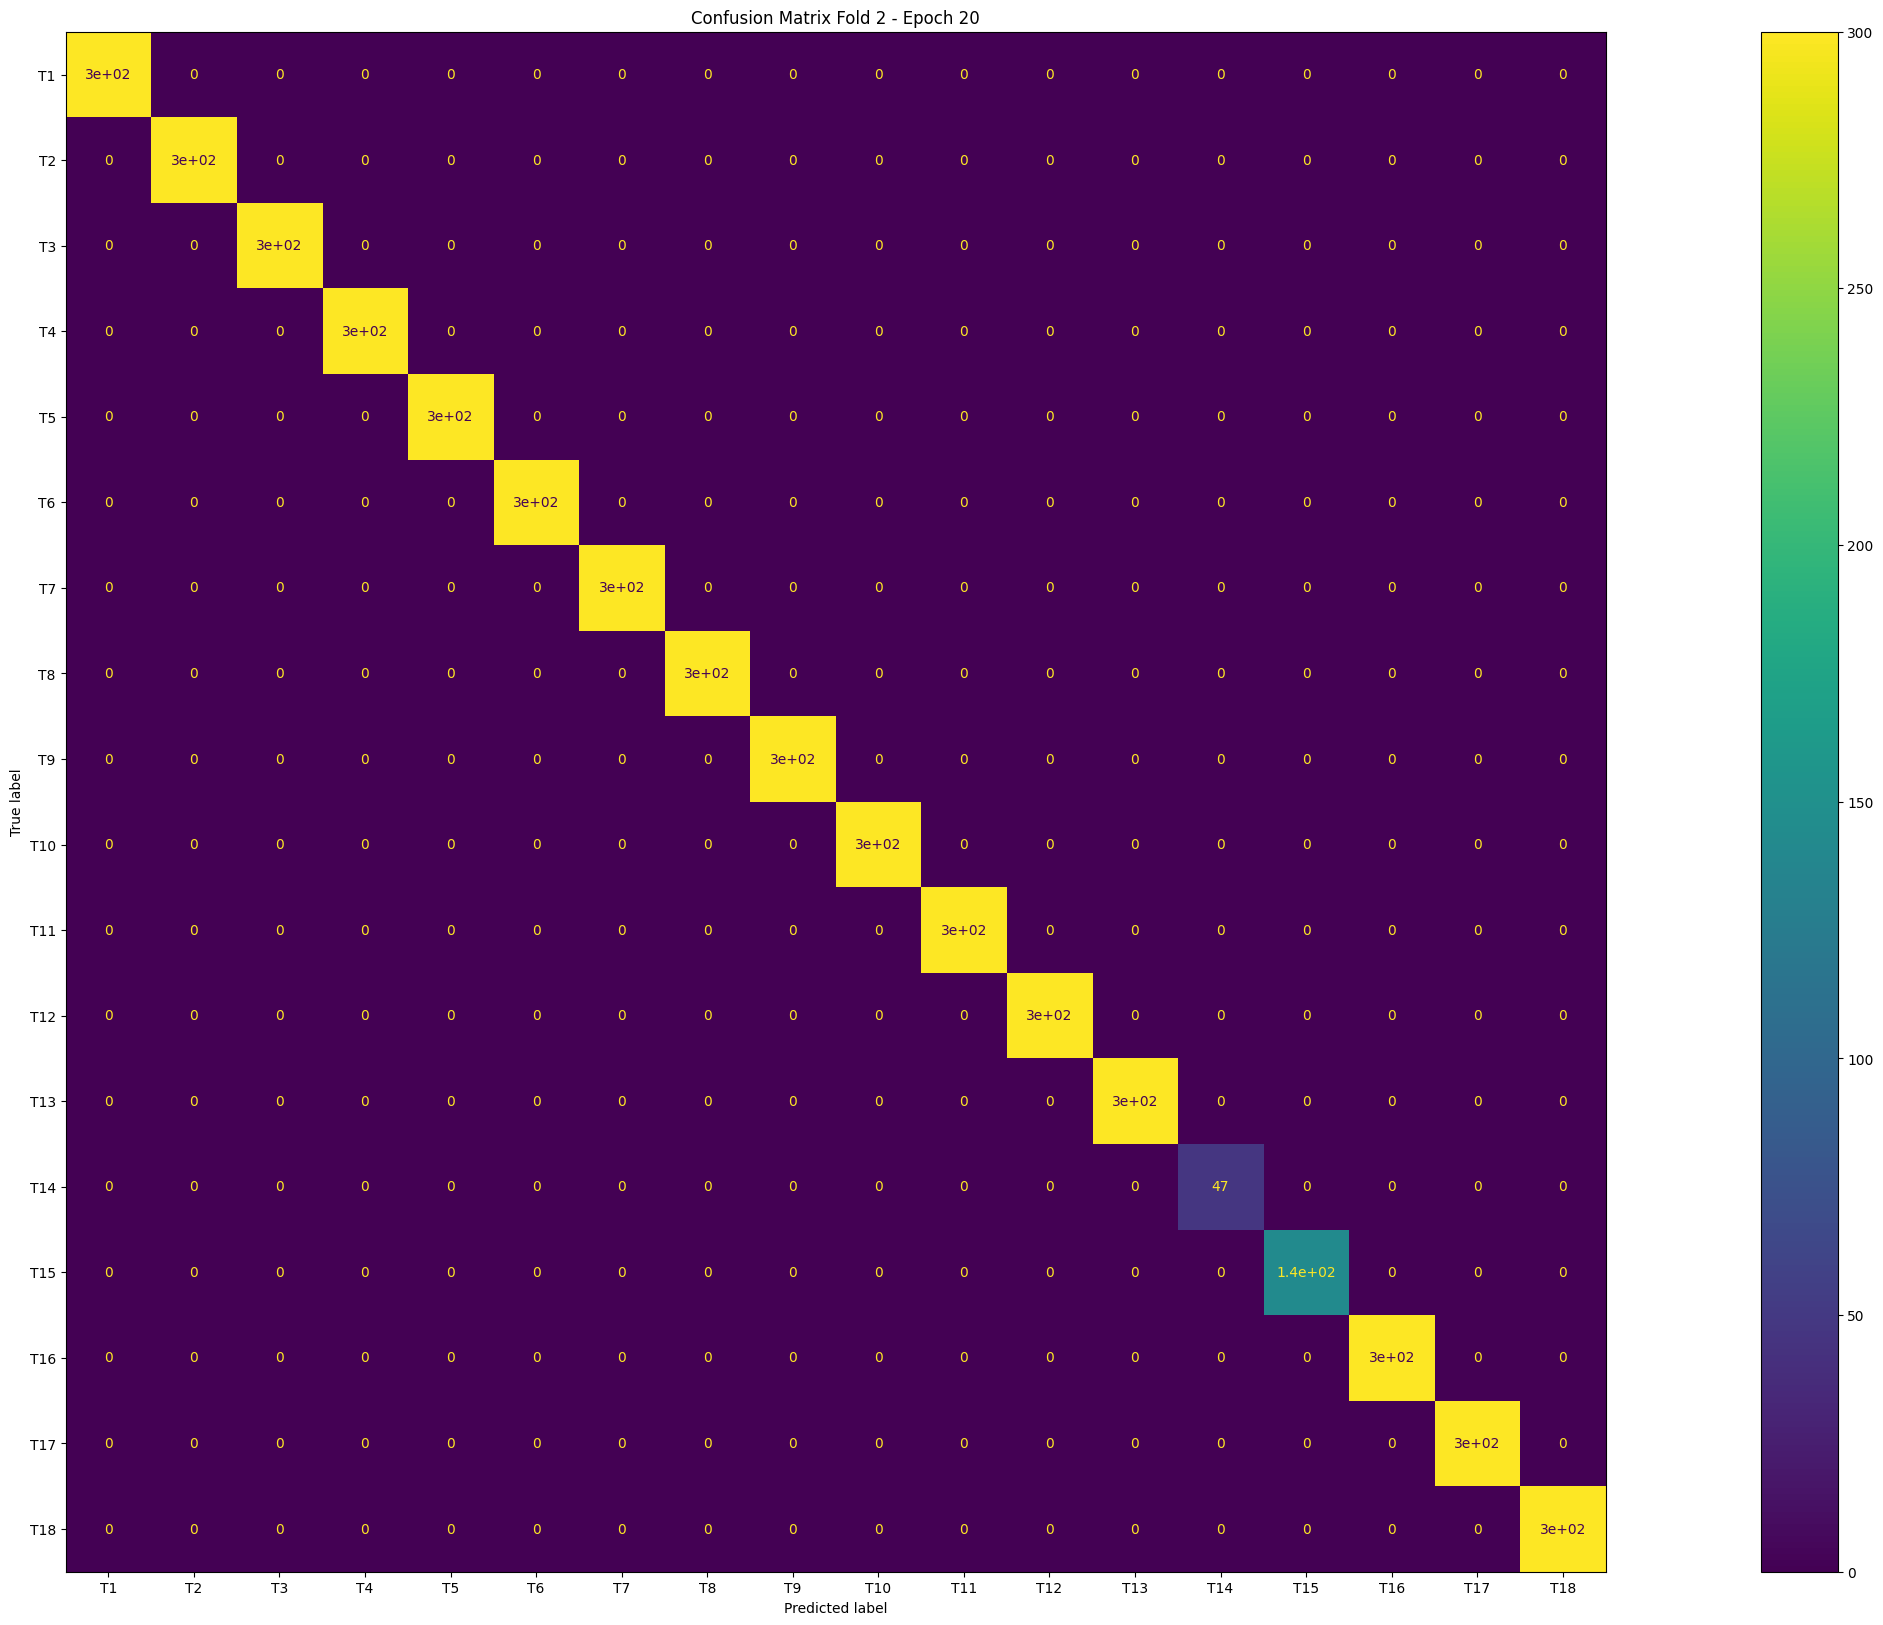

Amount of Data  Accuracy  Precision  Recall  F One
T1            300.0       1.0        1.0     1.0    1.0
T2            300.0       1.0        1.0     1.0    1.0
T3            300.0       1.0        1.0     1.0    1.0
T4            300.0       1.0        1.0     1.0    1.0
T5            300.0       1.0        1.0     1.0    1.0
T6            300.0       1.0        1.0     1.0    1.0
T7            300.0       1.0        1.0     1.0    1.0
T8            300.0       1.0        1.0     1.0    1.0
T9            300.0       1.0        1.0     1.0    1.0
T10           300.0       1.0        1.0     1.0    1.0
T11           300.0       1.0        1.0     1.0    1.0
T12           300.0       1.0        1.0     1.0    1.0
T13           300.0       1.0        1.0     1.0    1.0
T14            47.0       1.0        1.0     1.0    1.0
T15           143.0       1.0        1.0     1.0    1.0
T16           300.0       1.0        1.0     1.0    1.0
T17           300.0       1.0        1.0     1.0    1.0
T18           300.0       1.0        1.0     1.0    1.0

100%|███████████████████████████████████████████| 20/20 [04:40<00:00, 14.02s/it]
2it [09:27, 284.13s/it]/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


=====:=====:=====:=====:===== Fold 3 =====:=====:=====:=====:=====


2it [09:31, 284.13s/it]

Fold 3 Ready


  0%|                                                    | 0/20 [00:00<?, ?it/s]

Epoch 1 / 20


==:==:==Train==:==:==: 0it [00:10, ?it/s]


Average Loss Train: 0.031329607630318265


==:==:==Valid==:==:==: 0it [00:02, ?it/s]
  5%|██▏                                         | 1/20 [00:13<04:09, 13.12s/it]

Average Loss Validation: 0.011885667193628742
Time 13.116883277893066

Epoch 2 / 20


==:==:==Train==:==:==: 0it [00:10, ?it/s]


Average Loss Train: 0.010735427490916343


==:==:==Valid==:==:==: 0it [00:02, ?it/s]
 10%|████▍                                       | 2/20 [00:26<03:57, 13.18s/it]

Average Loss Validation: 0.004433827448584035
Time 13.204405546188354

Epoch 3 / 20


==:==:==Train==:==:==: 0it [00:10, ?it/s]


Average Loss Train: 0.0058292793798205384


==:==:==Valid==:==:==: 0it [00:02, ?it/s]
 15%|██████▌                                     | 3/20 [00:39<03:43, 13.15s/it]

Average Loss Validation: 0.0025479692719384043
Time 13.107651472091675

Epoch 4 / 20


==:==:==Train==:==:==: 0it [00:10, ?it/s]


Average Loss Train: 0.0038867822416822104


==:==:==Valid==:==:==: 0it [00:02, ?it/s]
 20%|████████▊                                   | 4/20 [00:52<03:30, 13.15s/it]

Average Loss Validation: 0.0017385711740396305
Time 13.127074480056763

Epoch 5 / 20


==:==:==Train==:==:==: 0it [00:10, ?it/s]


Average Loss Train: 0.002904429926891245


==:==:==Valid==:==:==: 0it [00:02, ?it/s]


Average Loss Validation: 0.0012657884157492307
Time 13.098810195922852



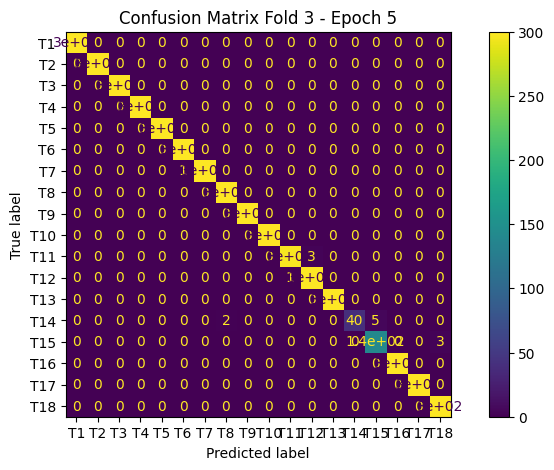

Amount of Data  Accuracy  Precision    Recall     F One
T1            300.0  1.000000   1.000000  1.000000  1.000000
T2            300.0  1.000000   1.000000  1.000000  1.000000
T3            300.0  1.000000   1.000000  1.000000  1.000000
T4            300.0  1.000000   1.000000  1.000000  1.000000
T5            300.0  1.000000   1.000000  1.000000  1.000000
T6            300.0  1.000000   0.996678  1.000000  0.998336
T7            300.0  0.996667   1.000000  0.996667  0.998331
T8            300.0  1.000000   0.993378  1.000000  0.996678
T9            300.0  1.000000   1.000000  1.000000  1.000000
T10           300.0  1.000000   1.000000  1.000000  1.000000
T11           300.0  0.990000   0.996644  0.990000  0.993311
T12           300.0  0.996667   0.990066  0.996667  0.993356
T13           300.0  1.000000   1.000000  1.000000  1.000000
T14            47.0  0.851064   1.000000  0.851064  0.919540
T15           143.0  0.979021   0.965517  0.979021  0.972222
T16           300.0  1.000000   1.000000  1.000000  1.000000
T17           300.0  1.000000   1.000000  1.000000  1.000000
T18           300.0  1.000000   0.990099  1.000000  0.995025

 25%|███████████                                 | 5/20 [01:09<03:39, 14.65s/it]

Epoch 6 / 20


==:==:==Train==:==:==: 0it [00:10, ?it/s]


Average Loss Train: 0.002347803738885112


==:==:==Valid==:==:==: 0it [00:02, ?it/s]
 30%|█████████████▏                              | 6/20 [01:23<03:17, 14.13s/it]

Average Loss Validation: 0.001067744005090727
Time 13.103121280670166

Epoch 7 / 20


==:==:==Train==:==:==: 0it [00:10, ?it/s]


Average Loss Train: 0.001943948898380645


==:==:==Valid==:==:==: 0it [00:02, ?it/s]
 35%|███████████████▍                            | 7/20 [01:36<02:59, 13.81s/it]

Average Loss Validation: 0.0008642446331844062
Time 13.140954494476318

Epoch 8 / 20


==:==:==Train==:==:==: 0it [00:11, ?it/s]


Average Loss Train: 0.0016560464011996358


==:==:==Valid==:==:==: 0it [00:02, ?it/s]
 40%|█████████████████▌                          | 8/20 [01:49<02:44, 13.68s/it]

Average Loss Validation: 0.000745104318988586
Time 13.399102687835693

Epoch 9 / 20


==:==:==Train==:==:==: 0it [00:11, ?it/s]


Average Loss Train: 0.001440798646999644


==:==:==Valid==:==:==: 0it [00:02, ?it/s]
 45%|███████████████████▊                        | 9/20 [02:02<02:29, 13.56s/it]

Average Loss Validation: 0.0006728846154255953
Time 13.284064769744873

Epoch 10 / 20


==:==:==Train==:==:==: 0it [00:10, ?it/s]


Average Loss Train: 0.0012967720044384224


==:==:==Valid==:==:==: 0it [00:02, ?it/s]


Average Loss Validation: 0.0005881210755489632
Time 13.222815752029419



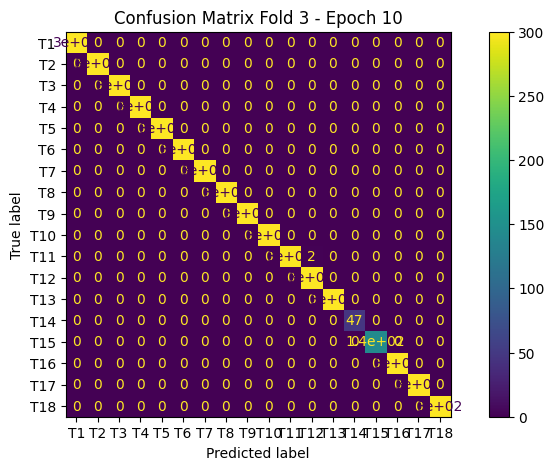

Amount of Data  Accuracy  Precision    Recall     F One
T1            300.0  1.000000   1.000000  1.000000  1.000000
T2            300.0  1.000000   1.000000  1.000000  1.000000
T3            300.0  1.000000   1.000000  1.000000  1.000000
T4            300.0  1.000000   1.000000  1.000000  1.000000
T5            300.0  1.000000   1.000000  1.000000  1.000000
T6            300.0  1.000000   1.000000  1.000000  1.000000
T7            300.0  1.000000   1.000000  1.000000  1.000000
T8            300.0  1.000000   1.000000  1.000000  1.000000
T9            300.0  1.000000   1.000000  1.000000  1.000000
T10           300.0  1.000000   1.000000  1.000000  1.000000
T11           300.0  0.993333   1.000000  0.993333  0.996656
T12           300.0  1.000000   0.993378  1.000000  0.996678
T13           300.0  1.000000   1.000000  1.000000  1.000000
T14            47.0  1.000000   1.000000  1.000000  1.000000
T15           143.0  1.000000   1.000000  1.000000  1.000000
T16           300.0  1.000000   1.000000  1.000000  1.000000
T17           300.0  1.000000   1.000000  1.000000  1.000000
T18           300.0  1.000000   1.000000  1.000000  1.000000

 50%|█████████████████████▌                     | 10/20 [02:20<02:28, 14.80s/it]

Epoch 11 / 20


==:==:==Train==:==:==: 0it [00:10, ?it/s]


Average Loss Train: 0.001155323758822131


==:==:==Valid==:==:==: 0it [00:02, ?it/s]
 55%|███████████████████████▋                   | 11/20 [02:33<02:08, 14.31s/it]

Average Loss Validation: 0.0005477062771787385
Time 13.16771912574768

Epoch 12 / 20


==:==:==Train==:==:==: 0it [00:10, ?it/s]


Average Loss Train: 0.0010490247114830662


==:==:==Valid==:==:==: 0it [00:02, ?it/s]
 60%|█████████████████████████▊                 | 12/20 [02:46<01:51, 13.98s/it]

Average Loss Validation: 0.0004919491678416609
Time 13.238677978515625

Epoch 13 / 20


==:==:==Train==:==:==: 0it [00:10, ?it/s]


Average Loss Train: 0.0009286991488935952


==:==:==Valid==:==:==: 0it [00:02, ?it/s]
 65%|███████████████████████████▉               | 13/20 [03:00<01:36, 13.74s/it]

Average Loss Validation: 0.0004501162343219908
Time 13.176511287689209

Epoch 14 / 20


==:==:==Train==:==:==: 0it [00:10, ?it/s]


Average Loss Train: 0.0008748784798651562


==:==:==Valid==:==:==: 0it [00:02, ?it/s]
 70%|██████████████████████████████             | 14/20 [03:13<01:21, 13.61s/it]

Average Loss Validation: 0.0004077898834893603
Time 13.285451412200928

Epoch 15 / 20


==:==:==Train==:==:==: 0it [00:11, ?it/s]


Average Loss Train: 0.0008117619956577656


==:==:==Valid==:==:==: 0it [00:02, ?it/s]


Average Loss Validation: 0.00038834053030114375
Time 13.36156153678894



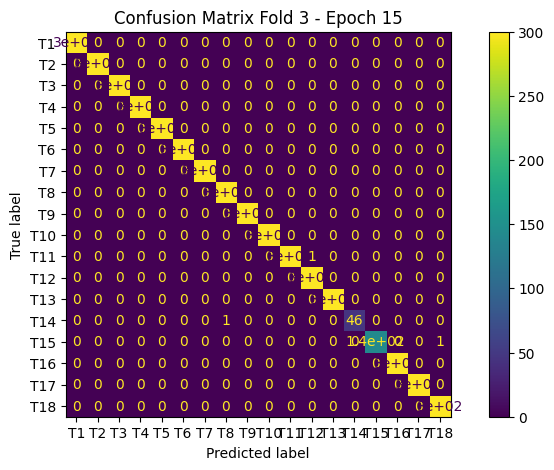

Amount of Data  Accuracy  Precision    Recall     F One
T1            300.0  1.000000   1.000000  1.000000  1.000000
T2            300.0  1.000000   1.000000  1.000000  1.000000
T3            300.0  1.000000   1.000000  1.000000  1.000000
T4            300.0  1.000000   1.000000  1.000000  1.000000
T5            300.0  1.000000   1.000000  1.000000  1.000000
T6            300.0  1.000000   1.000000  1.000000  1.000000
T7            300.0  1.000000   1.000000  1.000000  1.000000
T8            300.0  1.000000   0.996678  1.000000  0.998336
T9            300.0  1.000000   1.000000  1.000000  1.000000
T10           300.0  1.000000   1.000000  1.000000  1.000000
T11           300.0  0.996667   1.000000  0.996667  0.998331
T12           300.0  1.000000   0.996678  1.000000  0.998336
T13           300.0  1.000000   1.000000  1.000000  1.000000
T14            47.0  0.978723   1.000000  0.978723  0.989247
T15           143.0  0.993007   1.000000  0.993007  0.996491
T16           300.0  1.000000   1.000000  1.000000  1.000000
T17           300.0  1.000000   1.000000  1.000000  1.000000
T18           300.0  1.000000   0.996678  1.000000  0.998336

 75%|████████████████████████████████▎          | 15/20 [03:31<01:15, 15.02s/it]

Epoch 16 / 20


==:==:==Train==:==:==: 0it [00:11, ?it/s]


Average Loss Train: 0.0007354530278755855


==:==:==Valid==:==:==: 0it [00:02, ?it/s]
 80%|██████████████████████████████████▍        | 16/20 [03:44<00:58, 14.51s/it]

Average Loss Validation: 0.00036020750974963804
Time 13.303937673568726

Epoch 17 / 20


==:==:==Train==:==:==: 0it [00:11, ?it/s]


Average Loss Train: 0.0006729638046557449


==:==:==Valid==:==:==: 0it [00:02, ?it/s]
 85%|████████████████████████████████████▌      | 17/20 [03:58<00:42, 14.15s/it]

Average Loss Validation: 0.00032080598978068164
Time 13.3069589138031

Epoch 18 / 20


==:==:==Train==:==:==: 0it [00:10, ?it/s]


Average Loss Train: 0.0006265886057776468


==:==:==Valid==:==:==: 0it [00:02, ?it/s]
 90%|██████████████████████████████████████▋    | 18/20 [04:11<00:27, 13.87s/it]

Average Loss Validation: 0.0002979153364090499
Time 13.203806161880493

Epoch 19 / 20


==:==:==Train==:==:==: 0it [00:10, ?it/s]


Average Loss Train: 0.0005766720079487618


==:==:==Valid==:==:==: 0it [00:02, ?it/s]
 95%|████████████████████████████████████████▊  | 19/20 [04:24<00:13, 13.68s/it]

Average Loss Validation: 0.0002691404824938349
Time 13.247211694717407

Epoch 20 / 20


==:==:==Train==:==:==: 0it [00:10, ?it/s]


Average Loss Train: 0.0005521827860886573


==:==:==Valid==:==:==: 0it [00:02, ?it/s]


Average Loss Validation: 0.0002481964426133819
Time 13.257689476013184



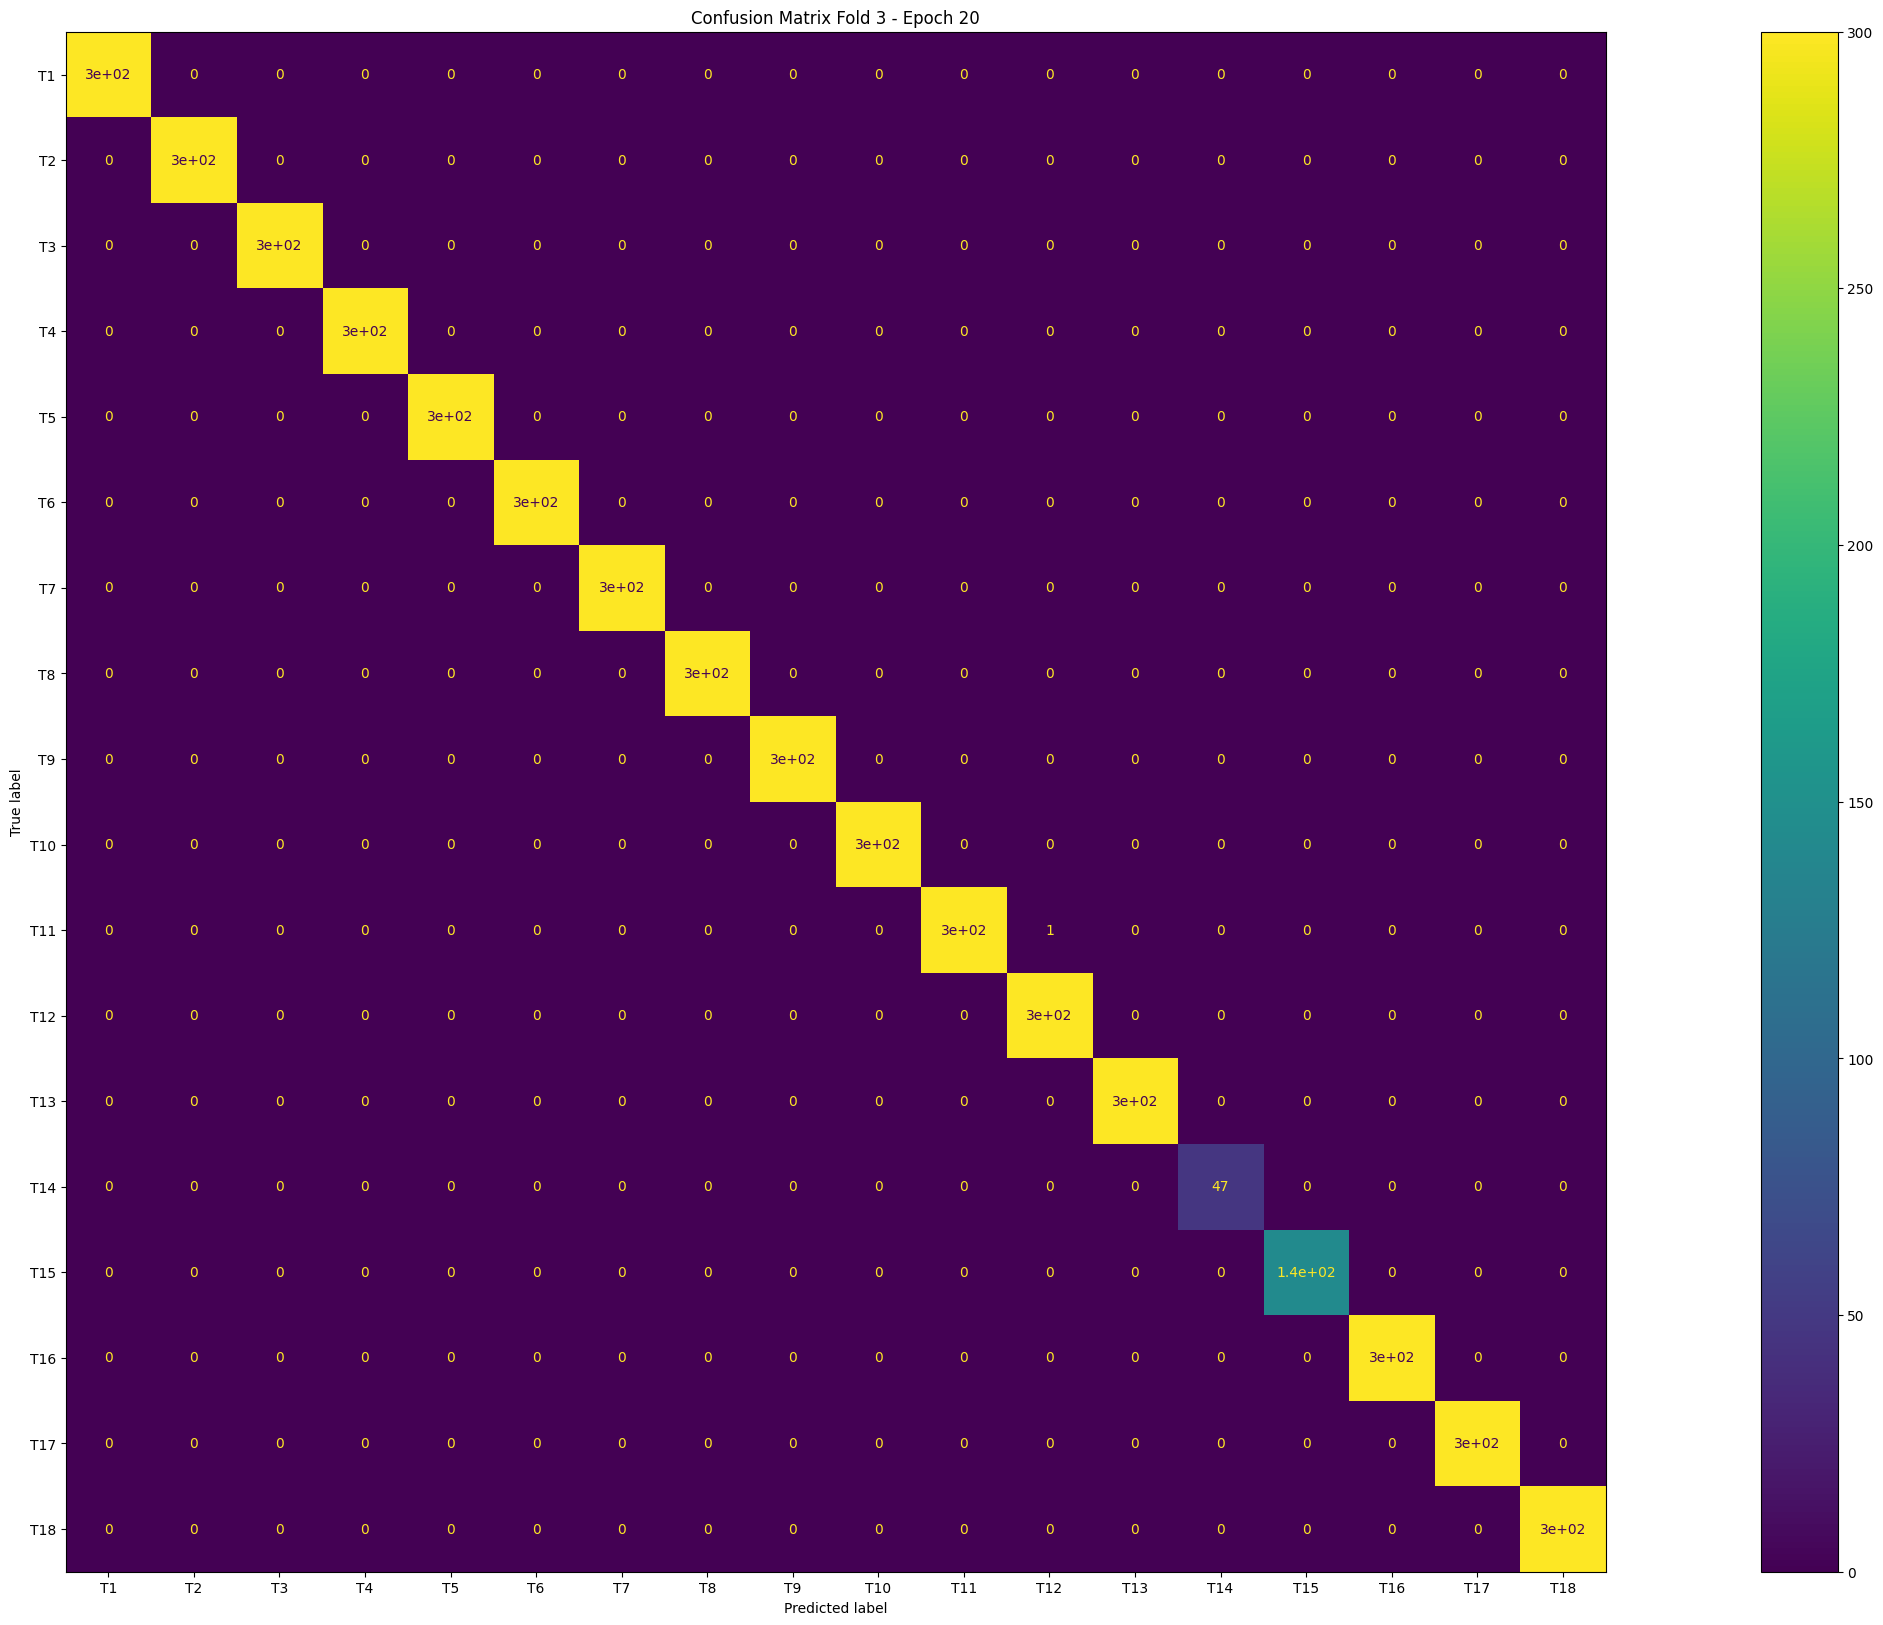

Amount of Data  Accuracy  Precision    Recall     F One
T1            300.0  1.000000   1.000000  1.000000  1.000000
T2            300.0  1.000000   1.000000  1.000000  1.000000
T3            300.0  1.000000   1.000000  1.000000  1.000000
T4            300.0  1.000000   1.000000  1.000000  1.000000
T5            300.0  1.000000   1.000000  1.000000  1.000000
T6            300.0  1.000000   1.000000  1.000000  1.000000
T7            300.0  1.000000   1.000000  1.000000  1.000000
T8            300.0  1.000000   1.000000  1.000000  1.000000
T9            300.0  1.000000   1.000000  1.000000  1.000000
T10           300.0  1.000000   1.000000  1.000000  1.000000
T11           300.0  0.996667   1.000000  0.996667  0.998331
T12           300.0  1.000000   0.996678  1.000000  0.998336
T13           300.0  1.000000   1.000000  1.000000  1.000000
T14            47.0  1.000000   1.000000  1.000000  1.000000
T15           143.0  1.000000   1.000000  1.000000  1.000000
T16           300.0  1.000000   1.000000  1.000000  1.000000
T17           300.0  1.000000   1.000000  1.000000  1.000000
T18           300.0  1.000000   1.000000  1.000000  1.000000

100%|███████████████████████████████████████████| 20/20 [04:43<00:00, 14.16s/it]
3it [14:15, 285.50s/it]/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


=====:=====:=====:=====:===== Fold 4 =====:=====:=====:=====:=====


3it [14:21, 285.50s/it]

Fold 4 Ready


  0%|                                                    | 0/20 [00:00<?, ?it/s]

Epoch 1 / 20


==:==:==Train==:==:==: 0it [00:11, ?it/s]


Average Loss Train: 0.031279831573782925


==:==:==Valid==:==:==: 0it [00:02, ?it/s]
  5%|██▏                                         | 1/20 [00:13<04:12, 13.28s/it]

Average Loss Validation: 0.011472840383200941
Time 13.26767873764038

Epoch 2 / 20


==:==:==Train==:==:==: 0it [00:10, ?it/s]


Average Loss Train: 0.010771931574904938


==:==:==Valid==:==:==: 0it [00:02, ?it/s]
 10%|████▍                                       | 2/20 [00:26<03:58, 13.24s/it]

Average Loss Validation: 0.004207991505553106
Time 13.206377029418945

Epoch 3 / 20


==:==:==Train==:==:==: 0it [00:11, ?it/s]


Average Loss Train: 0.005658494954978492


==:==:==Valid==:==:==: 0it [00:02, ?it/s]
 15%|██████▌                                     | 3/20 [00:39<03:45, 13.28s/it]

Average Loss Validation: 0.0023241773919614856
Time 13.313064575195312

Epoch 4 / 20


==:==:==Train==:==:==: 0it [00:10, ?it/s]


Average Loss Train: 0.003751913241881191


==:==:==Valid==:==:==: 0it [00:02, ?it/s]
 20%|████████▊                                   | 4/20 [00:53<03:32, 13.30s/it]

Average Loss Validation: 0.0015344830397852438
Time 13.31815481185913

Epoch 5 / 20


==:==:==Train==:==:==: 0it [00:11, ?it/s]


Average Loss Train: 0.0027263564162673336


==:==:==Valid==:==:==: 0it [00:02, ?it/s]


Average Loss Validation: 0.0011254917135936225
Time 13.65956449508667



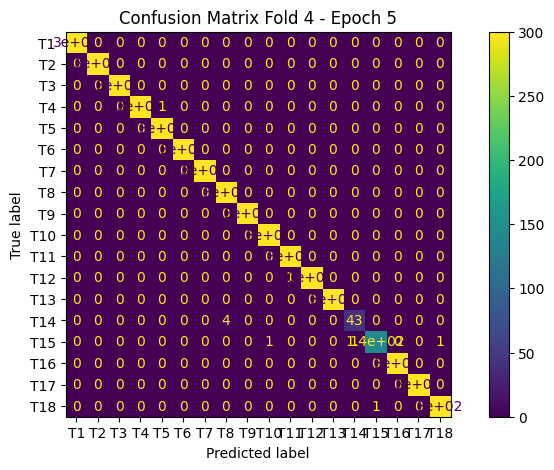

Amount of Data  Accuracy  Precision    Recall     F One
T1            300.0  1.000000   1.000000  1.000000  1.000000
T2            300.0  1.000000   1.000000  1.000000  1.000000
T3            300.0  1.000000   1.000000  1.000000  1.000000
T4            300.0  0.996667   1.000000  0.996667  0.998331
T5            300.0  1.000000   0.996678  1.000000  0.998336
T6            300.0  1.000000   1.000000  1.000000  1.000000
T7            300.0  1.000000   1.000000  1.000000  1.000000
T8            300.0  1.000000   0.986842  1.000000  0.993377
T9            300.0  1.000000   1.000000  1.000000  1.000000
T10           300.0  1.000000   0.996678  1.000000  0.998336
T11           300.0  1.000000   0.996678  1.000000  0.998336
T12           300.0  0.996667   1.000000  0.996667  0.998331
T13           300.0  1.000000   1.000000  1.000000  1.000000
T14            47.0  0.914894   0.977273  0.914894  0.945055
T15           143.0  0.979021   0.992908  0.979021  0.985915
T16           300.0  1.000000   1.000000  1.000000  1.000000
T17           300.0  1.000000   1.000000  1.000000  1.000000
T18           300.0  0.996667   0.996667  0.996667  0.996667

 25%|███████████                                 | 5/20 [01:11<03:45, 15.01s/it]

Epoch 6 / 20


==:==:==Train==:==:==: 0it [00:11, ?it/s]


Average Loss Train: 0.0021479368041126758


==:==:==Valid==:==:==: 0it [00:02, ?it/s]
 30%|█████████████▏                              | 6/20 [01:24<03:22, 14.47s/it]

Average Loss Validation: 0.0009144711903555838
Time 13.410904884338379

Epoch 7 / 20


==:==:==Train==:==:==: 0it [00:11, ?it/s]


Average Loss Train: 0.0017957357187427826


==:==:==Valid==:==:==: 0it [00:02, ?it/s]
 35%|███████████████▍                            | 7/20 [01:38<03:03, 14.15s/it]

Average Loss Validation: 0.0007515963025107413
Time 13.481375694274902

Epoch 8 / 20


==:==:==Train==:==:==: 0it [00:11, ?it/s]


Average Loss Train: 0.0015043596015814507


==:==:==Valid==:==:==: 0it [00:02, ?it/s]
 40%|█████████████████▌                          | 8/20 [01:51<02:47, 13.94s/it]

Average Loss Validation: 0.0006450923633778502
Time 13.467971086502075

Epoch 9 / 20


==:==:==Train==:==:==: 0it [00:11, ?it/s]


Average Loss Train: 0.0013227677174772136


==:==:==Valid==:==:==: 0it [00:02, ?it/s]
 45%|███████████████████▊                        | 9/20 [02:05<02:31, 13.79s/it]

Average Loss Validation: 0.0005837127805233957
Time 13.43952989578247

Epoch 10 / 20


==:==:==Train==:==:==: 0it [00:11, ?it/s]


Average Loss Train: 0.0011615840045634553


==:==:==Valid==:==:==: 0it [00:02, ?it/s]


Average Loss Validation: 0.0005213732631477659
Time 13.346927165985107



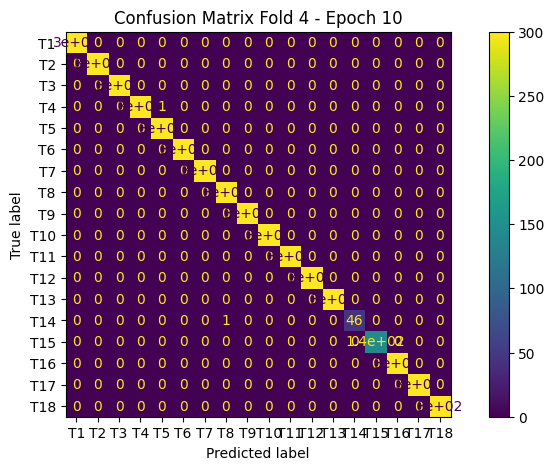

Amount of Data  Accuracy  Precision    Recall     F One
T1            300.0  1.000000   1.000000  1.000000  1.000000
T2            300.0  1.000000   1.000000  1.000000  1.000000
T3            300.0  1.000000   1.000000  1.000000  1.000000
T4            300.0  0.996667   1.000000  0.996667  0.998331
T5            300.0  1.000000   0.996678  1.000000  0.998336
T6            300.0  1.000000   1.000000  1.000000  1.000000
T7            300.0  1.000000   1.000000  1.000000  1.000000
T8            300.0  1.000000   0.996678  1.000000  0.998336
T9            300.0  1.000000   1.000000  1.000000  1.000000
T10           300.0  1.000000   1.000000  1.000000  1.000000
T11           300.0  1.000000   1.000000  1.000000  1.000000
T12           300.0  1.000000   1.000000  1.000000  1.000000
T13           300.0  1.000000   1.000000  1.000000  1.000000
T14            47.0  0.978723   1.000000  0.978723  0.989247
T15           143.0  1.000000   1.000000  1.000000  1.000000
T16           300.0  1.000000   1.000000  1.000000  1.000000
T17           300.0  1.000000   1.000000  1.000000  1.000000
T18           300.0  1.000000   1.000000  1.000000  1.000000

 50%|█████████████████████▌                     | 10/20 [02:23<02:31, 15.18s/it]

Epoch 11 / 20


==:==:==Train==:==:==: 0it [00:11, ?it/s]


Average Loss Train: 0.001028697228538901


==:==:==Valid==:==:==: 0it [00:02, ?it/s]
 55%|███████████████████████▋                   | 11/20 [02:36<02:11, 14.65s/it]

Average Loss Validation: 0.0004607177561593199
Time 13.428348779678345

Epoch 12 / 20


==:==:==Train==:==:==: 0it [00:10, ?it/s]


Average Loss Train: 0.0009445461880007521


==:==:==Valid==:==:==: 0it [00:02, ?it/s]
 60%|█████████████████████████▊                 | 12/20 [02:49<01:53, 14.21s/it]

Average Loss Validation: 0.00042487252578288616
Time 13.18230938911438

Epoch 13 / 20


==:==:==Train==:==:==: 0it [00:11, ?it/s]


Average Loss Train: 0.0008529781642774023


==:==:==Valid==:==:==: 0it [00:02, ?it/s]
 65%|███████████████████████████▉               | 13/20 [03:03<01:37, 13.99s/it]

Average Loss Validation: 0.0003910371914267062
Time 13.470056295394897

Epoch 14 / 20


==:==:==Train==:==:==: 0it [00:11, ?it/s]


Average Loss Train: 0.0008082871618460668


==:==:==Valid==:==:==: 0it [00:02, ?it/s]
 70%|██████████████████████████████             | 14/20 [03:17<01:23, 13.87s/it]

Average Loss Validation: 0.0003571981422319441
Time 13.607852220535278

Epoch 15 / 20


==:==:==Train==:==:==: 0it [00:11, ?it/s]


Average Loss Train: 0.0007334254395776028


==:==:==Valid==:==:==: 0it [00:02, ?it/s]


Average Loss Validation: 0.0003183000857282975
Time 13.508923053741455



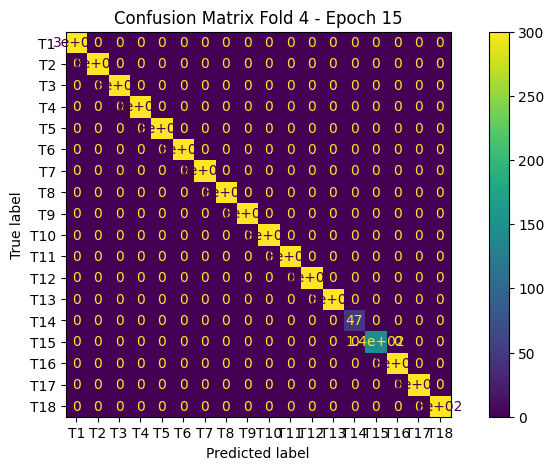

Amount of Data  Accuracy  Precision  Recall  F One
T1            300.0       1.0        1.0     1.0    1.0
T2            300.0       1.0        1.0     1.0    1.0
T3            300.0       1.0        1.0     1.0    1.0
T4            300.0       1.0        1.0     1.0    1.0
T5            300.0       1.0        1.0     1.0    1.0
T6            300.0       1.0        1.0     1.0    1.0
T7            300.0       1.0        1.0     1.0    1.0
T8            300.0       1.0        1.0     1.0    1.0
T9            300.0       1.0        1.0     1.0    1.0
T10           300.0       1.0        1.0     1.0    1.0
T11           300.0       1.0        1.0     1.0    1.0
T12           300.0       1.0        1.0     1.0    1.0
T13           300.0       1.0        1.0     1.0    1.0
T14            47.0       1.0        1.0     1.0    1.0
T15           143.0       1.0        1.0     1.0    1.0
T16           300.0       1.0        1.0     1.0    1.0
T17           300.0       1.0        1.0     1.0    1.0
T18           300.0       1.0        1.0     1.0    1.0

 75%|████████████████████████████████▎          | 15/20 [03:35<01:16, 15.21s/it]

Epoch 16 / 20


==:==:==Train==:==:==: 0it [00:11, ?it/s]


Average Loss Train: 0.000668862342526909


==:==:==Valid==:==:==: 0it [00:02, ?it/s]
 80%|██████████████████████████████████▍        | 16/20 [03:48<00:58, 14.72s/it]

Average Loss Validation: 0.0003091438507329008
Time 13.579721450805664

Epoch 17 / 20


==:==:==Train==:==:==: 0it [00:11, ?it/s]


Average Loss Train: 0.000625652502342274


==:==:==Valid==:==:==: 0it [00:02, ?it/s]
 85%|████████████████████████████████████▌      | 17/20 [04:02<00:43, 14.36s/it]

Average Loss Validation: 0.00027822391736602973
Time 13.494966745376587

Epoch 18 / 20


==:==:==Train==:==:==: 0it [00:11, ?it/s]


Average Loss Train: 0.0005426262668419097


==:==:==Valid==:==:==: 0it [00:02, ?it/s]
 90%|██████████████████████████████████████▋    | 18/20 [04:15<00:28, 14.06s/it]

Average Loss Validation: 0.0002454547202195935
Time 13.369501113891602

Epoch 19 / 20


==:==:==Train==:==:==: 0it [00:11, ?it/s]


Average Loss Train: 0.000515298617417806


==:==:==Valid==:==:==: 0it [00:02, ?it/s]
 95%|████████████████████████████████████████▊  | 19/20 [04:29<00:13, 13.85s/it]

Average Loss Validation: 0.00022856739344064123
Time 13.347217798233032

Epoch 20 / 20


==:==:==Train==:==:==: 0it [00:11, ?it/s]


Average Loss Train: 0.0005168618525072195


==:==:==Valid==:==:==: 0it [00:02, ?it/s]


Average Loss Validation: 0.00020825194347955897
Time 13.377469539642334



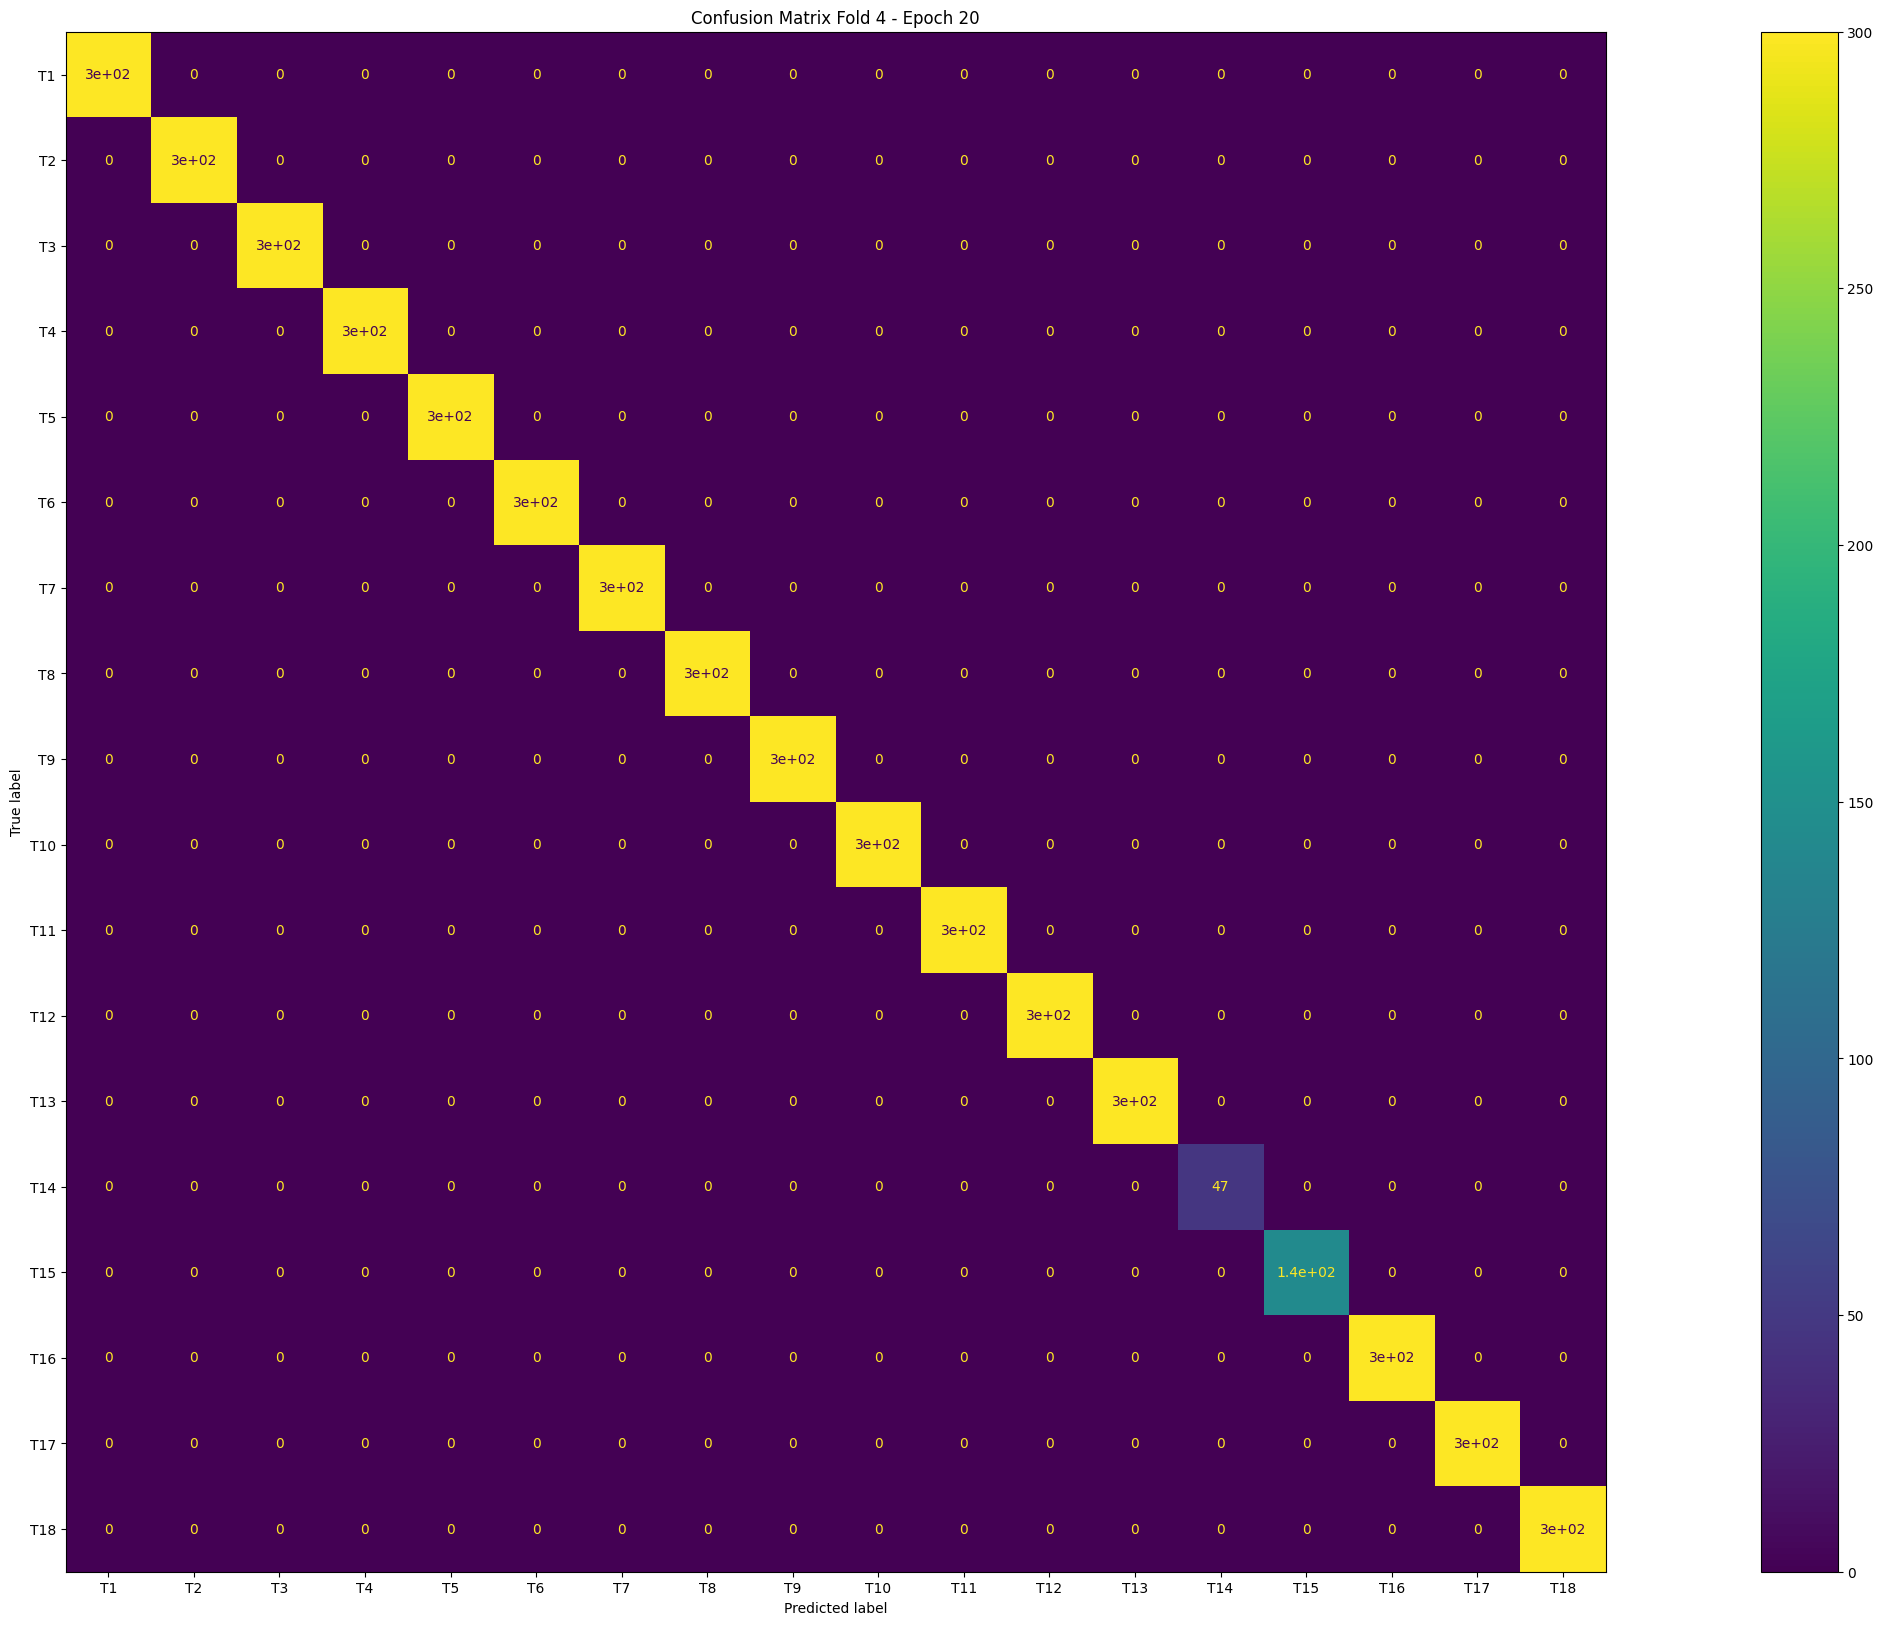

Amount of Data  Accuracy  Precision  Recall  F One
T1            300.0       1.0        1.0     1.0    1.0
T2            300.0       1.0        1.0     1.0    1.0
T3            300.0       1.0        1.0     1.0    1.0
T4            300.0       1.0        1.0     1.0    1.0
T5            300.0       1.0        1.0     1.0    1.0
T6            300.0       1.0        1.0     1.0    1.0
T7            300.0       1.0        1.0     1.0    1.0
T8            300.0       1.0        1.0     1.0    1.0
T9            300.0       1.0        1.0     1.0    1.0
T10           300.0       1.0        1.0     1.0    1.0
T11           300.0       1.0        1.0     1.0    1.0
T12           300.0       1.0        1.0     1.0    1.0
T13           300.0       1.0        1.0     1.0    1.0
T14            47.0       1.0        1.0     1.0    1.0
T15           143.0       1.0        1.0     1.0    1.0
T16           300.0       1.0        1.0     1.0    1.0
T17           300.0       1.0        1.0     1.0    1.0
T18           300.0       1.0        1.0     1.0    1.0

100%|███████████████████████████████████████████| 20/20 [04:47<00:00, 14.39s/it]
4it [19:09, 289.07s/it]/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


=====:=====:=====:=====:===== Fold 5 =====:=====:=====:=====:=====


4it [19:17, 289.07s/it]

Fold 5 Ready


  0%|                                                    | 0/20 [00:00<?, ?it/s]

Epoch 1 / 20


==:==:==Train==:==:==: 0it [00:11, ?it/s]


Average Loss Train: 0.03157809847468192


==:==:==Valid==:==:==: 0it [00:02, ?it/s]
  5%|██▏                                         | 1/20 [00:13<04:13, 13.34s/it]

Average Loss Validation: 0.012335358700436914
Time 13.332802534103394

Epoch 2 / 20


==:==:==Train==:==:==: 0it [00:11, ?it/s]


Average Loss Train: 0.010789054266992358


==:==:==Valid==:==:==: 0it [00:02, ?it/s]
 10%|████▍                                       | 2/20 [00:26<03:59, 13.33s/it]

Average Loss Validation: 0.004260710428257982
Time 13.308716058731079

Epoch 3 / 20


==:==:==Train==:==:==: 0it [00:10, ?it/s]


Average Loss Train: 0.005606985343439618


==:==:==Valid==:==:==: 0it [00:02, ?it/s]
 15%|██████▌                                     | 3/20 [00:39<03:46, 13.30s/it]

Average Loss Validation: 0.0023123222505879067
Time 13.26026177406311

Epoch 4 / 20


==:==:==Train==:==:==: 0it [00:11, ?it/s]


Average Loss Train: 0.003776896001998686


==:==:==Valid==:==:==: 0it [00:02, ?it/s]
 20%|████████▊                                   | 4/20 [00:53<03:32, 13.29s/it]

Average Loss Validation: 0.0015718023649198497
Time 13.274793148040771

Epoch 5 / 20


==:==:==Train==:==:==: 0it [00:10, ?it/s]


Average Loss Train: 0.002791658889661481


==:==:==Valid==:==:==: 0it [00:02, ?it/s]


Average Loss Validation: 0.0011667672283424881
Time 13.225838661193848



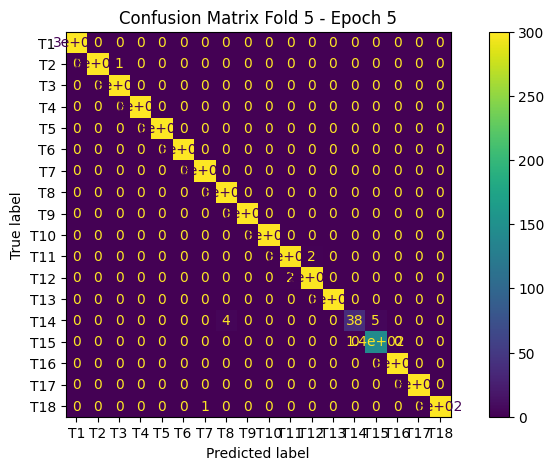

Amount of Data  Accuracy  Precision    Recall     F One
T1            300.0  1.000000   1.000000  1.000000  1.000000
T2            300.0  0.996667   1.000000  0.996667  0.998331
T3            300.0  1.000000   0.996678  1.000000  0.998336
T4            300.0  1.000000   1.000000  1.000000  1.000000
T5            300.0  1.000000   1.000000  1.000000  1.000000
T6            300.0  1.000000   1.000000  1.000000  1.000000
T7            300.0  1.000000   0.996678  1.000000  0.998336
T8            300.0  1.000000   0.986842  1.000000  0.993377
T9            300.0  1.000000   1.000000  1.000000  1.000000
T10           300.0  1.000000   1.000000  1.000000  1.000000
T11           300.0  0.993333   0.993333  0.993333  0.993333
T12           300.0  0.993333   0.993333  0.993333  0.993333
T13           300.0  1.000000   1.000000  1.000000  1.000000
T14            47.0  0.808511   1.000000  0.808511  0.894118
T15           143.0  1.000000   0.966216  1.000000  0.982818
T16           300.0  1.000000   1.000000  1.000000  1.000000
T17           300.0  1.000000   1.000000  1.000000  1.000000
T18           300.0  0.996667   1.000000  0.996667  0.998331

 25%|███████████                                 | 5/20 [01:10<03:41, 14.75s/it]

Epoch 6 / 20


==:==:==Train==:==:==: 0it [00:10, ?it/s]


Average Loss Train: 0.002203448202703061


==:==:==Valid==:==:==: 0it [00:02, ?it/s]
 30%|█████████████▏                              | 6/20 [01:23<03:19, 14.22s/it]

Average Loss Validation: 0.0009569855619647459
Time 13.176973342895508

Epoch 7 / 20


==:==:==Train==:==:==: 0it [00:10, ?it/s]


Average Loss Train: 0.0018127319779002375


==:==:==Valid==:==:==: 0it [00:02, ?it/s]
 35%|███████████████▍                            | 7/20 [01:36<03:00, 13.88s/it]

Average Loss Validation: 0.0007987279549450101
Time 13.160037755966187

Epoch 8 / 20


==:==:==Train==:==:==: 0it [00:10, ?it/s]


Average Loss Train: 0.0015652493544937786


==:==:==Valid==:==:==: 0it [00:02, ?it/s]
 40%|█████████████████▌                          | 8/20 [01:49<02:43, 13.59s/it]

Average Loss Validation: 0.0007123526140957892
Time 12.953075647354126

Epoch 9 / 20


==:==:==Train==:==:==: 0it [00:10, ?it/s]


Average Loss Train: 0.0013904006924316153


==:==:==Valid==:==:==: 0it [00:02, ?it/s]
 45%|███████████████████▊                        | 9/20 [02:03<02:28, 13.46s/it]

Average Loss Validation: 0.0006132243936489484
Time 13.178993225097656

Epoch 10 / 20


==:==:==Train==:==:==: 0it [00:10, ?it/s]


Average Loss Train: 0.0012162258661639553


==:==:==Valid==:==:==: 0it [00:02, ?it/s]


Average Loss Validation: 0.000551110652381767
Time 12.99846625328064



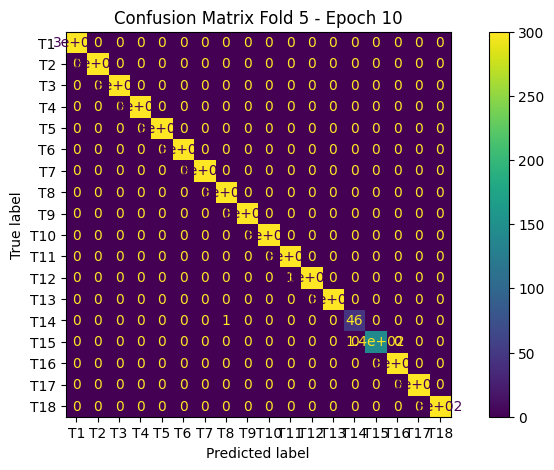

Amount of Data  Accuracy  Precision    Recall     F One
T1            300.0  1.000000   1.000000  1.000000  1.000000
T2            300.0  1.000000   1.000000  1.000000  1.000000
T3            300.0  1.000000   1.000000  1.000000  1.000000
T4            300.0  1.000000   1.000000  1.000000  1.000000
T5            300.0  1.000000   1.000000  1.000000  1.000000
T6            300.0  1.000000   1.000000  1.000000  1.000000
T7            300.0  1.000000   1.000000  1.000000  1.000000
T8            300.0  1.000000   0.996678  1.000000  0.998336
T9            300.0  1.000000   1.000000  1.000000  1.000000
T10           300.0  1.000000   1.000000  1.000000  1.000000
T11           300.0  1.000000   0.996678  1.000000  0.998336
T12           300.0  0.996667   1.000000  0.996667  0.998331
T13           300.0  1.000000   1.000000  1.000000  1.000000
T14            47.0  0.978723   1.000000  0.978723  0.989247
T15           143.0  1.000000   1.000000  1.000000  1.000000
T16           300.0  1.000000   1.000000  1.000000  1.000000
T17           300.0  1.000000   1.000000  1.000000  1.000000
T18           300.0  1.000000   1.000000  1.000000  1.000000

 50%|█████████████████████▌                     | 10/20 [02:21<02:29, 14.93s/it]

Epoch 11 / 20


==:==:==Train==:==:==: 0it [00:11, ?it/s]


Average Loss Train: 0.0011103045678522141


==:==:==Valid==:==:==: 0it [00:02, ?it/s]
 55%|███████████████████████▋                   | 11/20 [02:34<02:09, 14.43s/it]

Average Loss Validation: 0.0004948296347158944
Time 13.300947427749634

Epoch 12 / 20


==:==:==Train==:==:==: 0it [00:11, ?it/s]


Average Loss Train: 0.0009906606230899533


==:==:==Valid==:==:==: 0it [00:02, ?it/s]
 60%|█████████████████████████▊                 | 12/20 [02:47<01:52, 14.08s/it]

Average Loss Validation: 0.0004486480264930066
Time 13.260700702667236

Epoch 13 / 20


==:==:==Train==:==:==: 0it [00:10, ?it/s]


Average Loss Train: 0.0008944883507013285


==:==:==Valid==:==:==: 0it [00:02, ?it/s]
 65%|███████████████████████████▉               | 13/20 [03:01<01:36, 13.82s/it]

Average Loss Validation: 0.0004140530083933192
Time 13.20746111869812

Epoch 14 / 20


==:==:==Train==:==:==: 0it [00:10, ?it/s]


Average Loss Train: 0.0008282705889150211


==:==:==Valid==:==:==: 0it [00:02, ?it/s]
 70%|██████████████████████████████             | 14/20 [03:14<01:21, 13.65s/it]

Average Loss Validation: 0.0003834352580333998
Time 13.25088119506836

Epoch 15 / 20


==:==:==Train==:==:==: 0it [00:11, ?it/s]


Average Loss Train: 0.0007371619779721666


==:==:==Valid==:==:==: 0it [00:02, ?it/s]


Average Loss Validation: 0.00035796652143011115
Time 13.37605357170105



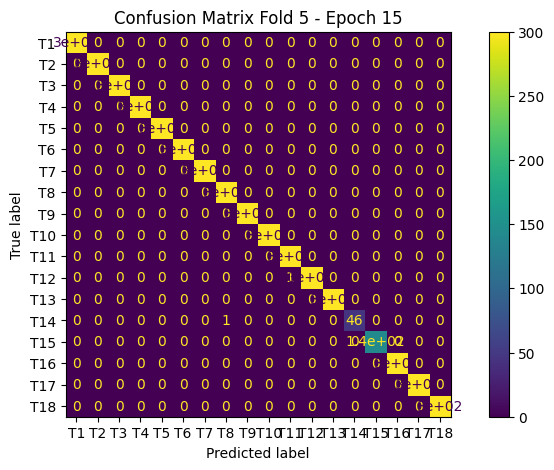

Amount of Data  Accuracy  Precision    Recall     F One
T1            300.0  1.000000   1.000000  1.000000  1.000000
T2            300.0  1.000000   1.000000  1.000000  1.000000
T3            300.0  1.000000   1.000000  1.000000  1.000000
T4            300.0  1.000000   1.000000  1.000000  1.000000
T5            300.0  1.000000   1.000000  1.000000  1.000000
T6            300.0  1.000000   1.000000  1.000000  1.000000
T7            300.0  1.000000   1.000000  1.000000  1.000000
T8            300.0  1.000000   0.996678  1.000000  0.998336
T9            300.0  1.000000   1.000000  1.000000  1.000000
T10           300.0  1.000000   1.000000  1.000000  1.000000
T11           300.0  1.000000   0.996678  1.000000  0.998336
T12           300.0  0.996667   1.000000  0.996667  0.998331
T13           300.0  1.000000   1.000000  1.000000  1.000000
T14            47.0  0.978723   1.000000  0.978723  0.989247
T15           143.0  1.000000   1.000000  1.000000  1.000000
T16           300.0  1.000000   1.000000  1.000000  1.000000
T17           300.0  1.000000   1.000000  1.000000  1.000000
T18           300.0  1.000000   1.000000  1.000000  1.000000

 75%|████████████████████████████████▎          | 15/20 [03:32<01:15, 15.01s/it]

Epoch 16 / 20


==:==:==Train==:==:==: 0it [00:10, ?it/s]


Average Loss Train: 0.0006979485514329876


==:==:==Valid==:==:==: 0it [00:02, ?it/s]
 80%|██████████████████████████████████▍        | 16/20 [03:45<00:57, 14.45s/it]

Average Loss Validation: 0.00032201190264466293
Time 13.142257690429688

Epoch 17 / 20


==:==:==Train==:==:==: 0it [00:10, ?it/s]


Average Loss Train: 0.0006485838280860733


==:==:==Valid==:==:==: 0it [00:02, ?it/s]
 85%|████████████████████████████████████▌      | 17/20 [03:58<00:42, 14.05s/it]

Average Loss Validation: 0.0002913620625295954
Time 13.1246657371521

Epoch 18 / 20


==:==:==Train==:==:==: 0it [00:10, ?it/s]


Average Loss Train: 0.0005941968609966488


==:==:==Valid==:==:==: 0it [00:02, ?it/s]
 90%|██████████████████████████████████████▋    | 18/20 [04:12<00:27, 13.82s/it]

Average Loss Validation: 0.00027241144396499066
Time 13.256779193878174

Epoch 19 / 20


==:==:==Train==:==:==: 0it [00:11, ?it/s]


Average Loss Train: 0.0005621939886712782


==:==:==Valid==:==:==: 0it [00:02, ?it/s]
 95%|████████████████████████████████████████▊  | 19/20 [04:25<00:13, 13.69s/it]

Average Loss Validation: 0.0002513325271123875
Time 13.391810655593872

Epoch 20 / 20


==:==:==Train==:==:==: 0it [00:10, ?it/s]


Average Loss Train: 0.000543419299328544


==:==:==Valid==:==:==: 0it [00:02, ?it/s]


Average Loss Validation: 0.00024185267637272874
Time 13.249028444290161



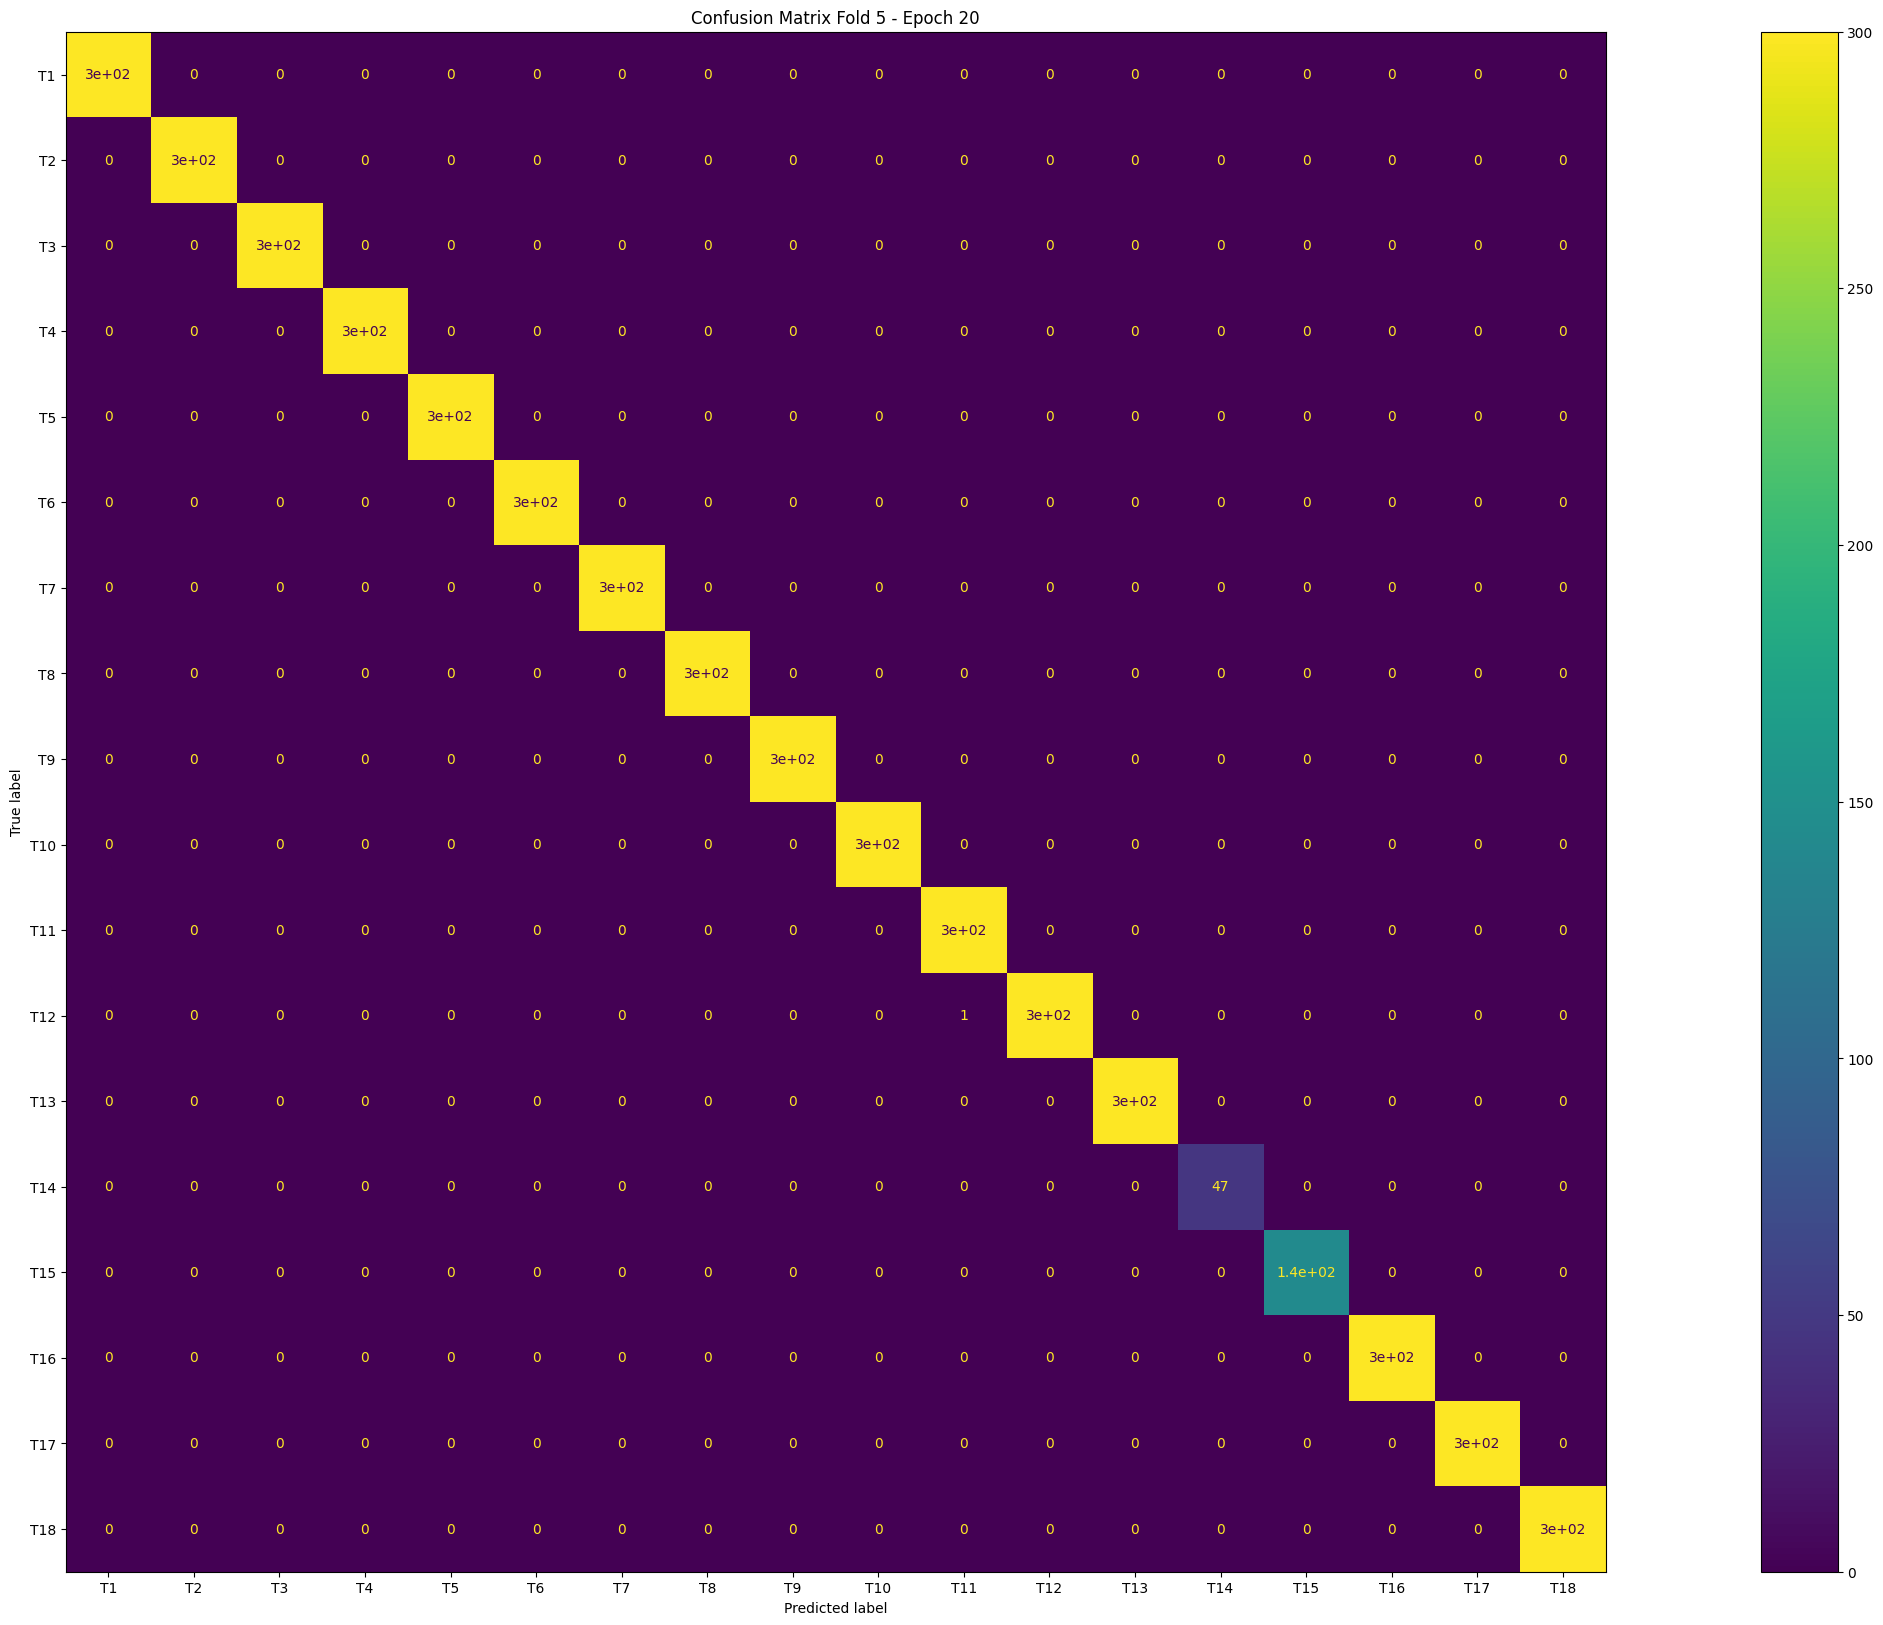

Amount of Data  Accuracy  Precision    Recall     F One
T1            300.0  1.000000   1.000000  1.000000  1.000000
T2            300.0  1.000000   1.000000  1.000000  1.000000
T3            300.0  1.000000   1.000000  1.000000  1.000000
T4            300.0  1.000000   1.000000  1.000000  1.000000
T5            300.0  1.000000   1.000000  1.000000  1.000000
T6            300.0  1.000000   1.000000  1.000000  1.000000
T7            300.0  1.000000   1.000000  1.000000  1.000000
T8            300.0  1.000000   1.000000  1.000000  1.000000
T9            300.0  1.000000   1.000000  1.000000  1.000000
T10           300.0  1.000000   1.000000  1.000000  1.000000
T11           300.0  1.000000   0.996678  1.000000  0.998336
T12           300.0  0.996667   1.000000  0.996667  0.998331
T13           300.0  1.000000   1.000000  1.000000  1.000000
T14            47.0  1.000000   1.000000  1.000000  1.000000
T15           143.0  1.000000   1.000000  1.000000  1.000000
T16           300.0  1.000000   1.000000  1.000000  1.000000
T17           300.0  1.000000   1.000000  1.000000  1.000000
T18           300.0  1.000000   1.000000  1.000000  1.000000

100%|███████████████████████████████████████████| 20/20 [04:44<00:00, 14.20s/it]
5it [24:02, 288.40s/it]


In [ ]:
import time
torch.manual_seed(12345)

# training image classification

LEARNING_RATE = 5e-5
EPOCH = 20

model.to(DEVICE)

training_losses = [[] for i in range(5)]
validation_losses = [[] for i in range(5)]

skf = StratifiedKFold(n_splits=5)

# Load before training + validing
for fold_i, (train_index, val_index) in enumerate(tqdm(skf.split(np.zeros(len(qa_dataset_train)), data_train_label), position=0, leave=True)):
  tqdm.write(f"=====:=====:=====:=====:===== Fold {fold_i + 1} =====:=====:=====:=====:=====")

  # Subset dataset for train and val
  train_dataset = Subset(qa_dataset_train, train_index)
  valid_dataset = Subset(qa_dataset_train, val_index)

  train_size = len(train_dataset)
  valid_size = len(valid_dataset)

  train_instances = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn_class)
  valid_instances = DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn_class)

  model_class = AutoModel.from_pretrained("indolem/indobert-base-uncased")
  bert_class = model_class
  model = BERT_Lexidqa2_class(bert_class, 768, 18)
  model.to(DEVICE)

  # optimizer
  optimizer = torch.optim.AdamW(model.parameters(), lr = LEARNING_RATE)

  tqdm.write(f'Fold {fold_i + 1} Ready')

  for epoch_i in tqdm(range(0, EPOCH), position=0, leave=True):
    start = time.time()
    tqdm.write(f"Epoch {epoch_i + 1} / {EPOCH}")

    # Freeze all layers
    for param in model.parameters():
        param.requires_grad = False

    # Unfreeze last layer
    for param in model.bert.encoder.layer[11].parameters():
        param.requires_grad = True

    # Reset the total loss for this epoch.
    tr_loss = 0

    # Put the model into training mode.
    model.train()

    # Untuk setiap data di training data
    train_total_data = train_size
    train_pbar = tqdm(desc="==:==:==Train==:==:==", position=0, leave=True)
    for data in train_instances:

      # Mendapatkan output dari model
      input, gold = data
      input = input.to(DEVICE)
      gold = gold.to(DEVICE)
      pred = model(input)

      # Categorical Cross-Entropy --- Loss Function
      loss = loss_func(pred, gold)

      # Agar gradient tidak menumpuk; ini diperlukan sebelum
      # menghitung gradient dengan loss.backward()
      optimizer.zero_grad()

      # hitung gradient
      loss.backward()

      # update parameter
      optimizer.step()

      # akumulasi loss dalam 1 epoch
      tr_loss += loss.item()

      # train_pbar.update(len(data))

    # rata-rata loss dalam 1 epoch
    avg_loss = tr_loss / train_total_data

    training_losses[fold_i].append(avg_loss)

    train_pbar.write(f"Average Loss Train: {avg_loss}")

    train_pbar.close()

    ### Uji coba di Validation Data

    # model eval, agar layer seperti dropout yang menghasilkan
    # sesuai yang random tidak digunakan
    model.eval()

    val_loss = 0
    pred_labels = []
    true_labels = []

    # Untuk setiap batch di validation data
    valid_total_data = valid_size
    valid_pbar = tqdm(desc="==:==:==Valid==:==:==", position=0, leave=True)
    for data in valid_instances:

      # jangan track gradient! ini sedang evaluasi, bukan training
      with torch.no_grad():

        # Mendapatkan output dari model
        input, gold = data
        input = input.to(DEVICE)
        gold = gold.to(DEVICE)
        pred = model(input)

        # Categorical Cross-Entropy --- Loss Function
        loss = loss_func(pred, gold)

        # akumulasi loss di validation set
        val_loss += loss.item()

        # valid_pbar.update(len(data))


    # average loss
    avg_val_loss = val_loss / valid_total_data

    validation_losses[fold_i].append(avg_val_loss)

    valid_pbar.write(f"Average Loss Validation: {avg_val_loss}")

    end = time.time()
    valid_pbar.write("Time " + str(end-start))
    valid_pbar.write("")
    valid_pbar.close()

    # accuracy
    # pred_labels = torch.stack(pred_labels).numpy()
    # true_labels = torch.stack(true_labels).numpy()
    # val_accuracy = np.sum(pred_labels == true_labels) / len(pred_labels)
    # print(f"Accuracy di validation data: {val_accuracy}")


    if (epoch_i + 1) % 5 == 0:
      nb_classes = 18

      conf_matrix = torch.zeros(nb_classes, nb_classes)
      with torch.no_grad():
        for i, (input, gold) in enumerate(valid_instances):
          input = input.to(DEVICE)
          gold = gold.to(DEVICE)
          pred = model(input)
          # _, gold = torch.max(gold, 1)
          # _, pred = torch.max(pred, 1)
          # for t, p in zip(gold.view(-1), pred.view(-1)):
          #   conf_matrix[t.long(), p.long()] += 1

          conf_matrix = confusion_matrix(gold, pred, conf_matrix)

      amt, acc, prec, rec, f1 = evaluation_metric(conf_matrix)
      data_conf = {
          'Amount of Data': amt,
          'Accuracy': acc,
          'Precision': prec,
          'Recall': rec,
          'F One': f1
      }


      fig, ax = _, _
      if (epoch_i + 1) != EPOCH:
        fig, ax = plt.subplots(figsize=(10, 5))
      else:
        fig, ax = plt.subplots(figsize=(40, 20))

      display_labels = ['T1', 'T2', 'T3', 'T4', 'T5', 'T6', 'T7', 'T8', 'T9', 'T10', 'T11', 'T12', 'T13', 'T14', 'T15', 'T16', 'T17', 'T18']
      disp = metrics.ConfusionMatrixDisplay(confusion_matrix=conf_matrix.detach().cpu().numpy(), display_labels=display_labels)
      disp.plot(ax=ax)
      plt.title(f"Confusion Matrix Fold {fold_i + 1} - Epoch {epoch_i + 1}")
      plt.show()

      disp_df = pd.DataFrame(data=data_conf,
                             index=display_labels, columns=['Amount of Data', 'Accuracy', 'Precision', 'Recall', 'F One'])
      display(disp_df)

      # for i, template_index in enumerate(display_labels):
      #   print(f"Evaluation for {template_index}:")
      #   print(f"Amount of Data: {amt[i]}")
      #   print(f"Accuracy: {acc[i]}")
      #   print(f"Precision: {prec[i]}")
      #   print(f"Recall: {rec[i]}")
      #   print(f"F One: {f1[i]}")
      #   print()

      model.to("cpu")

      save_path = 'model_indobert/class_tesaurus_checkpoint/fold_' + str(fold_i)
      if not os.path.exists(save_path):
        os.makedirs(save_path)
      model_class_path = os.path.join(save_path, "indobert_class_tesaurus_checkpoint_" + str(epoch_i) +".pth")
      torch.save(model, model_class_path)

      model.to(DEVICE)

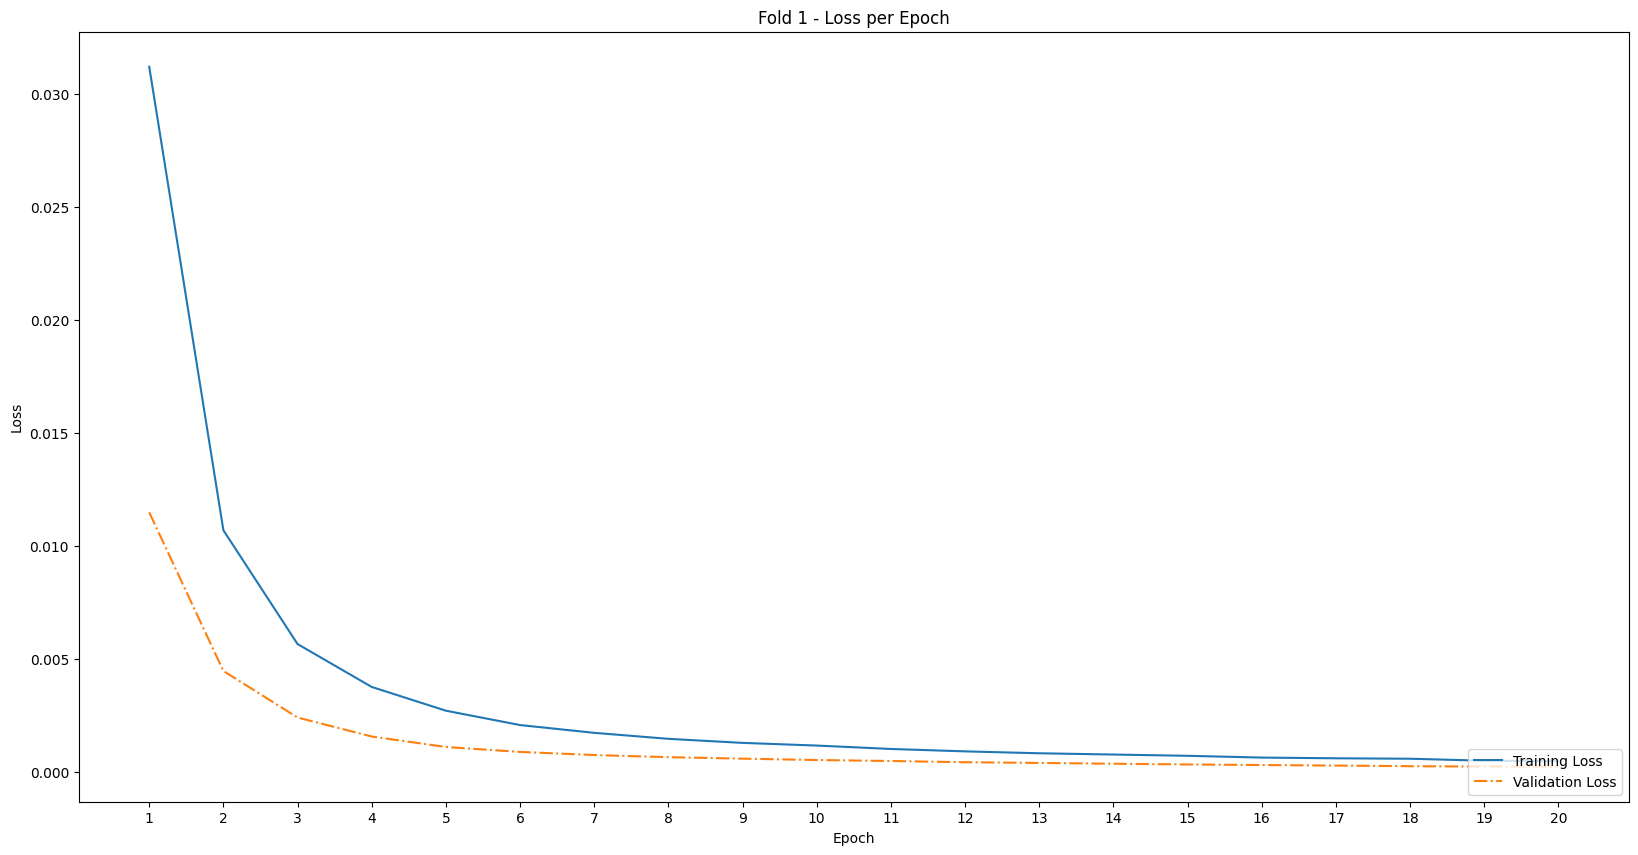

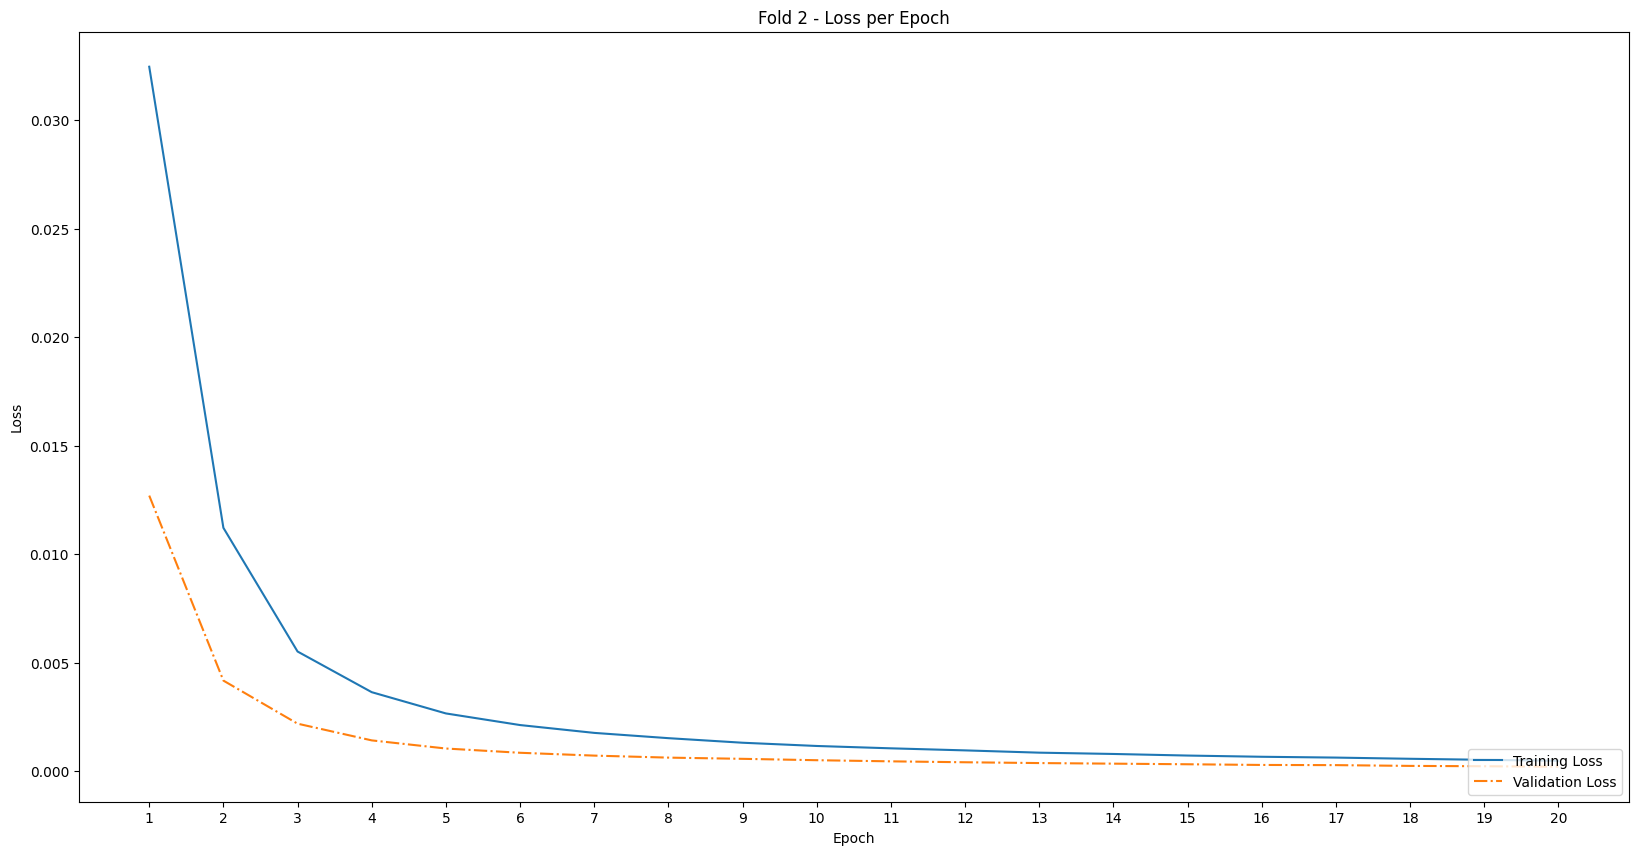

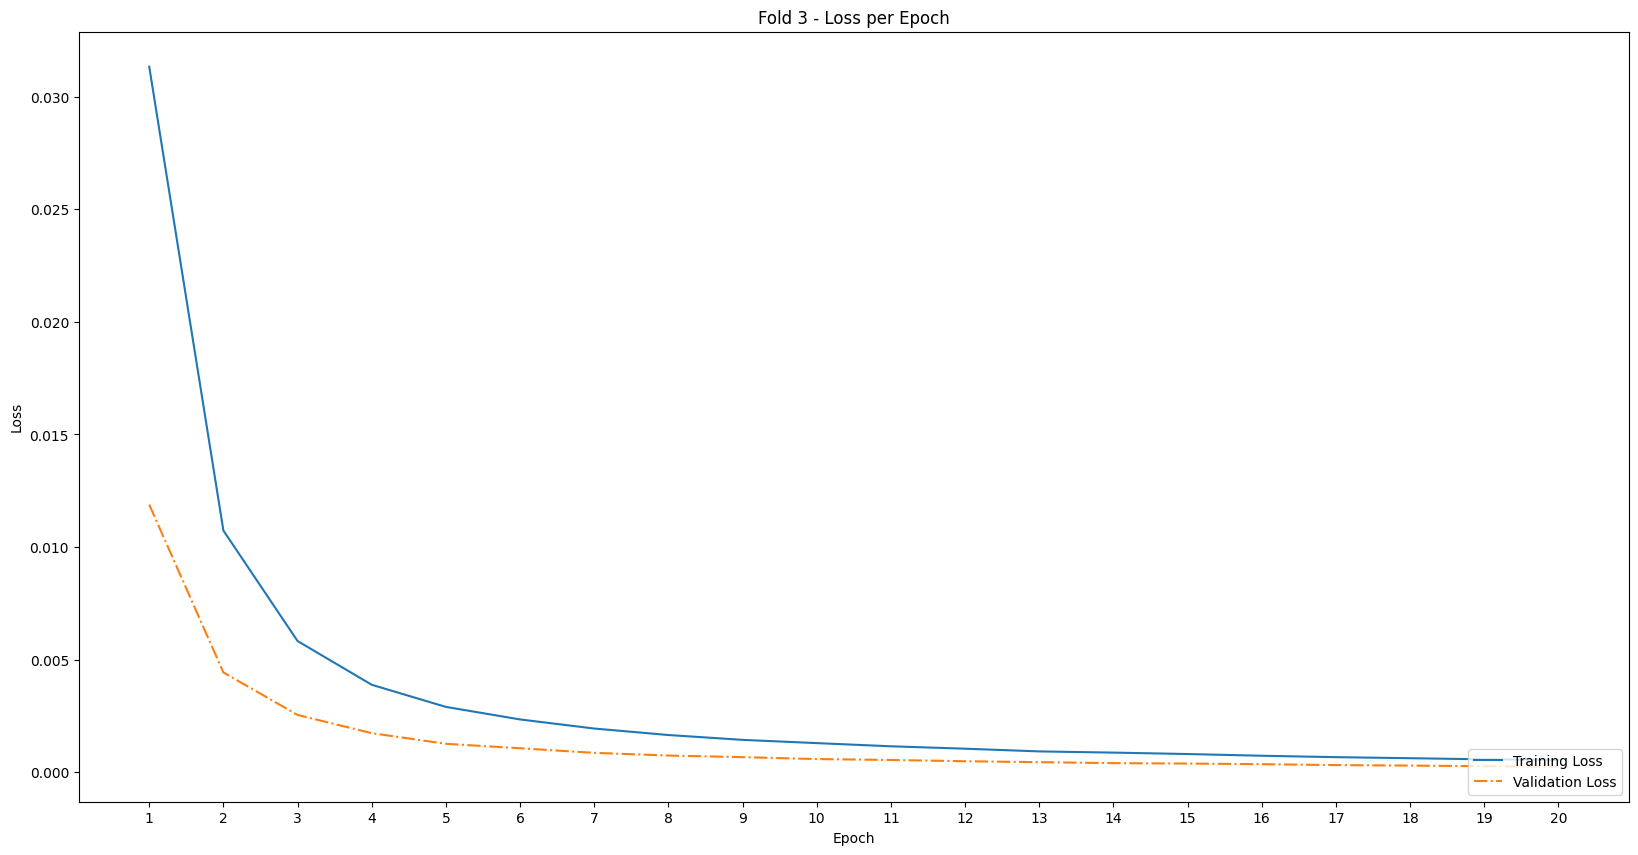

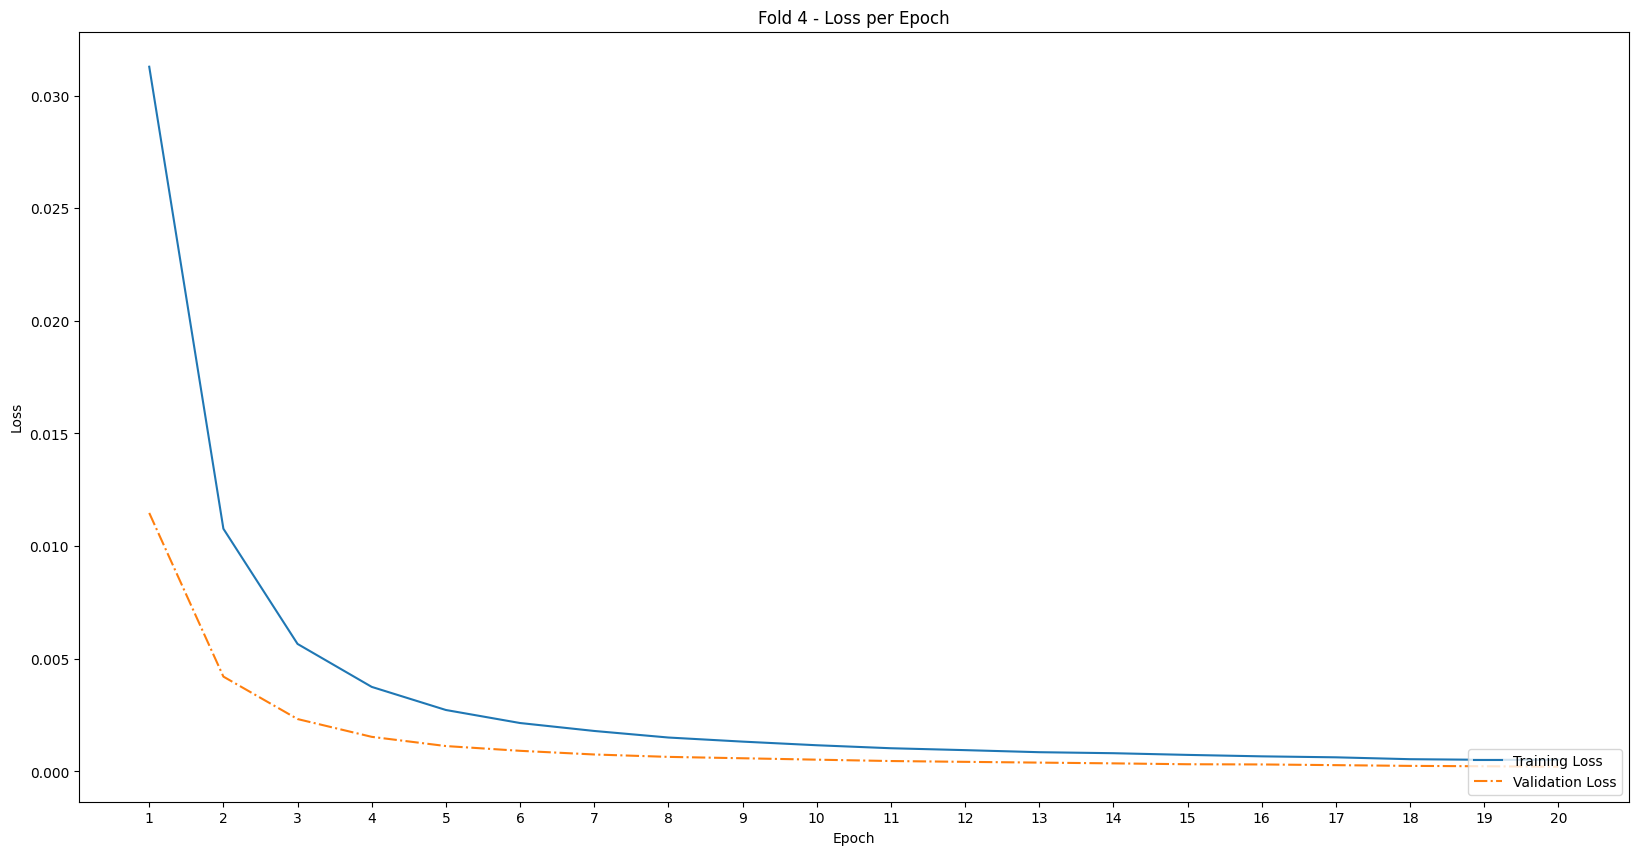

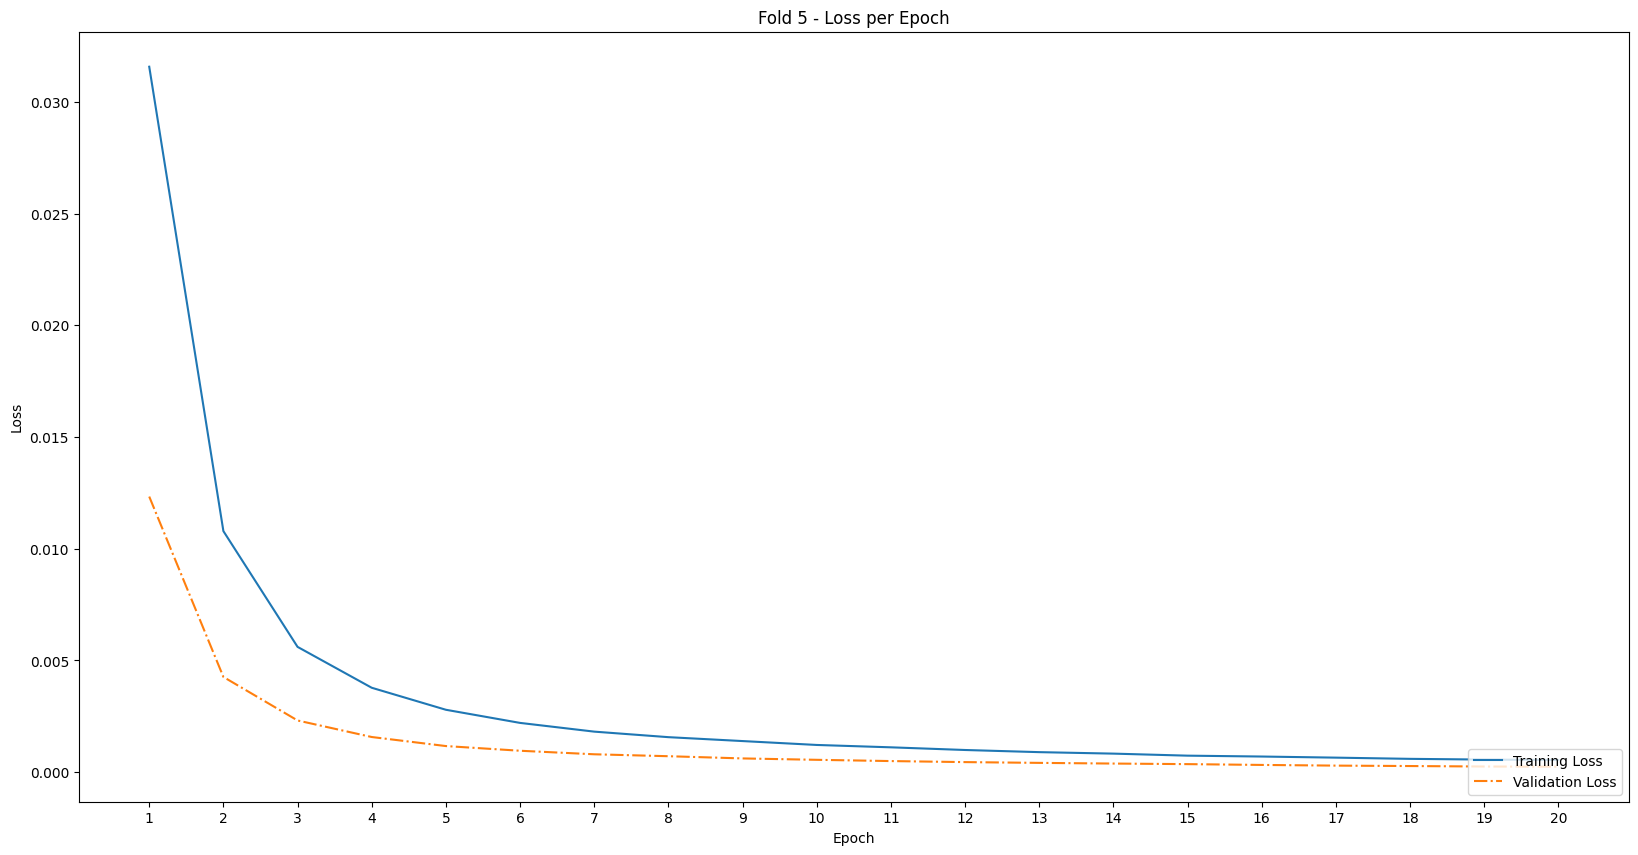

In [ ]:
for i in range(5):
  x = np.arange(1, 21)
  y_train_loss = np.asarray(training_losses[i], dtype=np.float32)
  y_val_loss = np.asarray(validation_losses[i], dtype=np.float32)

  plt.figure(figsize=(20,10))

  plt.plot(x, y_train_loss[0:20])
  plt.plot(x, y_val_loss[0:20], '-.')

  plt.xticks(np.arange(min(x), max(x)+1, 1.0))
  plt.legend(["Training Loss", "Validation Loss"], loc="lower right")

  plt.xlabel("Epoch")
  plt.ylabel("Loss")
  plt.title(f'Fold {i + 1} - Loss per Epoch')
  plt.show()


Average loss di testing data: 0.00021321967682602112


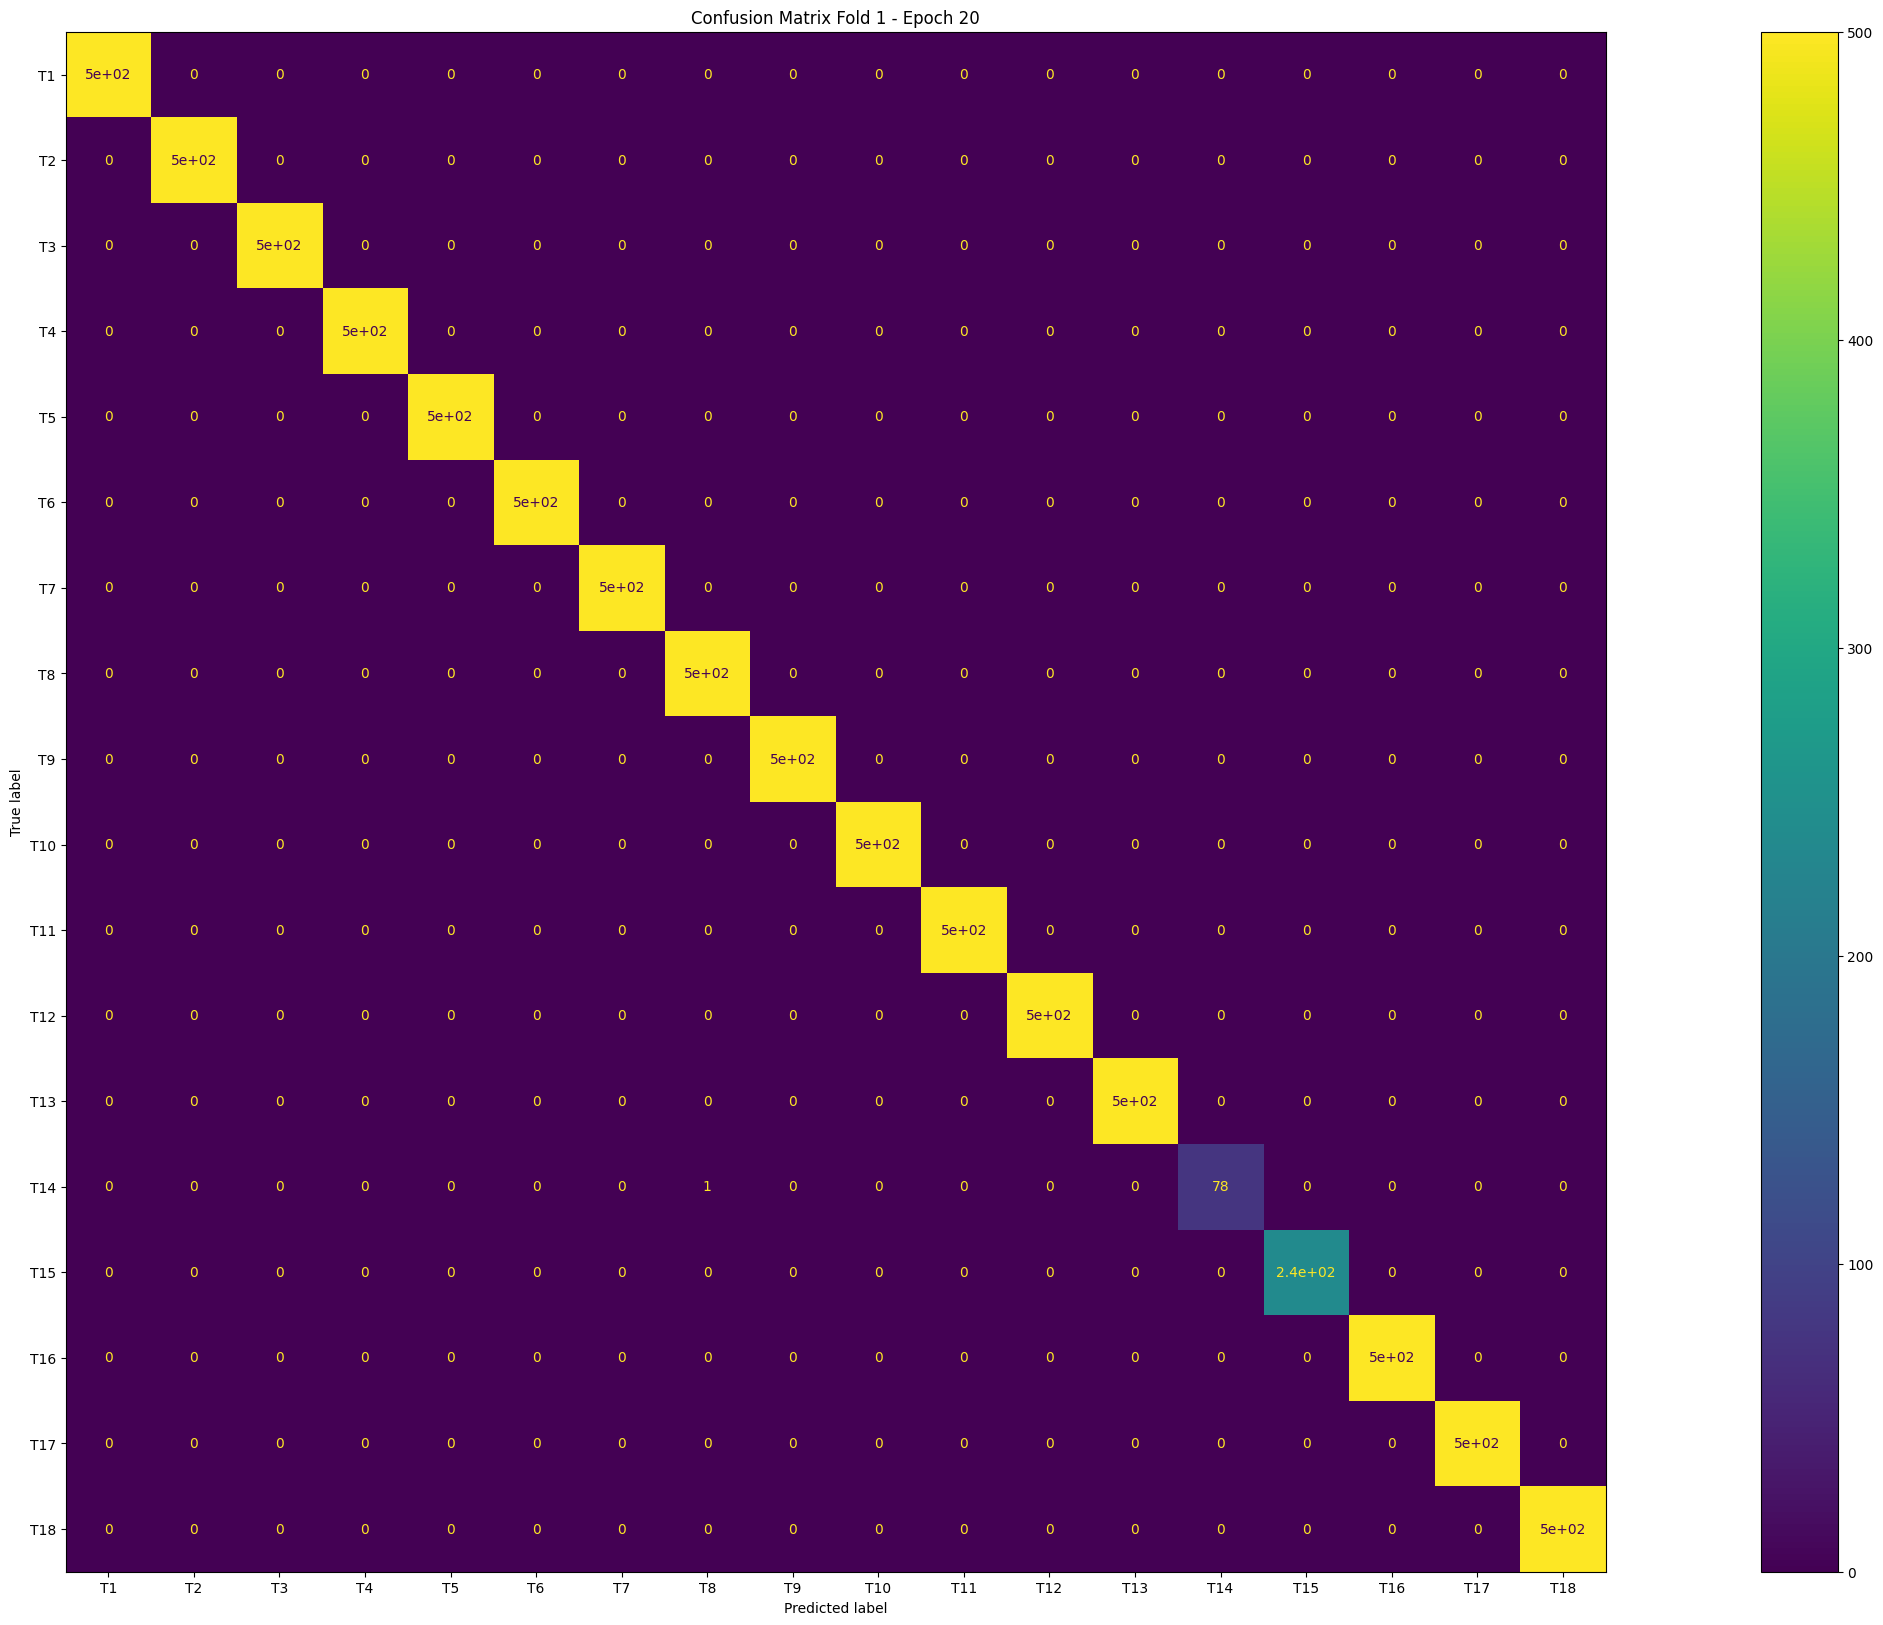

Amount of Data  Accuracy  Precision    Recall     F One
T1            500.0  1.000000   1.000000  1.000000  1.000000
T2            500.0  1.000000   1.000000  1.000000  1.000000
T3            500.0  1.000000   1.000000  1.000000  1.000000
T4            500.0  1.000000   1.000000  1.000000  1.000000
T5            500.0  1.000000   1.000000  1.000000  1.000000
T6            500.0  1.000000   1.000000  1.000000  1.000000
T7            500.0  1.000000   1.000000  1.000000  1.000000
T8            500.0  1.000000   0.998004  1.000000  0.999001
T9            500.0  1.000000   1.000000  1.000000  1.000000
T10           500.0  1.000000   1.000000  1.000000  1.000000
T11           500.0  1.000000   1.000000  1.000000  1.000000
T12           500.0  1.000000   1.000000  1.000000  1.000000
T13           500.0  1.000000   1.000000  1.000000  1.000000
T14            79.0  0.987342   1.000000  0.987342  0.993631
T15           239.0  1.000000   1.000000  1.000000  1.000000
T16           500.0  1.000000   1.000000  1.000000  1.000000
T17           500.0  1.000000   1.000000  1.000000  1.000000
T18           500.0  1.000000   1.000000  1.000000  1.000000


Average loss di testing data: 0.00021384367246801505


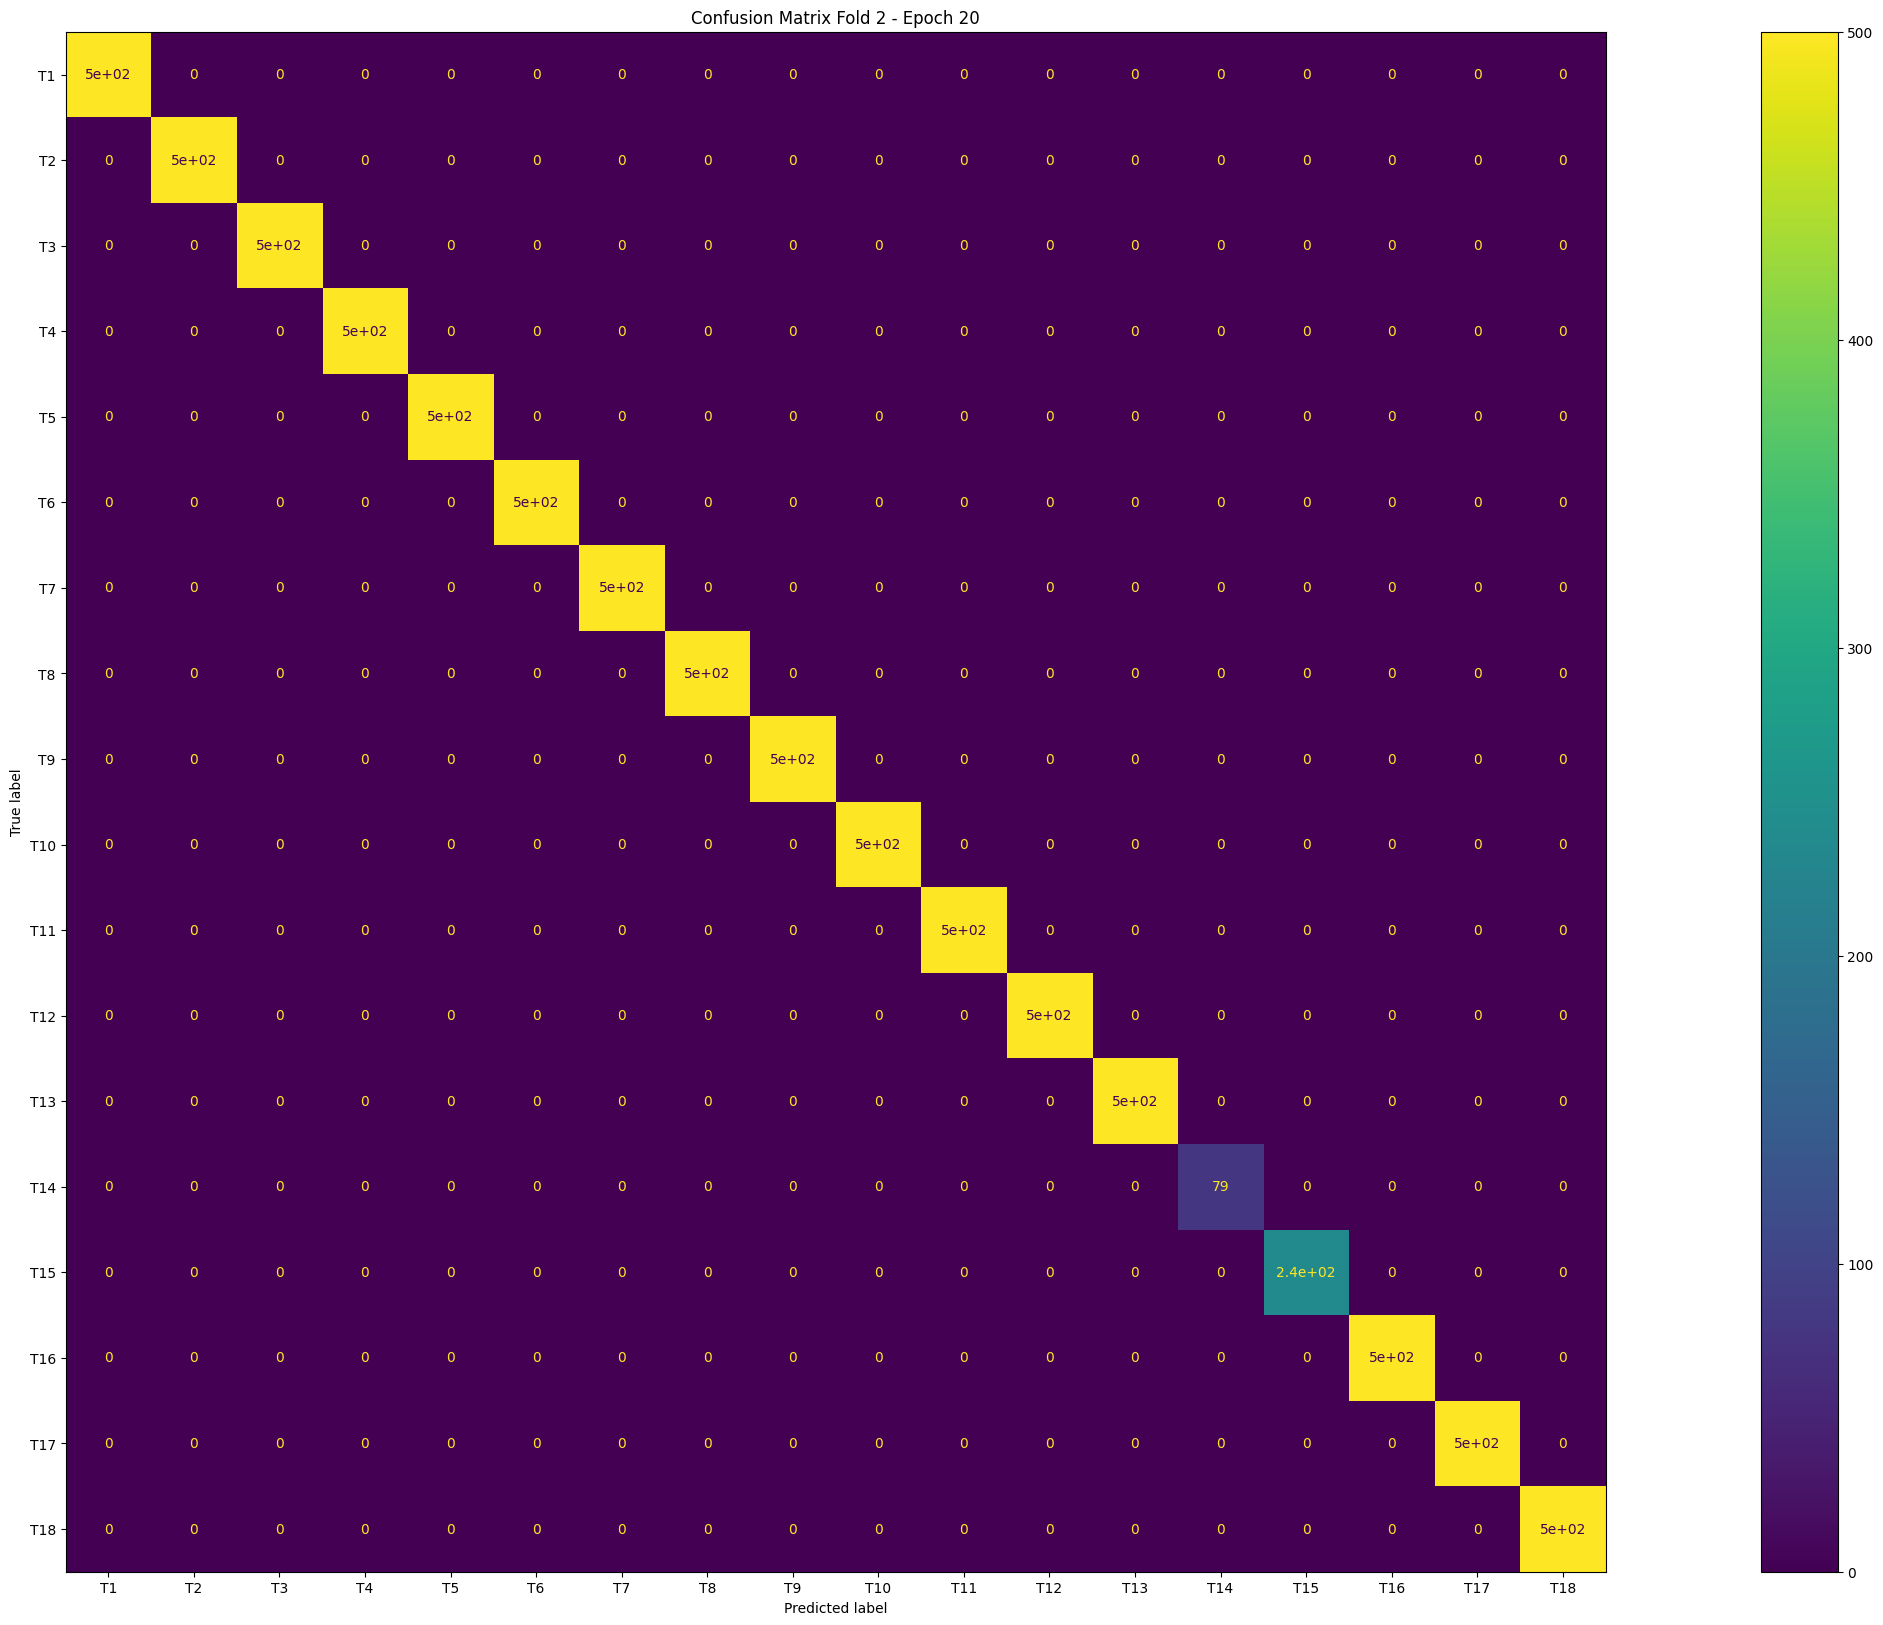

Amount of Data  Accuracy  Precision  Recall  F One
T1            500.0       1.0        1.0     1.0    1.0
T2            500.0       1.0        1.0     1.0    1.0
T3            500.0       1.0        1.0     1.0    1.0
T4            500.0       1.0        1.0     1.0    1.0
T5            500.0       1.0        1.0     1.0    1.0
T6            500.0       1.0        1.0     1.0    1.0
T7            500.0       1.0        1.0     1.0    1.0
T8            500.0       1.0        1.0     1.0    1.0
T9            500.0       1.0        1.0     1.0    1.0
T10           500.0       1.0        1.0     1.0    1.0
T11           500.0       1.0        1.0     1.0    1.0
T12           500.0       1.0        1.0     1.0    1.0
T13           500.0       1.0        1.0     1.0    1.0
T14            79.0       1.0        1.0     1.0    1.0
T15           239.0       1.0        1.0     1.0    1.0
T16           500.0       1.0        1.0     1.0    1.0
T17           500.0       1.0        1.0     1.0    1.0
T18           500.0       1.0        1.0     1.0    1.0


Average loss di testing data: 0.00023935232873550114


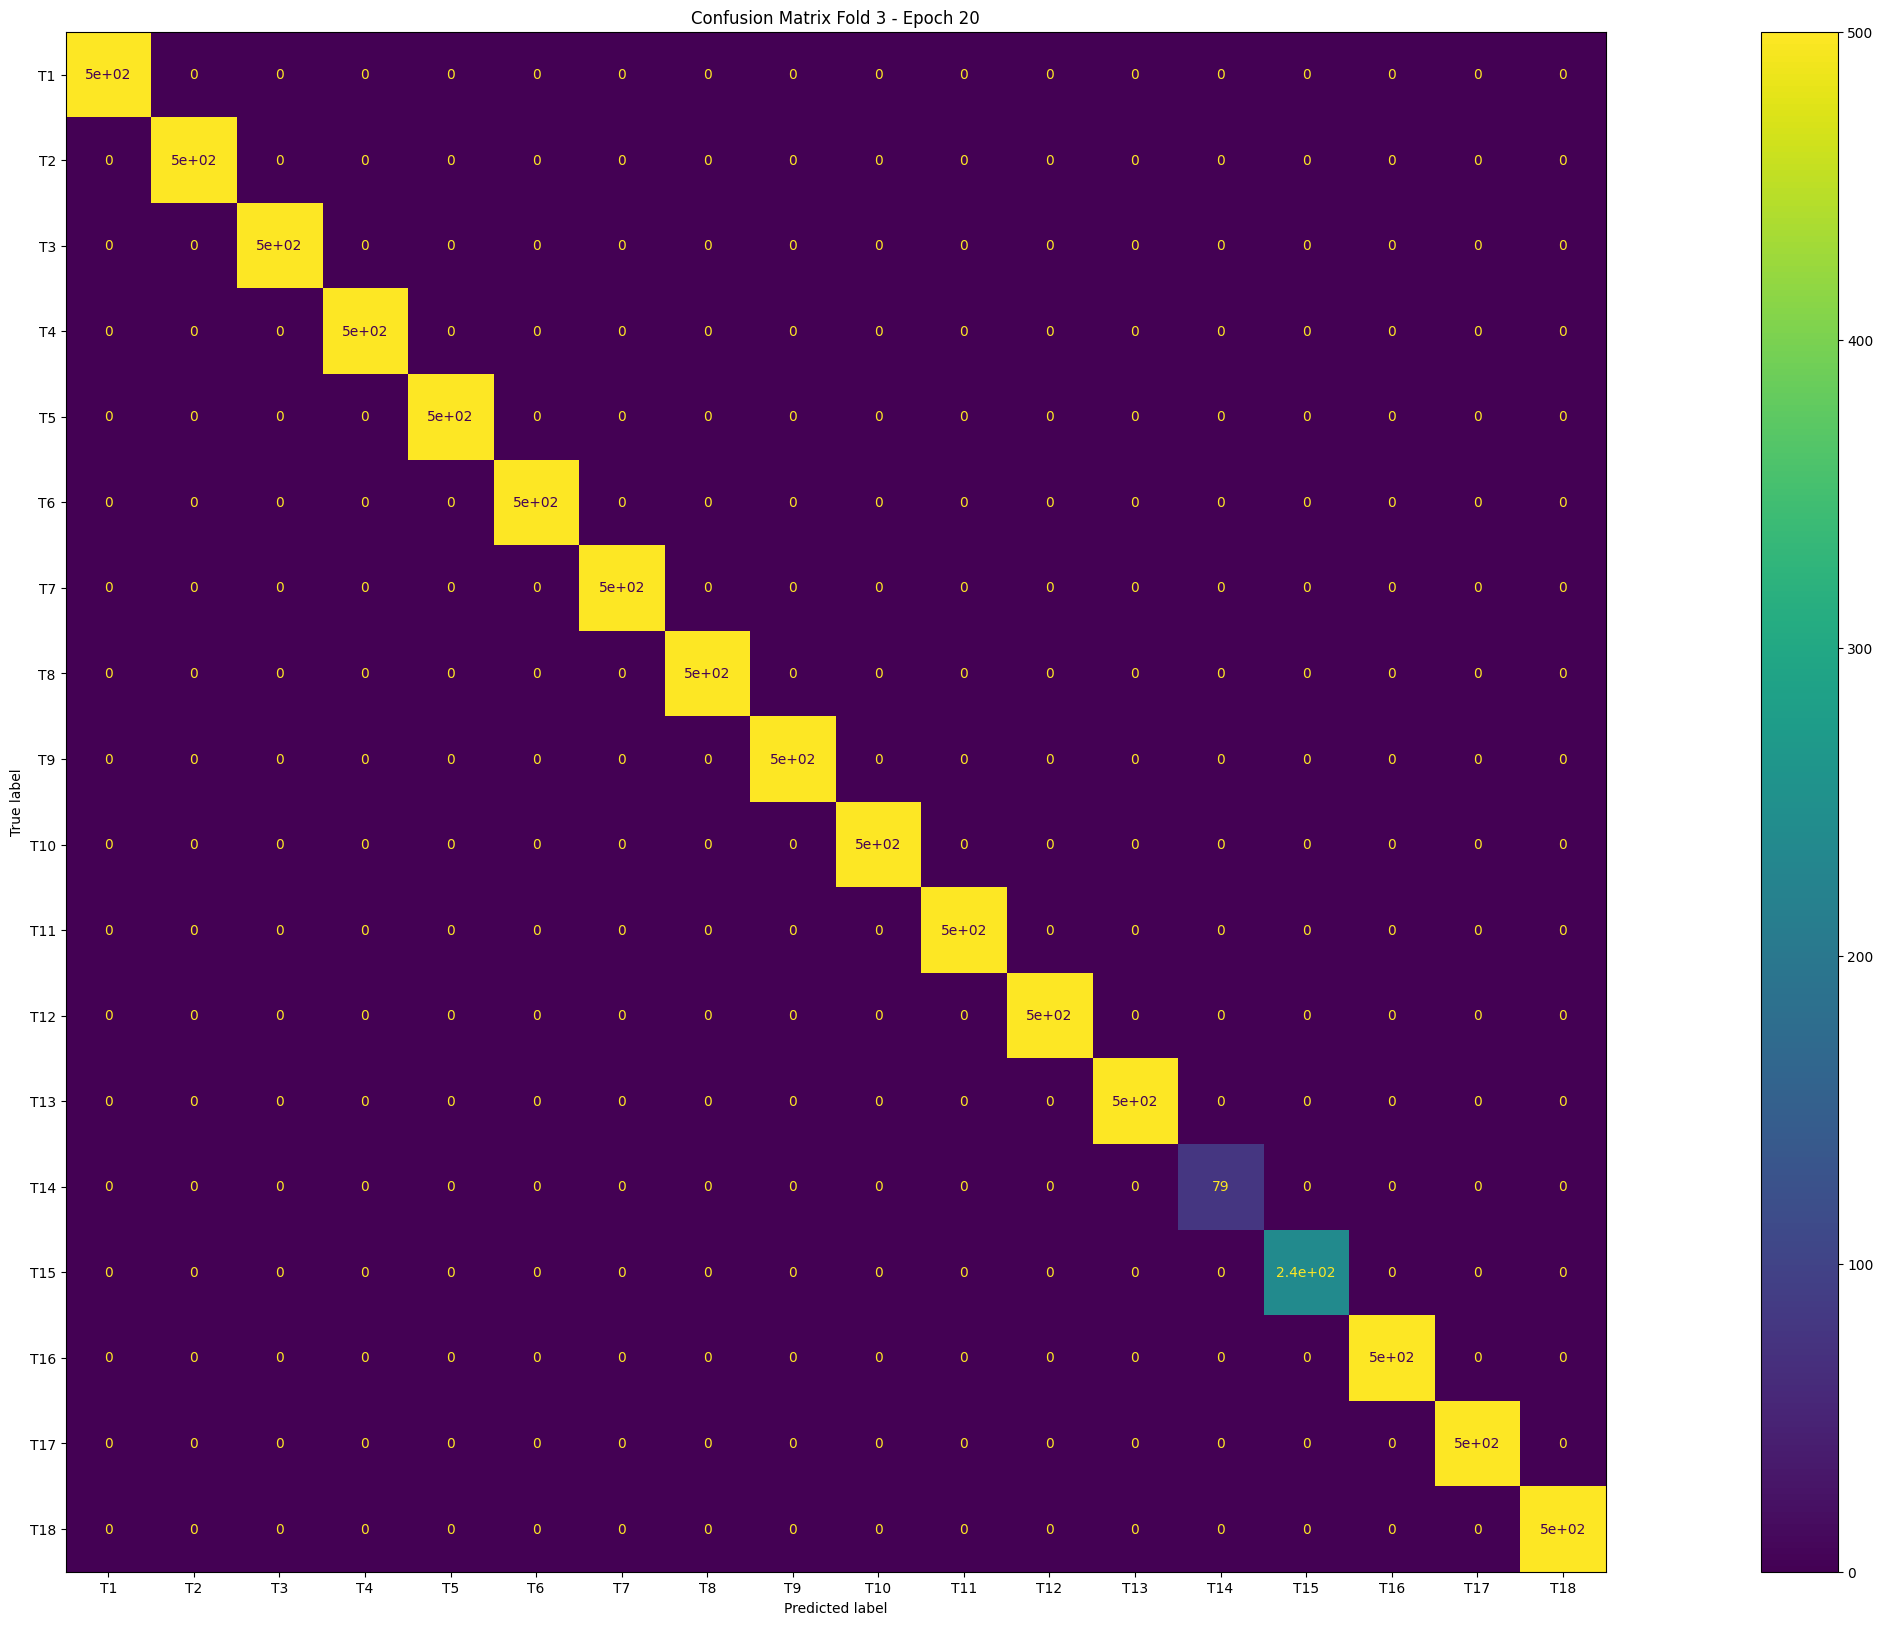

Amount of Data  Accuracy  Precision  Recall  F One
T1            500.0       1.0        1.0     1.0    1.0
T2            500.0       1.0        1.0     1.0    1.0
T3            500.0       1.0        1.0     1.0    1.0
T4            500.0       1.0        1.0     1.0    1.0
T5            500.0       1.0        1.0     1.0    1.0
T6            500.0       1.0        1.0     1.0    1.0
T7            500.0       1.0        1.0     1.0    1.0
T8            500.0       1.0        1.0     1.0    1.0
T9            500.0       1.0        1.0     1.0    1.0
T10           500.0       1.0        1.0     1.0    1.0
T11           500.0       1.0        1.0     1.0    1.0
T12           500.0       1.0        1.0     1.0    1.0
T13           500.0       1.0        1.0     1.0    1.0
T14            79.0       1.0        1.0     1.0    1.0
T15           239.0       1.0        1.0     1.0    1.0
T16           500.0       1.0        1.0     1.0    1.0
T17           500.0       1.0        1.0     1.0    1.0
T18           500.0       1.0        1.0     1.0    1.0


Average loss di testing data: 0.00020783532370104903


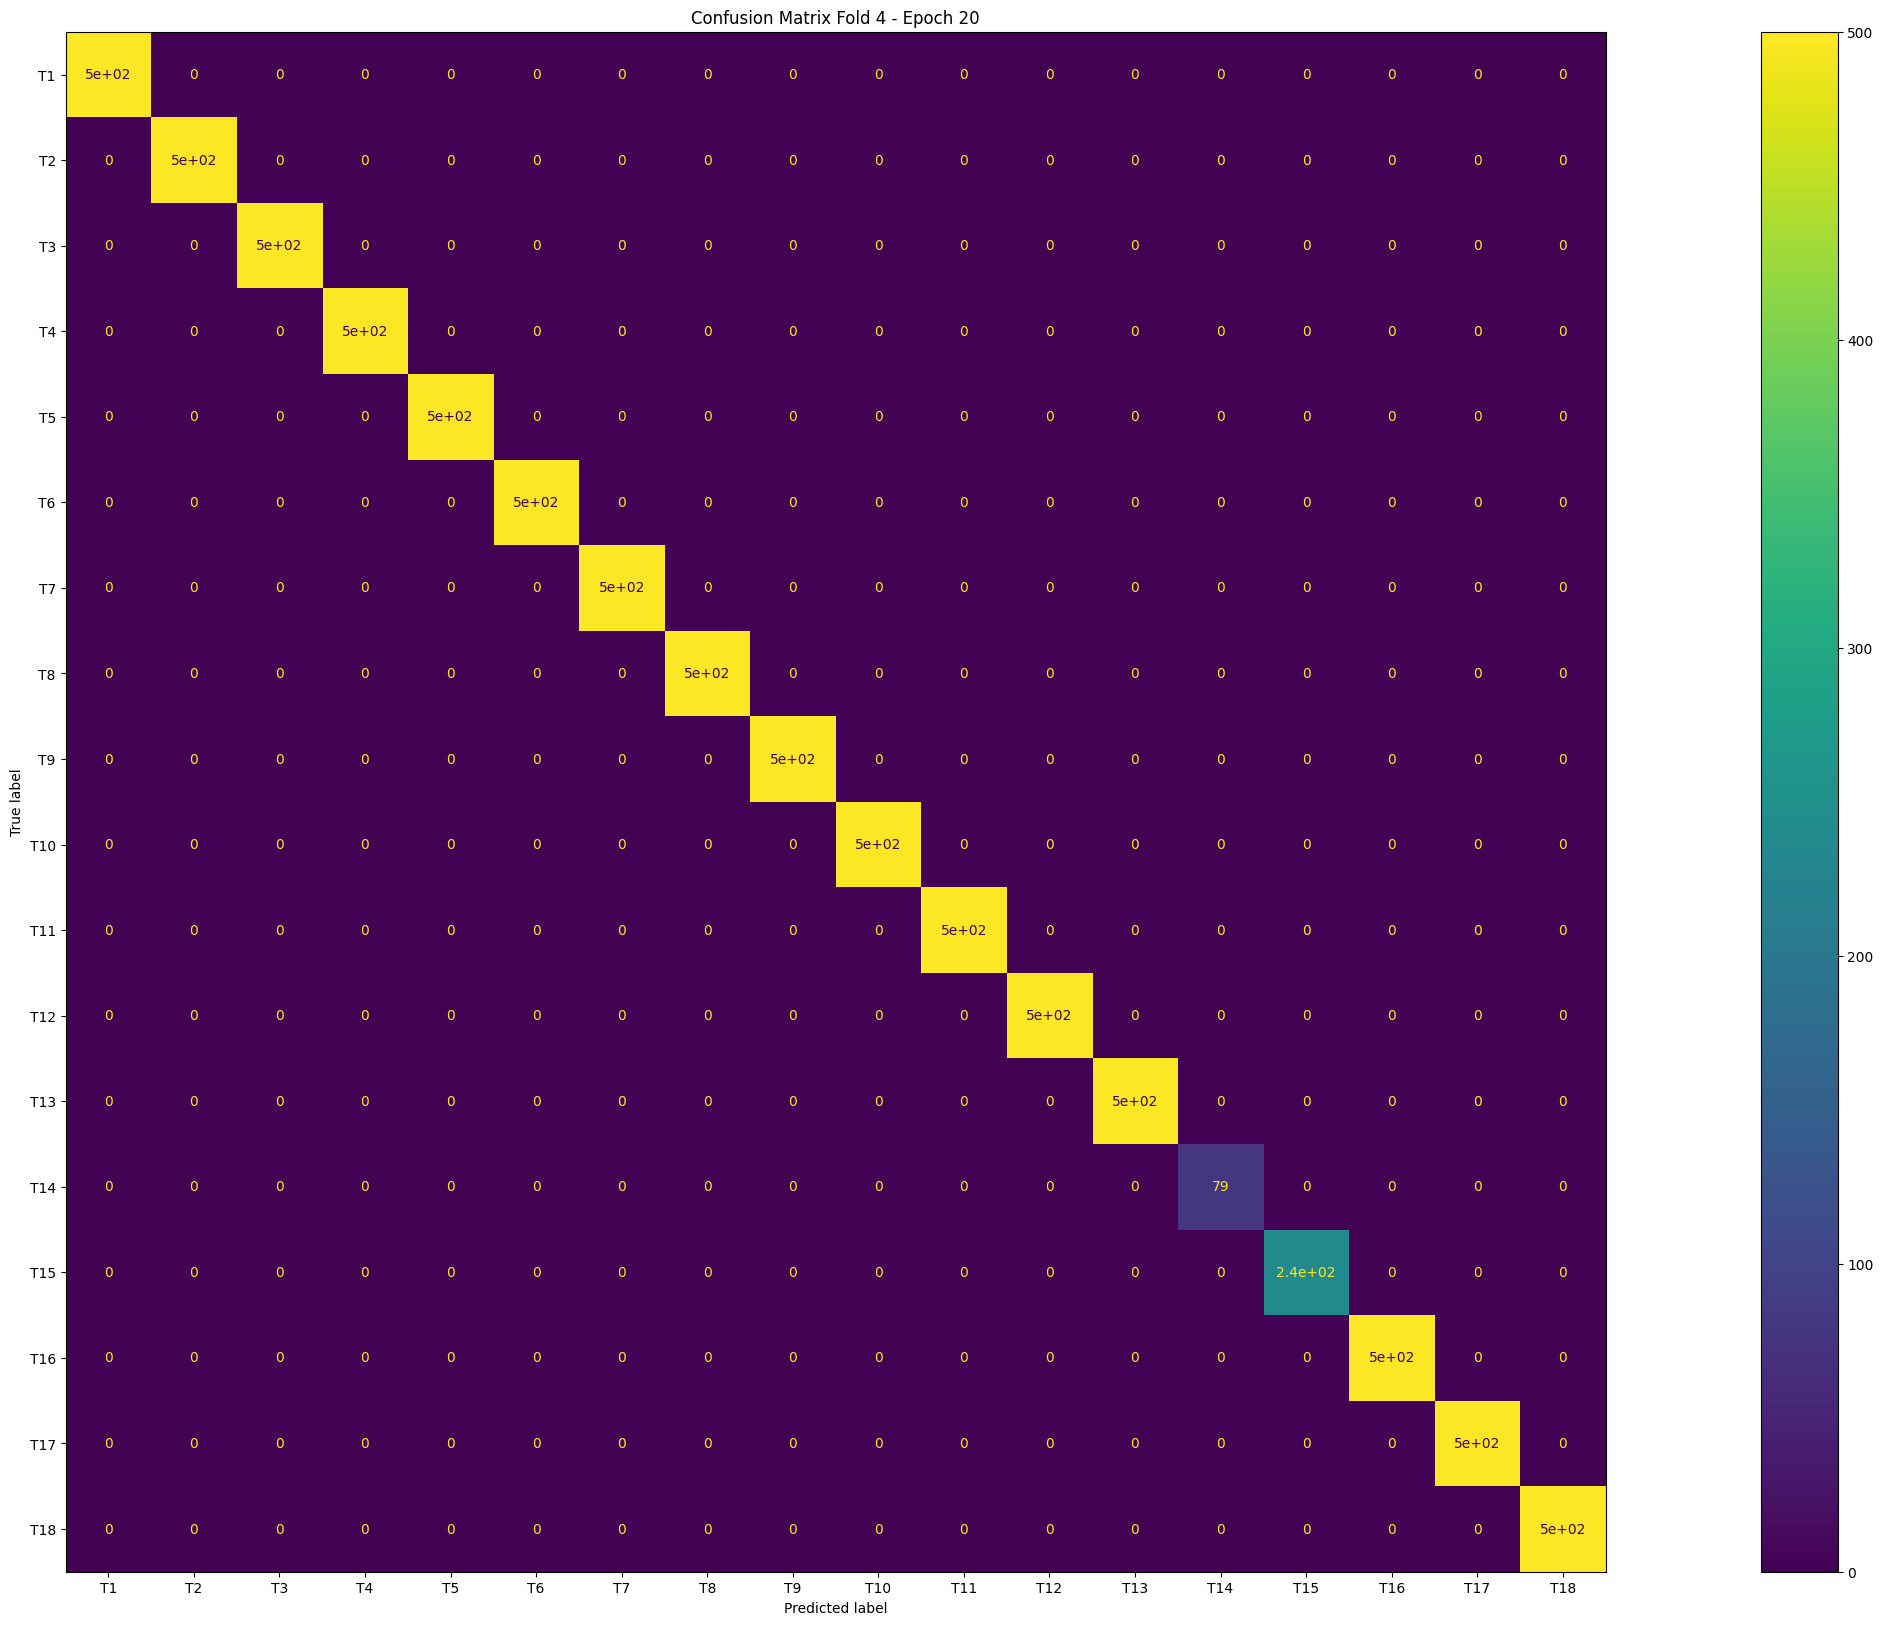

Amount of Data  Accuracy  Precision  Recall  F One
T1            500.0       1.0        1.0     1.0    1.0
T2            500.0       1.0        1.0     1.0    1.0
T3            500.0       1.0        1.0     1.0    1.0
T4            500.0       1.0        1.0     1.0    1.0
T5            500.0       1.0        1.0     1.0    1.0
T6            500.0       1.0        1.0     1.0    1.0
T7            500.0       1.0        1.0     1.0    1.0
T8            500.0       1.0        1.0     1.0    1.0
T9            500.0       1.0        1.0     1.0    1.0
T10           500.0       1.0        1.0     1.0    1.0
T11           500.0       1.0        1.0     1.0    1.0
T12           500.0       1.0        1.0     1.0    1.0
T13           500.0       1.0        1.0     1.0    1.0
T14            79.0       1.0        1.0     1.0    1.0
T15           239.0       1.0        1.0     1.0    1.0
T16           500.0       1.0        1.0     1.0    1.0
T17           500.0       1.0        1.0     1.0    1.0
T18           500.0       1.0        1.0     1.0    1.0


Average loss di testing data: 0.0002253772013505639


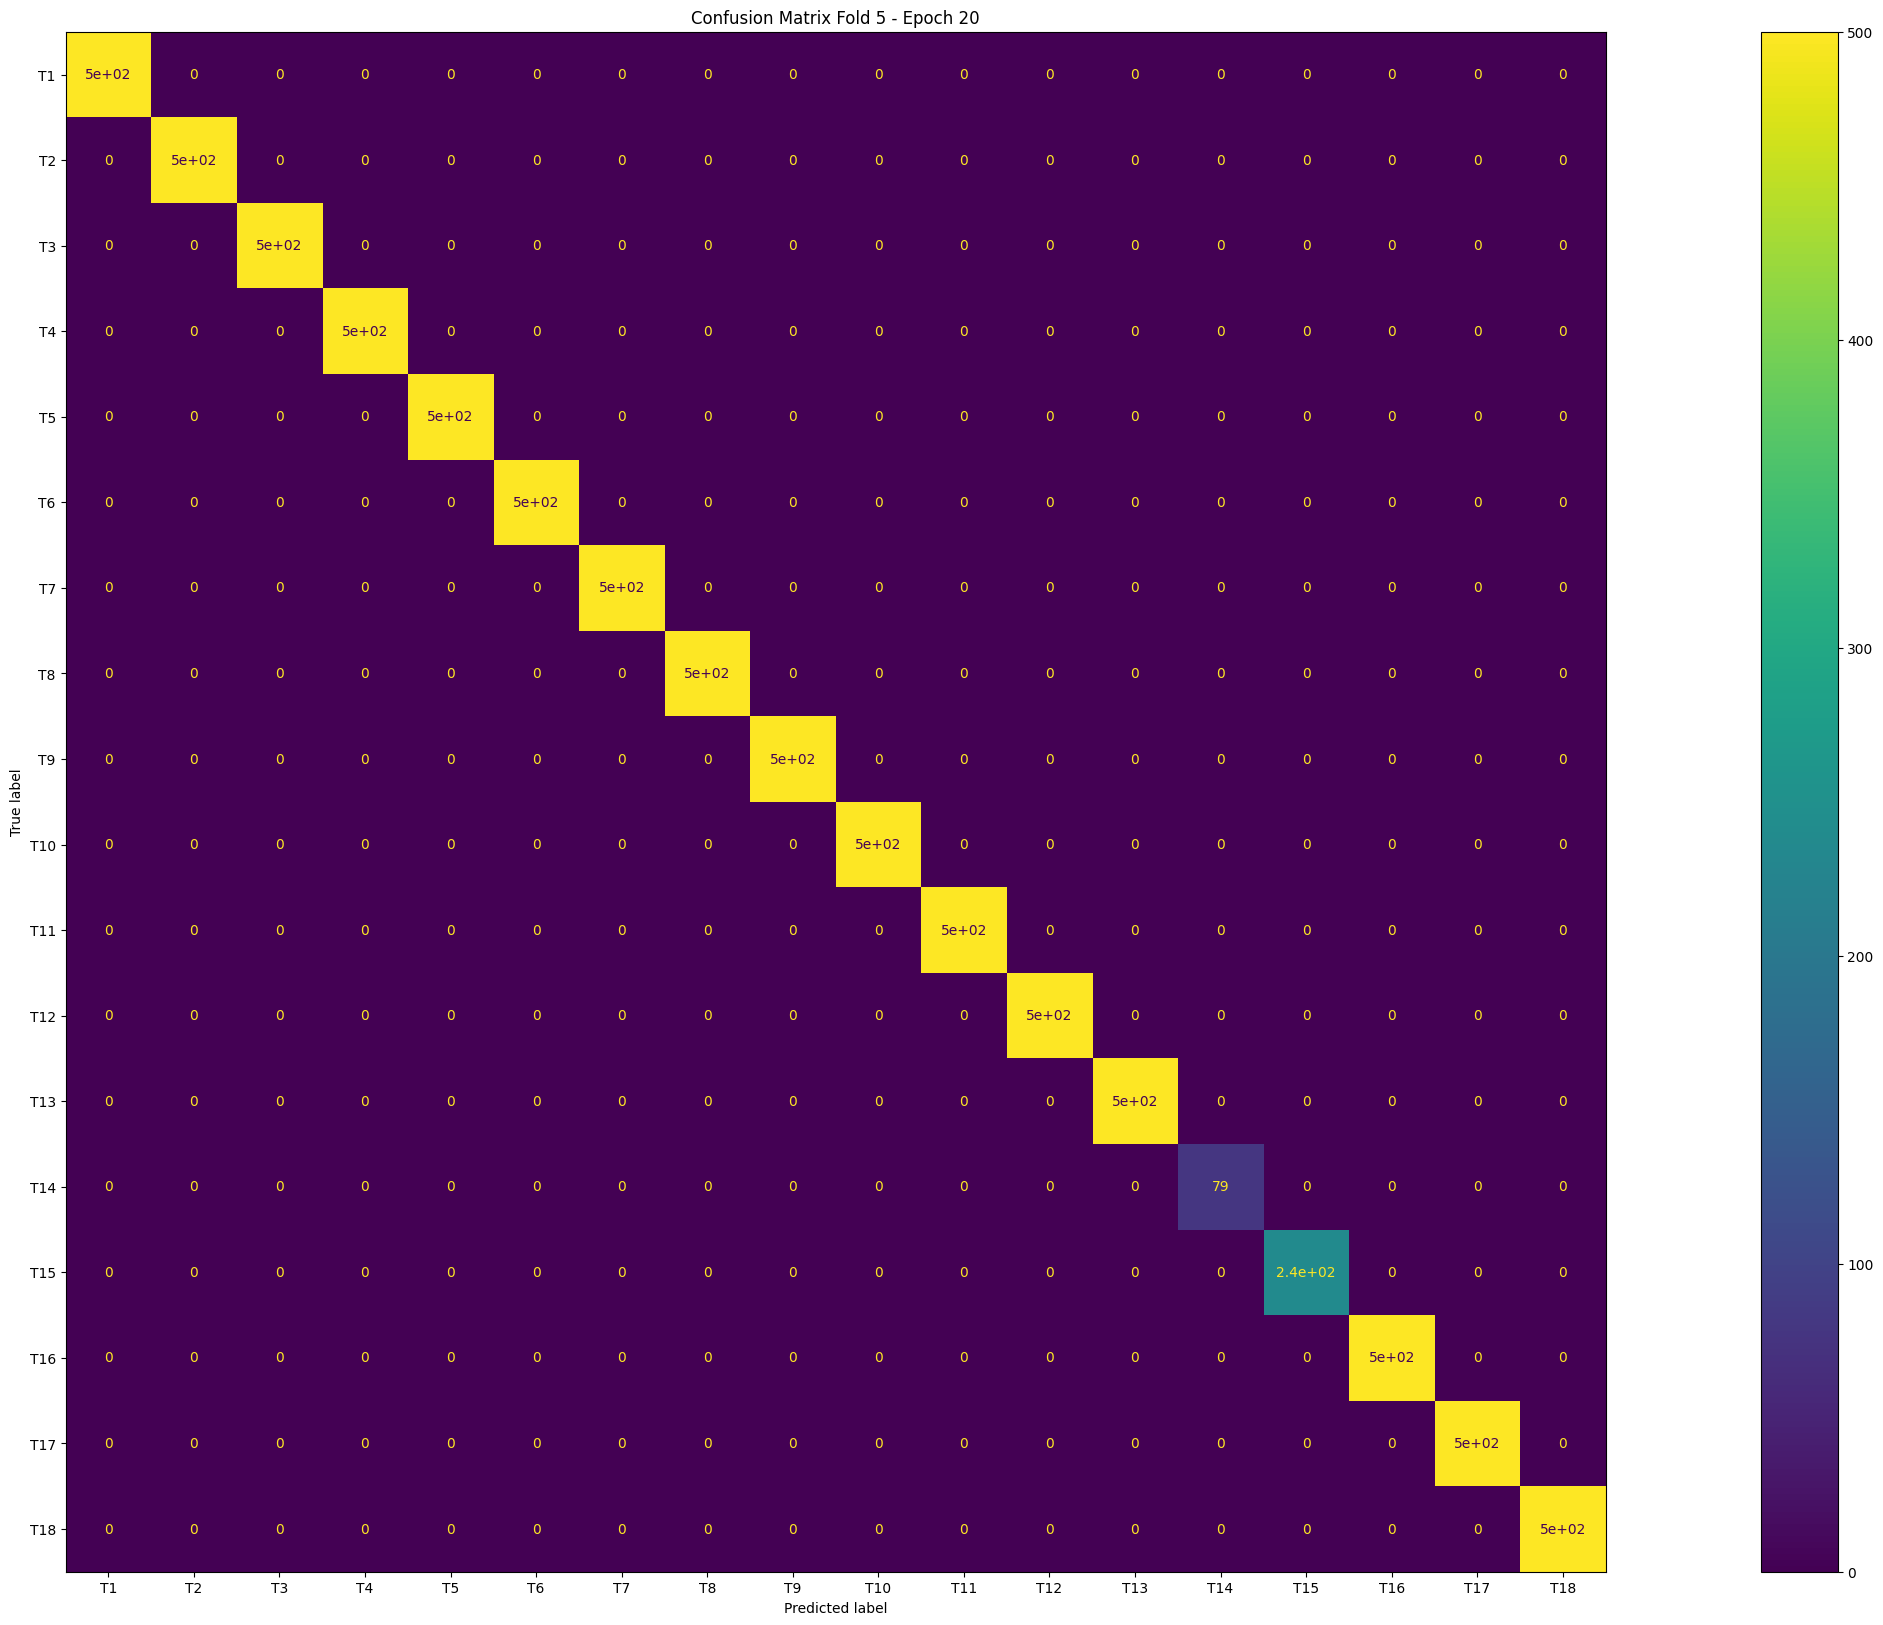

Amount of Data  Accuracy  Precision  Recall  F One
T1            500.0       1.0        1.0     1.0    1.0
T2            500.0       1.0        1.0     1.0    1.0
T3            500.0       1.0        1.0     1.0    1.0
T4            500.0       1.0        1.0     1.0    1.0
T5            500.0       1.0        1.0     1.0    1.0
T6            500.0       1.0        1.0     1.0    1.0
T7            500.0       1.0        1.0     1.0    1.0
T8            500.0       1.0        1.0     1.0    1.0
T9            500.0       1.0        1.0     1.0    1.0
T10           500.0       1.0        1.0     1.0    1.0
T11           500.0       1.0        1.0     1.0    1.0
T12           500.0       1.0        1.0     1.0    1.0
T13           500.0       1.0        1.0     1.0    1.0
T14            79.0       1.0        1.0     1.0    1.0
T15           239.0       1.0        1.0     1.0    1.0
T16           500.0       1.0        1.0     1.0    1.0
T17           500.0       1.0        1.0     1.0    1.0
T18           500.0       1.0        1.0     1.0    1.0

In [ ]:
for fold_i in range(5):

  tr_loss = 0

  save_path = 'model_indobert/class_tesaurus_checkpoint/fold_' + str(fold_i)
  model_class_path = os.path.join(save_path, "indobert_class_tesaurus_checkpoint_19.pth")
  model = torch.load(model_class_path)

  model.to(DEVICE)

  model.eval()

  nb_classes = 18

  true_recaps = [[] for i in range(5)]
  false_recaps = [[] for i in range(5)]

  conf_matrix = torch.zeros(nb_classes, nb_classes)
  # Untuk setiap data di training data
  for data in test_instances:

    with torch.no_grad():
      # Mendapatkan output dari model
      input, gold = data
      input = input.to(DEVICE)
      gold = gold.to(DEVICE)
      pred = model(input)

      # Categorical Cross-Entropy --- Loss Function
      loss = loss_func(pred, gold)
      # _, pred = torch.max(pred, 1)
        # for t, p in zip(gold.view(-1), pred.view(-1)):
        #   confusion_matrix[t.long(), p.long()] += 1

      # akumulasi loss dalam 1 epoch
      tr_loss += loss.item()

      conf_matrix = confusion_matrix(gold, pred, conf_matrix)

      for input_recap, gold_recap, pred_recap in zip(input.to('cpu'), gold.to('cpu'), pred.to('cpu')):
        input_recap_sentence = tokenizer.decode(input_recap)
        _, gold_idx = torch.max(gold_recap, 0)
        _, pred_idx = torch.max(pred_recap, 0)
        if gold_idx == pred_idx:
          true_recaps[fold_i].append((input_recap_sentence, gold_idx, pred_idx))
        else:
          false_recaps[fold_i].append((input_recap_sentence, gold_idx, pred_idx))

  amt, acc, prec, rec, f1 = evaluation_metric(conf_matrix)
  data_conf = {
          'Amount of Data': amt,
          'Accuracy': acc,
          'Precision': prec,
          'Recall': rec,
          'F One': f1
      }

  # rata-rata loss dalam 1 epoch
  avg_loss = tr_loss / test_size
  # accuracy = confusion_matrix.diag()/confusion_matrix.sum(1)

  print("")
  print(f"Average loss di testing data: {avg_loss}")

  fig, ax = plt.subplots(figsize=(40, 20))

  display_labels = ['T1', 'T2', 'T3', 'T4', 'T5', 'T6', 'T7', 'T8', 'T9', 'T10', 'T11', 'T12', 'T13', 'T14', 'T15', 'T16', 'T17', 'T18']
  disp = metrics.ConfusionMatrixDisplay(confusion_matrix=conf_matrix.detach().cpu().numpy(), display_labels=display_labels)
  disp.plot(ax=ax)
  plt.title(f"Confusion Matrix Fold {fold_i + 1} - Epoch 20")

  plt.show()

  disp_df = pd.DataFrame(data=data_conf,
                          index=display_labels, columns=['Amount of Data', 'Accuracy', 'Precision', 'Recall', 'F One'])
  display(disp_df)